In [46]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline, interp1d
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score, coverage_error
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

# 0 Training loss plot

In [44]:
folder = os.getcwd()
model_folder = '20241013 single phase orientation full prompt 20 lr1e-4'

# with open(os.path.join(folder, 'models', model_folder, 'train_result.npy'), 'rb') as handle:
#     train_loss = np.array(joblib.load(handle)['loss'])
    
train_loss = np.genfromtxt(os.path.join(folder, 'models', model_folder, 'train_loss.csv'), delimiter=',')
    
smoothed = savgol_filter(train_loss,window_length=201,polyorder=3)

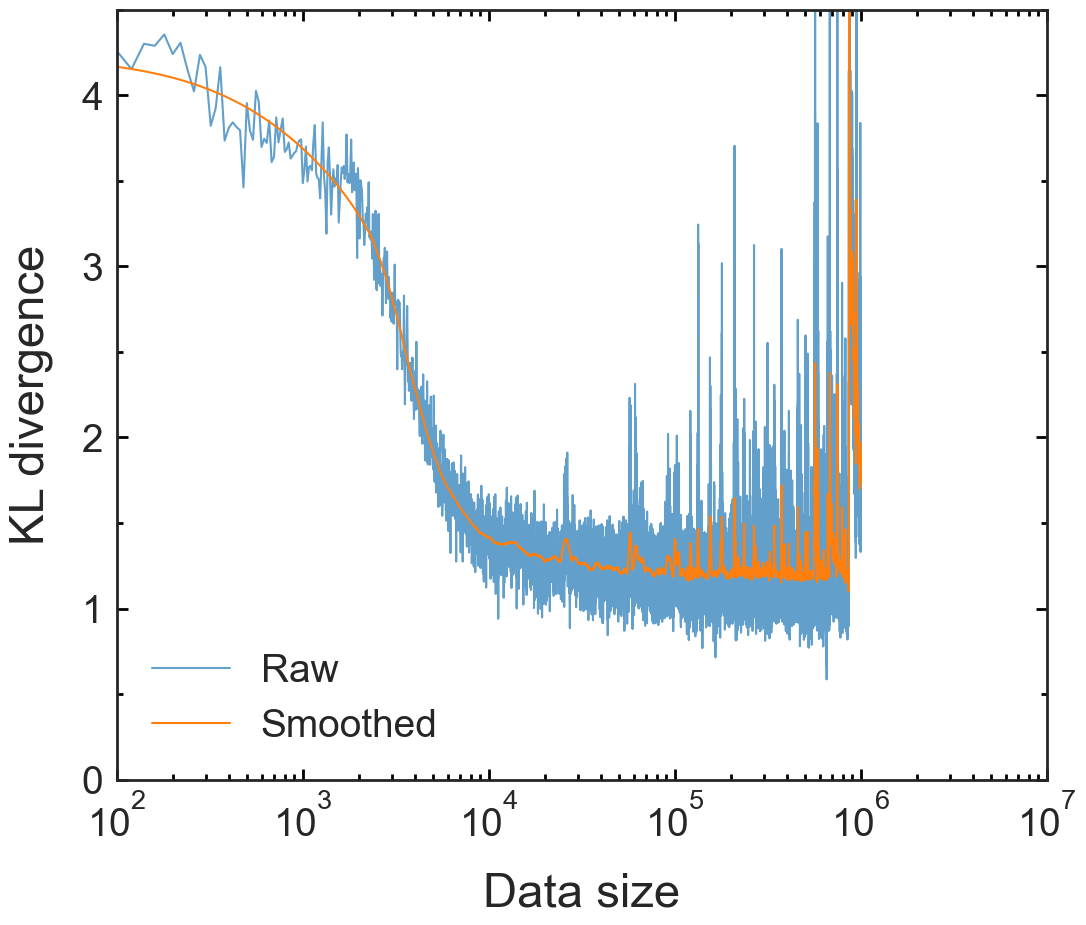

In [45]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(12, 10))
data_size_list = np.linspace(20,len(train_loss)*20,len(train_loss))

ax.plot(data_size_list, train_loss, zorder=-10, alpha=0.7, label='Raw')
ax.plot(data_size_list, smoothed, label='Smoothed')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
# ax.axes.set_xlim([100,100000])
ax.axes.set_xlim([100,10000000])
ax.axes.set_ylim([0,4.5])
# ax.axes.set_ylim([0,2])
ax.set_xscale('log')

ax.set_xlabel(r'Data size', labelpad=20, fontsize=34)
ax.set_ylabel(r'KL divergence', labelpad=20, fontsize=34)
# plt.legend(loc="upper right",fontsize=28)
plt.legend(loc="lower left",fontsize=28)

plt.savefig(os.path.join(folder, 'models', model_folder, 'train_loss.png'), format='png', dpi=300, transparent=True, bbox_inches='tight')

In [3]:
del train_dic

# 1 Dataloader

In [68]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    n_mix:             List of n compounds coexisting in one XRD.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  n_mix=[1,2,3], resonable_mixing=False, min_mixing_ratio=0.05, 
                  high_orientation_probability=0.2, crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.choice(n_mix, batch_size, replace=True)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing and self.n_mix_list[i]!=1:
                self.sample_idxs = []
                samples = []
                while len(samples) < self.n_mix_list[i]:
                    samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                self.n_mix_list[i] = min(self.n_mix_list[i],len(samples))
                samples = np.random.choice(samples, self.n_mix_list[i], replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                if np.random.binomial(1, high_orientation_probability) == 1:
                    high_orientation_peak_index = np.random.choice(np.argpartition(dataloader.X_short,-3)[-3:],1)[0]
                    self.X_short = np.array([self.X_short[high_orientation_peak_index]])
                    self.twotheta_short = np.array([self.twotheta_short[high_orientation_peak_index]])
                
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])
                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list, self.n_mix_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [69]:
cif_folder = os.path.join(folder, 'cif')
dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2.1 single phase classification (none / EDS / Precursor)

In [13]:
model_folder = '20241012 single phase orientation full prompt 20'
num_of_epochs = 10000000
cif_folder = os.path.join(folder, 'cif')
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', 
                                                                    model_folder, '{}'.format(num_of_epochs))).to('cuda')

In [75]:
n = 1
file_name = 'test_dataset_{}phase_orientation.npy'.format(n)

try:
    with open(os.path.join(cif_folder, file_name), 'rb') as handle:
        test_dataset = joblib.load(handle)

    Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    print('test dataset loaded.')

except:
    Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=2000, n_mix=[n], resonable_mixing=True,
                                                              high_orientation_probability=0.2, crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.01, 1))
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

    with open(os.path.join(cif_folder, file_name), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')
    
print(np.sum(Ys,axis=0))

test dataset loaded.
[33. 28. 24. 31. 36. 15. 29. 33. 28. 31. 34. 34. 31. 36. 34. 49. 35. 27.
 30. 33. 29. 32. 35. 35. 28. 25. 27. 25. 39. 33. 24. 30. 31. 37. 23. 28.
 36. 38. 21. 31. 22. 27. 39. 26. 34. 32. 28. 34. 31. 26. 24. 33. 31. 29.
 32. 25. 34. 30. 32. 30. 31. 22. 27. 22. 27. 34.]


In [20]:
y_true, y_pred, y_formula, y_pred_full = [], [], [], []
prompt_type_list = [None,'eds','full']
prompt_type = prompt_type_list[0]

for i in range(len(element_list)):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    X_prompts = []
    random.shuffle(element_list[i])
    if prompt_type == None:
        X_prompts.append('')
    elif prompt_type == 'eds':
        X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
    elif prompt_type == 'full':
        X_prompts.append(' '.join(element_list[i]))
#         X_prompts.append('Cs Pb I Br')

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    logits = outputs.logits
    y_true.append(np.array(labels).argmax(-1)[0])
    y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
    y_pred_full.append(np.array(logits.detach().cpu()[0]))
    y_formula.append(formula_list[i])
    
    print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])
    
y_pred_full = np.array(y_pred_full)

[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['MA0.6FA0.4PbBr3'] 49 48
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbBr3'] 0 26
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsI'] 18 18
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['gamma-CsPbI3'] 38 38
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.8Cl0.2)3'] 31 36
[''] ['PbBr2'] 64 64
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbI3'] 5 16
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['cubic-CsPbCl3'] 35 22
[''] ['cubic-CsPbBr3'] 32 25
[''] ['Cs0.8MA0.2PbI3'] 15 36
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['cubic-MAPbBr3'] 59 55
[''] ['CsPb(I0.4Cl0.6)3'] 29 27
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['cubic-MAPbBr3'] 59 59
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['alpha-FAPbI3'] 44 44
[''] ['delta-CsPbI3'] 37 

[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(I0.4Cl0.6)3'] 29 3
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['CsPb(I0.4Cl0.6)3'] 29 36
[''] ['Cs0.4MA0.6PbBr3'] 9 15
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['MAPb(Br0.2I0.8)3'] 55 31
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Cs0.8FA0.2PbBr3'] 3 10
[''] ['Cs0.6MA0.4PbBr3'] 10 25
[''] ['Cs0.6FA0.4PbBr3'] 2 8
[''] ['Cs0.8MA0.2PbI3'] 15 36
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Pnma-CsPbCl3'] 34 47
[''] ['beta-FAPbI3'] 45 41
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['delta-CsPbI3'] 37 38
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.4Br0.6)3'] 25 31
[''] ['Cs0.4MA0.6PbI3'] 13 14
[''] ['PbI2'] 65 65
[''] ['CsPb(Cl0.8Br0.2)3'] 23 34
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['Cs0.6FA0.4PbBr3'] 2 8
[''] ['CsPb(I0.2Cl0.8)3'] 28 3
[''] ['Cs0.2FA0.8PbBr3'] 0 27
[''] ['Cs0.6FA0.4PbI3'] 6 6

[''] ['gamma-CsPbI3'] 38 38
[''] ['Cs0.8FA0.2PbI3'] 7 40
[''] ['Cs0.2MA0.8PbBr3'] 8 13
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6FA0.4PbI3'] 6 5
[''] ['CsPb(Cl0.8Br0.2)3'] 23 34
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb2Br5'] 19 19
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['CsBr'] 17 17
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['MA0.2FA0.8PbBr3'] 47 62
[''] ['cubic-FAPbBr3'] 43 12
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb(Cl0.6Br0.4)3'] 22 62
[''] ['MA0.8FA0.2PbBr3'] 50 44
[''] ['CsPb2Br5'] 19 63
[''] ['CsPb(I0.4Br0.6)3'] 25 11
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['delta-CsPbI3'] 37 37
[''] ['MAPb(Br0.2I0.8)3'] 55 27
[''] ['alpha-CsPbI3'] 36 15
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.8FA0.2PbI3'] 7 41
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4FA0.6PbBr3'] 1 15
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['cubic-CsPbCl3'] 35 35
[''] ['del

[''] ['cubic-FAPbBr3'] 43 43
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['CsPb(Cl0.8Br0.2)3'] 23 35
[''] ['MAPb(Br0.8I0.2)3'] 58 26
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['PbI2'] 65 65
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['CsPb(I0.2Cl0.8)3'] 28 25
[''] ['PbBr2'] 64 64
[''] ['Cs0.4FA0.6PbBr3'] 1 24
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbI3'] 14 13
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.6FA0.4PbBr3'] 2 9
[''] ['delta-CsPbI3'] 37 37
[''] ['beta-FAPbI3'] 45 41
[''] ['CsPb(Cl0.2Br0.8)3'] 20 62
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['Cs0.6MA0.4PbI3'] 14 36
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Cs4PbBr6'] 16 16
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbI3

In [45]:
for i in range(5):
    print(torch.topk(outputs.logits[0], i+1).indices)

tensor([34], device='cuda:0')
tensor([34, 43], device='cuda:0')
tensor([34, 43,  1], device='cuda:0')
tensor([34, 43,  1, 23], device='cuda:0')
tensor([34, 43,  1, 23, 35], device='cuda:0')


In [ ]:
for k in range(1,6):
    print('top {}:'.format(k), top_k_accuracy_score(y_true_full, y_pred_full, k=k))

## data size

['Cl I Pb Cs'] ['CsPb(I0.2Cl0.8)3'] 28 41
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 55
['Cl Br Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['Cs Cl Br Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 41
['Cl Pb I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 41
['I FA Pb'] ['alpha-FAPbI3'] 44 55
['Cl Cs Pb I'] ['CsPb(I0.6Cl0.4)3'] 30 41
['I Pb Cs Br'] ['CsPb(I0.6Br0.4)3'] 26 24
['MA FA Pb I'] ['MA0.6FA0.4PbI3'] 53 41
['FA Br Pb MA'] ['MA0.4FA0.6PbBr3'] 48 41
['MA FA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 41
['MA I Pb'] ['tetragonal-MAPbI3'] 63 55
['Pb Br I Cs'] ['CsPb(I0.6Br0.4)3'] 26 41
['Cl I Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 41
['Cs FA I Pb'] ['Cs0.2FA0.8PbI3'] 4 41
['MA Pb I FA'] ['MA0.6FA0.4PbI3'] 53 41
['Pb Cs FA Br'] ['Cs0.6FA0.4PbBr3'] 2 24
['Cs Pb Br FA'] ['Cs0.2FA0.8PbBr3'] 0 41
['MA Cs Pb Br'] ['Cs0.6MA0.4PbBr3'] 10 24
['Pb Br Cs FA'] ['Cs0.2FA0.8PbBr3'] 0 41
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 55
['I MA Pb Cs'] ['Cs0.6MA0.4PbI3'] 14 41
['Br MA Pb FA'] ['MA0.8FA0.2PbBr3'] 50 41
['Br MA FA Pb'] ['MA0.2FA0.8PbBr3'] 47 41
['MA 

['I Pb FA'] ['alpha-FAPbI3'] 44 43
['MA Pb Br'] ['cubic-MAPbBr3'] 59 24
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 55
['Cs Pb I Cl'] ['CsPb(I0.2Cl0.8)3'] 28 41
['Cl Pb Cs Br'] ['CsPb(Cl0.8Br0.2)3'] 23 24
['FA Pb Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 41
['I MA Pb'] ['alpha-MAPbI3'] 62 55
['Pb FA I'] ['alpha-FAPbI3'] 44 13
['I MA FA Pb'] ['MA0.2FA0.8PbI3'] 51 41
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 41
['FA Br Cs Pb'] ['Cs0.8FA0.2PbBr3'] 3 41
['MA Pb Cs I'] ['Cs0.6MA0.4PbI3'] 14 41
['Pb Cs Br'] ['Cs4PbBr6'] 16 24
['Cs I Pb'] ['gamma-CsPbI3'] 38 55
['Pb Cs Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 24
['Pb I MA'] ['tetragonal-MAPbI3'] 63 33
['Br Pb Cs'] ['CsPb2Br5'] 19 55
['Pb Cs I'] ['gamma-CsPbI3'] 38 13
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['MA FA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 24
['Pb FA MA I'] ['MA0.4FA0.6PbI3'] 52 41
['Pb Br MA Cs'] ['Cs0.8MA0.2PbBr3'] 11 41
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 41
['I Cs Pb MA'] ['Cs0.2MA0.8PbI3'] 12 41
['Pb FA I Cs'] ['Cs0.8FA0.2PbI3'] 7 41
['Pb Cs I Br'] ['CsPb(I0.8Br0.2)

['FA Pb Br I'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA Br Cs Pb'] ['Cs0.4FA0.6PbBr3'] 1 41
['Pb Br'] ['PbBr2'] 64 24
['Pb I FA MA'] ['MA0.2FA0.8PbI3'] 51 41
['Br I Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 41
['I Cs Pb MA'] ['Cs0.2MA0.8PbI3'] 12 41
['Br Pb FA MA'] ['MA0.2FA0.8PbBr3'] 47 41
['FA MA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 24
['Br I Pb Cs'] ['CsPb(I0.2Br0.8)3'] 24 41
['FA Br Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 41
['FA Cs Pb Br'] ['Cs0.2FA0.8PbBr3'] 0 24
['Cs I Pb FA'] ['Cs0.8FA0.2PbI3'] 7 41
['Pb MA Br Cs'] ['Cs0.4MA0.6PbBr3'] 9 41
['Pb FA Br I'] ['FAPb(Br0.8I0.2)3'] 42 41
['Pb Cs Br'] ['Cs4PbBr6'] 16 24
['I Pb MA'] ['tetragonal-MAPbI3'] 63 33
['Pb MA Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 41
['Cs Pb Br FA'] ['Cs0.4FA0.6PbBr3'] 1 41
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 55
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 41
['Cs Pb Br'] ['Cs4PbBr6'] 16 24
['MA Pb I'] ['alpha-MAPbI3'] 62 13
['Cs Br Pb MA'] ['Cs0.2MA0.8PbBr3'] 8 41
['Pb I MA'] ['tetragonal-MAPbI3'] 63 33
['FA I Pb Cs'] ['Cs0.6FA0.4PbI3'] 6 41
['MA Pb I FA'] ['MA0

['I FA Pb'] ['beta-FAPbI3'] 45 55
['Pb I FA Cs'] ['Cs0.4FA0.6PbI3'] 5 41
['Br FA Pb'] ['cubic-FAPbBr3'] 43 55
['FA MA Pb I'] ['MA0.2FA0.8PbI3'] 51 41
['Pb FA Br MA'] ['MA0.6FA0.4PbBr3'] 49 41
['Pb Cs Br I'] ['CsPb(I0.6Br0.4)3'] 26 41
['Pb Br Cs'] ['CsPb2Br5'] 19 55
['Br Pb Cs'] ['cubic-CsPbBr3'] 32 55
['FA Pb Br Cs'] ['Cs0.6FA0.4PbBr3'] 2 41
['FA Pb Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 24
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 41
['Br Pb Cs I'] ['CsPb(I0.2Br0.8)3'] 24 41
['I FA Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Cs FA Br'] ['Cs0.4FA0.6PbBr3'] 1 24
['Cs FA I Pb'] ['Cs0.6FA0.4PbI3'] 6 41
['Br Cs I Pb'] ['CsPb(I0.2Br0.8)3'] 24 41
['Cl I Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Cl Pb Cs I'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Pb Br Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['I Cs Pb MA'] ['Cs0.4MA0.6PbI3'] 13 41
['Pb FA I Cs'] ['Cs0.2FA0.8PbI3'] 4 41
['Pb Br'] ['PbBr2'] 64 24
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 41
['Pb I Cs MA'] ['Cs0.8MA0.2PbI3'] 15 41
['Cs Pb MA Br'] ['Cs0.4MA0.6PbBr3'] 9 24
['Pb Cl Cs I'

['Pb I MA FA'] ['MA0.6FA0.4PbI3'] 53 41
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 24
['Cl Br Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['MA Br FA Pb'] ['MA0.6FA0.4PbBr3'] 49 41
['Cl Pb Br Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['I Pb'] ['PbI2'] 65 32
['MA Cs Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 41
['FA Br Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 41
['Pb MA Br'] ['cubic-MAPbBr3'] 59 24
['MA Pb Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 41
['I Cs Pb'] ['alpha-CsPbI3'] 36 55
['FA MA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 41
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 41
['MA I Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['Cs Pb MA I'] ['Cs0.2MA0.8PbI3'] 12 41
['Cs I Pb Cl'] ['CsPb(I0.8Cl0.2)3'] 31 41
['I Pb'] ['PbI2'] 65 55
['I Pb MA'] ['alpha-MAPbI3'] 62 33
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 24
['Cl I Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 41
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 55
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 41
['I Cs FA Pb'] ['Cs0.6FA0.4PbI3'] 6 41
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 55
['I Cs MA Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['I FA Pb Cs'] ['Cs0.4FA0.6PbI

['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 55
['Br Cs FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 41
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 55
['Br I Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Br Cs'] ['CsPb2Br5'] 19 55
['Cs Pb FA Br'] ['Cs0.8FA0.2PbBr3'] 3 24
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 55
['I Cs FA Pb'] ['Cs0.8FA0.2PbI3'] 7 41
['I Pb FA MA'] ['MA0.8FA0.2PbI3'] 54 41
['MA I FA Pb'] ['MA0.2FA0.8PbI3'] 51 41
['I MA Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 41
['FA I Pb MA'] ['MA0.2FA0.8PbI3'] 51 41
['FA Br Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 41
['Pb Br MA'] ['cubic-MAPbBr3'] 59 33
['I Pb Cs'] ['delta-CsPbI3'] 37 55
['MA I Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['I Cs Pb'] ['alpha-CsPbI3'] 36 55
['Br MA Cs Pb'] ['Cs0.4MA0.6PbBr3'] 9 41
['Br MA Pb FA'] ['MA0.6FA0.4PbBr3'] 49 41
['MA Cl Pb'] ['Pnma-MAPbCl3'] 61 55
['MA I Pb FA'] ['MA0.6FA0.4PbI3'] 53 41
['Pb I Cs Br'] ['CsPb(I0.2Br0.8)3'] 24 24
['I Cs MA Pb'] ['Cs0.8MA0.2PbI3'] 15 41
['Pb Br Cs MA'] ['Cs0.8MA0.2PbBr3'] 11 41
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 33
['MA I FA Pb'] ['MA0.8F

['Pb I'] ['PbI2'] 65 14
['Br Cs MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 41
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 55
['Cl Br Cs Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 41
['Cs FA Pb Br'] ['Cs0.8FA0.2PbBr3'] 3 24
['Pb Cl I Cs'] ['CsPb(I0.6Cl0.4)3'] 30 41
['FA Pb Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 41
['I FA Pb Br'] ['FAPb(Br0.8I0.2)3'] 42 24
['Br Cs Pb I'] ['CsPb(I0.4Br0.6)3'] 25 41
['Cs Br Cl Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 41
['FA Pb I Br'] ['FAPb(Br0.4I0.6)3'] 40 24
['I Cs Cl Pb'] ['CsPb(I0.8Cl0.2)3'] 31 41
['Pb Br I MA'] ['MAPb(Br0.8I0.2)3'] 58 41
['Cs Pb Br'] ['CsPb2Br5'] 19 24
['MA Pb I FA'] ['MA0.8FA0.2PbI3'] 54 41
['MA I Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['Cs FA Pb I'] ['Cs0.2FA0.8PbI3'] 4 41
['Br FA Pb Cs'] ['Cs0.4FA0.6PbBr3'] 1 41
['Br Pb FA MA'] ['MA0.8FA0.2PbBr3'] 50 41
['Cs FA Pb I'] ['Cs0.2FA0.8PbI3'] 4 41
['Cs Br'] ['CsBr'] 17 24
['Pb Br Cs Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['Cs Pb Br'] ['CsPb2Br5'] 19 24
['Pb Cs MA I'] ['Cs0.4MA0.6PbI3'] 13 41
['Pb MA I Br'] ['MAPb(Br0.8I0.2)3'] 58 24
['Br Pb'] ['PbBr2']

['FA Br Pb I'] ['FAPb(Br0.2I0.8)3'] 39 41
['MA FA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 24
['Cs Pb MA I'] ['Cs0.8MA0.2PbI3'] 15 41
['Pb Br Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 41
['Br Cs I Pb'] ['CsPb(I0.4Br0.6)3'] 25 41
['Pb Br I FA'] ['FAPb(Br0.8I0.2)3'] 42 41
['Pb Br Cs'] ['CsPb2Br5'] 19 55
['Br Pb I Cs'] ['CsPb(I0.2Br0.8)3'] 24 41
['Cl Pb Br Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['Cs I Pb'] ['delta-CsPbI3'] 37 55
['FA Pb I Cs'] ['Cs0.8FA0.2PbI3'] 7 41
['Br Cs'] ['CsBr'] 17 6
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 55
['Cl Pb Cs Br'] ['CsPb(Cl0.8Br0.2)3'] 23 24
['I Pb FA'] ['beta-FAPbI3'] 45 43
['I Pb MA Br'] ['MAPb(Br0.8I0.2)3'] 58 24
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 41
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 55
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 55
['MA I Pb'] ['alpha-MAPbI3'] 62 55
['Pb I MA'] ['alpha-MAPbI3'] 62 33
['Pb MA Br FA'] ['MA0.8FA0.2PbBr3'] 50 41
['Pb I FA'] ['alpha-FAPbI3'] 44 43
['MA Pb I'] ['alpha-MAPbI3'] 62 13
['I Pb'] ['PbI2'] 65 32
['Pb I Cl Cs'] ['CsPb(I0.8Cl0.2)3'] 31 41
['I 

['Pb Br Cs'] ['cubic-CsPbBr3'] 32 55
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 55
['I MA Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 41
['FA I Pb Br'] ['FAPb(Br0.6I0.4)3'] 41 24
['Br Pb I FA'] ['FAPb(Br0.2I0.8)3'] 39 41
['Pb Cl Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 24
['Pb Br Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 41
['Pb I Br FA'] ['FAPb(Br0.4I0.6)3'] 40 41
['I MA Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 24
['MA Pb I FA'] ['MA0.6FA0.4PbI3'] 53 41
['MA FA Pb Br'] ['MA0.8FA0.2PbBr3'] 50 24
['Cs I'] ['CsI'] 18 14
['I Cl Pb Cs'] ['CsPb(I0.6Cl0.4)3'] 30 41
['MA Br Pb I'] ['MAPb(Br0.8I0.2)3'] 58 41
['FA I Pb'] ['alpha-FAPbI3'] 44 55
['MA Br Pb Cs'] ['Cs0.2MA0.8PbBr3'] 8 41
['Pb I Cs'] ['delta-CsPbI3'] 37 55
['Pb I'] ['PbI2'] 65 14
['Br FA Cs Pb'] ['Cs0.8FA0.2PbBr3'] 3 41
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 55
['FA Pb I'] ['beta-FAPbI3'] 45 13
['Pb FA Br I'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb MA I Cs'] ['Cs0.2MA0.8PbI3'] 12 41
['Pb I FA'] ['beta-FAPbI3'] 45 43
['Pb Br'] ['PbBr2'] 64 24
['Pb Cs Br I'] ['CsPb(I0.4Br0.6)3'] 25 41
['Pb I FA'] [

['Br Pb Cs Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['Cs Br'] ['CsBr'] 17 24
['MA Br I Pb'] ['MAPb(Br0.6I0.4)3'] 57 41
['I MA Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['MA Pb Br I'] ['MAPb(Br0.4I0.6)3'] 56 41
['Br Cs Pb MA'] ['Cs0.4MA0.6PbBr3'] 9 41
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 24
['FA MA Br Pb'] ['MA0.6FA0.4PbBr3'] 49 41
['FA MA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 41
['MA FA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 24
['Cs Pb Cl I'] ['CsPb(I0.6Cl0.4)3'] 30 41
['I MA Pb'] ['alpha-MAPbI3'] 62 55
['Br Pb Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['Pb MA FA I'] ['MA0.2FA0.8PbI3'] 51 41
['Pb Br MA Cs'] ['Cs0.4MA0.6PbBr3'] 9 41
['MA Pb Br'] ['cubic-MAPbBr3'] 59 24
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 55
['Pb Br'] ['PbBr2'] 64 24
['Br Cs Pb'] ['Cs4PbBr6'] 16 55
['Pb Br Cs MA'] ['Cs0.8MA0.2PbBr3'] 11 41
['FA I Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb MA FA Br'] ['MA0.2FA0.8PbBr3'] 47 24
['Cs I Cl Pb'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Cl Pb I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 41
['Br Pb Cs MA'] ['Cs0.4MA0.6PbBr3'] 9 41
['Pb Br Cs 

['FA Br I Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Cs MA Br'] ['Cs0.6MA0.4PbBr3'] 10 24
['MA Pb Br I'] ['MAPb(Br0.8I0.2)3'] 58 46
['MA Pb I'] ['alpha-MAPbI3'] 62 46
['Br FA Pb'] ['cubic-FAPbBr3'] 43 43
['Pb Cl MA'] ['Pnma-MAPbCl3'] 61 62
['I Cs MA Pb'] ['Cs0.8MA0.2PbI3'] 15 27
['Pb Cs I Cl'] ['CsPb(I0.2Cl0.8)3'] 28 5
['I Pb FA MA'] ['MA0.4FA0.6PbI3'] 52 41
['I Cs'] ['CsI'] 18 13
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 41
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 24
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 43
['Pb I'] ['PbI2'] 65 46
['MA Br Pb'] ['cubic-MAPbBr3'] 59 43
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 43
['Pb Br FA MA'] ['MA0.4FA0.6PbBr3'] 48 41
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 38
['Br Pb Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['MA Cs I Pb'] ['Cs0.2MA0.8PbI3'] 12 41
['Pb I FA MA'] ['MA0.8FA0.2PbI3'] 54 41
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 41
['Br I Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 41
['I MA Pb FA'] ['MA0.6FA0.4PbI3'] 53 41
['Pb Br MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 41
['I Pb MA Br'] ['MAPb(Br0.6I0.4)3'] 57

['Pb I MA FA'] ['MA0.6FA0.4PbI3'] 53 41
['Pb Cl I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 41
['MA Pb Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 24
['Pb Cs MA I'] ['Cs0.4MA0.6PbI3'] 13 46
['FA Pb I Br'] ['FAPb(Br0.6I0.4)3'] 41 24
['Br MA Pb FA'] ['MA0.6FA0.4PbBr3'] 49 41
['MA Pb I'] ['alpha-MAPbI3'] 62 46
['FA Cs Pb I'] ['Cs0.2FA0.8PbI3'] 4 46
['Cl Br Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['FA I Cs Pb'] ['Cs0.6FA0.4PbI3'] 6 41
['Pb Cs Cl Br'] ['CsPb(Cl0.6Br0.4)3'] 22 24
['Cs Pb Br MA'] ['Cs0.8MA0.2PbBr3'] 11 41
['FA Pb MA I'] ['MA0.6FA0.4PbI3'] 53 46
['Cl Pb Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 46
['FA Br Pb MA'] ['MA0.2FA0.8PbBr3'] 47 41
['Br Cs FA Pb'] ['Cs0.6FA0.4PbBr3'] 2 41
['Pb I MA FA'] ['MA0.6FA0.4PbI3'] 53 41
['Pb Cs I FA'] ['Cs0.4FA0.6PbI3'] 5 41
['Br Pb I FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb I'] ['PbI2'] 65 46
['MA Pb I Cs'] ['Cs0.8MA0.2PbI3'] 15 41
['I Pb Br Cs'] ['CsPb(I0.8Br0.2)3'] 27 41
['FA I Pb'] ['beta-FAPbI3'] 45 43
['MA I Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 24
['MA FA I Pb'] ['MA0.2FA0.8PbI3'] 51 27
['

['I FA Pb MA'] ['MA0.4FA0.6PbI3'] 52 41
['Cs Pb Br MA'] ['Cs0.2MA0.8PbBr3'] 8 41
['FA I Pb MA'] ['MA0.4FA0.6PbI3'] 52 13
['MA I Pb Cs'] ['Cs0.4MA0.6PbI3'] 13 41
['FA Pb MA Br'] ['MA0.2FA0.8PbBr3'] 47 24
['I FA Pb Br'] ['FAPb(Br0.2I0.8)3'] 39 24
['I Pb FA'] ['alpha-FAPbI3'] 44 43
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 43
['Pb MA I Cs'] ['Cs0.8MA0.2PbI3'] 15 41
['Cs Cl Pb I'] ['CsPb(I0.6Cl0.4)3'] 30 46
['Br I FA Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 41
['Cs Br'] ['CsBr'] 17 12
['Br Pb FA MA'] ['MA0.2FA0.8PbBr3'] 47 41
['Br FA MA Pb'] ['MA0.4FA0.6PbBr3'] 48 41
['Br Pb Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 41
['I Pb MA Cs'] ['Cs0.4MA0.6PbI3'] 13 41
['Pb Br MA'] ['cubic-MAPbBr3'] 59 62
['Pb FA Br Cs'] ['Cs0.2FA0.8PbBr3'] 0 41
['Cs Pb I'] ['alpha-CsPbI3'] 36 46
['MA Cs Pb I'] ['Cs0.4MA0.6PbI3'] 13 46
['Br FA Pb'] ['cubic-FAPbBr3'] 43 43
['MA Pb Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 24
['MA I Pb FA'] ['MA0.2FA0.8PbI3'] 51 41
['I FA Pb'] ['delta-FAPbI3'] 46 43
['MA Pb Br'] ['cub

['Br MA Pb'] ['cubic-MAPbBr3'] 59 43
['Pb I FA'] ['alpha-FAPbI3'] 44 43
['FA Cs Pb Br'] ['Cs0.8FA0.2PbBr3'] 3 24
['FA I Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 27
['Pb Cl Cs I'] ['CsPb(I0.4Cl0.6)3'] 29 46
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 62
['Pb Cs Br'] ['Cs4PbBr6'] 16 43
['MA Pb Br'] ['cubic-MAPbBr3'] 59 43
['FA Cs Br Pb'] ['Cs0.4FA0.6PbBr3'] 1 41
['Cs Pb I Cl'] ['CsPb(I0.2Cl0.8)3'] 28 5
['Pb FA I'] ['beta-FAPbI3'] 45 46
['I FA Pb'] ['delta-FAPbI3'] 46 43
['FA Pb Cs I'] ['Cs0.2FA0.8PbI3'] 4 46
['Cl I Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 41
['I Pb Cs'] ['delta-CsPbI3'] 37 13
['Br Cs Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 5
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 13
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 29 5
['Cs Pb I FA'] ['Cs0.8FA0.2PbI3'] 7 41
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 41
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 41
['Pb I FA'] ['alpha-FAPbI3'] 44 43
['I Cs'] ['CsI'] 18 13
['Cl Cs Pb Br'] ['CsPb(Cl0.8Br0.2)3'] 23 24
['I FA Pb Cs'] ['Cs0.4FA0.6PbI3'] 5 41
['Pb Cs FA Br'] ['Cs0.4FA0.6PbBr3'] 

['Cl Br Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 41
['MA I FA Pb'] ['MA0.8FA0.2PbI3'] 54 41
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 41
['Br Cs MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 41
['I Pb MA Cs'] ['Cs0.2MA0.8PbI3'] 12 41
['Pb Cs Br Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 5
['Pb Cs Cl I'] ['CsPb(I0.2Cl0.8)3'] 28 46
['I Pb'] ['PbI2'] 65 43
['Pb Cs Br FA'] ['Cs0.6FA0.4PbBr3'] 2 41
['Pb I Cs FA'] ['Cs0.6FA0.4PbI3'] 6 41
['I MA Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 41
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 43
['Pb Cl Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['I Cs Pb'] ['gamma-CsPbI3'] 38 43
['Cs Pb Br MA'] ['Cs0.6MA0.4PbBr3'] 10 41
['I Br Pb Cs'] ['CsPb(I0.2Br0.8)3'] 24 41
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 46
['Pb Br MA FA'] ['MA0.6FA0.4PbBr3'] 49 41
['MA FA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 27
['Cs Pb Br MA'] ['Cs0.8MA0.2PbBr3'] 11 41
['Pb MA I FA'] ['MA0.4FA0.6PbI3'] 52 41
['Br Cl Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['FA Br MA Pb'] ['MA0.4FA0.6PbBr3'] 48 41
['Cl Cs Pb I'] ['CsPb(I0.6Cl0.4)3'] 30 46
['MA Pb I Cs'] ['Cs0.6

['I Cl Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Br FA Pb I'] ['FAPb(Br0.4I0.6)3'] 40 46
['Cs Pb Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 24
['Cs Pb I'] ['alpha-CsPbI3'] 36 46
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 41
['MA Cl Pb'] ['Pnma-MAPbCl3'] 61 43
['MA Pb Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 24
['I Cl Pb Cs'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Pb I'] ['PbI2'] 65 46
['FA I Pb MA'] ['MA0.2FA0.8PbI3'] 51 41
['Br I Pb MA'] ['MAPb(Br0.4I0.6)3'] 56 13
['Br Cs Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 41
['Pb Cl Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 46
['Br Pb FA MA'] ['MA0.8FA0.2PbBr3'] 50 13
['Cs Pb FA Br'] ['Cs0.2FA0.8PbBr3'] 0 24
['Pb Cs Br Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 5
['Pb Br'] ['PbBr2'] 64 12
['Cs I Cl Pb'] ['CsPb(I0.8Cl0.2)3'] 31 41
['Cs Pb I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 5
['Pb I MA Br'] ['MAPb(Br0.2I0.8)3'] 55 24
['Br Cs'] ['CsBr'] 17 13
['MA Pb I FA'] ['MA0.2FA0.8PbI3'] 51 41
['Pb FA I Br'] ['FAPb(Br0.8I0.2)3'] 42 24
['Pb Cs I MA'] ['Cs0.4MA0.6PbI3'] 13 41
['FA Pb I'] ['beta-FAPbI3'] 45 46
['Pb I FA Cs'] ['Cs0.8FA0

['Br Cs'] ['CsBr'] 17 13
['Cs Br Pb MA'] ['Cs0.4MA0.6PbBr3'] 9 41
['Cs Pb Br'] ['Cs4PbBr6'] 16 43
['Br Pb MA I'] ['MAPb(Br0.2I0.8)3'] 55 46
['FA I MA Pb'] ['MA0.2FA0.8PbI3'] 51 41
['Cs Br Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 41
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 13
['Pb Cs Br FA'] ['Cs0.4FA0.6PbBr3'] 1 41
['Cs FA Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 24
['Pb FA Cs I'] ['Cs0.8FA0.2PbI3'] 7 46
['Br Pb MA Cs'] ['Cs0.4MA0.6PbBr3'] 9 41
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 41
['Pb Br MA FA'] ['MA0.4FA0.6PbBr3'] 48 41
['MA I Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 24
['Br Pb Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 41
['MA I Pb'] ['tetragonal-MAPbI3'] 63 43
['Pb Br I Cs'] ['CsPb(I0.2Br0.8)3'] 24 41
['I Pb FA Br'] ['FAPb(Br0.4I0.6)3'] 40 24
['Cl Pb Cs Br'] ['CsPb(Cl0.8Br0.2)3'] 23 24
['Cl Pb I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 41
['Cs I MA Pb'] ['Cs0.2MA0.8PbI3'] 12 41
['FA Pb Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 24
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Br FA Pb I'] ['FAPb(Br0.2I0.8)3'] 39 46
['Pb FA Cs Br'] ['Cs0.2FA0.8Pb

['Pb Cs I'] ['delta-CsPbI3'] 37 46
['MA Cs Pb I'] ['Cs0.4MA0.6PbI3'] 13 46
['I Pb'] ['PbI2'] 65 43
['Br Pb Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 41
['Pb I MA FA'] ['MA0.4FA0.6PbI3'] 52 41
['Pb I MA'] ['alpha-MAPbI3'] 62 62
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 38
['Cs Pb I'] ['delta-CsPbI3'] 37 46
['Cs Cl I Pb'] ['CsPb(I0.6Cl0.4)3'] 30 27
['I MA Pb'] ['tetragonal-MAPbI3'] 63 43
['I Br Pb Cs'] ['CsPb(I0.8Br0.2)3'] 27 41
['Cs MA Pb Br'] ['Cs0.2MA0.8PbBr3'] 8 24
['Cs Br'] ['CsBr'] 17 12
['Cs I Pb Cl'] ['CsPb(I0.4Cl0.6)3'] 29 5
['I FA Pb'] ['alpha-FAPbI3'] 44 43
['Pb Br Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 13
['Pb Br Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 41
['Br Pb MA I'] ['MAPb(Br0.8I0.2)3'] 58 46
['MA Pb I FA'] ['MA0.4FA0.6PbI3'] 52 41
['I Cs Pb MA'] ['Cs0.8MA0.2PbI3'] 15 13
['Cs Br MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 41
['Cs Pb I Br'] ['CsPb(I0.4Br0.6)3'] 25 24
['Br Pb Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 5
['Cs Pb Br I'] ['CsPb(I0.8Br0.2)3'] 27 46
['Br Pb Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 41
['Pb Cs Cl Br'] ['CsPb(Cl0.

['FA Pb Cs I'] ['Cs0.2FA0.8PbI3'] 4 46
['Cs MA Br Pb'] ['Cs0.6MA0.4PbBr3'] 10 27
['Br Pb Cs'] ['Cs4PbBr6'] 16 13
['Pb Br Cs Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 5
['Pb Br Cl Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 41
['Pb I Cs'] ['gamma-CsPbI3'] 38 13
['Pb I MA Cs'] ['Cs0.6MA0.4PbI3'] 14 41
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Br Cs MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 41
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 43
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 43
['Cl Pb Cs Br'] ['CsPb(Cl0.4Br0.6)3'] 21 24
['FA Pb I'] ['delta-FAPbI3'] 46 46
['MA I Br Pb'] ['MAPb(Br0.2I0.8)3'] 55 41
['FA Pb Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 24
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 43
['I Pb Br MA'] ['MAPb(Br0.8I0.2)3'] 58 41
['Pb Cs Br MA'] ['Cs0.2MA0.8PbBr3'] 8 41
['Cs Pb FA I'] ['Cs0.6FA0.4PbI3'] 6 46
['I Cs Pb'] ['gamma-CsPbI3'] 38 43
['I Pb MA Br'] ['MAPb(Br0.6I0.4)3'] 57 24
['I Cs Pb MA'] ['Cs0.8MA0.2PbI3'] 15 41
['Cs Br MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 41
['Br I MA Pb'] ['MAPb(Br0.8I0.2)3'] 58 41
['I Cs Pb'] ['gamma-CsPbI3'] 38 43
['

['FA Pb Br I'] ['FAPb(Br0.8I0.2)3'] 42 58
['Pb Br Cl Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Pb Cs I Br'] ['CsPb(I0.6Br0.4)3'] 26 23
['Pb Br Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['I Pb FA'] ['alpha-FAPbI3'] 44 43
['I Pb FA'] ['beta-FAPbI3'] 45 43
['Cs Br MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 22
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['I Pb Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 23
['Pb Cs Br'] ['CsPb2Br5'] 19 43
['MA Pb Cs I'] ['Cs0.8MA0.2PbI3'] 15 58
['Cs I Pb'] ['delta-CsPbI3'] 37 60
['Pb Br Cl Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Br Pb'] ['PbBr2'] 64 65
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['MA Cs I Pb'] ['Cs0.4MA0.6PbI3'] 13 22
['Cs I Pb'] ['delta-CsPbI3'] 37 60
['Pb Br MA Cs'] ['Cs0.8MA0.2PbBr3'] 11 22
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 54
['Pb Cs I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 23
['I Br Cs Pb'] ['CsPb(I0.8Br0.2)3'] 27 22
['FA Pb MA Br'] ['MA0.6FA0.4PbBr3'] 49 23
['Pb Cs Br MA'] ['Cs0.2MA0.8PbBr3'] 8 54
['MA Pb Br Cs'] ['Cs0.4MA0.6PbBr3'] 9 22
['Pb Cs I MA'] ['Cs0.8MA0.2PbI3'] 15 54
['MA Br Pb I'] ['MAPb(

['Pb I Cs'] ['alpha-CsPbI3'] 36 16
['FA Cs Br Pb'] ['Cs0.6FA0.4PbBr3'] 2 22
['Br Pb'] ['PbBr2'] 64 65
['FA Cs I Pb'] ['Cs0.8FA0.2PbI3'] 7 22
['Pb I'] ['PbI2'] 65 36
['I Pb MA'] ['alpha-MAPbI3'] 62 61
['Br FA Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 22
['Br Cs I Pb'] ['CsPb(I0.8Br0.2)3'] 27 22
['FA Cs I Pb'] ['Cs0.6FA0.4PbI3'] 6 22
['Pb Cs MA Br'] ['Cs0.8MA0.2PbBr3'] 11 23
['Pb Cl Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 58
['Br Cs Pb'] ['CsPb2Br5'] 19 60
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 60
['I Cs Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 22
['Br Pb'] ['PbBr2'] 64 65
['FA Pb I Br'] ['FAPb(Br0.8I0.2)3'] 42 23
['I Cs'] ['CsI'] 18 17
['Cs Pb I Br'] ['CsPb(I0.6Br0.4)3'] 26 23
['Pb FA I MA'] ['MA0.6FA0.4PbI3'] 53 54
['Br Cs Pb Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['Cs Br'] ['CsBr'] 17 17
['Pb Cs I'] ['gamma-CsPbI3'] 38 36
['Pb MA Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 23
['I Cs'] ['CsI'] 18 17
['FA I Br Pb'] ['FAPb(Br0.4I0.6)3'] 40 22
['FA I Pb MA'] ['MA0.8FA0.2PbI3'] 54 54
['Pb I Cs MA'] ['Cs0.2MA0.8PbI3'] 12 54
['I Cs Pb MA']

['I Pb FA'] ['delta-FAPbI3'] 46 43
['MA I Pb Br'] ['MAPb(Br0.8I0.2)3'] 58 23
['I Pb Cs'] ['gamma-CsPbI3'] 38 16
['Cs Pb I Br'] ['CsPb(I0.6Br0.4)3'] 26 23
['Pb Br Cs I'] ['CsPb(I0.2Br0.8)3'] 24 58
['Pb Br MA Cs'] ['Cs0.2MA0.8PbBr3'] 8 22
['Cs I'] ['CsI'] 18 36
['Br Pb'] ['PbBr2'] 64 65
['Cl I Pb Cs'] ['CsPb(I0.4Cl0.6)3'] 29 22
['FA Pb Br I'] ['FAPb(Br0.4I0.6)3'] 40 58
['Cs I'] ['CsI'] 18 36
['I Cs Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 22
['Br Cs I Pb'] ['CsPb(I0.6Br0.4)3'] 26 22
['Br Pb I Cs'] ['CsPb(I0.8Br0.2)3'] 27 22
['FA I Pb Br'] ['FAPb(Br0.4I0.6)3'] 40 23
['Br Pb MA'] ['cubic-MAPbBr3'] 59 61
['MA I Br Pb'] ['MAPb(Br0.2I0.8)3'] 55 22
['FA I Pb'] ['delta-FAPbI3'] 46 60
['I Pb Cs FA'] ['Cs0.8FA0.2PbI3'] 7 48
['I Br Pb MA'] ['MAPb(Br0.4I0.6)3'] 56 54
['I Pb Br FA'] ['FAPb(Br0.6I0.4)3'] 41 48
['MA FA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 23
['I Pb MA Br'] ['MAPb(Br0.6I0.4)3'] 57 23
['Cs Pb I FA'] ['Cs0.6FA0.4PbI3'] 6 48
['I Cs Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 22
['Pb Cs Cl Br'] ['CsPb(Cl0.2Br0.8)3']

['I Cl Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 22
['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 58
['Cs Pb Cl'] ['Pnma-CsPbCl3'] 34 35
['I Pb FA Br'] ['FAPb(Br0.4I0.6)3'] 40 23
['Pb Br I MA'] ['MAPb(Br0.2I0.8)3'] 55 54
['Br Cl Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 22
['Pb Br Cl Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['FA I MA Pb'] ['MA0.8FA0.2PbI3'] 54 22
['MA I Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 22
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 43
['MA Pb Br'] ['cubic-MAPbBr3'] 59 43
['I MA Br Pb'] ['MAPb(Br0.2I0.8)3'] 55 22
['Pb Cs Br'] ['Cs4PbBr6'] 16 43
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['Pb Cs Br FA'] ['Cs0.2FA0.8PbBr3'] 0 48
['Pb I MA Br'] ['MAPb(Br0.4I0.6)3'] 56 23
['Br I MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 22
['Cs Pb I'] ['alpha-CsPbI3'] 36 36
['I Pb MA Br'] ['MAPb(Br0.8I0.2)3'] 58 23
['Cs Pb Br'] ['CsPb2Br5'] 19 43
['FA Br Pb I'] ['FAPb(Br0.2I0.8)3'] 39 58
['I Cs'] ['CsI'] 18 17
['Cl Cs Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['I Pb FA'] ['alpha-FAPbI3'] 44 43
['Pb I Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 23
['MA Br FA Pb'] ['MA0.4F

['Cs FA Pb I'] ['Cs0.8FA0.2PbI3'] 7 58
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 16
['Pb I Br MA'] ['MAPb(Br0.4I0.6)3'] 56 54
['MA I Pb FA'] ['MA0.4FA0.6PbI3'] 52 48
['Br FA Pb Cs'] ['Cs0.4FA0.6PbBr3'] 1 22
['I FA Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 22
['Br Cs Pb Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 23
['Pb FA Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 22
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 43
['FA Pb Br MA'] ['MA0.2FA0.8PbBr3'] 47 54
['Cs I Br Pb'] ['CsPb(I0.8Br0.2)3'] 27 22
['Br Cl Pb Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['Cs Pb I FA'] ['Cs0.6FA0.4PbI3'] 6 48
['Cl Pb Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 23
['Pb I Cs Br'] ['CsPb(I0.6Br0.4)3'] 26 23
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 43
['Pb Cs Br I'] ['CsPb(I0.8Br0.2)3'] 27 58
['I Cs'] ['CsI'] 18 17
['Br MA Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 22
['Pb MA Br'] ['cubic-MAPbBr3'] 59 43
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 35
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 54
['Cs Pb Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 23
['Pb Br I FA'] ['FAPb(Br0.2I0.8)3'] 39 48
['Br Cl Cs Pb'] ['CsPb(Cl0.8Br0.2)

['I Cs FA Pb'] ['Cs0.6FA0.4PbI3'] 6 22
['Pb I FA'] ['delta-FAPbI3'] 46 43
['Cs I'] ['CsI'] 18 36
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 16
['Pb I FA'] ['delta-FAPbI3'] 46 43
['MA I Pb Cs'] ['Cs0.4MA0.6PbI3'] 13 22
['Cs Pb I'] ['alpha-CsPbI3'] 36 36
['Br Pb Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['Cl Br Cs Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['Pb I'] ['PbI2'] 65 36
['Br Pb Cs Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['Cl Br Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Cs Br Pb FA'] ['Cs0.2FA0.8PbBr3'] 0 48
['FA Pb I Br'] ['FAPb(Br0.6I0.4)3'] 41 23
['Pb FA Cs I'] ['Cs0.8FA0.2PbI3'] 7 58
['FA Pb I MA'] ['MA0.2FA0.8PbI3'] 51 54
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 60
['I Cs Pb Br'] ['CsPb(I0.2Br0.8)3'] 24 23
['I Br MA Pb'] ['MAPb(Br0.6I0.4)3'] 57 22
['Br Cs'] ['CsBr'] 17 17
['I Pb Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 22
['MA Br FA Pb'] ['MA0.2FA0.8PbBr3'] 47 22
['I Pb'] ['PbI2'] 65 65
['Pb MA Cl'] ['Pnma-MAPbCl3'] 61 35
['I Pb FA'] ['alpha-FAPbI3'] 44 43
['Pb Br FA MA'] ['MA0.8FA0

['FA Pb MA Br'] ['MA0.8FA0.2PbBr3'] 50 23
['Br Cs MA Pb'] ['Cs0.4MA0.6PbBr3'] 9 22
['MA Pb Br FA'] ['MA0.2FA0.8PbBr3'] 47 48
['Cs MA Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 22
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 16
['FA I MA Pb'] ['MA0.6FA0.4PbI3'] 53 22
['Pb I Cs'] ['gamma-CsPbI3'] 38 16
['Cl Br Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Pb I Br FA'] ['FAPb(Br0.8I0.2)3'] 42 48
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 35
['I Pb Cs Br'] ['CsPb(I0.8Br0.2)3'] 27 23
['Br MA Pb'] ['cubic-MAPbBr3'] 59 60
['Br MA Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 22
['MA I Pb Cs'] ['Cs0.4MA0.6PbI3'] 13 22
['Br Pb I MA'] ['MAPb(Br0.4I0.6)3'] 56 54
['Cl Cs Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 58
['MA Br Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 22
['I Cs Pb'] ['alpha-CsPbI3'] 36 60
['FA I Pb'] ['beta-FAPbI3'] 45 60
['Pb MA Br I'] ['MAPb(Br0.2I0.8)3'] 55 58
['FA Br Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 22
['Pb FA I'] ['delta-FAPbI3'] 46 36
['MA FA Pb I'] ['MA0.6FA0.4PbI3'] 53 58
['Br Cs Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 54
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 60

['I Cs Pb'] ['alpha-CsPbI3'] 36 60
['Br Pb'] ['PbBr2'] 64 65
['Pb Cl Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb Br I FA'] ['FAPb(Br0.2I0.8)3'] 39 48
['Br Cs Pb'] ['CsPb2Br5'] 19 60
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 43
['Br FA MA Pb'] ['MA0.4FA0.6PbBr3'] 48 22
['Pb I Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 22
['MA Cs Pb I'] ['Cs0.6MA0.4PbI3'] 14 58
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 43
['Cs FA Pb Br'] ['Cs0.6FA0.4PbBr3'] 2 23
['Cs Pb I Br'] ['CsPb(I0.8Br0.2)3'] 27 23
['Cs Pb I'] ['delta-CsPbI3'] 37 36
['I Pb'] ['PbI2'] 65 65
['Pb FA I'] ['beta-FAPbI3'] 45 36
['Pb MA Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 23
['Pb Cl I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 22
['Cs Cl Pb Br'] ['CsPb(Cl0.4Br0.6)3'] 21 23
['I MA Br Pb'] ['MAPb(Br0.4I0.6)3'] 56 22
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 16
['I MA Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 22
['Pb I Cs Br'] ['CsPb(I0.4Br0.6)3'] 25 23
['Cs Br Pb MA'] ['Cs0.4MA0.6PbBr3'] 9 54
['I MA Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 23
['MA Pb I Br'] ['MAPb(Br0.6I0.4)3'] 57 23
['Pb MA Br FA'] ['MA0.2FA0.8Pb

['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['Br Pb MA FA'] ['MA0.2FA0.8PbBr3'] 47 48
['I Cs Cl Pb'] ['CsPb(I0.8Cl0.2)3'] 31 22
['Br FA Pb MA'] ['MA0.8FA0.2PbBr3'] 50 54
['Pb I MA Cs'] ['Cs0.4MA0.6PbI3'] 13 22
['FA Pb Br MA'] ['MA0.8FA0.2PbBr3'] 50 54
['Pb I'] ['PbI2'] 65 36
['I Br Pb MA'] ['MAPb(Br0.6I0.4)3'] 57 54
['Pb Br I Cs'] ['CsPb(I0.4Br0.6)3'] 25 22
['I Pb MA'] ['alpha-MAPbI3'] 62 61
['Pb Cs Br Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['Pb I FA'] ['beta-FAPbI3'] 45 43
['FA Pb MA I'] ['MA0.2FA0.8PbI3'] 51 58
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 60
['Pb Cs MA I'] ['Cs0.8MA0.2PbI3'] 15 58
['Cs Br Pb'] ['Cs4PbBr6'] 16 60
['Pb FA I MA'] ['MA0.8FA0.2PbI3'] 54 54
['Br I Pb FA'] ['FAPb(Br0.8I0.2)3'] 42 48
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['Cs Pb Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['I Pb FA Br'] ['FAPb(Br0.8I0.2)3'] 42 23
['Cs Pb I'] ['alpha-CsPbI3'] 36 36
['Pb Cs Br MA'] ['Cs0.2MA0.8PbBr3'] 8 54
['Pb Br'] ['PbBr2'] 64 17
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 60
['Br Pb I MA'] ['MAPb(Br0.4I0.6)3'] 56 54
['

['FA Br Pb Cs'] ['Cs0.6FA0.4PbBr3'] 2 22
['MA I Pb FA'] ['MA0.4FA0.6PbI3'] 52 48
['I Br Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 48
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 60
['I Pb Cs MA'] ['Cs0.6MA0.4PbI3'] 14 54
['I Cs Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 22
['Cl I Cs Pb'] ['CsPb(I0.8Cl0.2)3'] 31 22
['I Pb FA Br'] ['FAPb(Br0.8I0.2)3'] 42 23
['I FA Cs Pb'] ['Cs0.8FA0.2PbI3'] 7 22
['Cs Cl Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 56
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 60
['Pb Br Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 0
['Cs Cl Br Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['Cs Cl Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 56
['I Pb FA'] ['alpha-FAPbI3'] 44 45
['Pb Cs Cl I'] ['CsPb(I0.6Cl0.4)3'] 30 56
['I Pb Br Cs'] ['CsPb(I0.6Br0.4)3'] 26 0
['FA I MA Pb'] ['MA0.6FA0.4PbI3'] 53 0
['FA Pb Br MA'] ['MA0.4FA0.6PbBr3'] 48 56
['FA MA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 48
['I Pb MA'] ['tetragonal-MAPbI3'] 63 59
['I Pb Br Cs'] ['CsPb(I0.6Br0.4)3'] 26 0
['Cl Pb I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 0
['I FA Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 0
['I FA Pb MA'] ['MA0

['Br Pb FA'] ['cubic-FAPbBr3'] 43 45
['Cs Pb Br'] ['CsPb2Br5'] 19 60
['Pb Cl MA'] ['Pnma-MAPbCl3'] 61 59
['Br Pb Cs I'] ['CsPb(I0.2Br0.8)3'] 24 56
['MA Cs Pb I'] ['Cs0.8MA0.2PbI3'] 15 56
['Pb Cs FA I'] ['Cs0.2FA0.8PbI3'] 4 56
['I Br MA Pb'] ['MAPb(Br0.6I0.4)3'] 57 0
['I Pb FA'] ['alpha-FAPbI3'] 44 45
['Br MA Pb'] ['cubic-MAPbBr3'] 59 60
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 60
['Pb Cs Cl I'] ['CsPb(I0.2Cl0.8)3'] 28 56
['Cs Cl Br Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['FA Pb Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 0
['Pb MA I'] ['alpha-MAPbI3'] 62 59
['FA Pb I'] ['alpha-FAPbI3'] 44 59
['FA I Pb MA'] ['MA0.2FA0.8PbI3'] 51 56
['Cs Pb Br FA'] ['Cs0.4FA0.6PbBr3'] 1 48
['Pb Br FA Cs'] ['Cs0.8FA0.2PbBr3'] 3 0
['I Pb Cs MA'] ['Cs0.6MA0.4PbI3'] 14 56
['Pb Br Cs'] ['Cs4PbBr6'] 16 34
['Pb I Cs'] ['gamma-CsPbI3'] 38 34
['Cs Br Cl Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 0
['I Pb MA'] ['tetragonal-MAPbI3'] 63 59
['Br Pb Cs'] ['CsPb2Br5'] 19 34
['I Pb Cs'] ['gamma-CsPbI3'] 38 34
['FA Pb Br'] ['cubic-FAPbBr3'] 43 60
['Pb FA MA Br'

['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 60
['Pb FA Br I'] ['FAPb(Br0.6I0.4)3'] 41 56
['Pb Cl Cs Br'] ['CsPb(Cl0.4Br0.6)3'] 21 48
['Pb FA MA Br'] ['MA0.4FA0.6PbBr3'] 48 48
['I Pb FA'] ['alpha-FAPbI3'] 44 45
['Cs I Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 0
['Pb MA Br FA'] ['MA0.6FA0.4PbBr3'] 49 48
['Br FA I Pb'] ['FAPb(Br0.6I0.4)3'] 41 0
['Br Cs FA Pb'] ['Cs0.4FA0.6PbBr3'] 1 0
['Br Pb'] ['PbBr2'] 64 65
['Pb MA I FA'] ['MA0.2FA0.8PbI3'] 51 48
['Br Pb FA I'] ['FAPb(Br0.2I0.8)3'] 39 56
['Cs MA Pb I'] ['Cs0.2MA0.8PbI3'] 12 56
['Br Pb FA MA'] ['MA0.2FA0.8PbBr3'] 47 56
['Pb FA MA Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Pb Cs Br I'] ['CsPb(I0.2Br0.8)3'] 24 56
['Cs Pb FA Br'] ['Cs0.2FA0.8PbBr3'] 0 48
['Br Cs FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['FA Cs Pb I'] ['Cs0.8FA0.2PbI3'] 7 56
['Cs MA Br Pb'] ['Cs0.4MA0.6PbBr3'] 9 0
['FA Pb I Br'] ['FAPb(Br0.8I0.2)3'] 42 48
['Cs Pb Br'] ['Cs4PbBr6'] 16 60
['I Pb MA'] ['tetragonal-MAPbI3'] 63 59
['Br Cs Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 56
['Pb FA Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 0
[

['Cs Br Pb Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 30
['Cs Pb MA I'] ['Cs0.2MA0.8PbI3'] 12 56
['FA Br Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['FA Pb I'] ['beta-FAPbI3'] 45 59
['I Pb FA MA'] ['MA0.8FA0.2PbI3'] 54 56
['FA MA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 0
['I FA Pb'] ['beta-FAPbI3'] 45 60
['Pb FA Cs I'] ['Cs0.4FA0.6PbI3'] 5 56
['FA Pb Br'] ['cubic-FAPbBr3'] 43 60
['MA Pb FA I'] ['MA0.2FA0.8PbI3'] 51 56
['FA Pb Br MA'] ['MA0.6FA0.4PbBr3'] 49 56
['Cs Br I Pb'] ['CsPb(I0.6Br0.4)3'] 26 0
['Cs Pb Br'] ['CsPb2Br5'] 19 60
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 34
['FA Br Pb Cs'] ['Cs0.6FA0.4PbBr3'] 2 0
['Pb Br Cs FA'] ['Cs0.4FA0.6PbBr3'] 1 48
['Pb MA Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 0
['Br I Cs Pb'] ['CsPb(I0.2Br0.8)3'] 24 0
['I FA Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 0
['Cs FA Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 48
['FA Cs I Pb'] ['Cs0.6FA0.4PbI3'] 6 0
['Cs Pb I Br'] ['CsPb(I0.2Br0.8)3'] 24 48
['Cs I Cl Pb'] ['CsPb(I0.4Cl0.6)3'] 29 0
['I Cl Pb Cs'] ['CsPb(I0.4Cl0.6)3'] 29 0
['Cs Pb Br Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 30
['Cs I Pb

['I Cl Pb Cs'] ['CsPb(I0.4Cl0.6)3'] 29 0
['I Cs Pb'] ['delta-CsPbI3'] 37 60
['Pb MA I Br'] ['MAPb(Br0.2I0.8)3'] 55 48
['FA Br MA Pb'] ['MA0.6FA0.4PbBr3'] 49 0
['I Pb Cs'] ['gamma-CsPbI3'] 38 34
['Cl Cs Pb Br'] ['CsPb(Cl0.4Br0.6)3'] 21 48
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 60
['Pb I Br MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['I FA Pb MA'] ['MA0.6FA0.4PbI3'] 53 56
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 60
['Cs Br Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 0
['FA MA Br Pb'] ['MA0.6FA0.4PbBr3'] 49 0
['Cs Br Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 30
['Pb I'] ['PbI2'] 65 65
['Cs Br MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 0
['Br Pb FA Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['MA Br Pb'] ['cubic-MAPbBr3'] 59 60
['Br Pb MA Cs'] ['Cs0.2MA0.8PbBr3'] 8 0
['I Cs Pb'] ['alpha-CsPbI3'] 36 60
['FA Pb MA Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Pb Cs MA Br'] ['Cs0.6MA0.4PbBr3'] 10 48
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 56
['Pb I Cs MA'] ['Cs0.2MA0.8PbI3'] 12 56
['Cl I Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 0
['Pb I'] ['PbI2'] 65 65
['Pb I MA'] ['alph

['Pb Br Cs'] ['Cs4PbBr6'] 16 34
['I Cs Pb Cl'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Pb FA I Cs'] ['Cs0.8FA0.2PbI3'] 7 0
['Br Cs FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb I FA MA'] ['MA0.4FA0.6PbI3'] 52 56
['Cl Pb I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 0
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 60
['Cs Cl Br Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['I Pb Cs'] ['delta-CsPbI3'] 37 34
['Cs I Pb MA'] ['Cs0.6MA0.4PbI3'] 14 56
['Br Cs'] ['CsBr'] 17 17
['Br Cs Pb'] ['CsPb2Br5'] 19 60
['Br Pb I MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['Pb FA Br'] ['cubic-FAPbBr3'] 43 60
['Cl Pb Cs'] ['Pnma-CsPbCl3'] 34 34
['Cs Br Pb FA'] ['Cs0.8FA0.2PbBr3'] 3 48
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 60
['FA I Pb Br'] ['FAPb(Br0.6I0.4)3'] 41 48
['Br Cs Pb'] ['CsPb2Br5'] 19 60
['Br Cs FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 0
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 34
['FA Pb Cs I'] ['Cs0.8FA0.2PbI3'] 7 56
['FA I Pb MA'] ['MA0.8FA0.2PbI3'] 54 56
['MA I Pb FA'] ['MA0.2FA0.8PbI3'] 51 48
['MA Cs Pb I'] ['Cs0.8MA0.2PbI3'] 15 56
['I Pb MA FA'] ['MA0.2FA0.8PbI3'] 51 48
['FA Pb Cs Br

['Br Cs Pb'] ['cubic-CsPbBr3'] 32 60
['Br Pb MA'] ['cubic-MAPbBr3'] 59 59
['Br I MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 0
['I Pb Cs'] ['delta-CsPbI3'] 37 34
['I Cs Pb'] ['delta-CsPbI3'] 37 60
['MA Pb I'] ['tetragonal-MAPbI3'] 63 59
['I Cl Cs Pb'] ['CsPb(I0.2Cl0.8)3'] 28 0
['I MA Pb'] ['alpha-MAPbI3'] 62 60
['FA Br MA Pb'] ['MA0.8FA0.2PbBr3'] 50 0
['FA Pb I Br'] ['FAPb(Br0.8I0.2)3'] 42 48
['I Cs Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 0
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 34
['Pb Br MA'] ['cubic-MAPbBr3'] 59 59
['Pb I'] ['PbI2'] 65 65
['Cs MA Br Pb'] ['Cs0.6MA0.4PbBr3'] 10 0
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 34
['Cl Cs Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 48
['Cs Pb FA Br'] ['Cs0.8FA0.2PbBr3'] 3 48
['I Pb Cs Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Cs Br FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 0
['FA I Pb Br'] ['FAPb(Br0.8I0.2)3'] 42 48
['I Br Pb Cs'] ['CsPb(I0.4Br0.6)3'] 25 0
['Cs Cl Br Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 0
['Pb FA Br I'] ['FAPb(Br0.4I0.6)3'] 40 56
['Cl Cs I Pb'] ['CsPb(I0.8Cl0.2)3'] 31 0
['Pb MA Br I'] ['MAPb(B

['Cs Br Pb'] ['Cs4PbBr6'] 16 60
['Pb Br'] ['PbBr2'] 64 17
['FA Br Pb I'] ['FAPb(Br0.4I0.6)3'] 40 54
['I FA Pb'] ['delta-FAPbI3'] 46 60
['FA MA Pb I'] ['MA0.6FA0.4PbI3'] 53 56
['FA Br I Pb'] ['FAPb(Br0.2I0.8)3'] 39 0
['MA Pb I Br'] ['MAPb(Br0.8I0.2)3'] 58 48
['I MA Cs Pb'] ['Cs0.4MA0.6PbI3'] 13 0
['I Cl Pb Cs'] ['CsPb(I0.2Cl0.8)3'] 28 0
['MA FA Br Pb'] ['MA0.6FA0.4PbBr3'] 49 0
['Br Pb Cs'] ['CsPb2Br5'] 19 34
['Br FA Pb Cs'] ['Cs0.8FA0.2PbBr3'] 3 0
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 56
['I FA Pb MA'] ['MA0.4FA0.6PbI3'] 52 56
['I Pb FA MA'] ['MA0.6FA0.4PbI3'] 53 56
['FA Pb MA Br'] ['MA0.4FA0.6PbBr3'] 48 48
['FA I Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 0
['Pb FA I Br'] ['FAPb(Br0.2I0.8)3'] 39 48
['FA MA Br Pb'] ['MA0.6FA0.4PbBr3'] 49 0
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 0
['Pb Br Cs Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 30
['I Pb Cs Br'] ['CsPb(I0.4Br0.6)3'] 25 48
['I Br Pb FA'] ['FAPb(Br0.8I0.2)3'] 42 48
['Cs Br Pb'] ['CsPb2Br5'] 19 60
['Pb Br I Cs'] ['CsPb(I0.2Br0.8)3'] 24 0
['Cl Cs Pb Br'] ['CsPb(Cl0

['Cs I Pb FA'] ['Cs0.2FA0.8PbI3'] 4 48
['Cs MA I Pb'] ['Cs0.4MA0.6PbI3'] 13 0
['I Cs'] ['CsI'] 18 17
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 60
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 34
['Br Cs Pb'] ['Cs4PbBr6'] 16 60
['Br Cs Pb FA'] ['Cs0.6FA0.4PbBr3'] 2 48
['Pb Br Cs Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 30
['Cl Pb Cs I'] ['CsPb(I0.4Cl0.6)3'] 29 56
['Pb FA I MA'] ['MA0.6FA0.4PbI3'] 53 56
['I Pb MA FA'] ['MA0.6FA0.4PbI3'] 53 48
['Pb Br Cs FA'] ['Cs0.6FA0.4PbBr3'] 2 48
['Pb FA I Br'] ['FAPb(Br0.8I0.2)3'] 42 48
['Cs MA I Pb'] ['Cs0.8MA0.2PbI3'] 15 0
['I Br Pb MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['MA I Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 48
['Cs I'] ['CsI'] 18 65
['Br Pb FA MA'] ['MA0.2FA0.8PbBr3'] 47 56
['Br Pb Cs'] ['cubic-CsPbBr3'] 32 34
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 34
['MA I Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 0
['Br Pb FA I'] ['FAPb(Br0.6I0.4)3'] 41 56
['FA Br I Pb'] ['FAPb(Br0.2I0.8)3'] 39 0
['Pb Cs Br Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 30
['Pb FA Br Cs'] ['Cs0.8FA0.2PbBr3

['FA Br I Pb'] ['FAPb(Br0.8I0.2)3'] 42 0
['MA I Pb Br'] ['MAPb(Br0.2I0.8)3'] 55 48
['Br Pb'] ['PbBr2'] 64 65
['FA Pb I'] ['alpha-FAPbI3'] 44 59
['Cs Pb Br'] ['Cs4PbBr6'] 16 60
['Cs Br Pb'] ['Cs4PbBr6'] 16 60
['MA Br Pb I'] ['MAPb(Br0.8I0.2)3'] 58 56
['I Cl Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 0
['MA Pb I'] ['tetragonal-MAPbI3'] 63 59
['Br FA Pb MA'] ['MA0.2FA0.8PbBr3'] 47 56
['Pb Cs I'] ['delta-CsPbI3'] 37 59
['Pb Br FA Cs'] ['Cs0.8FA0.2PbBr3'] 3 0
['MA Pb Cl'] ['Pnma-MAPbCl3'] 61 34
['Pb I Br Cs'] ['CsPb(I0.8Br0.2)3'] 27 0
['Pb I FA'] ['alpha-FAPbI3'] 44 45
['Cl Br Pb Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 0
['Cs Br'] ['CsBr'] 17 17
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['I MA Pb Cs'] ['Cs0.6MA0.4PbI3'] 14 0
['I Br MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 0
['Pb Cs MA Br'] ['Cs0.4MA0.6PbBr3'] 9 48
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 60
['Br FA MA Pb'] ['MA0.6FA0.4PbBr3'] 49 0
['FA MA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 48
['MA FA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 0
['Cs Pb I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30

['Cs Pb Br'] ['CsPb2Br5'] 19 60
['I Pb FA'] ['delta-FAPbI3'] 46 46
['Pb Br FA I'] ['FAPb(Br0.4I0.6)3'] 40 26
['Cl Pb I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 0
['Pb Cs Br'] ['Cs4PbBr6'] 16 60
['FA Cs I Pb'] ['Cs0.2FA0.8PbI3'] 4 56
['Pb Br I MA'] ['MAPb(Br0.4I0.6)3'] 56 47
['Br Pb I Cs'] ['CsPb(I0.6Br0.4)3'] 26 0
['Cl Pb Br Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Br Cs'] ['CsBr'] 17 17
['Br Pb I FA'] ['FAPb(Br0.4I0.6)3'] 40 41
['MA Pb Br I'] ['MAPb(Br0.6I0.4)3'] 57 26
['Pb I'] ['PbI2'] 65 65
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 56
['Cs Pb I Br'] ['CsPb(I0.4Br0.6)3'] 25 47
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 34
['I Pb FA Br'] ['FAPb(Br0.6I0.4)3'] 41 47
['Pb Cs Br MA'] ['Cs0.6MA0.4PbBr3'] 10 47
['Pb MA I Br'] ['MAPb(Br0.8I0.2)3'] 58 47
['Pb MA I'] ['alpha-MAPbI3'] 62 46
['Br Pb FA'] ['cubic-FAPbBr3'] 43 46
['Pb Cl MA'] ['Pnma-MAPbCl3'] 61 63
['Cs I MA Pb'] ['Cs0.8MA0.2PbI3'] 15 56
['Cl Pb Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 26
['Pb I FA MA'] ['MA0.4FA0.6PbI3'] 52 47
[

['Cl Pb I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 0
['Cs Cl Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 47
['MA Pb Br Cs'] ['Cs0.8MA0.2PbBr3'] 11 0
['Pb I Cs FA'] ['Cs0.6FA0.4PbI3'] 6 41
['MA Pb Br FA'] ['MA0.2FA0.8PbBr3'] 47 41
['Cs Br Pb'] ['CsPb2Br5'] 19 43
['Cs Br MA Pb'] ['Cs0.4MA0.6PbBr3'] 9 0
['Br FA MA Pb'] ['MA0.2FA0.8PbBr3'] 47 0
['Br Cs Pb MA'] ['Cs0.8MA0.2PbBr3'] 11 47
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 43
['Pb I MA Cs'] ['Cs0.6MA0.4PbI3'] 14 0
['Cl Cs Br Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 60
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 43
['Cs FA Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 47
['I Br Cs Pb'] ['CsPb(I0.2Br0.8)3'] 24 56
['Pb I MA Cs'] ['Cs0.2MA0.8PbI3'] 12 0
['MA FA Pb I'] ['MA0.6FA0.4PbI3'] 53 26
['Pb Cl Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 26
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 47
['I Pb Cs MA'] ['Cs0.4MA0.6PbI3'] 13 47
['FA Br I Pb'] ['FAPb(Br0.6I0.4)3'] 41 56
['MA Br FA Pb'] ['MA0.6FA0.4PbBr3'] 49 56
['I MA Pb'] ['alpha-MAPbI3'] 62 43
['Pb FA Cs I'] ['Cs0.2FA

['FA Cs I Pb'] ['Cs0.8FA0.2PbI3'] 7 56
['FA Br I Pb'] ['FAPb(Br0.2I0.8)3'] 39 56
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Cs Pb FA I'] ['Cs0.6FA0.4PbI3'] 6 26
['Pb Cs FA I'] ['Cs0.2FA0.8PbI3'] 4 26
['FA MA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 47
['Br Cl Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 0
['Cs Br Pb Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['I Cs Pb'] ['gamma-CsPbI3'] 38 43
['FA MA Pb I'] ['MA0.4FA0.6PbI3'] 52 26
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 43
['Pb I Cs MA'] ['Cs0.6MA0.4PbI3'] 14 47
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 26
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 56
['I Pb FA Cs'] ['Cs0.2FA0.8PbI3'] 4 0
['Br Cs Pb'] ['CsPb2Br5'] 19 43
['Br Cs'] ['CsBr'] 17 17
['Pb MA Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 47
['MA Pb I FA'] ['MA0.4FA0.6PbI3'] 52 41
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 0
['I MA Pb FA'] ['MA0.4FA0.6PbI3'] 52 41
['Cs Pb I MA'] ['Cs0.4MA0.6PbI3'] 13 47
['Br FA Pb MA'] ['MA0.2FA0.8PbBr3'] 47 47
['FA Br Pb I'] ['FAPb(Br0.2I0.8)3'] 39 26
['FA I Pb'

['MA Pb FA Br'] ['MA0.2FA0.8PbBr3'] 47 47
['Cs Pb I'] ['alpha-CsPbI3'] 36 46
['I FA Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 56
['MA Br Pb'] ['cubic-MAPbBr3'] 59 43
['I Pb MA'] ['tetragonal-MAPbI3'] 63 63
['Pb Cs I MA'] ['Cs0.8MA0.2PbI3'] 15 47
['I FA Pb Br'] ['FAPb(Br0.4I0.6)3'] 40 47
['Br MA I Pb'] ['MAPb(Br0.4I0.6)3'] 56 56
['Pb Br Cs I'] ['CsPb(I0.6Br0.4)3'] 26 26
['Cs I Pb'] ['alpha-CsPbI3'] 36 43
['Cs Pb Br I'] ['CsPb(I0.4Br0.6)3'] 25 26
['Cs Br'] ['CsBr'] 17 17
['MA Br Pb'] ['cubic-MAPbBr3'] 59 43
['I Pb FA'] ['alpha-FAPbI3'] 44 46
['Br FA Cs Pb'] ['Cs0.8FA0.2PbBr3'] 3 0
['FA Br I Pb'] ['FAPb(Br0.2I0.8)3'] 39 40
['I Cl Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 56
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 43
['Br Cs Pb'] ['Cs4PbBr6'] 16 43
['Pb Br MA'] ['cubic-MAPbBr3'] 59 63
['Cs FA Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 47
['Cl Cs I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 56
['Pb FA I'] ['beta-FAPbI3'] 45 46
['Pb FA I'] ['delta-FAPbI3'] 46 46
['Pb Cs I FA'] ['Cs0.2FA0.8PbI3'] 4 41
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 29

['FA Br I Pb'] ['FAPb(Br0.8I0.2)3'] 42 56
['Cs Cl Pb Br'] ['CsPb(Cl0.8Br0.2)3'] 23 47
['MA Pb FA I'] ['MA0.6FA0.4PbI3'] 53 26
['Cl Br Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['I Pb Cs'] ['delta-CsPbI3'] 37 34
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 34
['FA Pb I Cs'] ['Cs0.4FA0.6PbI3'] 5 0
['Br Cl Cs Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['Pb Cs MA Br'] ['Cs0.8MA0.2PbBr3'] 11 47
['Cl Cs Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 47
['MA FA I Pb'] ['MA0.8FA0.2PbI3'] 54 56
['MA Cs Pb Br'] ['Cs0.6MA0.4PbBr3'] 10 47
['MA Cs Pb Br'] ['Cs0.8MA0.2PbBr3'] 11 47
['Pb I Cs MA'] ['Cs0.2MA0.8PbI3'] 12 47
['Cl Cs Br Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 0
['Pb I Cl Cs'] ['CsPb(I0.2Cl0.8)3'] 28 0
['Pb I'] ['PbI2'] 65 65
['Pb FA Cs Br'] ['Cs0.6FA0.4PbBr3'] 2 47
['I Pb FA Cs'] ['Cs0.6FA0.4PbI3'] 6 0
['Pb MA Cs I'] ['Cs0.6MA0.4PbI3'] 14 26
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 63
['Pb Br Cs Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Pb I Cs'] ['gamma-CsPbI3'] 38 34
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 47
['Cs Pb Br I'] ['CsPb(I0.2Br0.8)3'] 24

['I Pb Cs MA'] ['Cs0.2MA0.8PbI3'] 12 47
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 63
['Cs Pb Cl I'] ['CsPb(I0.4Cl0.6)3'] 29 26
['I Cs Pb Cl'] ['CsPb(I0.8Cl0.2)3'] 31 20
['Br Pb Cs'] ['Cs4PbBr6'] 16 34
['Cs Pb Cl Br'] ['CsPb(Cl0.4Br0.6)3'] 21 47
['Cs I Pb'] ['gamma-CsPbI3'] 38 43
['Cs I'] ['CsI'] 18 65
['Pb MA FA I'] ['MA0.4FA0.6PbI3'] 52 26
['I MA Pb Cs'] ['Cs0.2MA0.8PbI3'] 12 0
['I Pb Cs'] ['delta-CsPbI3'] 37 34
['Cl Pb Cs I'] ['CsPb(I0.4Cl0.6)3'] 29 26
['Br FA Pb I'] ['FAPb(Br0.4I0.6)3'] 40 26
['Cs Br Cl Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 0
['I Cs Pb'] ['alpha-CsPbI3'] 36 43
['Pb Br Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['MA Cl Pb'] ['Pnma-MAPbCl3'] 61 43
['Br Pb Cs MA'] ['Cs0.8MA0.2PbBr3'] 11 47
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 0
['I Pb'] ['PbI2'] 65 65
['I FA Pb MA'] ['MA0.2FA0.8PbI3'] 51 47
['MA Pb I Br'] ['MAPb(Br0.4I0.6)3'] 56 47
['Pb MA Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 0
['I Cs Pb Cl'] ['CsPb(I0.2Cl0.8)3'] 28 20
['Br FA Pb MA'] ['MA0.8FA0.2PbBr3'] 50 47
['Br FA Pb Cs'] ['Cs0.2FA0.8PbB

['FA Br Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 0
['Br Pb'] ['PbBr2'] 64 65
['Pb I'] ['PbI2'] 65 65
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 34
['Br Cl Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 0
['I Cs Pb'] ['gamma-CsPbI3'] 38 43
['Br Cs'] ['CsBr'] 17 17
['Cs MA Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 47
['Cs Pb Br'] ['Cs4PbBr6'] 16 60
['Br MA I Pb'] ['MAPb(Br0.2I0.8)3'] 55 56
['Pb FA I MA'] ['MA0.2FA0.8PbI3'] 51 47
['Pb Cs Br Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Pb Cs Br'] ['cubic-CsPbBr3'] 32 60
['Pb Cs Br FA'] ['Cs0.4FA0.6PbBr3'] 1 41
['FA Cs Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 47
['Pb FA I Cs'] ['Cs0.8FA0.2PbI3'] 7 0
['MA Br Pb Cs'] ['Cs0.4MA0.6PbBr3'] 9 0
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 47
['Pb MA FA Br'] ['MA0.4FA0.6PbBr3'] 48 47
['Br Pb I MA'] ['MAPb(Br0.4I0.6)3'] 56 47
['Pb Cs Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['I Pb MA'] ['tetragonal-MAPbI3'] 63 63
['Cs I Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 56
['FA I Br Pb'] ['FAPb(Br0.4I0.6)3'] 40 56
['Pb Cl Cs Br'] ['CsPb(Cl0.8Br0.2)3'] 23 47
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 

['Cs Pb I'] ['delta-CsPbI3'] 37 46
['MA Cs Pb I'] ['Cs0.4MA0.6PbI3'] 13 26
['Pb I'] ['PbI2'] 65 65
['Cl Br Pb Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['MA Pb FA I'] ['MA0.4FA0.6PbI3'] 52 26
['Pb MA I'] ['alpha-MAPbI3'] 62 46
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 34
['Cs Pb I'] ['delta-CsPbI3'] 37 46
['Cs I Pb Cl'] ['CsPb(I0.6Cl0.4)3'] 30 20
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 26
['Cs Pb MA Br'] ['Cs0.2MA0.8PbBr3'] 8 47
['Cs Br'] ['CsBr'] 17 17
['Cs Cl Pb I'] ['CsPb(I0.4Cl0.6)3'] 29 26
['FA Pb I'] ['alpha-FAPbI3'] 44 46
['Pb Br Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['Pb Br Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 41
['I Pb MA Br'] ['MAPb(Br0.8I0.2)3'] 58 47
['MA I Pb FA'] ['MA0.4FA0.6PbI3'] 52 41
['Cs MA Pb I'] ['Cs0.8MA0.2PbI3'] 15 26
['Pb Cs Br MA'] ['Cs0.6MA0.4PbBr3'] 10 47
['Cs Pb Br I'] ['CsPb(I0.4Br0.6)3'] 25 26
['Cs Br Cl Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 0
['Cs I Br Pb'] ['CsPb(I0.8Br0.2)3'] 27 0
['Cs Pb FA Br'] ['Cs0.8FA0.2PbBr3'] 3 47
['Pb Cl Cs Br'] ['CsPb(Cl0.2B

['Br Cs Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 47
['Cs Pb Br'] ['Cs4PbBr6'] 16 43
['Cl Pb Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 0
['Pb Cs Br Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Pb I Cs'] ['gamma-CsPbI3'] 38 34
['Pb MA I Cs'] ['Cs0.6MA0.4PbI3'] 14 0
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Cs Pb Br MA'] ['Cs0.6MA0.4PbBr3'] 10 47
['Cl Pb Cs'] ['Pnma-CsPbCl3'] 34 34
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 43
['Br Cl Pb Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 0
['FA Pb I'] ['delta-FAPbI3'] 46 46
['I Br MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 56
['FA Br Cs Pb'] ['Cs0.4FA0.6PbBr3'] 1 0
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 34
['Pb Br I MA'] ['MAPb(Br0.8I0.2)3'] 58 47
['Pb Br Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 47
['Pb I Cs FA'] ['Cs0.6FA0.4PbI3'] 6 41
['Cs Pb I'] ['gamma-CsPbI3'] 38 46
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 47
['Cs Pb I MA'] ['Cs0.8MA0.2PbI3'] 15 47
['Pb MA Br Cs'] ['Cs0.8MA0.2PbBr3'] 11 0
['Pb MA I Br'] ['MAPb(Br0.8I0.2)3'] 58 47
['I Pb Cs'] ['gamma-CsPbI3'] 38 34
['I Pb MA Cs'] ['Cs0.2MA0.8PbI3'] 12 0
['Pb C

['Cs I Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 24
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['I Pb FA'] ['alpha-FAPbI3'] 44 45
['I FA Pb'] ['beta-FAPbI3'] 45 46
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 8
['Pb Br Cs'] ['Cs4PbBr6'] 16 19
['Cl Pb I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 13
['Pb I Cs'] ['delta-CsPbI3'] 37 38
['Cs Pb Br Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Br Pb'] ['PbBr2'] 64 64
['Br Pb FA'] ['cubic-FAPbBr3'] 43 43
['MA Pb Cs I'] ['Cs0.4MA0.6PbI3'] 13 13
['Pb Cs I'] ['delta-CsPbI3'] 37 38
['Br MA Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 10
['Br MA I Pb'] ['MAPb(Br0.6I0.4)3'] 57 58
['Cl I Cs Pb'] ['CsPb(I0.6Cl0.4)3'] 30 29
['Br Cs Pb I'] ['CsPb(I0.8Br0.2)3'] 27 24
['Br MA FA Pb'] ['MA0.6FA0.4PbBr3'] 49 47
['MA Pb Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cs Pb MA Br'] ['Cs0.4MA0.6PbBr3'] 9 8
['Cs Pb I MA'] ['Cs0.8MA0.2PbI3'] 15 13
['I Pb MA Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Cl Cs Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Br Pb FA MA'] ['MA0.8FA0.

['Pb Br'] ['PbBr2'] 64 64
['Cs Pb I FA'] ['Cs0.8FA0.2PbI3'] 7 6
['Pb I'] ['PbI2'] 65 65
['MA Pb I'] ['alpha-MAPbI3'] 62 63
['Br Cs FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 1
['Pb I Cs Br'] ['CsPb(I0.8Br0.2)3'] 27 24
['Cs I FA Pb'] ['Cs0.6FA0.4PbI3'] 6 6
['MA Br Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 8
['I Cl Cs Pb'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Pb Cs Br'] ['CsPb2Br5'] 19 19
['Pb MA Br'] ['tetragonal-MAPbBr3'] 60 60
['Br I Cs Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br Pb'] ['PbBr2'] 64 64
['I FA Pb Br'] ['FAPb(Br0.8I0.2)3'] 42 40
['I Cs'] ['CsI'] 18 18
['Cs Pb I Br'] ['CsPb(I0.6Br0.4)3'] 26 24
['MA FA Pb I'] ['MA0.6FA0.4PbI3'] 53 51
['Cl Pb Br Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Br Cs'] ['CsBr'] 17 17
['I Pb Cs'] ['gamma-CsPbI3'] 38 37
['MA Pb Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 8
['I Cs'] ['CsI'] 18 18
['FA Br I Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['I MA Pb FA'] ['MA0.8FA0.2PbI3'] 54 51
['I Pb Cs MA'] ['Cs0.2MA0.8PbI3'] 12 13
['I Pb Cs MA'] ['Cs0.4MA0.6PbI3'] 13 13
['Cs Br Pb'] ['Cs4PbBr6'] 16 32
['Cs Pb Br'] ['cubic-Cs

['Pb Cs I'] ['gamma-CsPbI3'] 38 38
['I Pb Br Cs'] ['CsPb(I0.6Br0.4)3'] 26 24
['Cs Pb Br I'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb MA Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 10
['Cs I'] ['CsI'] 18 18
['Pb Br'] ['PbBr2'] 64 64
['Pb Cs I Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Br I FA Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Cs I'] ['CsI'] 18 18
['Cs Pb I Br'] ['CsPb(I0.6Br0.4)3'] 26 24
['Br Pb Cs I'] ['CsPb(I0.6Br0.4)3'] 26 24
['Br I Cs Pb'] ['CsPb(I0.8Br0.2)3'] 27 24
['Pb Br FA I'] ['FAPb(Br0.4I0.6)3'] 40 40
['MA Pb Br'] ['cubic-MAPbBr3'] 59 60
['I Pb MA Br'] ['MAPb(Br0.2I0.8)3'] 55 56
['Pb FA I'] ['delta-FAPbI3'] 46 45
['I Cs Pb FA'] ['Cs0.8FA0.2PbI3'] 7 6
['Br Pb I MA'] ['MAPb(Br0.4I0.6)3'] 56 58
['I Pb Br FA'] ['FAPb(Br0.6I0.4)3'] 41 40
['Br FA Pb MA'] ['MA0.6FA0.4PbBr3'] 49 47
['I Br MA Pb'] ['MAPb(Br0.6I0.4)3'] 57 58
['I Pb FA Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['I Pb Cs Br'] ['CsPb(I0.6Br0.4)3'] 26 24
['Pb Cs Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['Cs Pb I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 29
['FA I Pb Br'] ['FAPb(Br0.8I0.

['MA Br Pb I'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cs Pb Br Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Cs Cl Br Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 22
['FA Pb I MA'] ['MA0.8FA0.2PbI3'] 54 51
['Pb Cs MA I'] ['Cs0.8MA0.2PbI3'] 15 13
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 19
['MA Br Pb'] ['cubic-MAPbBr3'] 59 60
['MA Pb Br I'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb Br Cs'] ['Cs4PbBr6'] 16 19
['Pb Cs Br'] ['Cs4PbBr6'] 16 19
['Cs Br FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 1
['Pb Br MA I'] ['MAPb(Br0.4I0.6)3'] 56 55
['Br Pb MA I'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb Cs I'] ['alpha-CsPbI3'] 36 38
['Pb I MA Br'] ['MAPb(Br0.8I0.2)3'] 58 56
['Cs Br Pb'] ['CsPb2Br5'] 19 32
['Pb FA I Br'] ['FAPb(Br0.2I0.8)3'] 39 40
['I Cs'] ['CsI'] 18 18
['Pb Cl Cs Br'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['FA I Pb'] ['alpha-FAPbI3'] 44 46
['Pb Cl I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 29
['FA MA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 47
['I Cl Cs Pb'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 32
['FA MA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 47
['Cs Pb I'] ['delta-C

['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 60
['MA FA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb Br Cs I'] ['CsPb(I0.8Br0.2)3'] 27 24
['Br Pb Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['Pb FA I Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Br Cs Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['I Br Cs Pb'] ['CsPb(I0.6Br0.4)3'] 26 24
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 60
['I Br Pb Cs'] ['CsPb(I0.8Br0.2)3'] 27 24
['I Cs'] ['CsI'] 18 18
['Br MA Cs Pb'] ['Cs0.8MA0.2PbBr3'] 11 10
['Pb MA Br'] ['cubic-MAPbBr3'] 59 60
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 34
['MA FA Pb I'] ['MA0.2FA0.8PbI3'] 51 51
['Br Pb Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 22
['FA I Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 40
['Pb Br Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb FA I'] ['alpha-FAPbI3'] 44 45
['FA Pb MA I'] ['MA0.6FA0.4PbI3'] 53 51
['Pb Br Cs Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['FA Pb MA I'] ['MA0.8FA0.2PbI3'] 54 51
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 19
['Pb I Br Cs'] ['CsPb(I0.2Br0.8)3'] 24 24
['I Cs Pb Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Cs MA Pb I'] ['Cs0.8MA0.2PbI3']

['FA Pb I Br'] ['FAPb(Br0.6I0.4)3'] 41 40
['Cs I FA Pb'] ['Cs0.8FA0.2PbI3'] 7 6
['FA I MA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Cs Pb Cl'] ['Pnma-CsPbCl3'] 34 34
['Br Pb Cs I'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb I MA Br'] ['MAPb(Br0.6I0.4)3'] 57 56
['Cs Br'] ['CsBr'] 17 17
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Br MA FA Pb'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb I'] ['PbI2'] 65 65
['MA Pb Cl'] ['Pnma-MAPbCl3'] 61 61
['Pb FA I'] ['alpha-FAPbI3'] 44 45
['Br Pb MA FA'] ['MA0.8FA0.2PbBr3'] 50 47
['Pb Cs Br'] ['CsPb2Br5'] 19 19
['I Cs'] ['CsI'] 18 18
['I Cs Pb FA'] ['Cs0.8FA0.2PbI3'] 7 6
['Pb Cs I FA'] ['Cs0.2FA0.8PbI3'] 4 6
['Br Pb MA'] ['cubic-MAPbBr3'] 59 60
['FA Pb Cs Br'] ['Cs0.8FA0.2PbBr3'] 3 1
['MA FA I Pb'] ['MA0.4FA0.6PbI3'] 52 51
['FA Cs Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['Pb I FA'] ['beta-FAPbI3'] 45 45
['I Pb FA'] ['delta-FAPbI3'] 46 45
['Br Pb FA'] ['cubic-FAPbBr3'] 43 43
['Cl I Pb Cs'] ['CsPb(I0.6Cl0.4)3'] 30 29
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['MA Br Pb'] ['cubic-MAPbBr3'] 59 60

['Pb I MA Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Pb I Cl Cs'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Pb Cs MA Br'] ['Cs0.6MA0.4PbBr3'] 10 8
['Pb Cs I'] ['alpha-CsPbI3'] 36 38
['I Pb FA'] ['beta-FAPbI3'] 45 45
['MA Pb I Br'] ['MAPb(Br0.2I0.8)3'] 55 56
['Pb FA Br Cs'] ['Cs0.2FA0.8PbBr3'] 0 1
['Pb FA I'] ['delta-FAPbI3'] 46 45
['I FA Pb MA'] ['MA0.6FA0.4PbI3'] 53 51
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 8
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 19
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['Br Cs FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 1
['I Cs Pb MA'] ['Cs0.2MA0.8PbI3'] 12 13
['Cs FA Br Pb'] ['Cs0.2FA0.8PbBr3'] 0 1
['Pb Cs MA Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cl Cs Pb I'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Cs Pb I Br'] ['CsPb(I0.4Br0.6)3'] 25 24
['MA Cs Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 8
['MA Pb I'] ['alpha-MAPbI3'] 62 63
['Cs Br MA Pb'] ['Cs0.2MA0.8PbBr3'] 8 8
['I Pb FA'] ['alpha-FAPbI3'] 44 45
['Cs I'] ['CsI'] 18 18
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 19
['Br Cs Cl Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 22
['MA Pb Cs I'] ['

['Pb FA I'] ['beta-FAPbI3'] 45 45
['Br MA Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 10
['Cl I Pb Cs'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Br Pb Cs Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['I Pb MA Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['I Cs MA Pb'] ['Cs0.8MA0.2PbI3'] 15 13
['I Pb Br Cs'] ['CsPb(I0.4Br0.6)3'] 25 24
['Br Pb MA Cs'] ['Cs0.4MA0.6PbBr3'] 9 8
['Pb Br I MA'] ['MAPb(Br0.4I0.6)3'] 56 58
['Pb MA Br I'] ['MAPb(Br0.6I0.4)3'] 57 55
['FA Pb Br MA'] ['MA0.2FA0.8PbBr3'] 47 47
['I Pb Cs'] ['alpha-CsPbI3'] 36 37
['Br Pb Cs MA'] ['Cs0.4MA0.6PbBr3'] 9 8
['Cs Br Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 13
['FA Br Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 1
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 34
['Br FA Pb I'] ['FAPb(Br0.8I0.2)3'] 42 40
['MA FA Pb Br'] ['MA0.8FA0.2PbBr3'] 50 47
['Cs Br Pb MA'] ['Cs0.8MA0.2PbBr3'] 11 8
['Cs Br Pb'] ['Cs4PbBr6'] 16 32
['FA I Br Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Br I Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 40
['Br FA Pb I'] ['FAPb(Br0.8I0.2)3'] 

['Pb Br Cs'] ['Cs4PbBr6'] 16 19
['Pb I FA MA'] ['MA0.8FA0.2PbI3'] 54 51
['Pb Br I FA'] ['FAPb(Br0.8I0.2)3'] 42 40
['Br Pb FA'] ['cubic-FAPbBr3'] 43 43
['Br Cs Pb Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Br FA I Pb'] ['FAPb(Br0.8I0.2)3'] 42 40
['Pb Cs I'] ['alpha-CsPbI3'] 36 38
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 8
['Pb Br'] ['PbBr2'] 64 64
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 19
['Br I Pb MA'] ['MAPb(Br0.4I0.6)3'] 56 56
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 19
['Pb Cs I Br'] ['CsPb(I0.4Br0.6)3'] 25 24
['I Pb Cs'] ['alpha-CsPbI3'] 36 37
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 32
['Pb Cs I Br'] ['CsPb(I0.8Br0.2)3'] 27 24
['Pb Cs MA Br'] ['Cs0.4MA0.6PbBr3'] 9 8
['Br Pb Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb MA Br Cs'] ['Cs0.8MA0.2PbBr3'] 11 8
['FA Pb Cs I'] ['Cs0.8FA0.2PbI3'] 7 6
['Pb I FA'] ['delta-FAPbI3'] 46 45
['Pb I FA Cs'] ['Cs0.8FA0.2PbI3'] 7 6
['Cs Br Pb'] ['cubic-CsPbBr3'] 32 32
['Cs I MA Pb'] ['Cs0.6MA0.4PbI3'] 14 13
['Pb FA MA I'] ['MA0.2FA0.8PbI3'] 51 51
['Pb MA Cs Br'] ['Cs0.4

['Cl I Cs Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Cs Pb Cl Br'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['Br Cl Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Pb I Cl Cs'] ['CsPb(I0.2Cl0.8)3'] 28 28
['I FA Pb'] ['alpha-FAPbI3'] 44 45
['I Cl Cs Pb'] ['CsPb(I0.6Cl0.4)3'] 30 28
['Cs Br Pb I'] ['CsPb(I0.6Br0.4)3'] 26 27
['I FA MA Pb'] ['MA0.6FA0.4PbI3'] 53 54
['Br FA MA Pb'] ['MA0.4FA0.6PbBr3'] 48 50
['Br Pb MA FA'] ['MA0.2FA0.8PbBr3'] 47 50
['Pb I MA'] ['tetragonal-MAPbI3'] 63 62
['I Br Pb Cs'] ['CsPb(I0.6Br0.4)3'] 26 27
['Pb Cs Cl I'] ['CsPb(I0.8Cl0.2)3'] 31 28
['FA Pb I Cs'] ['Cs0.2FA0.8PbI3'] 4 6
['Pb I FA MA'] ['MA0.6FA0.4PbI3'] 53 54
['FA Pb Cs Br'] ['Cs0.6FA0.4PbBr3'] 2 2
['Pb FA Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 2
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 9
['FA Cs Br Pb'] ['Cs0.2FA0.8PbBr3'] 0 2
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Cs I MA Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb FA Br MA'] ['MA0.8FA0.2PbBr3'] 50 50
['FA MA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 50
['MA Cl Pb

['Pb I FA'] ['alpha-FAPbI3'] 44 45
['Pb FA I MA'] ['MA0.2FA0.8PbI3'] 51 54
['FA Cs Br Pb'] ['Cs0.4FA0.6PbBr3'] 1 2
['FA Br Pb Cs'] ['Cs0.8FA0.2PbBr3'] 3 2
['MA I Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['Br Cs Pb'] ['Cs4PbBr6'] 16 33
['Cs Pb I'] ['gamma-CsPbI3'] 38 37
['Cl Br Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 21
['Pb MA I'] ['tetragonal-MAPbI3'] 63 62
['Pb Br Cs'] ['CsPb2Br5'] 19 19
['Cs Pb I'] ['gamma-CsPbI3'] 38 37
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['MA Br FA Pb'] ['MA0.2FA0.8PbBr3'] 47 50
['FA Pb MA I'] ['MA0.4FA0.6PbI3'] 52 54
['MA Pb Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 9
['Cs MA Pb Br'] ['Cs0.6MA0.4PbBr3'] 10 9
['Cs MA Pb I'] ['Cs0.2MA0.8PbI3'] 12 14
['FA I Cs Pb'] ['Cs0.8FA0.2PbI3'] 7 6
['Cs Br I Pb'] ['CsPb(I0.8Br0.2)3'] 27 27
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 34
['I Cs MA Pb'] ['Cs0.4MA0.6PbI3'] 13 14
['FA Pb I Cs'] ['Cs0.4FA0.6PbI3'] 5 6
['Pb Cs Br Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 21
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['Pb I MA'] ['tetragonal-MAPbI3'] 63 62
['Cs Cl Pb Br'] ['CsPb(Cl

['Pb Br'] ['PbBr2'] 64 64
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 54
['Br I FA Pb'] ['FAPb(Br0.2I0.8)3'] 39 40
['I Pb MA Cs'] ['Cs0.2MA0.8PbI3'] 12 14
['FA Br Pb MA'] ['MA0.2FA0.8PbBr3'] 47 50
['Br Pb MA FA'] ['MA0.4FA0.6PbBr3'] 48 50
['Br Pb I Cs'] ['CsPb(I0.2Br0.8)3'] 24 27
['Br FA Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 2
['Cs Br Pb FA'] ['Cs0.2FA0.8PbBr3'] 0 0
['Cs Pb I FA'] ['Cs0.8FA0.2PbI3'] 7 6
['Br MA Pb Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['Br I FA Pb'] ['FAPb(Br0.8I0.2)3'] 42 40
['Pb Cs Br'] ['Cs4PbBr6'] 16 33
['I Pb MA'] ['tetragonal-MAPbI3'] 63 62
['Br Cs MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 9
['FA Br Pb Cs'] ['Cs0.4FA0.6PbBr3'] 1 2
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 19
['I Cs MA Pb'] ['Cs0.8MA0.2PbI3'] 15 14
['Pb Cs Br'] ['Cs4PbBr6'] 16 33
['I MA Pb'] ['alpha-MAPbI3'] 62 62
['Br Cs Pb MA'] ['Cs0.2MA0.8PbBr3'] 8 10
['Pb I MA'] ['tetragonal-MAPbI3'] 63 62
['Cs FA I Pb'] ['Cs0.6FA0.4PbI3'] 6 6
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 54
['Pb MA I FA'] ['MA0.8FA0.2PbI3'] 54 54
['Pb I FA Br'] ['FAPb(Br0.6I0.

['FA Pb I Cs'] ['Cs0.4FA0.6PbI3'] 5 6
['Br Pb FA'] ['cubic-FAPbBr3'] 43 43
['FA MA I Pb'] ['MA0.2FA0.8PbI3'] 51 54
['Br Pb MA FA'] ['MA0.6FA0.4PbBr3'] 49 50
['Br Cs Pb I'] ['CsPb(I0.6Br0.4)3'] 26 27
['Pb Br Cs'] ['CsPb2Br5'] 19 19
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 19
['Br Pb Cs FA'] ['Cs0.6FA0.4PbBr3'] 2 0
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 2
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 9
['I Cs Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 27
['I Pb Br FA'] ['FAPb(Br0.6I0.4)3'] 41 40
['Pb Cs Br FA'] ['Cs0.4FA0.6PbBr3'] 1 0
['FA Pb I Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Br I Pb Cs'] ['CsPb(I0.2Br0.8)3'] 24 27
['Cl I Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 28
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 28
['Br Pb Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 21
['I Pb MA Cs'] ['Cs0.4MA0.6PbI3'] 13 14
['Cs I FA Pb'] ['Cs0.2FA0.8PbI3'] 4 6
['Pb Br'] ['PbBr2'] 64 64
['MA Pb Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 9
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 14
['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 10
['Cs I Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb FA I'] [

['Pb Cs Br Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['FA Br Pb MA'] ['MA0.6FA0.4PbBr3'] 49 50
['Pb Br Cl Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 21
['I Pb'] ['PbI2'] 65 65
['Br MA Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 9
['Pb FA Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 2
['MA Br Pb'] ['cubic-MAPbBr3'] 59 59
['Cs MA Br Pb'] ['Cs0.2MA0.8PbBr3'] 8 9
['Cs Pb I'] ['alpha-CsPbI3'] 36 37
['Pb Br FA MA'] ['MA0.4FA0.6PbBr3'] 48 50
['Pb MA Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 9
['MA Cs I Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['Cs Pb I MA'] ['Cs0.2MA0.8PbI3'] 12 14
['Pb Cs I Cl'] ['CsPb(I0.8Cl0.2)3'] 31 28
['Pb I'] ['PbI2'] 65 65
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Cs Br Pb'] ['cubic-CsPbBr3'] 32 33
['Pb I Cs Cl'] ['CsPb(I0.8Cl0.2)3'] 31 28
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['FA Pb MA I'] ['MA0.2FA0.8PbI3'] 51 54
['FA Pb Cs I'] ['Cs0.6FA0.4PbI3'] 6 6
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 34
['Cs MA Pb I'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb I Cs FA'] ['Cs0.4FA0.6PbI3'] 5 6
['Br FA Pb I'] ['FAPb(Br0.2I0.8)3'] 39 40
['I FA Pb Br'] ['FAPb(Br0.4I0.6)3'] 40 

['Pb Br Cs'] ['CsPb2Br5'] 19 19
['I MA Br Pb'] ['MAPb(Br0.6I0.4)3'] 57 57
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['Br FA Pb Cs'] ['Cs0.8FA0.2PbBr3'] 3 2
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 34
['FA Pb Br I'] ['FAPb(Br0.6I0.4)3'] 41 40
['Br Cs Pb'] ['CsPb2Br5'] 19 33
['Cs Pb FA Br'] ['Cs0.8FA0.2PbBr3'] 3 2
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 34
['I Cs Pb FA'] ['Cs0.8FA0.2PbI3'] 7 6
['FA Pb I MA'] ['MA0.8FA0.2PbI3'] 54 54
['I MA FA Pb'] ['MA0.2FA0.8PbI3'] 51 54
['Pb I MA Cs'] ['Cs0.8MA0.2PbI3'] 15 14
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 54
['Pb Br FA Cs'] ['Cs0.2FA0.8PbBr3'] 0 2
['Pb MA Br'] ['cubic-MAPbBr3'] 59 59
['Cs I Pb'] ['delta-CsPbI3'] 37 37
['MA Pb I Cs'] ['Cs0.6MA0.4PbI3'] 14 14
['Cs I Pb'] ['alpha-CsPbI3'] 36 37
['Pb Cs MA Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['FA Pb MA Br'] ['MA0.6FA0.4PbBr3'] 49 50
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['I FA Pb MA'] ['MA0.6FA0.4PbI3'] 53 54
['I Pb Br Cs'] ['CsPb(I0.2Br0.8)3'] 24 27
['MA Pb I Cs'] ['Cs0.8MA0.2PbI3'] 15 14
[

['I Pb'] ['PbI2'] 65 65
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 34
['Cs Pb Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 21
['Pb Br FA Cs'] ['Cs0.8FA0.2PbBr3'] 3 2
['Cs Pb I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 28
['Pb Cs FA Br'] ['Cs0.8FA0.2PbBr3'] 3 2
['Pb I Br FA'] ['FAPb(Br0.8I0.2)3'] 42 40
['I Br Cs Pb'] ['CsPb(I0.4Br0.6)3'] 25 27
['Pb Cl Br Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 21
['I Br FA Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Cs I Pb Cl'] ['CsPb(I0.8Cl0.2)3'] 31 28
['MA Pb Br I'] ['MAPb(Br0.8I0.2)3'] 58 57
['Pb Br Cs'] ['CsPb2Br5'] 19 19
['MA FA I Pb'] ['MA0.8FA0.2PbI3'] 54 54
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb Cs I FA'] ['Cs0.2FA0.8PbI3'] 4 6
['Cs Pb Br FA'] ['Cs0.4FA0.6PbBr3'] 1 0
['FA Pb Br MA'] ['MA0.8FA0.2PbBr3'] 50 50
['Pb I Cs FA'] ['Cs0.2FA0.8PbI3'] 4 6
['Br Cs'] ['CsBr'] 17 17
['Br Cs Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['Pb Cs Br'] ['CsPb2Br5'] 19 33
['I MA Cs Pb'] ['Cs0.4MA0.6PbI3'] 13 14
['Pb Br MA I'] ['MAPb(Br0.8I0.2)3'] 58 57
['Pb Br'] ['PbBr2'] 64 6

['Pb FA Cs Br'] ['Cs0.8FA0.2PbBr3'] 3 2
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 54
['MA I FA Pb'] ['MA0.4FA0.6PbI3'] 52 54
['FA I Pb MA'] ['MA0.6FA0.4PbI3'] 53 54
['Pb Br MA FA'] ['MA0.4FA0.6PbBr3'] 48 50
['Pb I Cs FA'] ['Cs0.2FA0.8PbI3'] 4 6
['Pb Br FA I'] ['FAPb(Br0.2I0.8)3'] 39 40
['FA Pb Br MA'] ['MA0.6FA0.4PbBr3'] 49 50
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 14
['Cs Pb Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Pb Cs Br I'] ['CsPb(I0.4Br0.6)3'] 25 27
['FA Br Pb I'] ['FAPb(Br0.8I0.2)3'] 42 40
['Cs Pb Br'] ['CsPb2Br5'] 19 33
['Br Cs Pb I'] ['CsPb(I0.2Br0.8)3'] 24 27
['Cs Br Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 21
['Cs I Pb'] ['delta-CsPbI3'] 37 37
['I Cs Pb FA'] ['Cs0.8FA0.2PbI3'] 7 6
['Cs Br'] ['CsBr'] 17 17
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 19
['Br Pb Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 21
['Pb FA I'] ['beta-FAPbI3'] 45 45
['I Pb Br MA'] ['MAPb(Br0.8I0.2)3'] 58 57
['I Cs Pb Br'] ['CsPb(I0.8Br0.2)3'] 27 27
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 19
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 34
['MA I Pb'] 

['FA I Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 40
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 14
['MA I Pb Br'] ['MAPb(Br0.6I0.4)3'] 57 57
['Br Pb MA I'] ['MAPb(Br0.4I0.6)3'] 56 57
['I Cs'] ['CsI'] 18 18
['Pb FA Br MA'] ['MA0.2FA0.8PbBr3'] 47 50
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 33
['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 34
['MA Pb Cs I'] ['Cs0.8MA0.2PbI3'] 15 14
['FA Br I Pb'] ['FAPb(Br0.6I0.4)3'] 41 40
['Pb I Br FA'] ['FAPb(Br0.2I0.8)3'] 39 40
['Pb Cl Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['Pb FA Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 2
['I Br Pb FA'] ['FAPb(Br0.4I0.6)3'] 40 40
['Br I MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 57
['I Pb FA MA'] ['MA0.6FA0.4PbI3'] 53 54
['FA MA Pb Br'] ['MA0.8FA0.2PbBr3'] 50 50
['I Cs'] ['CsI'] 18 18
['Pb I Cs Cl'] ['CsPb(I0.6Cl0.4)3'] 30 28
['Br I Pb MA'] ['MAPb(Br0.8I0.2)3'] 58 57
['Pb FA I'] ['alpha-FAPbI3'] 44 45
['Pb MA Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 9
['Pb Cs I'] ['delta-CsPbI3'] 37 37
['I Pb'] ['PbI2'] 65 65
['FA Cs Br Pb'] ['Cs0.8FA0.2PbBr3'] 3 2
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 34
['F

['Pb Cs FA Br'] ['Cs0.8FA0.2PbBr3'] 3 2
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['Pb Br Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['FA I Pb'] ['alpha-FAPbI3'] 44 45
['Br Cs Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['Cs Br'] ['CsBr'] 17 17
['I Br MA Pb'] ['MAPb(Br0.6I0.4)3'] 57 57
['Pb MA I Cs'] ['Cs0.6MA0.4PbI3'] 14 14
['I MA Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 57
['Br MA Cs Pb'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 33
['Pb Br MA FA'] ['MA0.6FA0.4PbBr3'] 49 50
['Pb Br FA MA'] ['MA0.2FA0.8PbBr3'] 47 50
['Br FA Pb MA'] ['MA0.4FA0.6PbBr3'] 48 50
['Pb Cs Cl I'] ['CsPb(I0.6Cl0.4)3'] 30 28
['MA I Pb'] ['alpha-MAPbI3'] 62 62
['Cl Pb Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 21
['Pb MA I FA'] ['MA0.2FA0.8PbI3'] 51 54
['Br MA Pb Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['MA Pb Br'] ['cubic-MAPbBr3'] 59 59
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 34
['Br Pb'] ['PbBr2'] 64 64
['Cs Br Pb'] ['Cs4PbBr6'] 16 33
['Br Pb MA Cs'] ['Cs0.8MA0.2PbBr3'] 11 9
['FA Pb I Br'] ['FAPb(Br0.6I0.4)3'] 41 40
['MA Br FA Pb'] ['MA0.2FA0.8

['Pb Cs I Br'] ['CsPb(I0.4Br0.6)3'] 25 24
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['I FA Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br MA Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['MA Br I Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['I MA Pb'] ['alpha-MAPbI3'] 62 63
['FA Br Pb'] ['cubic-FAPbBr3'] 43 43
['MA Pb Cl'] ['Pnma-MAPbCl3'] 61 61
['Pb I MA Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['Cl Pb I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb FA I MA'] ['MA0.4FA0.6PbI3'] 52 52
['I Cs'] ['CsI'] 18 18
['Pb Cs Br MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cs Br MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 34
['I Pb'] ['PbI2'] 65 65
['Pb MA Br'] ['cubic-MAPbBr3'] 59 60
['Pb Cs Cl'] ['cubic-CsPbCl3'] 35 35
['MA FA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 48
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Cl Cs Br Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Cs MA I Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Pb I FA MA'] ['MA0.8FA0.2PbI3'] 54 54
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 12
['Pb I Br FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['MA Pb FA I'] ['MA0.6FA0.4PbI3'] 53 52
[

['Pb Cs FA Br'] ['Cs0.4FA0.6PbBr3'] 1 3
['Pb Br I Cs'] ['CsPb(I0.2Br0.8)3'] 24 27
['I MA Cs Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['MA Pb FA I'] ['MA0.6FA0.4PbI3'] 53 54
['Pb Cs Cl I'] ['CsPb(I0.8Cl0.2)3'] 31 29
['Cs Br Pb MA'] ['Cs0.2MA0.8PbBr3'] 8 10
['Cs Pb MA I'] ['Cs0.4MA0.6PbI3'] 13 15
['Br FA I Pb'] ['FAPb(Br0.6I0.4)3'] 41 42
['Pb MA Br FA'] ['MA0.6FA0.4PbBr3'] 49 49
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Pb FA Cs I'] ['Cs0.2FA0.8PbI3'] 4 4
['Br Cl Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 4
['Br Cl Pb Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Cs Pb Br MA'] ['Cs0.8MA0.2PbBr3'] 11 8
['FA MA Pb I'] ['MA0.6FA0.4PbI3'] 53 51
['Pb Cl Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb MA FA Br'] ['MA0.2FA0.8PbBr3'] 47 48
['FA Br Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 2
['FA MA Pb I'] ['MA0.6FA0.4PbI3'] 53 52
['Cs FA I Pb'] ['Cs0.4FA0.6PbI3'] 5 4
['I FA Pb Br'] ['FAPb(Br0.6I0.4)3'] 41 39
['Pb I'] ['PbI2'] 65 65
['I Cs Pb MA'] ['Cs0.8MA0.2PbI3'] 15 12
['Pb I Br Cs'] ['CsPb(I0.8Br0.2)3'] 27 27
[

['Br Cs'] ['CsBr'] 17 17
['MA Cs Pb Br'] ['Cs0.8MA0.2PbBr3'] 11 8
['FA I Pb MA'] ['MA0.4FA0.6PbI3'] 52 52
['Pb Br Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['MA FA Pb I'] ['MA0.4FA0.6PbI3'] 52 53
['Cs Pb I MA'] ['Cs0.4MA0.6PbI3'] 13 12
['MA FA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 47
['I Br Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 35
['MA Cs Pb I'] ['Cs0.8MA0.2PbI3'] 15 15
['Cl I Pb Cs'] ['CsPb(I0.6Cl0.4)3'] 30 30
['FA Pb I Br'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br FA Cs Pb'] ['Cs0.4FA0.6PbBr3'] 1 1
['Cs Br'] ['CsBr'] 17 17
['Br MA Pb FA'] ['MA0.2FA0.8PbBr3'] 47 50
['Br FA MA Pb'] ['MA0.4FA0.6PbBr3'] 48 47
['Cl Cs Br Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['I MA Pb Cs'] ['Cs0.4MA0.6PbI3'] 13 12
['Pb Br MA'] ['cubic-MAPbBr3'] 59 59
['FA Pb Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 3
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['Cs Pb I MA'] ['Cs0.4MA0.6PbI3'] 13 12
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['Pb Cs MA Br'] ['Cs0.8MA0.2PbBr3'] 11 9
['FA I Pb MA'] ['MA0.2FA0.8PbI3

['Br MA Pb'] ['cubic-MAPbBr3'] 59 59
['Pb I FA'] ['alpha-FAPbI3'] 44 44
['FA Pb Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 3
['FA I Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 39
['Cs Pb Cl I'] ['CsPb(I0.4Cl0.6)3'] 29 28
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 60
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['Br MA Pb'] ['cubic-MAPbBr3'] 59 60
['Cs FA Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['I Cs Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 30
['I Pb FA'] ['beta-FAPbI3'] 45 46
['Pb I FA'] ['delta-FAPbI3'] 46 46
['Cs FA Pb I'] ['Cs0.2FA0.8PbI3'] 4 4
['Cl Cs Pb I'] ['CsPb(I0.4Cl0.6)3'] 29 31
['Pb I Cs'] ['delta-CsPbI3'] 37 37
['Cs Cl Br Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 16
['Pb Cs Cl I'] ['CsPb(I0.4Cl0.6)3'] 29 28
['FA Cs I Pb'] ['Cs0.8FA0.2PbI3'] 7 6
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['FA Pb Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['I Cs'] ['CsI'] 18 18
['Cl Cs Pb Br'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb Cs FA I'] ['Cs0.4FA0.6PbI3'] 5 5
['Pb FA Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 1

['Cs I Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Pb I'] ['PbI2'] 65 65
['Cs FA Pb Br'] ['Cs0.6FA0.4PbBr3'] 2 2
['FA I Pb Cs'] ['Cs0.6FA0.4PbI3'] 6 7
['Cs MA I Pb'] ['Cs0.6MA0.4PbI3'] 14 12
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 60
['Cs Cl Pb Br'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Cs I Pb'] ['gamma-CsPbI3'] 38 38
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 8
['Cs Br Pb I'] ['CsPb(I0.2Br0.8)3'] 24 27
['Pb I Cs Br'] ['CsPb(I0.8Br0.2)3'] 27 27
['FA MA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 49
['Br Pb MA FA'] ['MA0.2FA0.8PbBr3'] 47 50
['Pb Br MA Cs'] ['Cs0.8MA0.2PbBr3'] 11 8
['I Pb FA MA'] ['MA0.4FA0.6PbI3'] 52 52
['Br Cl Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['FA MA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 47
['Cs I Cl Pb'] ['CsPb(I0.6Cl0.4)3'] 30 31
['MA I Pb Cs'] ['Cs0.6MA0.4PbI3'] 14 12
['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['Cl Pb Cs Br'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['FA Br I Pb'] ['FAPb(Br0.4I0.6)3'] 40 39
['Pb Cs I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Cs Br Pb I'] ['CsPb(I0.4Br0.6)3'] 25 25
['I FA Pb Cs'] ['Cs0.4FA0.6

['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['Cs MA Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 8
['I Cl Pb Cs'] ['CsPb(I0.4Cl0.6)3'] 29 28
['I Pb'] ['PbI2'] 65 65
['FA I MA Pb'] ['MA0.2FA0.8PbI3'] 51 54
['MA Pb Br I'] ['MAPb(Br0.4I0.6)3'] 56 55
['MA Br Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['Cs I Pb Cl'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Pb FA Br MA'] ['MA0.8FA0.2PbBr3'] 50 50
['Br Cs Pb FA'] ['Cs0.2FA0.8PbBr3'] 0 1
['Br Cl Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb Br'] ['PbBr2'] 64 64
['I Cl Cs Pb'] ['CsPb(I0.8Cl0.2)3'] 31 30
['Cl Cs I Pb'] ['CsPb(I0.6Cl0.4)3'] 30 30
['I Pb Br MA'] ['MAPb(Br0.2I0.8)3'] 55 57
['Cs Br'] ['CsBr'] 17 17
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 51
['FA Pb I Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['Cs Pb I MA'] ['Cs0.4MA0.6PbI3'] 13 12
['FA I Pb'] ['beta-FAPbI3'] 45 46
['Pb Cs FA I'] ['Cs0.8FA0.2PbI3'] 7 7
['Br MA FA Pb'] ['MA0.8FA0.2PbBr3'] 50 50
['Br Cs Pb'] ['CsPb2Br5'] 19 19
['I Br Pb Cs'] ['CsPb(I0.8Br0.2)3'] 27 27
['Pb FA MA Br'] ['MA0.4FA0.6PbBr3'] 48 49
['Pb Cl MA'] ['Pnma-MAPbCl3'] 61 61


['FA Br MA Pb'] ['MA0.4FA0.6PbBr3'] 48 48
['Br MA I Pb'] ['MAPb(Br0.4I0.6)3'] 56 55
['Br Cl Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['MA Pb I'] ['tetragonal-MAPbI3'] 63 63
['Cs Br I Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb Br I FA'] ['FAPb(Br0.4I0.6)3'] 40 42
['Cl Cs Pb Br'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['I Pb Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Pb MA Cs I'] ['Cs0.2MA0.8PbI3'] 12 15
['Pb FA Br Cs'] ['Cs0.2FA0.8PbBr3'] 0 2
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 33
['Pb I Br FA'] ['FAPb(Br0.2I0.8)3'] 39 42
['Pb FA Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 2
['Br Pb I Cs'] ['CsPb(I0.4Br0.6)3'] 25 24
['MA Pb Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 9
['MA Pb I Br'] ['MAPb(Br0.4I0.6)3'] 56 55
['Pb Cs Br'] ['cubic-CsPbBr3'] 32 33
['MA Cs I Pb'] ['Cs0.6MA0.4PbI3'] 14 12
['Pb I Cs MA'] ['Cs0.8MA0.2PbI3'] 15 15
['FA Br Pb Cs'] ['Cs0.8FA0.2PbBr3'] 3 1
['FA I Pb'] ['delta-FAPbI3'] 46 46
['Cs Pb Br FA'] ['Cs0.2FA0.8PbBr3'] 0 3
['Br Pb Cs MA'] ['Cs0.4MA0.6PbBr3'] 9 8
['Pb Br MA Cs'] ['Cs0.8MA0.2PbBr3'] 11 8
['Br Pb FA MA'] ['

['Br Cs FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Br MA I Pb'] ['MAPb(Br0.8I0.2)3'] 58 57
['I MA Pb FA'] ['MA0.4FA0.6PbI3'] 52 52
['Cs Pb MA I'] ['Cs0.8MA0.2PbI3'] 15 15
['MA Pb Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['I Pb Cs Br'] ['CsPb(I0.4Br0.6)3'] 25 27
['Pb Cs Br Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb Br Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['FA Cs Br Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Cl Pb Br Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Br Cs Pb'] ['Cs4PbBr6'] 16 16
['Cs Br FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Pb Cl Br Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Cs I Pb Br'] ['CsPb(I0.4Br0.6)3'] 25 25
['I Pb Cs'] ['alpha-CsPbI3'] 36 37
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['I Pb Cs MA'] ['Cs0.4MA0.6PbI3'] 13 15
['I Pb'] ['PbI2'] 65 65
['I Cl Cs Pb'] ['CsPb(I0.8Cl0.2)3'] 31 28
['I Cs Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 25
['Cs Pb Br I'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 24
['I Pb Cs'] ['gamma-CsPbI3'] 38 38
['Cs Pb Cl Br'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33

['Pb Cl Cs'] ['cubic-CsPbCl3'] 35 35
['Pb MA Br I'] ['MAPb(Br0.8I0.2)3'] 58 57
['Pb MA Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['I FA Pb Cs'] ['Cs0.6FA0.4PbI3'] 6 5
['Cs I Pb'] ['gamma-CsPbI3'] 38 38
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['Pb Cs MA I'] ['Cs0.8MA0.2PbI3'] 15 15
['Br MA Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 10
['I MA Pb Br'] ['MAPb(Br0.8I0.2)3'] 58 57
['Cs I Pb'] ['gamma-CsPbI3'] 38 37
['Cs MA I Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Cl Pb Cs I'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Br Pb I FA'] ['FAPb(Br0.4I0.6)3'] 40 42
['Br Cs'] ['CsBr'] 17 17
['I Pb Cs MA'] ['Cs0.2MA0.8PbI3'] 12 12
['FA Cs Br Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['FA I Pb Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['Cs Br Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Br MA Pb I'] ['MAPb(Br0.4I0.6)3'] 56 57
['MA Pb Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cs Cl Br Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Pb Cs I'] ['delta-CsPbI3'] 37 37
['Cs Pb FA Br'] ['Cs0.4FA0.6PbBr3'] 1 3
['I Cs'] ['CsI'] 18 18
['Pb Br MA'] ['tetragonal-MAPbB

['Pb I Br MA'] ['MAPb(Br0.4I0.6)3'] 56 56
['Pb Cs I Cl'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Pb Br MA FA'] ['MA0.8FA0.2PbBr3'] 50 50
['FA Pb I Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['I Cs Pb'] ['alpha-CsPbI3'] 36 36
['FA I Pb'] ['alpha-FAPbI3'] 44 44
['Pb Cs FA I'] ['Cs0.2FA0.8PbI3'] 4 4
['I Pb Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 31
['Pb I MA FA'] ['MA0.2FA0.8PbI3'] 51 51
['I Pb FA'] ['beta-FAPbI3'] 45 45
['I Cs FA Pb'] ['Cs0.6FA0.4PbI3'] 6 7
['I Pb'] ['PbI2'] 65 65
['Pb MA I Br'] ['MAPb(Br0.6I0.4)3'] 57 58
['I Pb'] ['PbI2'] 65 65
['MA Pb Cl'] ['Pnma-MAPbCl3'] 61 61
['Cs Br Pb'] ['cubic-CsPbBr3'] 32 32
['I MA Br Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['I Pb MA FA'] ['MA0.2FA0.8PbI3'] 51 51
['I Pb FA'] ['beta-FAPbI3'] 45 45
['Pb Br MA Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cl Pb Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['Cl I Cs Pb'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Pb I Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb Cs Cl I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 33
[

['MA Pb I FA'] ['MA0.8FA0.2PbI3'] 54 53
['Cs MA I Pb'] ['Cs0.2MA0.8PbI3'] 12 13
['I MA Pb Cs'] ['Cs0.4MA0.6PbI3'] 13 15
['Pb Cs Br'] ['Cs4PbBr6'] 16 16
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Cs MA Pb I'] ['Cs0.8MA0.2PbI3'] 15 15
['Cs Br Cl Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Pb FA I'] ['beta-FAPbI3'] 45 45
['I MA Br Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['Br Pb Cs FA'] ['Cs0.4FA0.6PbBr3'] 1 0
['Cs Br Pb Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 33
['I Cl Cs Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['Br Pb MA'] ['cubic-MAPbBr3'] 59 60
['Br Pb'] ['PbBr2'] 64 64
['Cs Br Pb'] ['Cs4PbBr6'] 16 32
['FA Br Pb MA'] ['MA0.6FA0.4PbBr3'] 49 49
['I Pb FA'] ['delta-FAPbI3'] 46 45
['FA I Cs Pb'] ['Cs0.2FA0.8PbI3'] 4 4
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 33
['MA I Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 15
['Cs Br'] ['CsBr'] 17 17
['Pb MA I FA'] ['MA0.8FA0.2PbI3'] 54 53
['MA Cs Pb I'] ['Cs0.2MA0.8PbI3'] 12 12
['Cs FA I Pb'] ['Cs0.6FA0.4PbI3'] 6 4
['MA I Cs Pb

['Cl I Pb Cs'] ['CsPb(I0.6Cl0.4)3'] 30 30
['I Br FA Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb FA Br'] ['cubic-FAPbBr3'] 43 43
['FA MA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 49
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 35
['Cs Br MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['Cs Cl I Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Cl Br Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['I Br MA Pb'] ['MAPb(Br0.6I0.4)3'] 57 58
['I Br Pb MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['I FA Pb'] ['beta-FAPbI3'] 45 45
['Br Cs I Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br Pb MA FA'] ['MA0.8FA0.2PbBr3'] 50 50
['Pb FA Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 0
['Cs Br Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['I Pb FA'] ['delta-FAPbI3'] 46 46
['I Pb Br Cs'] ['CsPb(I0.4Br0.6)3'] 25 27
['MA FA Br Pb'] ['MA0.4FA0.6PbBr3'] 48 49
['Pb FA Br'] ['cubic-FAPbBr3'] 43 43
['Cs I Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['Cs Br I Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['I Pb Cs MA'] ['Cs0.6MA0.4PbI3'] 14 15
['MA I Pb Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['I Pb FA'] ['beta-FAPbI3'] 45 45
['MA FA I Pb'] ['MA0.8FA0.2PbI3

['I Pb MA Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['Pb Br FA Cs'] ['Cs0.6FA0.4PbBr3'] 2 3
['Pb MA Cl'] ['Pnma-MAPbCl3'] 61 61
['I Pb Cs MA'] ['Cs0.4MA0.6PbI3'] 13 15
['Br Cl Cs Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['Cs FA Pb I'] ['Cs0.8FA0.2PbI3'] 7 5
['I FA MA Pb'] ['MA0.8FA0.2PbI3'] 54 52
['Pb Br Cl Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Br Pb Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['MA Pb I FA'] ['MA0.2FA0.8PbI3'] 51 51
['Cl Cs Pb Br'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cs Br I Pb'] ['CsPb(I0.8Br0.2)3'] 27 27
['Br Pb'] ['PbBr2'] 64 64
['Cs FA Pb Br'] ['Cs0.8FA0.2PbBr3'] 3 1
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Cs Pb I Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Cs Br Pb'] ['cubic-CsPbBr3'] 32 32
['MA Br I Pb'] ['MAPb(Br0.6I0.4)3'] 57 58
['Pb I Cs'] ['delta-CsPbI3'] 37 36
['Pb I FA'] ['delta-FAPbI3'] 46 45
['Pb Cl Cs Br'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 32
['Pb I FA MA'] ['MA0.6FA0.4PbI3'] 53 53
['Cs Pb Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 23
['Br

['Cs Br MA Pb'] ['Cs0.4MA0.6PbBr3'] 9 9
['Cs I Pb Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Br Cs'] ['CsBr'] 17 17
['Pb MA Br'] ['tetragonal-MAPbBr3'] 60 60
['Br FA MA Pb'] ['MA0.4FA0.6PbBr3'] 48 47
['MA Pb Br FA'] ['MA0.8FA0.2PbBr3'] 50 49
['I Pb MA Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['FA Pb Cs I'] ['Cs0.8FA0.2PbI3'] 7 5
['MA FA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 47
['MA I Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['MA I Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['FA MA Pb I'] ['MA0.8FA0.2PbI3'] 54 54
['I MA Br Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cs MA Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['MA FA Pb Br'] ['MA0.8FA0.2PbBr3'] 50 50
['Cs Br Pb Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['FA Pb I Br'] ['FAPb(Br0.2I0.8)3'] 39 39
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 56
['Pb MA Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['MA Pb Br FA'] ['MA0.2FA0.8PbBr3'] 47 47
['I Cs'] ['CsI'] 18 18
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 15
['I Pb MA'] ['tetragonal-MAPbI3'] 63 63
['Pb FA Br Cs'] ['Cs0.6FA0.4PbBr3'] 2 0
['Br Pb'] ['P

['Br Pb MA'] ['cubic-MAPbBr3'] 59 59
['Cs I Pb'] ['alpha-CsPbI3'] 36 36
['Pb Br FA MA'] ['MA0.6FA0.4PbBr3'] 49 48
['Cs Pb Cl'] ['Pnma-CsPbCl3'] 34 34
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Cs I'] ['CsI'] 18 18
['I Pb Cs FA'] ['Cs0.4FA0.6PbI3'] 5 4
['Cs I Pb'] ['delta-CsPbI3'] 37 38
['I MA Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['I Br Pb FA'] ['FAPb(Br0.4I0.6)3'] 40 40
['Cs Br Pb'] ['Cs4PbBr6'] 16 16
['Cs I Cl Pb'] ['CsPb(I0.6Cl0.4)3'] 30 31
['Cs Pb Br MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['I MA Pb Br'] ['MAPb(Br0.6I0.4)3'] 57 58
['MA Cs Pb I'] ['Cs0.4MA0.6PbI3'] 13 12
['Pb Cs FA I'] ['Cs0.2FA0.8PbI3'] 4 4
['Pb Cs Br I'] ['CsPb(I0.6Br0.4)3'] 26 24
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['I FA Pb MA'] ['MA0.2FA0.8PbI3'] 51 51
['Pb FA I'] ['beta-FAPbI3'] 45 45
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['I Pb Cl Cs'] ['CsPb(I0.6Cl0.4)3'] 30 30
['MA Cs I Pb'] ['Cs0.2MA0.8PbI3'] 12 14
['I MA Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 15
['Cs I Pb'] ['delta-CsPbI3'] 37 38
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['Cs Br Cl Pb'] ['CsPb

['Pb I Br Cs'] ['CsPb(I0.8Br0.2)3'] 27 27
['I Pb FA MA'] ['MA0.6FA0.4PbI3'] 53 53
['Cs I'] ['CsI'] 18 18
['Br Pb'] ['PbBr2'] 64 64
['I Pb'] ['PbI2'] 65 65
['MA I Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 15
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 32
['I Cs Pb'] ['alpha-CsPbI3'] 36 36
['MA FA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 48
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 32
['I Pb'] ['PbI2'] 65 65
['Pb Br Cs FA'] ['Cs0.2FA0.8PbBr3'] 0 2
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Cs Pb FA I'] ['Cs0.8FA0.2PbI3'] 7 5
['Br FA Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 3
['Br MA Pb'] ['cubic-MAPbBr3'] 59 60
['Cs I'] ['CsI'] 18 18
['I Pb'] ['PbI2'] 65 65
['Br Cs'] ['CsBr'] 17 17
['Cl I Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 28
['Pb I'] ['PbI2'] 65 65
['Pb I Cs Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['FA Br Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 2
['Cs Pb Cl I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['I FA Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 4
['FA MA I Pb'] ['MA0.8FA0.2PbI3'] 54 53
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['Cs Pb I FA'] ['Cs0.2FA0.8PbI3'] 4 4
['FA Cs Pb Br'] ['Cs0.2FA0.8

['Pb I Br FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['Cs Cl I Pb'] ['CsPb(I0.6Cl0.4)3'] 30 30
['I Cs'] ['CsI'] 18 18
['MA Pb FA Br'] ['MA0.4FA0.6PbBr3'] 48 49
['I Pb MA Cs'] ['Cs0.2MA0.8PbI3'] 12 12
['FA Br Pb'] ['cubic-FAPbBr3'] 43 43
['Br Pb'] ['PbBr2'] 64 64
['Pb MA Cs Br'] ['Cs0.8MA0.2PbBr3'] 11 8
['Pb Cs I FA'] ['Cs0.6FA0.4PbI3'] 6 5
['FA I Pb MA'] ['MA0.8FA0.2PbI3'] 54 54
['I Cs Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 29
['I Pb FA'] ['beta-FAPbI3'] 45 45
['Pb Br MA I'] ['MAPb(Br0.8I0.2)3'] 58 58
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Br MA Cs Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['I Cs Cl Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['I MA Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['I Pb FA'] ['beta-FAPbI3'] 45 45
['Pb Cs Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 20
['Pb I'] ['PbI2'] 65 65
['Cs FA I Pb'] ['Cs0.6FA0.4PbI3'] 6 5
['Cs FA Pb Br'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb Br MA'] ['cubic-MAPbBr3'] 59 59
['I Pb MA Br'] ['MAPb(Br0.2I0.8)3'] 55 58
['Pb I'] ['PbI2'] 65 65
['Br Cs Cl Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['MA Br Pb'] ['tetrag

['Br Cs Pb'] ['cubic-CsPbBr3'] 32 19
['Pb I Cs MA'] ['Cs0.6MA0.4PbI3'] 14 13
['Pb I FA MA'] ['MA0.2FA0.8PbI3'] 51 51
['Pb MA Br Cs'] ['Cs0.4MA0.6PbBr3'] 9 10
['MA Pb Br Cs'] ['Cs0.8MA0.2PbBr3'] 11 9
['Pb I'] ['PbI2'] 65 65
['Pb I MA Cs'] ['Cs0.6MA0.4PbI3'] 14 15
['MA FA I Pb'] ['MA0.8FA0.2PbI3'] 54 53
['Pb FA I MA'] ['MA0.2FA0.8PbI3'] 51 51
['MA Br Pb FA'] ['MA0.2FA0.8PbBr3'] 47 47
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['Cl Pb Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['I Pb Br MA'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cs I Pb'] ['gamma-CsPbI3'] 38 38
['I Pb Br Cs'] ['CsPb(I0.6Br0.4)3'] 26 26
['Pb MA I Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['I FA Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['MA Cs I Pb'] ['Cs0.4MA0.6PbI3'] 13 15
['Br Cs'] ['CsBr'] 17 17
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Pb MA Br I'] ['MAPb(Br0.8I0.2)3'] 58 58
['Pb I FA MA'] ['MA0.8FA0.2PbI3'] 54 54
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Pb FA MA I'] ['MA0.4FA0.6PbI3'] 52 52
['MA Pb FA Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Cs Pb Br Cl'] ['CsPb

['FA Pb I Cs'] ['Cs0.6FA0.4PbI3'] 6 7
['Br Pb Cs MA'] ['Cs0.6MA0.4PbBr3'] 10 9
['Pb I Cs MA'] ['Cs0.2MA0.8PbI3'] 12 14
['I Pb FA MA'] ['MA0.6FA0.4PbI3'] 53 53
['I MA Br Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['I Pb FA'] ['delta-FAPbI3'] 46 46
['I Pb Cl Cs'] ['CsPb(I0.2Cl0.8)3'] 28 28
['MA I FA Pb'] ['MA0.4FA0.6PbI3'] 52 52
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 35
['I Pb Cs'] ['gamma-CsPbI3'] 38 38
['Br Pb MA'] ['cubic-MAPbBr3'] 59 59
['Pb I FA Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 60
['Cs I Pb'] ['alpha-CsPbI3'] 36 36
['I Cs Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Cl Br Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['Pb FA I Br'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA Br I Pb'] ['FAPb(Br0.2I0.8)3'] 39 39
['Cs Pb Br I'] ['CsPb(I0.2Br0.8)3'] 24 24
['MA Pb Br FA'] ['MA0.8FA0.2PbBr3'] 50 50
['I Cs Pb Br'] ['CsPb(I0.4Br0.6)3'] 25 25
['Br I Pb MA'] ['MAPb(Br0.4I0.6)3'] 56 58
['MA I Pb Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 5
['Pb Br I MA'] ['MAPb(Br0.8I0.2)3'] 58 5

['Cl Pb Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Br Cs MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 8
['Cs Br Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Cs I Pb'] ['delta-CsPbI3'] 37 37
['Cs Br'] ['CsBr'] 17 17
['Pb I FA'] ['alpha-FAPbI3'] 44 44
['FA Cs Pb I'] ['Cs0.6FA0.4PbI3'] 6 5
['FA MA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 49
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 9
['MA Br Pb Cs'] ['Cs0.8MA0.2PbBr3'] 11 11
['Br I MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 57
['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 8
['Br I Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['MA Br Pb FA'] ['MA0.4FA0.6PbBr3'] 48 48
['FA Pb Br I'] ['FAPb(Br0.2I0.8)3'] 39 39
['I MA Pb'] ['tetragonal-MAPbI3'] 63 63
['Pb I Cs Cl'] ['CsPb(I0.8Cl0.2)3'] 31 31
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 14
['Pb I Cs'] ['gamma-CsPbI3'] 38 37
['Cs I Pb'] ['alpha-CsPbI3'] 36 36
['FA I Pb'] ['delta-FAPbI3'] 46 46
['Pb I'] ['PbI2'] 65 65
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['MA FA I Pb'] ['MA0.6FA0.4PbI3'] 53 53
['Pb I FA'] ['alpha-FAPbI3'] 44 44
['FA MA Pb I'] ['MA0.2FA0.8PbI3'] 51 51
['C

['I MA FA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['FA MA I Pb'] ['MA0.8FA0.2PbI3'] 54 52
['Pb I Br FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb FA I'] ['delta-FAPbI3'] 46 45
['Br MA Pb'] ['cubic-MAPbBr3'] 59 59
['Cl Pb Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Br I FA Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['Br Pb MA FA'] ['MA0.2FA0.8PbBr3'] 47 47
['FA Br Cs Pb'] ['Cs0.8FA0.2PbBr3'] 3 1
['Br FA Pb MA'] ['MA0.4FA0.6PbBr3'] 48 48
['I FA Pb Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Cs MA Pb I'] ['Cs0.2MA0.8PbI3'] 12 13
['I Pb Cl Cs'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Pb I Cs FA'] ['Cs0.8FA0.2PbI3'] 7 7
['Cs FA Br Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Br Pb Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 20
['FA MA Pb I'] ['MA0.4FA0.6PbI3'] 52 52
['I Br MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb MA I Cs'] ['Cs0.2MA0.8PbI3'] 12 15
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['Cs I MA Pb'] ['Cs0.6MA0.4PbI3'] 14 15
['I Pb Cl Cs'] ['CsPb(I0.2Cl0.8)3'] 28 29
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Pb I FA'] ['beta-FAPbI3'] 45 46
['FA Br Cs Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Pb Cl 

['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 8
['Cs Cl I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['I Cs Pb Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb Cs I FA'] ['Cs0.2FA0.8PbI3'] 4 4
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 34
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['MA I Br Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['MA Cs I Pb'] ['Cs0.6MA0.4PbI3'] 14 15
['Cs Cl I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Cl Pb Cs'] ['Pnma-CsPbCl3'] 34 34
['Cl Cs Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb Cs FA I'] ['Cs0.6FA0.4PbI3'] 6 6
['Pb FA Br'] ['cubic-FAPbBr3'] 43 43
['Pb Cs I Br'] ['CsPb(I0.8Br0.2)3'] 27 27
['Pb MA Cs I'] ['Cs0.2MA0.8PbI3'] 12 15
['Pb MA FA Br'] ['MA0.8FA0.2PbBr3'] 50 50
['Br I MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 56
['Br Cs Cl Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['I Pb MA'] ['alpha-MAPbI3'] 62 62
['FA Cs Pb Br'] ['Cs0.6FA0.4PbBr3'] 2 2
['Cl Cs Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Br I FA Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA MA Br Pb'] ['MA0.8FA0.2PbBr3'] 50 5

['Pb I FA Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Pb I Cs MA'] ['Cs0.6MA0.4PbI3'] 14 15
['I Pb Cs FA'] ['Cs0.4FA0.6PbI3'] 5 5
['I Pb FA Br'] ['FAPb(Br0.2I0.8)3'] 39 41
['Pb FA I Br'] ['FAPb(Br0.4I0.6)3'] 40 40
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['Pb FA MA I'] ['MA0.2FA0.8PbI3'] 51 51
['MA I Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 34
['Pb Cs Br'] ['cubic-CsPbBr3'] 32 32
['Br FA Pb I'] ['FAPb(Br0.4I0.6)3'] 40 41
['Cs FA Pb Br'] ['Cs0.2FA0.8PbBr3'] 0 0
['FA I Pb'] ['alpha-FAPbI3'] 44 44
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Pb Cs FA I'] ['Cs0.2FA0.8PbI3'] 4 7
['I Br MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cs Cl I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Cl Pb Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['Cs I MA Pb'] ['Cs0.6MA0.4PbI3'] 14 13
['Pb MA Cs I'] ['Cs0.8MA0.2PbI3'] 15 14
['MA Pb I Cs'] ['Cs0.2MA0.8PbI3'] 12 12
['FA Br Pb I'] ['FAPb(Br0.8I0.2)3'] 42 42
['MA Pb FA I'] ['MA0.4FA0.6PbI3'] 52 54
['Br Cs'] ['CsBr'] 17 17
['Pb MA Br'] ['tetragon

['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 60
['I FA Pb MA'] ['MA0.8FA0.2PbI3'] 54 54
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 16
['Pb Br'] ['PbBr2'] 64 64
['FA I Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 39
['Br FA Pb MA'] ['MA0.6FA0.4PbBr3'] 49 48
['Pb Cs Br'] ['Cs4PbBr6'] 16 16
['Cs I MA Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Pb Br I MA'] ['MAPb(Br0.8I0.2)3'] 58 56
['FA Br I Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Br MA Pb Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Br Pb FA MA'] ['MA0.4FA0.6PbBr3'] 48 48
['I Pb MA FA'] ['MA0.8FA0.2PbI3'] 54 54
['Cs Br Pb I'] ['CsPb(I0.6Br0.4)3'] 26 27
['Br FA MA Pb'] ['MA0.6FA0.4PbBr3'] 49 49
['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['Br I FA Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Pb Cs Cl Br'] ['CsPb(Cl0.6Br0.4)3'] 22 20
['FA MA Pb I'] ['MA0.8FA0.2PbI3'] 54 54
['Cs Br Pb MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['I Cs Br Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['Br MA Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 9
['MA I 

['Cs Pb Cl Br'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb Cs Br'] ['CsPb2Br5'] 19 32
['Pb MA I Cs'] ['Cs0.4MA0.6PbI3'] 13 13
['Pb MA I Br'] ['MAPb(Br0.8I0.2)3'] 58 56
['Br Pb'] ['PbBr2'] 64 64
['Cs Br Pb'] ['CsPb2Br5'] 19 19
['FA Br Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 33
['MA Pb Cs Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['FA Br MA Pb'] ['MA0.4FA0.6PbBr3'] 48 49
['I Cs Pb Cl'] ['CsPb(I0.8Cl0.2)3'] 31 31
['FA Br Pb I'] ['FAPb(Br0.2I0.8)3'] 39 39
['I Pb Cs Cl'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb Br Cs FA'] ['Cs0.2FA0.8PbBr3'] 0 1
['FA Pb I Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Pb I Br FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 32
['Pb Br Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['I FA Pb'] ['alpha-FAPbI3'] 44 44
['Cs Pb Br I'] ['CsPb(I0.8Br0.2)3'] 27 27
['Br MA Cs Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['MA Br Pb FA'] ['MA0.4FA0.6PbBr3'] 48 48
['Pb Cs FA I'] ['Cs0.8FA0.2PbI3'] 7 6
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Br Pb Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Br I FA Pb'] ['

['I Pb MA'] ['alpha-MAPbI3'] 62 62
['Pb Br FA MA'] ['MA0.8FA0.2PbBr3'] 50 50
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['I Pb MA'] ['alpha-MAPbI3'] 62 62
['I Pb'] ['PbI2'] 65 65
['Pb Cl I Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['MA I FA Pb'] ['MA0.4FA0.6PbI3'] 52 52
['Cs Br FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb MA Br I'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb Cs FA Br'] ['Cs0.6FA0.4PbBr3'] 2 2
['MA I Br Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['Pb Br Cl Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 23
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['FA Br Pb MA'] ['MA0.6FA0.4PbBr3'] 49 49
['Cs Pb Br'] ['Cs4PbBr6'] 16 16
['Cs I Pb'] ['delta-CsPbI3'] 37 37
['Pb Cs I'] ['alpha-CsPbI3'] 36 37
['FA I Pb MA'] ['MA0.8FA0.2PbI3'] 54 53
['I Cs MA Pb'] ['Cs0.4MA0.6PbI3'] 13 12
['Br Cs Pb'] ['Cs4PbBr6'] 16 32
['MA Pb I'] ['tetragonal-MAPbI3'] 63 63
['MA Br Pb Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 33
['MA I Cs Pb'] ['Cs0.4MA0.6PbI3'] 13 13
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 60
['I MA Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 15
['I

['I Pb'] ['PbI2'] 65 65
['Pb Br Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 35
['I FA Pb'] ['beta-FAPbI3'] 45 45
['Br I Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Cs MA I'] ['Cs0.2MA0.8PbI3'] 12 14
['I FA Pb'] ['beta-FAPbI3'] 45 46
['Pb Br'] ['PbBr2'] 64 64
['Br Cs Pb I'] ['CsPb(I0.4Br0.6)3'] 25 27
['I FA Pb'] ['beta-FAPbI3'] 45 45
['I Pb Br Cs'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br Cs'] ['CsBr'] 17 17
['Pb I MA FA'] ['MA0.2FA0.8PbI3'] 51 51
['Br Cs Pb Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 23
['FA I Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 15
['Br FA Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 1
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 60
['I MA Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['Pb I Cs'] ['alpha-CsPbI3'] 36 37
['Cs Pb Br'] ['CsPb2Br5'] 19 19
['Cl I Pb Cs'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Pb Br MA FA'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb Br'] ['PbBr2'] 64 64
['Pb FA Br'] ['cubic-FAPbBr3'] 43 43
['Pb Cl MA'] ['Pnma-MAPbCl3'] 61 61
['Br 

['Pb Br'] ['PbBr2'] 64 64
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['Br Cs MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['Br Pb I FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA Br Pb MA'] ['MA0.2FA0.8PbBr3'] 47 47
['I Pb Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Pb Cl Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 28
['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['Cs Pb Br I'] ['CsPb(I0.2Br0.8)3'] 24 24
['MA Pb Br I'] ['MAPb(Br0.8I0.2)3'] 58 58
['Cs Br I Pb'] ['CsPb(I0.4Br0.6)3'] 25 25
['Cs Pb I Cl'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb MA Cl'] ['Pnma-MAPbCl3'] 61 61
['I Pb Br FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA I Pb'] ['beta-FAPbI3'] 45 45
['MA FA I Pb'] ['MA0.6FA0.4PbI3'] 53 53
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 34
['Pb Cs I FA'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Pb Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['MA I FA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['MA Pb I'] ['tetragonal-MAPbI3'] 63 63
['I Pb'] ['PbI2'] 65 65
['I Cs Pb'] ['alpha-CsPbI3'] 36 36
['MA Pb I FA'] ['MA0.6FA0.4PbI3'] 53 54
['Pb Cs Cl Br'] ['CsPb(Cl0.8Br0.2)3

['I Pb MA FA'] ['MA0.8FA0.2PbI3'] 54 54
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 15
['I Br Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['Pb I MA FA'] ['MA0.6FA0.4PbI3'] 53 54
['Br MA Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['I Pb FA Cs'] ['Cs0.2FA0.8PbI3'] 4 4
['I FA Pb'] ['beta-FAPbI3'] 45 45
['Cs Br Pb'] ['CsPb2Br5'] 19 19
['Pb FA Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 0
['I Br Pb Cs'] ['CsPb(I0.4Br0.6)3'] 25 25
['Pb Br I Cs'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb Br Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 11
['Pb Br'] ['PbBr2'] 64 64
['Pb I FA'] ['delta-FAPbI3'] 46 45
['Cs MA Pb I'] ['Cs0.2MA0.8PbI3'] 12 12
['FA MA Pb I'] ['MA0.4FA0.6PbI3'] 52 52
['FA Br MA Pb'] ['MA0.8FA0.2PbBr3'] 50 50
['Cl Cs Pb I'] ['CsPb(I0.4Cl0.6)3'] 29 29
['I Cs Pb FA'] ['Cs0.8FA0.2PbI3'] 7 7
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['Br Pb I FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['I Pb Br MA'] ['MAPb(Br0.4I0.6)3'] 56 56
['FA Pb I'] ['beta-FAPbI3'] 45 45
['FA MA I Pb'] ['MA0.8FA0.2

['FA MA I Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Pb Br FA I'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA MA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Br FA Pb'] ['cubic-FAPbBr3'] 43 43
['Pb Br Cs FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Cs Br Pb FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Pb Br'] ['PbBr2'] 64 64
['I MA Pb Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb MA I'] ['tetragonal-MAPbI3'] 63 63
['Br Pb Cs'] ['cubic-CsPbBr3'] 32 32
['Br Pb FA I'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Br I FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['MA Pb Br Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb FA MA Br'] ['MA0.8FA0.2PbBr3'] 50 49
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['I Pb FA MA'] ['MA0.2FA0.8PbI3'] 51 51
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['Br I Pb MA'] ['MAPb(Br0.8I0.2)3'] 58 58
['Br I Pb Cs'] ['CsPb(I0.4Br0.6)3'] 25 25
['Br Pb Cs FA'] ['Cs0.4FA0.6PbBr3'] 1 1
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['Cs Br Pb'] ['Cs4PbBr6'] 16 16
['I MA Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 13
['Cs Br I Pb'] ['CsPb(I0.4Br0.6)3'] 25 25
['Pb FA I'] ['alph

['Br Pb MA'] ['cubic-MAPbBr3'] 59 59
['MA Pb Br Cs'] ['Cs0.8MA0.2PbBr3'] 11 11
['MA Pb Br I'] ['MAPb(Br0.6I0.4)3'] 57 57
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb I FA Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['I FA Cs Pb'] ['Cs0.8FA0.2PbI3'] 7 7
['Pb FA I'] ['beta-FAPbI3'] 45 45
['Pb MA Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['MA Pb Br I'] ['MAPb(Br0.8I0.2)3'] 58 57
['Cs Pb Br'] ['Cs4PbBr6'] 16 16
['MA Pb I FA'] ['MA0.8FA0.2PbI3'] 54 54
['Cs I Pb'] ['alpha-CsPbI3'] 36 36
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 31
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 32
['I Pb MA Cs'] ['Cs0.4MA0.6PbI3'] 13 12
['Cs Pb I Br'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb I'] ['PbI2'] 65 65
['Cs Br MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 19
['Br Pb'] ['PbBr2'] 64 64
['Pb FA Br Cs'] ['Cs0.8FA0.2PbBr3'] 3 3
['Cs Pb Br'] ['Cs4PbBr6'] 16 16
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['Pb I Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['FA Pb I MA'] ['MA0.2FA0.8PbI3'] 51 51
['Cs Pb I MA'] ['Cs0.6MA0.4PbI3'] 14 12
[

['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 15
['MA I Pb'] ['alpha-MAPbI3'] 62 62
['Cs I MA Pb'] ['Cs0.8MA0.2PbI3'] 15 14
['MA Br Pb I'] ['MAPb(Br0.2I0.8)3'] 55 55
['I Pb MA'] ['alpha-MAPbI3'] 62 62
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 34
['FA Br Pb I'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb MA I'] ['alpha-MAPbI3'] 62 62
['Cl Pb Br Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['I Cs Pb Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['Br Cs I Pb'] ['CsPb(I0.4Br0.6)3'] 25 25
['MA Br Pb FA'] ['MA0.6FA0.4PbBr3'] 49 49
['Cs Pb I'] ['alpha-CsPbI3'] 36 38
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['Cs Pb Br'] ['orthorhombic-CsPbBr3'] 33 33
['I Pb MA Br'] ['MAPb(Br0.6I0.4)3'] 57 57
['I Pb MA FA'] ['MA0.2FA0.8PbI3'] 51 51
['Pb I MA'] ['alpha-MAPbI3'] 62 62
['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['Br Pb MA Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['Cs Pb Br I'] ['CsPb(I0.8Br0.2)3'] 27 27
['I Pb Cs'] ['gamma-CsPbI3'] 38 38
['Cs I MA Pb'] ['Cs0.8MA0.2PbI3'] 15 12
['I MA Pb Cs'] ['Cs0.8MA0.2PbI3'] 15 12
['FA I Pb'] ['beta

['I Pb Cs MA'] ['Cs0.8MA0.2PbI3'] 15 15
['Pb I Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 29
['Br FA Pb Cs'] ['Cs0.6FA0.4PbBr3'] 2 2
['MA Br Cs Pb'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cs Br'] ['CsBr'] 17 17
['I Br Pb FA'] ['FAPb(Br0.4I0.6)3'] 40 40
['I FA MA Pb'] ['MA0.4FA0.6PbI3'] 52 51
['Cs FA I Pb'] ['Cs0.6FA0.4PbI3'] 6 6
['I Cs Pb Br'] ['CsPb(I0.6Br0.4)3'] 26 26
['Pb I'] ['PbI2'] 65 65
['Pb I FA'] ['beta-FAPbI3'] 45 45
['Cs Br Pb Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['Pb Cl Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Br I Pb MA'] ['MAPb(Br0.8I0.2)3'] 58 58
['Br Cl Cs Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Pb Cs Cl I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb I Cs FA'] ['Cs0.2FA0.8PbI3'] 4 4
['MA Pb I'] ['tetragonal-MAPbI3'] 63 63
['FA I Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['MA I Br Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['Pb I Br FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 34
['Cs I Pb FA'] ['Cs0.2FA0.8PbI3'] 4 4
['Cs Pb Br'] ['Cs4Pb

['MA Pb Br I'] ['MAPb(Br0.8I0.2)3'] 58 58
['I Cs Pb MA'] ['Cs0.2MA0.8PbI3'] 12 15
['I Cs'] ['CsI'] 18 18
['Pb I'] ['PbI2'] 65 65
['Pb I FA MA'] ['MA0.4FA0.6PbI3'] 52 52
['Pb Cs Br FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Br Pb Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb I Cs Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['MA I Pb Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['Br I MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['FA Pb I Br'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA I Pb'] ['alpha-FAPbI3'] 44 44
['FA Br Pb'] ['cubic-FAPbBr3'] 43 43
['I MA Pb'] ['tetragonal-MAPbI3'] 63 63
['MA Pb I Cs'] ['Cs0.8MA0.2PbI3'] 15 14
['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['Pb Br FA MA'] ['MA0.4FA0.6PbBr3'] 48 48
['FA Br MA Pb'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb I FA Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Cs I FA'] ['Cs0.2FA0.8PbI3'] 4 4
['Cl Pb Cs'] ['Pnma-CsPbCl3'] 34 34
['I Pb Br FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['FA Pb Br Cs'] ['Cs0.6FA0.4PbBr3'] 2 0
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['Pb Br FA'] ['cubic-FAPbBr3'] 43

['MA Br Cs Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['FA Br MA Pb'] ['MA0.6FA0.4PbBr3'] 49 49
['Pb FA MA I'] ['MA0.8FA0.2PbI3'] 54 54
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['FA Cs I Pb'] ['Cs0.4FA0.6PbI3'] 5 5
['MA FA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb I MA Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Cs Pb Br I'] ['CsPb(I0.4Br0.6)3'] 25 27
['Br Cs Pb FA'] ['Cs0.4FA0.6PbBr3'] 1 1
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 12
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['FA MA Br Pb'] ['MA0.6FA0.4PbBr3'] 49 49
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 33
['FA Pb I MA'] ['MA0.4FA0.6PbI3'] 52 52
['I FA MA Pb'] ['MA0.6FA0.4PbI3'] 53 53
['Br MA Pb Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['I Pb FA Br'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb I MA Br'] ['MAPb(Br0.4I0.6)3'] 56 56
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Br Pb I Cs'] ['CsPb(I0.4Br0.6)3'] 25 25
['Pb FA Br I'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br FA Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['I Pb FA MA'] ['MA0.6FA0.4PbI3'] 53 53
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['Pb Br'] ['PbBr2'] 64 64
['FA Br P

['I Cs Pb'] ['gamma-CsPbI3'] 38 38
['Br Cs Cl Pb'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 33
['I Br MA Pb'] ['MAPb(Br0.4I0.6)3'] 56 56
['FA Pb I'] ['delta-FAPbI3'] 46 46
['Br Cs I Pb'] ['CsPb(I0.8Br0.2)3'] 27 27
['I Cs'] ['CsI'] 18 18
['Br I Cs Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['Pb Cs Br'] ['CsPb2Br5'] 19 19
['MA Pb I Br'] ['MAPb(Br0.8I0.2)3'] 58 58
['I FA Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 41
['Cs Pb I Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['MA Pb Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 8
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Cs Pb Br'] ['CsPb2Br5'] 19 19
['Pb MA I Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['MA Cs Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['FA I Cs Pb'] ['Cs0.8FA0.2PbI3'] 7 7
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 60
['Cs Br'] ['CsBr'] 17 17
['MA Br Pb'] ['cubic-MAPbBr3'] 59 59
['Pb Cs Br'] ['CsPb2Br5'] 19 19
['FA I Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 4
['MA Cs I Pb'] ['Cs0.4MA0.6PbI3'] 13 14
['I Cs'] ['CsI'] 18 18
['Br Cl Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Cl Pb MA'] ['Pnma-MA

['Cs Pb Br FA'] ['Cs0.4FA0.6PbBr3'] 1 1
['Cs I'] ['CsI'] 18 18
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 60
['FA Pb MA I'] ['MA0.4FA0.6PbI3'] 52 52
['Cl Pb MA'] ['Pnma-MAPbCl3'] 61 61
['I Pb MA Cs'] ['Cs0.4MA0.6PbI3'] 13 14
['Pb Br FA Cs'] ['Cs0.4FA0.6PbBr3'] 1 1
['Br Pb MA I'] ['MAPb(Br0.4I0.6)3'] 56 58
['Pb Cs Br MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 34
['FA Pb I'] ['delta-FAPbI3'] 46 46
['FA Br Cs Pb'] ['Cs0.6FA0.4PbBr3'] 2 2
['Pb Cs I FA'] ['Cs0.4FA0.6PbI3'] 5 5
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 60
['I Pb Br MA'] ['MAPb(Br0.4I0.6)3'] 56 56
['Pb Cs I FA'] ['Cs0.6FA0.4PbI3'] 6 6
['I Pb FA MA'] ['MA0.8FA0.2PbI3'] 54 54
['MA Pb FA I'] ['MA0.8FA0.2PbI3'] 54 54
['Pb I Cl Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 34
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['I Cs Pb MA'] ['Cs0.4MA0.6PbI3'] 13 13
['Cs I'] ['CsI'] 18 18
['Cs Br Cl Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['I MA Pb'] ['alpha-MAPbI3'] 62 62
['I Pb MA'] ['tetragonal-MAPbI3'] 63 63
['Pb

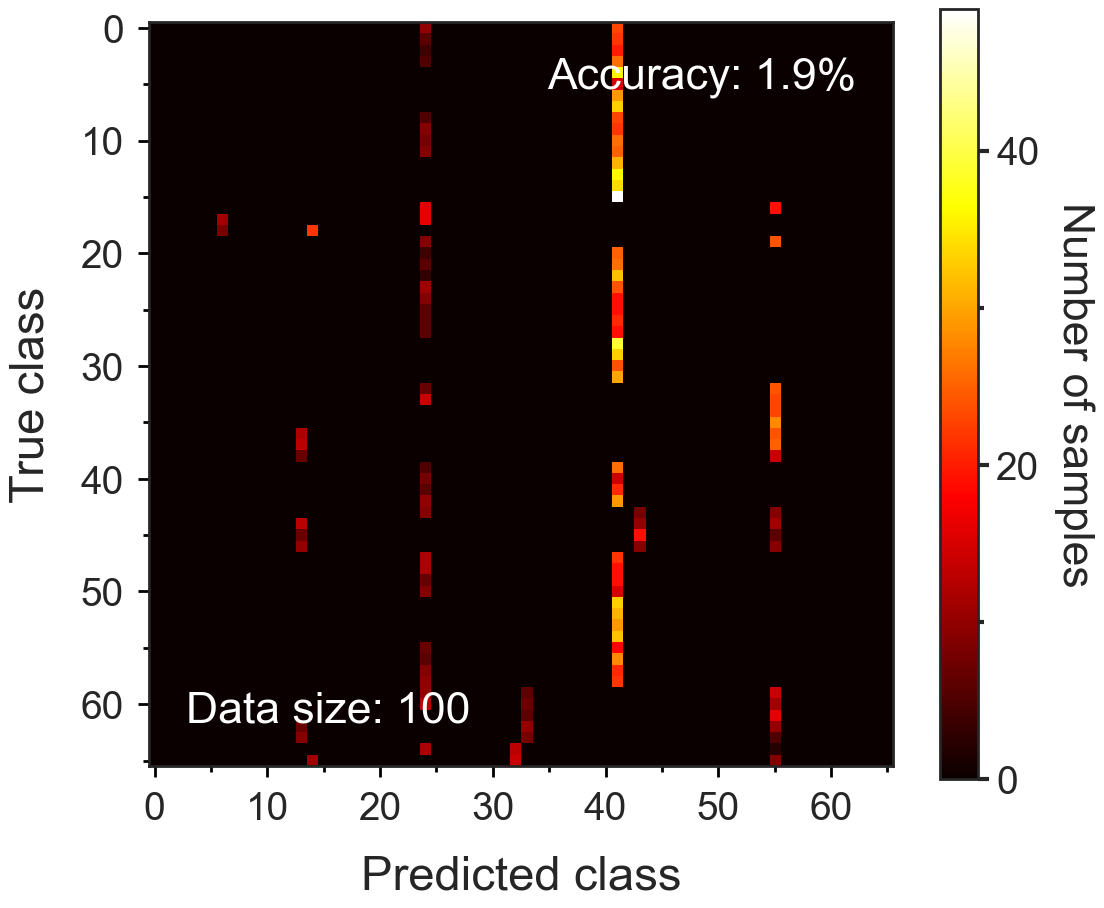

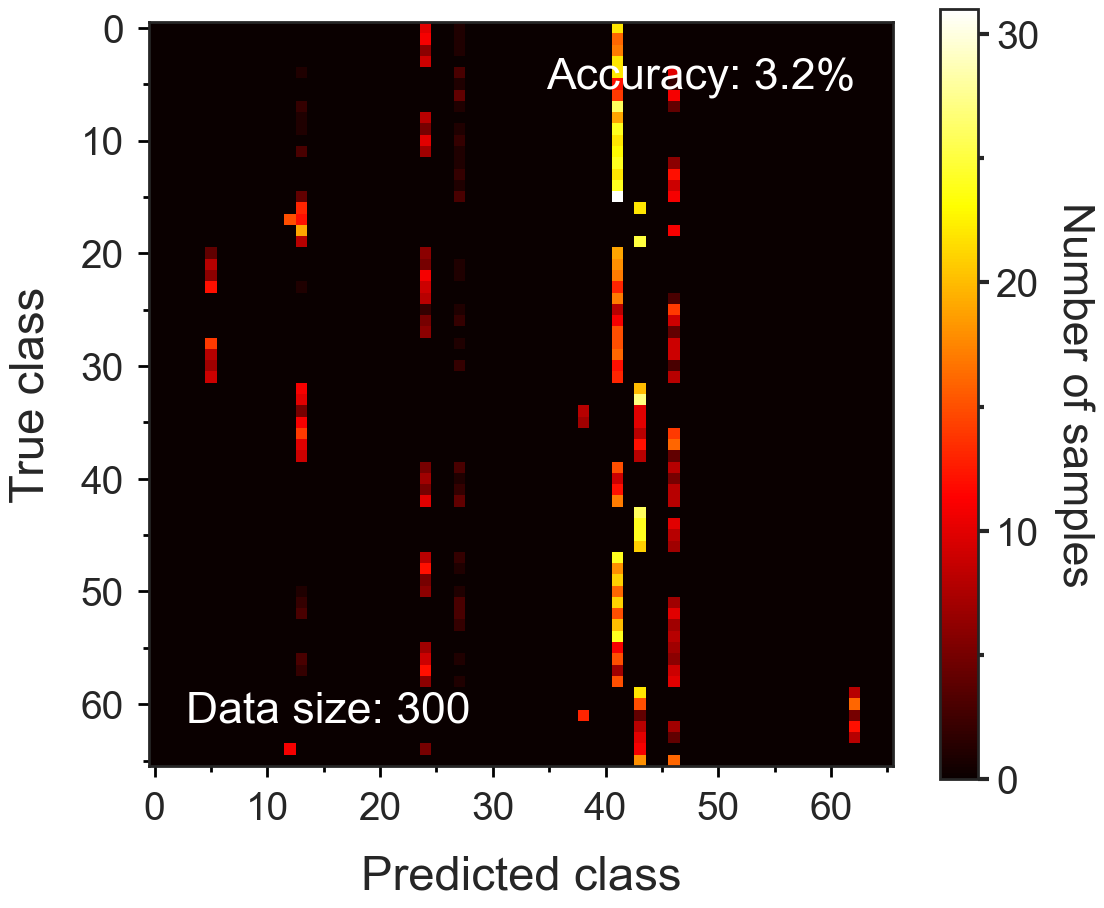

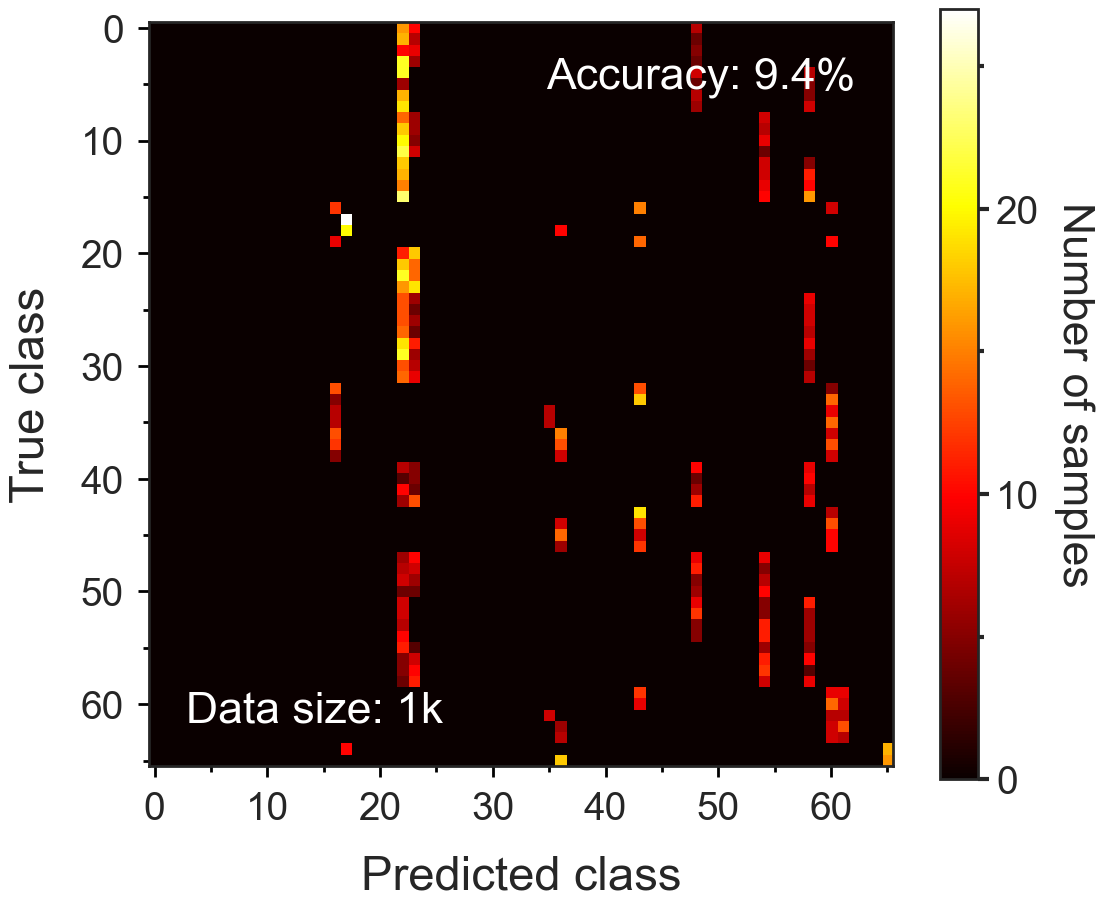

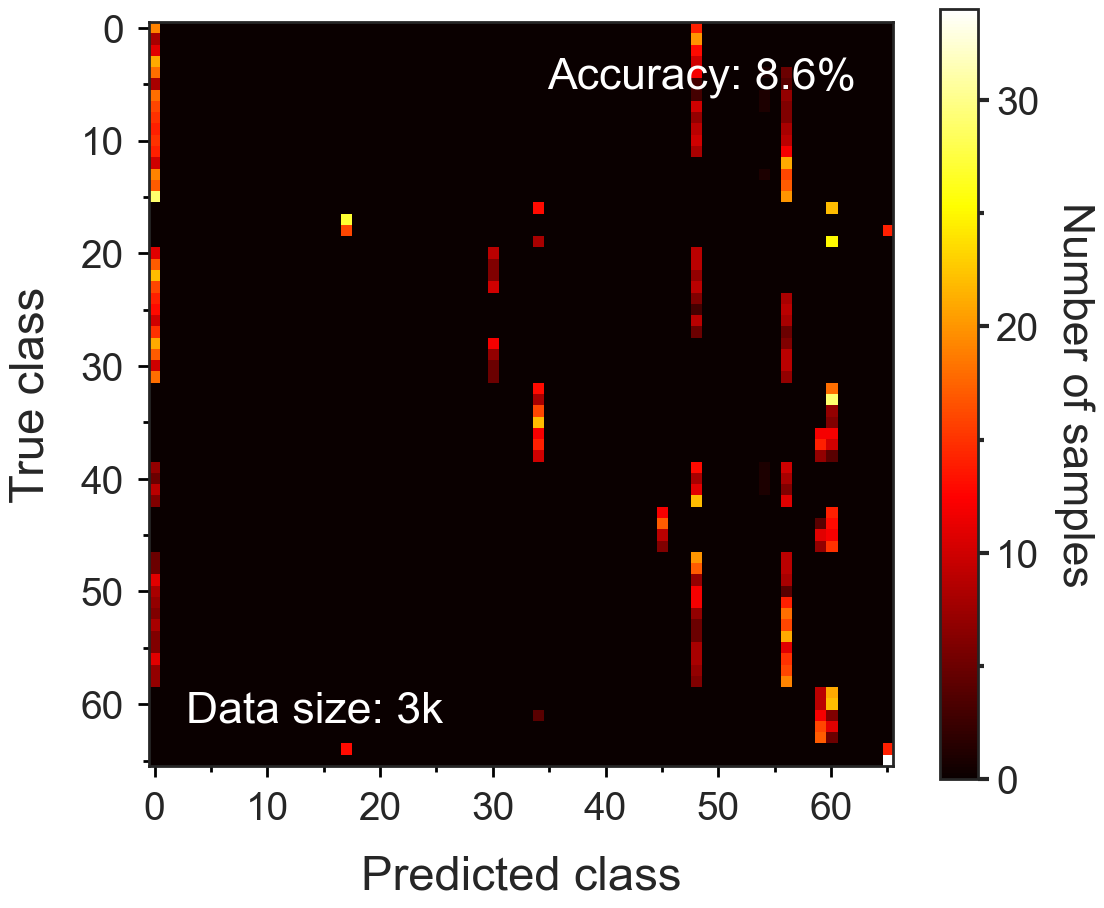

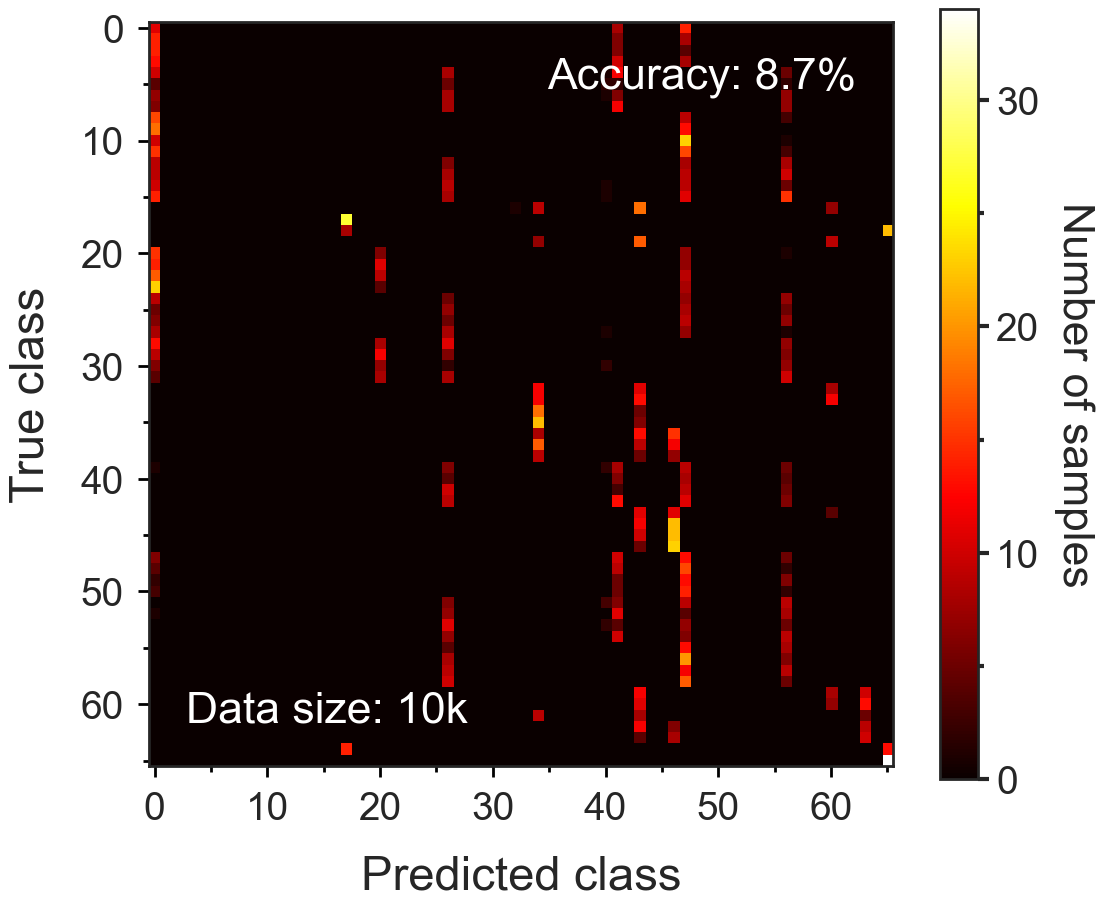

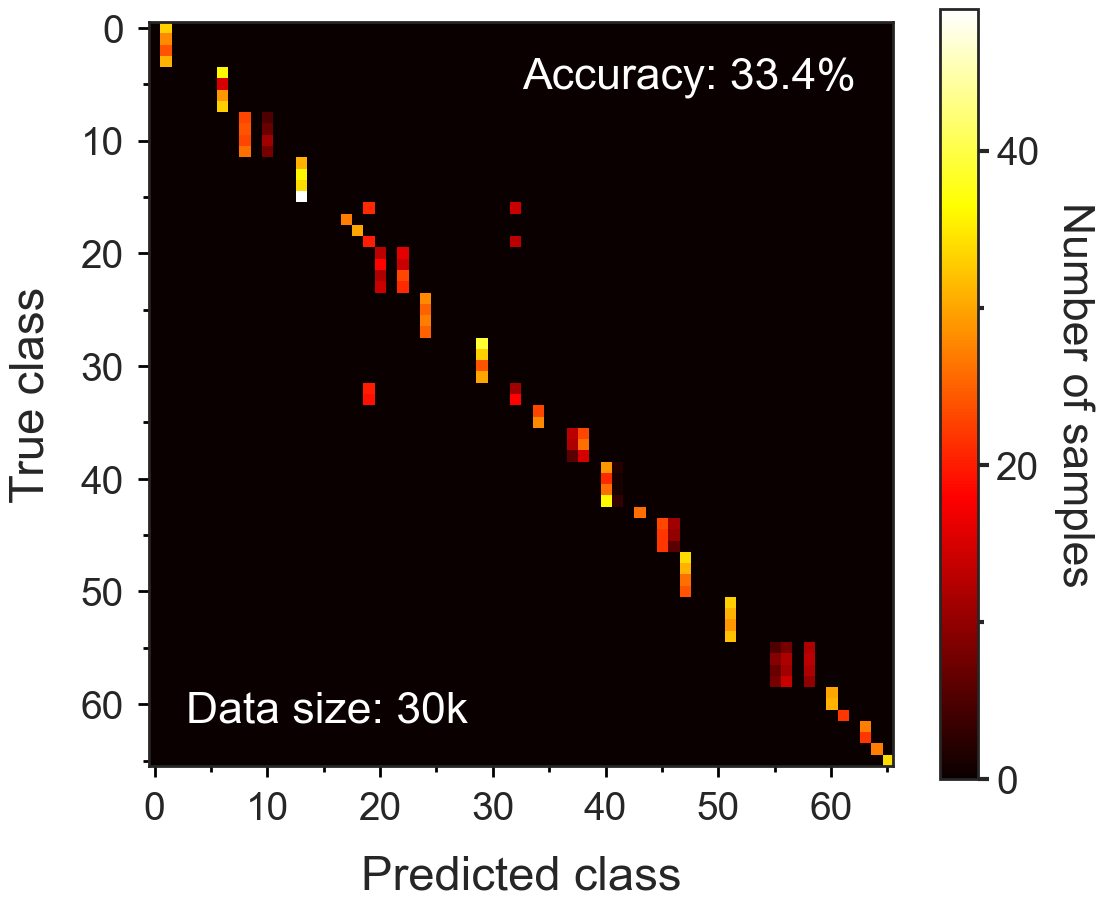

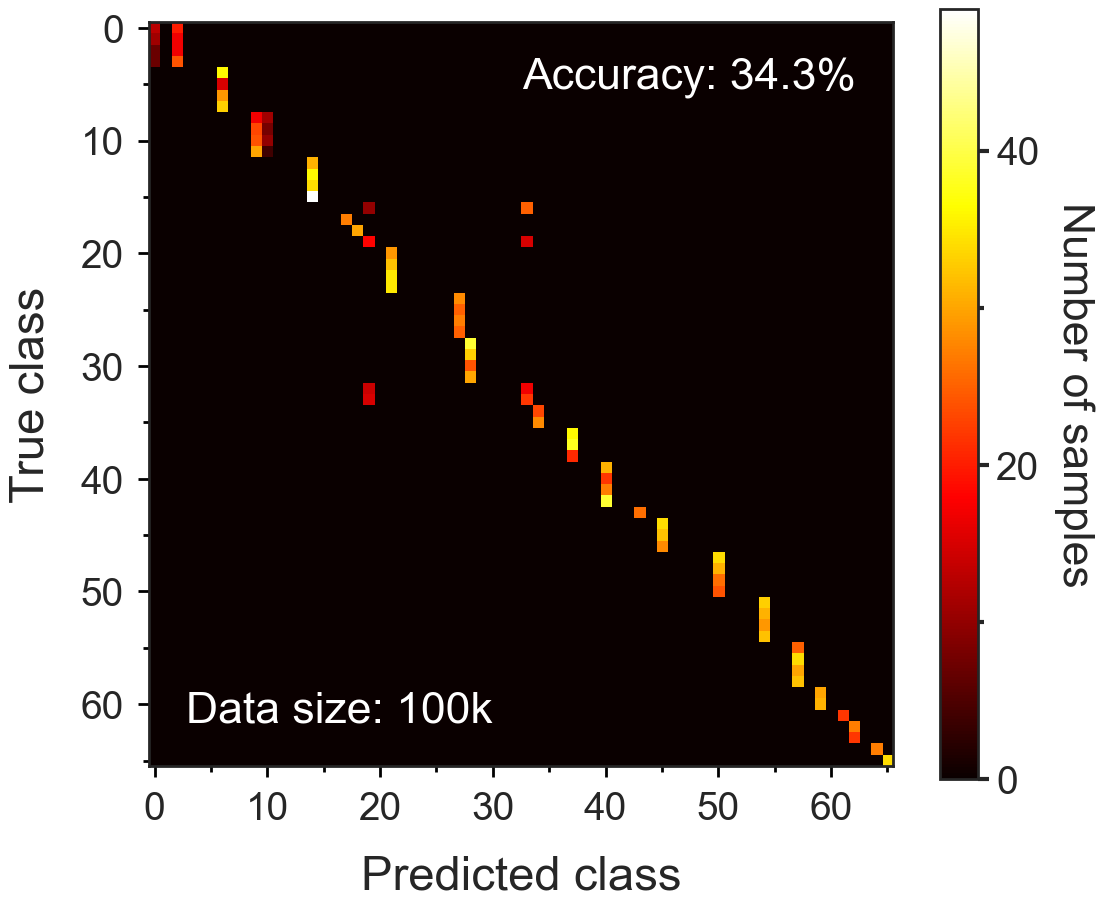

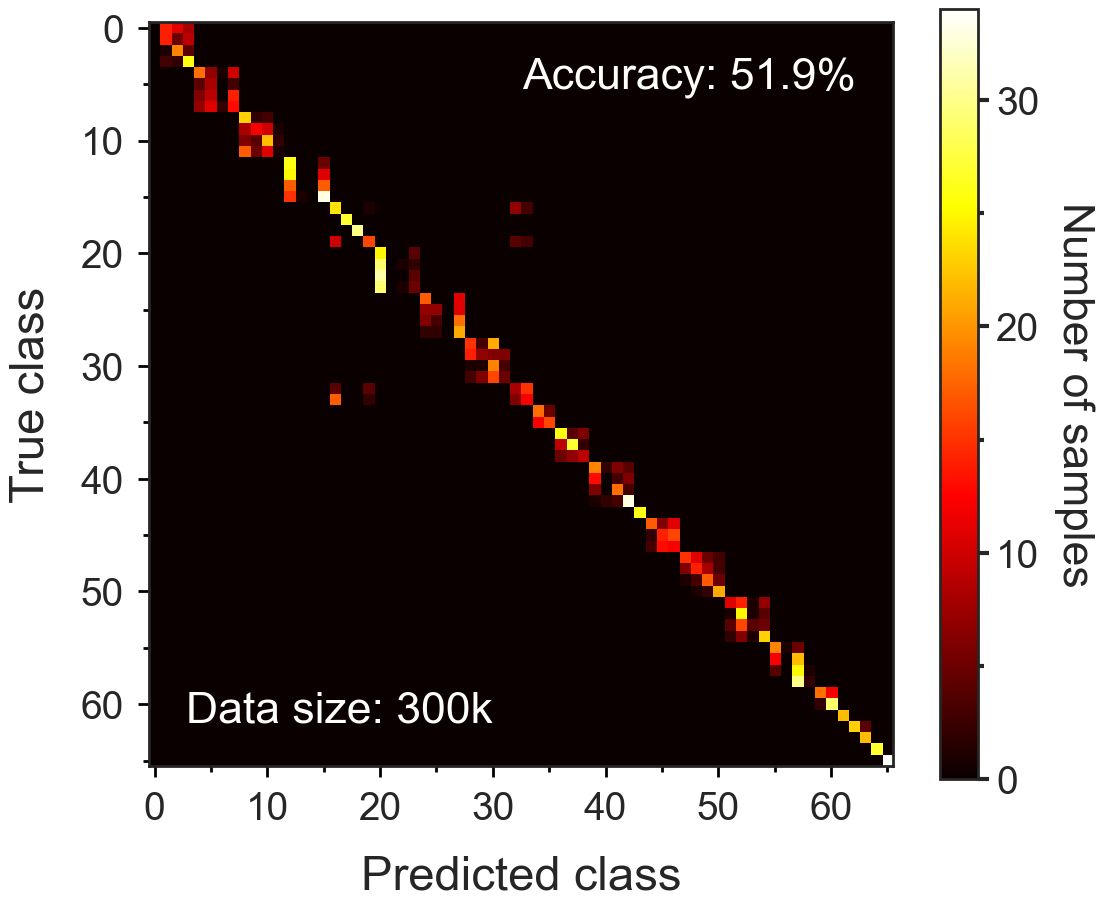

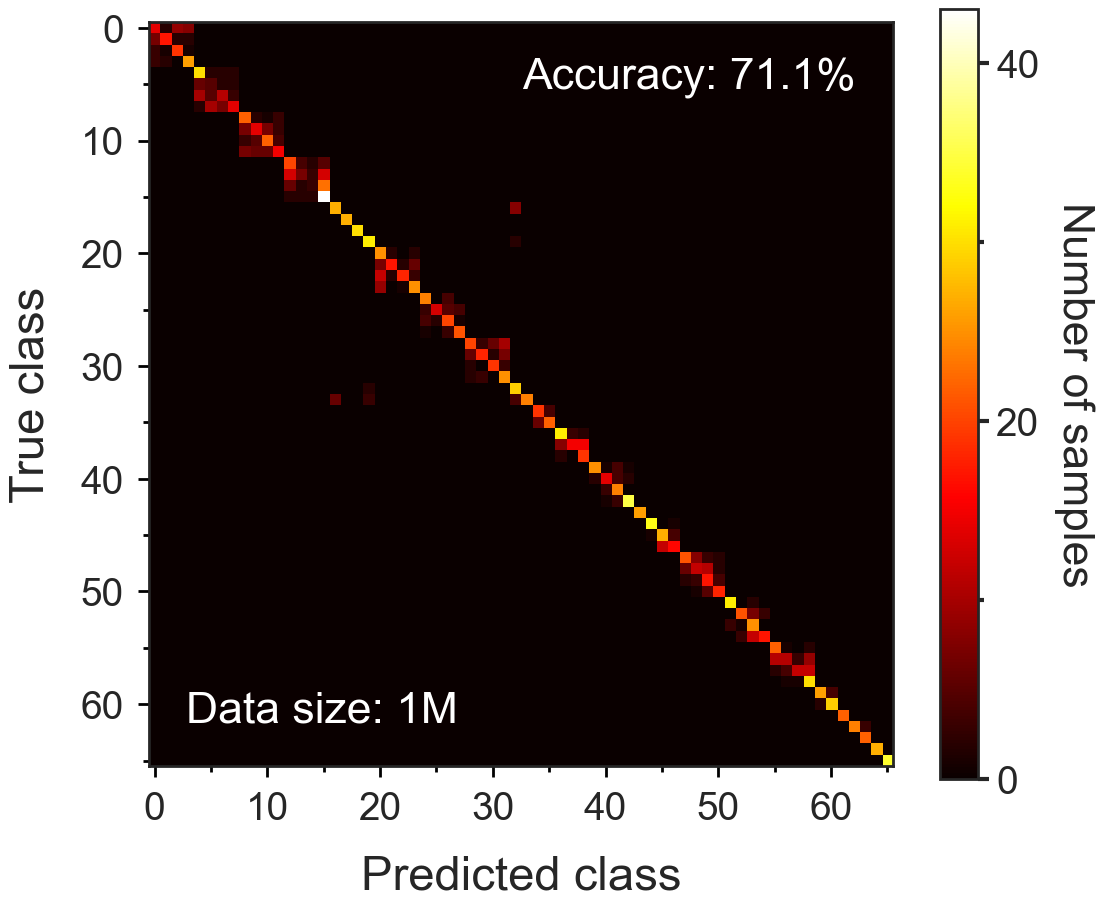

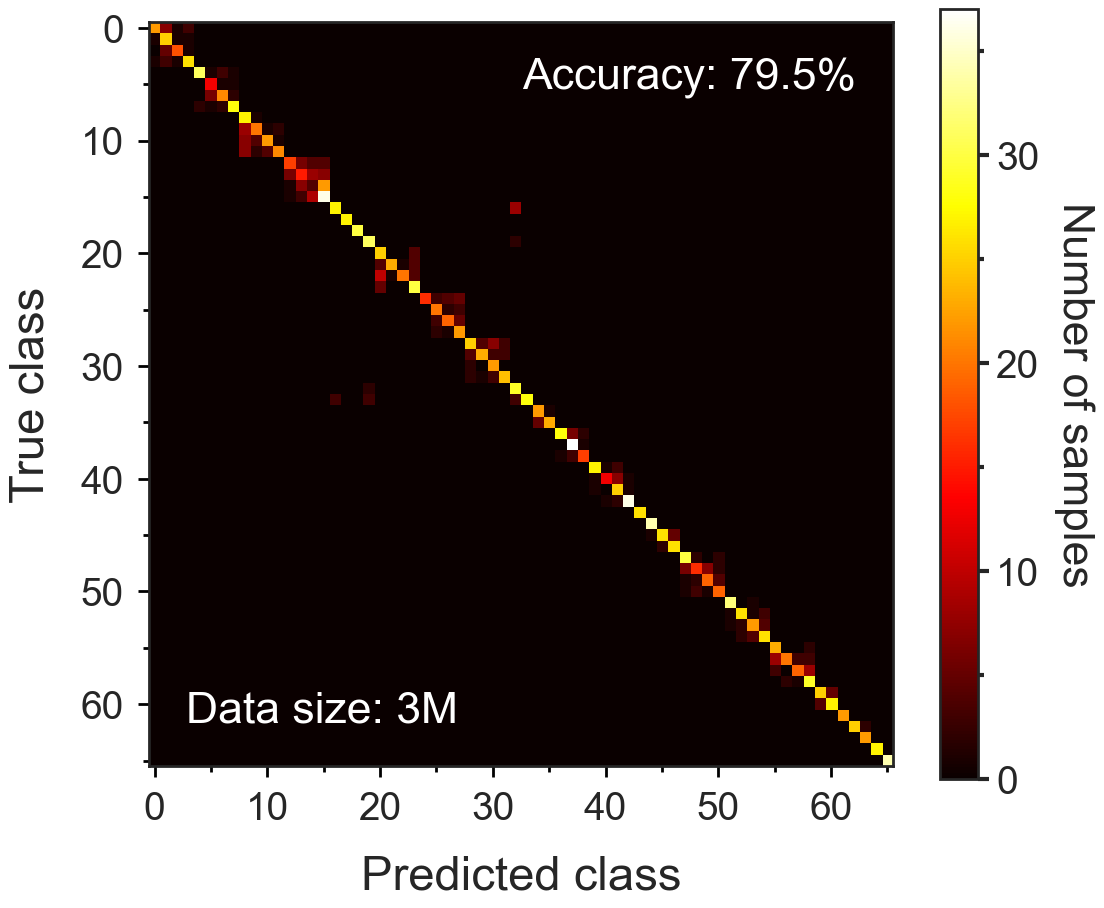

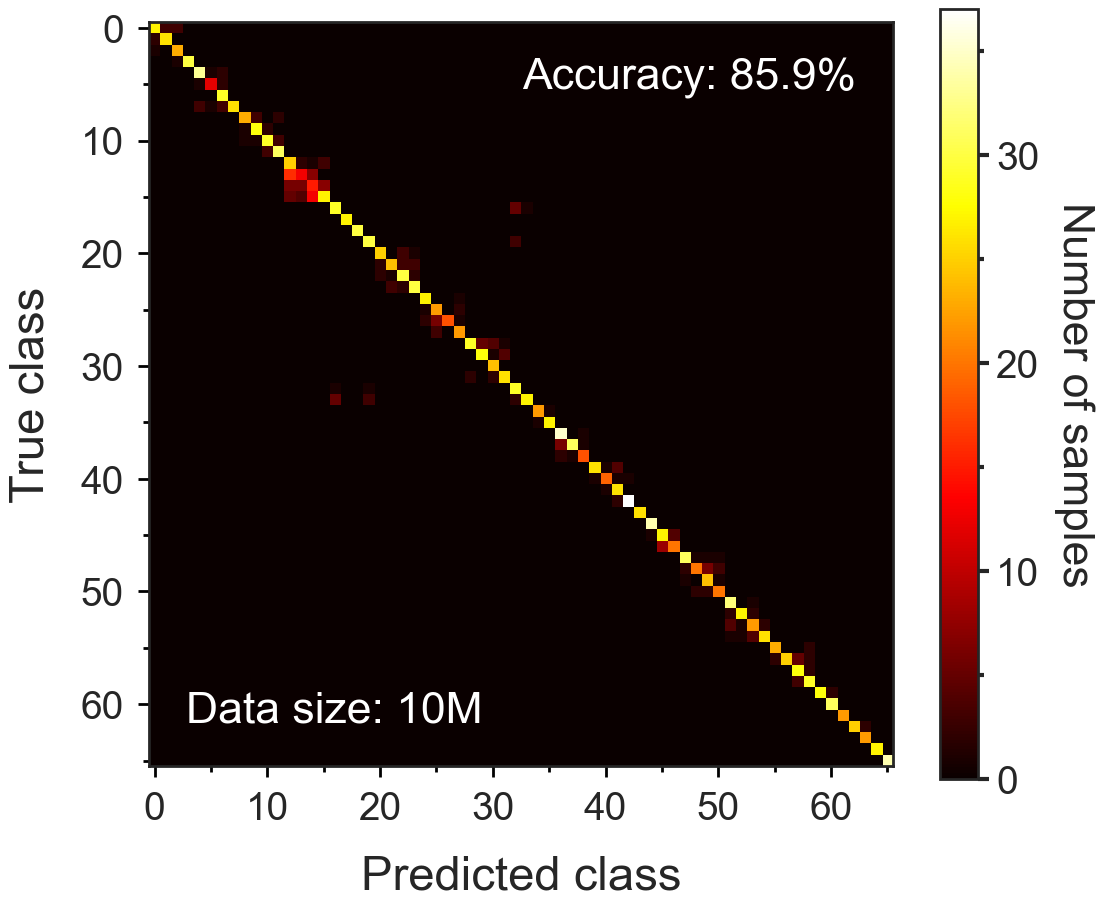

In [43]:
model_folder = '20241012 single phase orientation full prompt 20'
cif_folder = os.path.join(folder, 'cif')
visual_embedding_dim = 20
prompt_type_list = ['full']

with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
    
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

for sample_size in [1e2,3e2,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6,1e7]:
    for prompt_type in prompt_type_list:
        
        model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', 
                                                                            model_folder, '{}'.format(int(sample_size)))).to('cuda')

        y_true, y_pred, y_formula, y_pred_full = [], [], [], []

        for i in range(len(element_list)):

            Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
            X_prompts = []
            random.shuffle(element_list[i])
            if prompt_type == None:
                X_prompts.append('')
            elif prompt_type == 'eds':
                X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
            elif prompt_type == 'full':
                X_prompts.append(' '.join(element_list[i]))

            visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
            visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

            inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
            inputs.update(
                {
                    "visual_embeds": visual_embeds,
                    "visual_token_type_ids": visual_token_type_ids,
                    "visual_attention_mask": visual_attention_mask,
                }
            )

            labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

            outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
            logits = outputs.logits
            y_true.append(np.array(labels).argmax(-1)[0])
            y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
            y_pred_full.append(np.array(logits.detach().cpu()[0]))
            y_formula.append(formula_list[i])

            print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])

        y_pred_full = np.array(y_pred_full)

        report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
        matrix = confusion_matrix(y_true, y_pred)
        
        load_plt_setting()
        fig, ax = plt.subplots(figsize=(12, 10))

        mat = ax.matshow(matrix, cmap='hot')
        ax.xaxis.set_ticks_position('bottom')
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
        ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
        ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
        # ax.axes.set_xlim([450,950])
        # ax.axes.set_ylim([0,5])
        # # ax.set_xscale('log')

        cbar = plt.colorbar(mat)
        cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
        cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
        cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
        cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

        ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
        ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

        plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
                 transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
        if sample_size%1000000 == 0:
            data_size = str(int(sample_size//1000000))+'M'
        elif sample_size%1000 == 0:
            data_size = str(int(sample_size//1000))+'k'
        else:
            data_size = int(sample_size)
        plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

        plt.savefig(os.path.join(folder, 'models', model_folder, 'classification_{}_{}.png'.format(str(prompt_type),int(sample_size))), 
                    format='png', dpi=300, transparent=True, bbox_inches='tight')

## Fig 2a-c

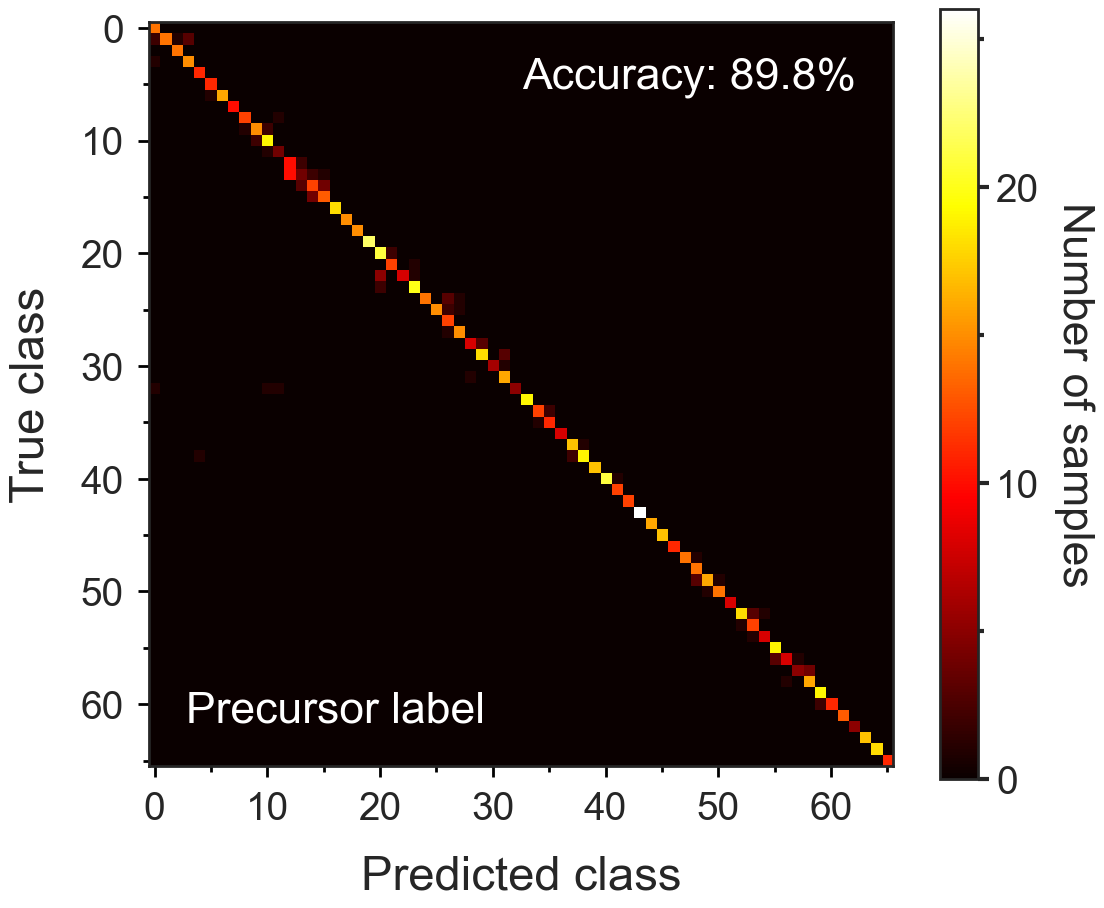

In [16]:
load_plt_setting()

report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(12, 10))

mat = ax.matshow(matrix, cmap='hot')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
# ax.axes.set_xlim([450,950])
# ax.axes.set_ylim([0,5])
# # ax.set_xscale('log')

cbar = plt.colorbar(mat)
cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
         transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
plt.text(0.05, 0.06, 'Precursor label', fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

plt.savefig(os.path.join(folder, 'models', model_folder, 'classification_Precursor.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Fig 2e

In [313]:
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        print(i,'\t',str(y_true[i])+'\t'+dataloader.dataset[dataloader.sample_list[y_true[i]]]['formula']+'\t\t'+str(y_pred[i])+'\t'+
             dataloader.dataset[dataloader.sample_list[y_pred[i]]]['formula'])

1 	 49	MA0.6FA0.4PbBr3		48	MA0.4FA0.6PbBr3
3 	 0	Cs0.2FA0.8PbBr3		26	CsPb(I0.6Br0.4)3
16 	 31	CsPb(I0.8Cl0.2)3		36	alpha-CsPbI3
20 	 5	Cs0.4FA0.6PbI3		16	Cs4PbBr6
22 	 35	cubic-CsPbCl3		22	CsPb(Cl0.6Br0.4)3
23 	 32	cubic-CsPbBr3		25	CsPb(I0.4Br0.6)3
24 	 15	Cs0.8MA0.2PbI3		36	alpha-CsPbI3
27 	 59	cubic-MAPbBr3		55	MAPb(Br0.2I0.8)3
28 	 29	CsPb(I0.4Cl0.6)3		27	CsPb(I0.8Br0.2)3
34 	 48	MA0.4FA0.6PbBr3		10	Cs0.6MA0.4PbBr3
38 	 10	Cs0.6MA0.4PbBr3		3	Cs0.8FA0.2PbBr3
39 	 56	MAPb(Br0.4I0.6)3		55	MAPb(Br0.2I0.8)3
44 	 10	Cs0.6MA0.4PbBr3		3	Cs0.8FA0.2PbBr3
46 	 32	cubic-CsPbBr3		26	CsPb(I0.6Br0.4)3
48 	 13	Cs0.4MA0.6PbI3		15	Cs0.8MA0.2PbI3
49 	 3	Cs0.8FA0.2PbBr3		27	CsPb(I0.8Br0.2)3
51 	 15	Cs0.8MA0.2PbI3		36	alpha-CsPbI3
55 	 10	Cs0.6MA0.4PbBr3		25	CsPb(I0.4Br0.6)3
56 	 48	MA0.4FA0.6PbBr3		10	Cs0.6MA0.4PbBr3
57 	 56	MAPb(Br0.4I0.6)3		31	CsPb(I0.8Cl0.2)3
59 	 9	Cs0.4MA0.6PbBr3		15	Cs0.8MA0.2PbI3
60 	 56	MAPb(Br0.4I0.6)3		55	MAPb(Br0.2I0.8)3
63 	 32	cubic-CsPbBr3		15	Cs0.8MA0.2PbI3
65 	 30	CsPb

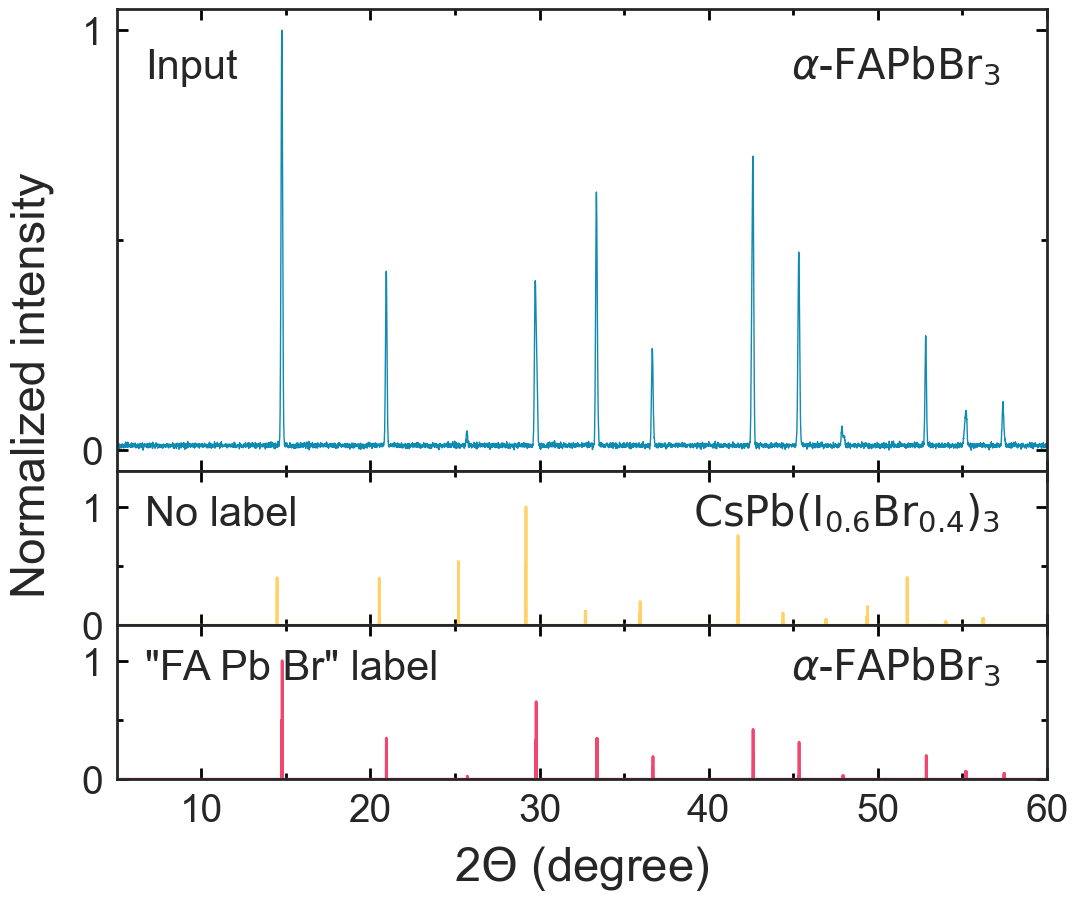

In [314]:
load_plt_setting()

twotheta = np.arange(5.00, 60.01, 0.01)
data1 = Xs[604,:,0]
data2 = dataloader.load_ref(26)
data3 = dataloader.load_ref(43)

alpha = 0.7

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 1, 1]),figsize=(12, 10))
mat1 = ax0.plot(twotheta, data1, linewidth=1, color=colors.to_rgba('#118ab2'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.05])

mat2 = ax1.plot(twotheta, data2, linewidth=2, color=colors.to_rgba('#ffd166'))
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.3])

mat2 = ax2.plot(twotheta, data3, linewidth=2, color=colors.to_rgba('#ef476f'))
ax2.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.axes.set_ylim([0,1.3])
# ax2.axes.set_xlim([22.5,30])
ax2.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.03, 0.85, 'Input', fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.95, 0.85, r'$\alpha$'+'-'+r'$\mathrm{FAPbBr_{3}}$', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.03, 0.65, 'No label', fontsize=30, transform=ax1.transAxes, horizontalalignment='left')
plt.text(0.95, 0.65, r'$\mathrm{CsPb(I_{0.6}Br_{0.4})_{3}}$', fontsize=30, transform=ax1.transAxes, horizontalalignment='right')

plt.text(0.03, 0.65, '"FA Pb Br" label', fontsize=30, transform=ax2.transAxes, horizontalalignment='left')
plt.text(0.95, 0.65, r'$\alpha$'+'-'+r'$\mathrm{FAPbBr_{3}}$', fontsize=30, transform=ax2.transAxes, horizontalalignment='right')

# plt.text(0.96, 0.75, 'n = 1000', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Normalized intensity                      ', labelpad=20, fontsize=34)
plt.savefig(os.path.join(folder, 'models', model_folder, 'Wrong_prediction.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Fig 2d

In [20]:
default_label_pred = y_pred

In [25]:
FAPbI_pred = y_pred

In [37]:
CsPbIBr_pred = y_pred

In [76]:
np.savetxt(os.path.join(folder, 'models', model_folder, 'Probability_vs_prompt.csv'),  
               np.swapaxes(np.asarray([default_label_pred,FAPbI_pred,CsPbIBr_pred]),0,1), 
               header='Default prompt / FA-Pb-I prompt / Cs-Pb-I-Br prompt',)

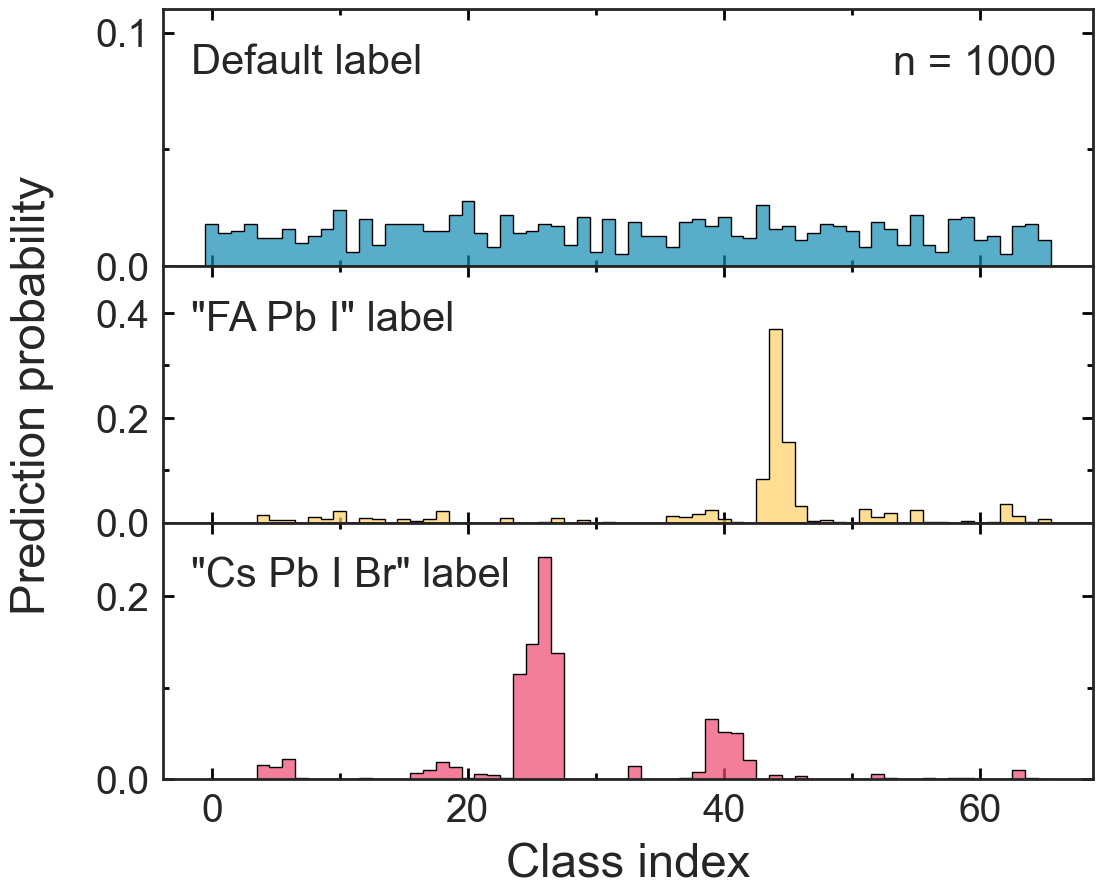

In [315]:
load_plt_setting()

sample_names = ['Default label','"FA Pb I" label','"Cs Pb I Br" label']

data1 = default_label_pred
data2 = FAPbI_pred
data3 = CsPbIBr_pred
# samples = [r'TiO$_{2}$ 0 mol% K$^{+}$',r'TiO$_{2}$ 10 mol% K$^{+}$',r'SnO$_{2}$ 0 mol% K$^{+}$',r'SnO$_{2}$ 10 mol% K$^{+}$']

wav_range = (-0.5,65.5)
bins = round((wav_range[1]-wav_range[0])*1)
alpha = 0.7

kwargs1 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#118ab2')[:-1]+(alpha,))
kwargs2 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#ffd166')[:-1]+(alpha,))
kwargs3 = dict(histtype='stepfilled', density=True, bins=bins, ec="black", range=wav_range, fc=colors.to_rgba('#ef476f')[:-1]+(alpha,))
# kwargs4 = dict(histtype='stepfilled', density=False, bins=bins, ec="black", range=wav_range, fc = colors.to_rgba('#118ab2')[:-1]+(alpha,))

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[1, 1, 1]),figsize=(12, 10))
mat1 = ax0.hist(data1, **kwargs1, label=sample_names[0], linewidth=1)
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([0,0.11])

mat2 = ax1.hist(data2, **kwargs2, label=sample_names[1], linewidth=1)
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,0.49])

mat2 = ax2.hist(data3, **kwargs3, label=sample_names[2], linewidth=1)
ax2.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax2.axes.set_ylim([0,0.28])

plt.text(0.03, 0.75, sample_names[0], fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, sample_names[1], fontsize=30, transform=ax1.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, sample_names[2], fontsize=30, transform=ax2.transAxes, horizontalalignment='left')

plt.text(0.96, 0.75, 'n = 1000', fontsize=30, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax2.set_xlabel(r'Class index', labelpad=10, fontsize=34)
ax1.set_ylabel(r'Prediction probability', labelpad=30, fontsize=34)
plt.savefig(os.path.join(folder, 'models', model_folder, 'Probability_vs_prompt.png'), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

# 2.2 Multi label classification

In [123]:
full_result = {}
prompt_type_list = ['none','eds','full']

for prompt_type in prompt_type_list:
    full_result[prompt_type] = {}
    
    for i in [2,3]:
        full_result[prompt_type]['{}'.format(i)] = {'labels':[], 'outputs':[], 'result':[]}

In [124]:
n = 3
file_name = 'test_dataset_{}phase.npy'.format(n)

try:
    with open(os.path.join(cif_folder, file_name), 'rb') as handle:
        test_dataset = joblib.load(handle)

    Xs, Ys, element_list, formula_list, _ = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
    print('test dataset loaded.')

except:
    Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=1000, n_mix=[n], resonable_mixing=resonable_mixing,
                                                              peak_probability_range=(1, 1), crystal_size_range=(5, 20), 
                                                              intensity_variation_range=(0.01, 1))
    test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

    with open(os.path.join(cif_folder, file_name), 'wb') as handle:
        joblib.dump(test_dataset, handle)
    print('test dataset generated.')


test dataset loaded.


In [125]:
for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, result = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == 'none':
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(Ys[i:i+1]).to(dtype=torch.float32)
        outputs = model(**inputs.to('cuda'), output_attentions=True)

        full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['labels'].append(np.array(Ys[i:i+1])[0])
        full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['outputs'].append(np.array(outputs.logits.detach().cpu())[0])

        labels = np.array(labels[0].nonzero().view(-1))
        logits = torch.topk(outputs.logits[0], len(labels)).indices

        y_true.append(list(labels))
        y_pred.append(list(np.array(logits.detach().cpu())))

        if set(y_true[-1]) == set(y_pred[-1]):
            result.append(0)
            full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['result'].append(0)
        else:
            result.append(1)
            full_result[prompt_type]['{}'.format(int(np.sum(Ys[i:i+1])))]['result'].append(1)

        y_formula.append(formula_list[i])

        print(i,y_formula[-1],y_true[-1],y_pred[-1])

    result = np.array(result)

0 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48, 59, 60] [59, 43, 49]
1 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
2 ['Cs4PbBr6', 'CsPb2Br5', 'CsBr'] [16, 17, 19] [19, 16, 17]
3 ['alpha-CsPbI3', 'delta-CsPbI3', 'PbI2'] [36, 37, 65] [65, 37, 36]
4 ['cubic-CsPbBr3', 'CsPb(I0.8Br0.2)3', 'PbI2'] [27, 32, 65] [27, 32, 65]
5 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 59, 60]
6 ['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3', 'delta-FAPbI3'] [46, 51, 52] [51, 44, 52]
7 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 59, 60]
8 ['PbI2', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58, 60, 65] [65, 34, 58]
9 ['beta-FAPbI3', 'PbI2', 'MA0.4FA0.6PbI3'] [45, 52, 65] [45, 52, 65]
10 ['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3', 'CsPb(Cl0.2Br0.8)3'] [20, 23, 32] [0, 3, 32]
11 ['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'orthorhombic-CsPbBr3'] [10, 32, 33] [33, 32, 9]
12 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 60

118 ['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44, 45, 46] [44, 45, 46]
119 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 60, 59]
120 ['FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3', 'beta-FAPbI3'] [40, 42, 45] [45, 51, 46]
121 ['tetragonal-MAPbI3', 'PbI2', 'beta-FAPbI3'] [45, 63, 65] [63, 64, 17]
122 ['PbI2', 'alpha-CsPbI3', 'delta-CsPbI3'] [36, 37, 65] [36, 65, 37]
123 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 59, 64]
124 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [65, 45, 44]
125 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [59, 64, 60]
126 ['alpha-CsPbI3', 'cubic-CsPbCl3', 'gamma-CsPbI3'] [35, 36, 38] [38, 36, 15]
127 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16, 17, 33] [38, 37, 33]
128 ['CsBr', 'orthorhombic-CsPbBr3', 'PbBr2'] [17, 33, 64] [64, 33, 17]
129 ['Cs0.6FA0.4PbI3', 'beta-FAPbI3', 'delta-CsPbI3'] [6, 37, 45] [7, 37, 45]
130 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58, 59, 62] [65, 59

225 ['MA0.8FA0.2PbBr3', 'PbBr2', 'MA0.6FA0.4PbBr3'] [49, 50, 64] [64, 60, 50]
226 ['Cs0.4FA0.6PbI3', 'CsI', 'PbI2'] [5, 18, 65] [5, 65, 44]
227 ['cubic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.8Br0.2)3'] [22, 23, 32] [32, 17, 43]
228 ['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16, 17, 32] [17, 16, 32]
229 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44, 45, 65] [45, 65, 44]
230 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28, 37, 38] [38, 46, 37]
231 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3'] [22, 34, 35] [34, 32, 22]
232 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [10, 59, 60] [10, 60, 59]
233 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44, 46, 65] [65, 44, 46]
234 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 32, 33] [33, 16, 32]
235 ['Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3'] [21, 34, 35] [34, 35, 22]
236 ['Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [9, 10, 19] [19, 10, 9]
237 ['Cs0.2MA0.8PbI3', 'gamma-CsPbI3', 'tetragonal-MAPbI

335 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44, 46, 65] [46, 44, 65]
336 ['CsI', 'gamma-CsPbI3', 'alpha-CsPbI3'] [18, 36, 38] [36, 38, 18]
337 ['PbBr2', 'Cs0.8MA0.2PbBr3', 'cubic-MAPbBr3'] [11, 59, 64] [11, 64, 59]
338 ['alpha-MAPbI3', 'MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3'] [52, 53, 62] [53, 52, 62]
339 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62, 63, 65] [65, 62, 63]
340 ['Cs4PbBr6', 'tetragonal-MAPbBr3', 'CsBr'] [16, 17, 60] [16, 17, 22]
341 ['CsPb(I0.8Cl0.2)3', 'PbI2', 'Pnma-CsPbCl3'] [31, 34, 65] [34, 31, 65]
342 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'alpha-FAPbI3'] [5, 7, 44] [7, 5, 44]
343 ['alpha-CsPbI3', 'gamma-CsPbI3', 'PbI2'] [36, 38, 65] [38, 36, 65]
344 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'alpha-MAPbI3'] [59, 60, 62] [59, 60, 62]
345 ['PbBr2', 'Cs0.8MA0.2PbBr3', 'Cs4PbBr6'] [11, 16, 64] [64, 16, 32]
346 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [65, 44, 45]
347 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3'] [55, 57, 58] [58, 57, 65]
348 ['Cs

446 ['gamma-CsPbI3', 'CsPb(I0.6Br0.4)3', 'Cs4PbBr6'] [16, 26, 38] [16, 26, 64]
447 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45, 46, 65] [45, 65, 46]
448 ['CsPb(I0.4Br0.6)3', 'CsI', 'PbBr2'] [18, 25, 64] [25, 64, 32]
449 ['delta-FAPbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 46] [46, 45, 44]
450 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45, 46, 65] [65, 45, 46]
451 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62, 63, 65] [62, 63, 65]
452 ['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'PbBr2'] [10, 60, 64] [64, 60, 10]
453 ['PbBr2', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16, 32, 64] [64, 32, 16]
454 ['cubic-FAPbBr3', 'delta-FAPbI3', 'PbI2'] [43, 46, 65] [65, 45, 46]
455 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [65, 63, 62]
456 ['MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3'] [47, 48, 50] [59, 43, 48]
457 ['CsPb(Cl0.4Br0.6)3', 'PbBr2', 'cubic-CsPbBr3'] [21, 32, 64] [64, 32, 11]
458 ['cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3', 'cubic-CsPbBr3'] [3, 32, 43] [43, 32, 3]
459 ['MA0.6FA0

561 ['delta-FAPbI3', 'tetragonal-MAPbI3', 'beta-FAPbI3'] [45, 46, 63] [46, 45, 44]
562 ['delta-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18, 36, 37] [18, 36, 37]
563 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [47, 59, 60] [47, 59, 60]
564 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58, 59, 60] [59, 58, 60]
565 ['Cs0.8MA0.2PbI3', 'PbI2', 'CsI'] [15, 18, 65] [36, 65, 18]
566 ['cubic-FAPbBr3', 'PbI2', 'delta-FAPbI3'] [43, 46, 65] [65, 46, 43]
567 ['Cs0.2FA0.8PbBr3', 'CsBr', 'Cs0.4FA0.6PbBr3'] [0, 1, 17] [65, 62, 63]
568 ['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44, 45, 46] [46, 44, 45]
569 ['MA0.6FA0.4PbBr3', 'cubic-FAPbBr3', 'MA0.4FA0.6PbBr3'] [43, 48, 49] [43, 49, 50]
570 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'Cs0.6FA0.4PbBr3'] [2, 19, 33] [19, 33, 2]
571 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
572 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 59, 60]
573 ['CsI', 'CsPb(I0.2Br0.8)3', 'alpha-CsPbI3'] [18

668 ['MAPb(Br0.2I0.8)3', 'PbBr2', 'MAPb(Br0.6I0.4)3'] [55, 57, 64] [55, 64, 57]
669 ['CsI', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [6, 7, 18] [6, 18, 7]
670 ['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44, 46, 65] [65, 46, 44]
671 ['CsI', 'PbI2', 'alpha-CsPbI3'] [18, 36, 65] [36, 65, 18]
672 ['PbI2', 'delta-CsPbI3', 'CsI'] [18, 37, 65] [65, 39, 18]
673 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [62, 63, 65]
674 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [65, 63, 62]
675 ['CsBr', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3'] [17, 33, 43] [43, 33, 25]
676 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36, 37, 65] [65, 37, 36]
677 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [47, 60, 64] [64, 43, 49]
678 ['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'alpha-FAPbI3'] [39, 41, 44] [39, 44, 45]
679 ['cubic-CsPbCl3', 'Pnma-CsPbCl3', 'orthorhombic-CsPbBr3'] [33, 34, 35] [33, 17, 32]
680 ['CsPb2Br5', 'PbBr2', 'CsBr'] [17, 19, 64] [64, 17, 19]
681 ['Cs0.4FA0.6PbI3', 'Cs0.2FA0.8Pb

782 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62, 63, 65] [62, 63, 65]
783 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [62, 65, 63]
784 ['CsPb(Cl0.6Br0.4)3', 'cubic-CsPbBr3', 'CsPb2Br5'] [19, 22, 32] [32, 19, 22]
785 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45, 46, 65] [45, 65, 46]
786 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45, 46, 65] [65, 46, 45]
787 ['cubic-CsPbCl3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3'] [23, 33, 35] [33, 43, 17]
788 ['CsPb(Cl0.2Br0.8)3', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16, 20, 33] [64, 33, 16]
789 ['CsBr', 'CsPb2Br5', 'PbBr2'] [17, 19, 64] [19, 64, 17]
790 ['PbI2', 'MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46, 52, 65] [46, 45, 65]
791 ['orthorhombic-CsPbBr3', 'PbBr2', 'alpha-CsPbI3'] [33, 36, 64] [64, 0, 33]
792 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 32, 33] [32, 33, 63]
793 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [60, 59, 64]
794 ['delta-CsPbI3', 'Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3'] [12, 13, 37] [37, 

898 ['cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3', 'cubic-CsPbBr3'] [3, 32, 43] [32, 43, 60]
899 ['beta-FAPbI3', 'delta-FAPbI3', 'FAPb(Br0.4I0.6)3'] [40, 45, 46] [40, 45, 46]
900 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'MA0.2FA0.8PbI3'] [51, 62, 63] [33, 59, 32]
901 ['PbBr2', 'CsPb(I0.2Br0.8)3', 'CsPb(I0.6Br0.4)3'] [24, 26, 64] [64, 24, 65]
902 ['MA0.6FA0.4PbBr3', 'MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3'] [48, 49, 50] [49, 48, 50]
903 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr'] [17, 32, 33] [17, 33, 32]
904 ['CsPb2Br5', 'tetragonal-MAPbBr3', 'cubic-CsPbBr3'] [19, 32, 60] [32, 19, 65]
905 ['Cs0.2FA0.8PbI3', 'delta-CsPbI3', 'delta-FAPbI3'] [4, 37, 46] [4, 37, 38]
906 ['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'MA0.6FA0.4PbI3'] [46, 51, 53] [46, 51, 53]
907 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 59, 64]
908 ['Cs0.4MA0.6PbI3', 'CsI', 'Cs0.2MA0.8PbI3'] [12, 13, 18] [13, 12, 14]
909 ['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'Cs0.4FA0.6PbI3'] [5, 6, 7] [7, 51, 6]
910 ['CsI', 'CsPb(I0.2Cl

8 ['PbI2', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58, 60, 65] [65, 58, 60]
9 ['beta-FAPbI3', 'PbI2', 'MA0.4FA0.6PbI3'] [45, 52, 65] [45, 52, 65]
10 ['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3', 'CsPb(Cl0.2Br0.8)3'] [20, 23, 32] [32, 20, 35]
11 ['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'orthorhombic-CsPbBr3'] [10, 32, 33] [33, 9, 32]
12 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 60, 59]
13 ['gamma-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13, 38, 65] [38, 36, 44]
14 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44, 45, 65] [65, 44, 45]
15 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44, 45, 65] [45, 65, 44]
16 ['beta-FAPbI3', 'cubic-FAPbBr3', 'PbI2'] [43, 45, 65] [65, 64, 62]
17 ['Cs4PbBr6', 'CsBr', 'Cs0.8MA0.2PbBr3'] [11, 16, 17] [16, 17, 11]
18 ['alpha-CsPbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [6, 36, 37] [36, 6, 37]
19 ['alpha-CsPbI3', 'Cs4PbBr6', 'PbBr2'] [16, 36, 64] [16, 64, 18]
20 ['Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3', 'alpha-MAPbI3'] [12, 13, 62] [13, 12, 14]
21 ['Cs0.2FA0.8PbBr

120 ['FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3', 'beta-FAPbI3'] [40, 42, 45] [40, 45, 46]
121 ['tetragonal-MAPbI3', 'PbI2', 'beta-FAPbI3'] [45, 63, 65] [63, 45, 44]
122 ['PbI2', 'alpha-CsPbI3', 'delta-CsPbI3'] [36, 37, 65] [36, 65, 37]
123 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
124 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [65, 45, 44]
125 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59, 60, 64] [60, 59, 64]
126 ['alpha-CsPbI3', 'cubic-CsPbCl3', 'gamma-CsPbI3'] [35, 36, 38] [36, 38, 31]
127 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16, 17, 33] [33, 16, 17]
128 ['CsBr', 'orthorhombic-CsPbBr3', 'PbBr2'] [17, 33, 64] [64, 33, 17]
129 ['Cs0.6FA0.4PbI3', 'beta-FAPbI3', 'delta-CsPbI3'] [6, 37, 45] [37, 45, 7]
130 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58, 59, 62] [65, 59, 58]
131 ['alpha-CsPbI3', 'PbI2', 'delta-CsPbI3'] [36, 37, 65] [36, 37, 65]
132 ['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36, 38, 65] [65, 38, 18]
133 ['cub

230 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28, 37, 38] [38, 28, 37]
231 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3'] [22, 34, 35] [34, 32, 22]
232 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [10, 59, 60] [10, 60, 59]
233 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44, 46, 65] [65, 44, 46]
234 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 32, 33] [33, 16, 32]
235 ['Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3'] [21, 34, 35] [34, 35, 22]
236 ['Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [9, 10, 19] [19, 10, 11]
237 ['Cs0.2MA0.8PbI3', 'gamma-CsPbI3', 'tetragonal-MAPbI3'] [12, 38, 63] [63, 38, 13]
238 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45, 46, 65] [65, 45, 46]
239 ['cubic-CsPbBr3', 'PbBr2', 'orthorhombic-CsPbBr3'] [32, 33, 64] [32, 33, 64]
240 ['CsPb(I0.4Cl0.6)3', 'cubic-CsPbCl3', 'alpha-CsPbI3'] [29, 35, 36] [36, 29, 28]
241 ['alpha-FAPbI3', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 44, 46] [44, 40, 46]
242 ['cubic-CsPbBr3

340 ['Cs4PbBr6', 'tetragonal-MAPbBr3', 'CsBr'] [16, 17, 60] [16, 17, 60]
341 ['CsPb(I0.8Cl0.2)3', 'PbI2', 'Pnma-CsPbCl3'] [31, 34, 65] [34, 31, 65]
342 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'alpha-FAPbI3'] [5, 7, 44] [7, 44, 5]
343 ['alpha-CsPbI3', 'gamma-CsPbI3', 'PbI2'] [36, 38, 65] [38, 36, 65]
344 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'alpha-MAPbI3'] [59, 60, 62] [59, 60, 62]
345 ['PbBr2', 'Cs0.8MA0.2PbBr3', 'Cs4PbBr6'] [11, 16, 64] [64, 32, 16]
346 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [65, 44, 45]
347 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3'] [55, 57, 58] [57, 58, 65]
348 ['Cs4PbBr6', 'PbI2', 'CsBr'] [16, 17, 65] [16, 65, 24]
349 ['PbBr2', 'CsPb2Br5', 'cubic-CsPbCl3'] [19, 35, 64] [64, 19, 20]
350 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [65, 62, 63]
351 ['Cs0.4FA0.6PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [1, 32, 33] [1, 33, 32]
352 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [5, 6, 7] [7, 6, 45]
353 ['Cs0.4

456 ['MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3'] [47, 48, 50] [59, 43, 48]
457 ['CsPb(Cl0.4Br0.6)3', 'PbBr2', 'cubic-CsPbBr3'] [21, 32, 64] [21, 64, 32]
458 ['cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3', 'cubic-CsPbBr3'] [3, 32, 43] [43, 32, 3]
459 ['MA0.6FA0.4PbBr3', 'MA0.8FA0.2PbBr3', 'tetragonal-MAPbBr3'] [49, 50, 60] [49, 50, 60]
460 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3', 'Pnma-CsPbCl3'] [19, 20, 34] [19, 34, 20]
461 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36, 37, 38] [38, 37, 36]
462 ['Cs4PbBr6', 'cubic-CsPbBr3', 'PbBr2'] [16, 32, 64] [64, 16, 32]
463 ['gamma-CsPbI3', 'alpha-CsPbI3', 'CsI'] [18, 36, 38] [18, 36, 38]
464 ['CsBr', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3'] [17, 23, 33] [23, 64, 17]
465 ['Cs4PbBr6', 'CsBr', 'orthorhombic-CsPbBr3'] [16, 17, 33] [16, 33, 17]
466 ['CsI', 'alpha-CsPbI3', 'delta-CsPbI3'] [18, 36, 37] [18, 36, 38]
467 ['orthorhombic-CsPbBr3', 'CsBr', 'PbBr2'] [17, 33, 64] [64, 33, 17]
468 ['CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3', 'CsPb(Cl0.8Br0.2)3']

569 ['MA0.6FA0.4PbBr3', 'cubic-FAPbBr3', 'MA0.4FA0.6PbBr3'] [43, 48, 49] [43, 49, 50]
570 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'Cs0.6FA0.4PbBr3'] [2, 19, 33] [19, 33, 2]
571 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 59, 64]
572 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 60, 59]
573 ['CsI', 'CsPb(I0.2Br0.8)3', 'alpha-CsPbI3'] [18, 24, 36] [17, 24, 26]
574 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [60, 59, 64]
575 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3', 'CsI'] [13, 18, 38] [18, 38, 65]
576 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 19, 33] [33, 19, 16]
577 ['Cs0.2MA0.8PbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [8, 10, 60] [60, 10, 17]
578 ['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36, 38, 65] [65, 38, 36]
579 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [64, 60, 59]
580 ['Cs0.8MA0.2PbI3', 'Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13, 14, 15] [14, 15, 36]
581 ['Cs4PbBr6', 'CsPb2Br5', 'Cs0.4FA0.6PbB

681 ['Cs0.4FA0.6PbI3', 'Cs0.2FA0.8PbI3', 'delta-CsPbI3'] [4, 5, 37] [4, 38, 46]
682 ['PbBr2', 'cubic-CsPbBr3', 'CsBr'] [17, 32, 64] [64, 17, 32]
683 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [65, 62, 63]
684 ['CsI', 'CsPb(I0.4Cl0.6)3', 'CsPb(I0.8Cl0.2)3'] [18, 29, 31] [31, 29, 18]
685 ['gamma-CsPbI3', 'delta-CsPbI3', 'PbI2'] [37, 38, 65] [38, 65, 37]
686 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [47, 50, 60] [50, 43, 60]
687 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [62, 65, 63]
688 ['CsBr', 'Cs0.2MA0.8PbBr3', 'cubic-CsPbBr3'] [8, 17, 32] [17, 32, 8]
689 ['tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.6MA0.4PbI3'] [13, 14, 63] [63, 12, 13]
690 ['PbI2', 'CsI', 'gamma-CsPbI3'] [18, 38, 65] [18, 38, 65]
691 ['CsPb(Cl0.4Br0.6)3', 'Cs4PbBr6', 'CsPb(Cl0.6Br0.4)3'] [16, 21, 22] [21, 22, 16]
692 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [65, 62, 63]
693 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39, 43, 44] [44, 39,

794 ['delta-CsPbI3', 'Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3'] [12, 13, 37] [37, 13, 14]
795 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [62, 65, 63]
796 ['Cs0.6MA0.4PbI3', 'Cs0.2MA0.8PbI3', 'delta-CsPbI3'] [12, 14, 37] [37, 36, 38]
797 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 60, 59]
798 ['MA0.4FA0.6PbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [48, 49, 59] [47, 59, 48]
799 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3'] [45, 46, 65] [65, 45, 46]
800 ['cubic-FAPbBr3', 'MA0.6FA0.4PbBr3', 'PbBr2'] [43, 49, 64] [43, 64, 47]
801 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3', 'PbI2'] [28, 36, 65] [36, 30, 65]
802 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62, 63, 65] [62, 63, 65]
803 ['alpha-FAPbI3', 'delta-FAPbI3', 'FAPb(Br0.8I0.2)3'] [42, 44, 46] [42, 46, 44]
804 ['beta-FAPbI3', 'MA0.4FA0.6PbI3', 'PbI2'] [45, 52, 65] [45, 65, 52]
805 ['PbI2', 'CsPb(I0.6Cl0.4)3', 'gamma-CsPbI3'] [30, 38, 65] [38, 30, 65]
806 ['CsI', 'PbI2', 'delta-CsPbI3'] [18, 37, 65] [37, 65, 18]
807 

904 ['CsPb2Br5', 'tetragonal-MAPbBr3', 'cubic-CsPbBr3'] [19, 32, 60] [32, 19, 2]
905 ['Cs0.2FA0.8PbI3', 'delta-CsPbI3', 'delta-FAPbI3'] [4, 37, 46] [4, 37, 38]
906 ['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'MA0.6FA0.4PbI3'] [46, 51, 53] [46, 51, 53]
907 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
908 ['Cs0.4MA0.6PbI3', 'CsI', 'Cs0.2MA0.8PbI3'] [12, 13, 18] [12, 13, 62]
909 ['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'Cs0.4FA0.6PbI3'] [5, 6, 7] [7, 6, 5]
910 ['CsI', 'CsPb(I0.2Cl0.8)3', 'cubic-CsPbCl3'] [18, 28, 35] [36, 28, 29]
911 ['CsBr', 'Cs4PbBr6', 'Cs0.2MA0.8PbBr3'] [8, 16, 17] [16, 8, 2]
912 ['Cs4PbBr6', 'PbBr2', 'cubic-CsPbBr3'] [16, 32, 64] [64, 32, 16]
913 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'PbBr2'] [19, 33, 64] [19, 64, 33]
914 ['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40, 41, 45] [45, 41, 40]
915 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsBr'] [16, 17, 32] [17, 16, 32]
916 ['CsBr', 'Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3'] [2, 17, 33] [33, 2, 17]
917 

13 ['gamma-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13, 38, 65] [38, 14, 13]
14 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44, 45, 65] [65, 44, 45]
15 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44, 45, 65] [45, 65, 44]
16 ['beta-FAPbI3', 'cubic-FAPbBr3', 'PbI2'] [43, 45, 65] [65, 45, 41]
17 ['Cs4PbBr6', 'CsBr', 'Cs0.8MA0.2PbBr3'] [11, 16, 17] [16, 11, 17]
18 ['alpha-CsPbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [6, 36, 37] [36, 6, 37]
19 ['alpha-CsPbI3', 'Cs4PbBr6', 'PbBr2'] [16, 36, 64] [16, 64, 18]
20 ['Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3', 'alpha-MAPbI3'] [12, 13, 62] [13, 12, 14]
21 ['Cs0.2FA0.8PbBr3', 'Cs0.4FA0.6PbBr3', 'PbBr2'] [0, 1, 64] [64, 2, 1]
22 ['tetragonal-MAPbBr3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55, 60, 65] [65, 60, 55]
23 ['PbI2', 'beta-FAPbI3', 'delta-FAPbI3'] [45, 46, 65] [46, 65, 45]
24 ['alpha-FAPbI3', 'CsI', 'Cs0.6FA0.4PbI3'] [6, 18, 44] [6, 44, 18]
25 ['FAPb(Br0.4I0.6)3', 'PbI2', 'cubic-FAPbBr3'] [40, 43, 65] [40, 46, 44]
26 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl

129 ['Cs0.6FA0.4PbI3', 'beta-FAPbI3', 'delta-CsPbI3'] [6, 37, 45] [37, 7, 45]
130 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58, 59, 62] [65, 58, 59]
131 ['alpha-CsPbI3', 'PbI2', 'delta-CsPbI3'] [36, 37, 65] [36, 37, 65]
132 ['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36, 38, 65] [65, 38, 18]
133 ['cubic-CsPbBr3', 'CsPb2Br5', 'cubic-CsPbCl3'] [19, 32, 35] [19, 32, 22]
134 ['delta-CsPbI3', 'Cs0.6FA0.4PbI3', 'Cs0.2FA0.8PbI3'] [4, 6, 37] [4, 37, 6]
135 ['MA0.8FA0.2PbI3', 'delta-FAPbI3', 'PbI2'] [46, 54, 65] [65, 46, 54]
136 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44, 45, 65] [65, 44, 45]
137 ['delta-FAPbI3', 'Cs0.8FA0.2PbI3', 'delta-CsPbI3'] [7, 37, 46] [37, 46, 44]
138 ['Pnma-CsPbCl3', 'cubic-CsPbBr3', 'CsPb2Br5'] [19, 32, 34] [34, 32, 19]
139 ['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 45, 46] [45, 40, 46]
140 ['alpha-MAPbI3', 'MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3'] [56, 57, 62] [56, 55, 57]
141 ['Cs0.8MA0.2PbBr3', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [11, 19, 33]

236 ['Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [9, 10, 19] [10, 19, 11]
237 ['Cs0.2MA0.8PbI3', 'gamma-CsPbI3', 'tetragonal-MAPbI3'] [12, 38, 63] [63, 38, 13]
238 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45, 46, 65] [45, 65, 46]
239 ['cubic-CsPbBr3', 'PbBr2', 'orthorhombic-CsPbBr3'] [32, 33, 64] [32, 33, 64]
240 ['CsPb(I0.4Cl0.6)3', 'cubic-CsPbCl3', 'alpha-CsPbI3'] [29, 35, 36] [36, 29, 28]
241 ['alpha-FAPbI3', 'FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40, 44, 46] [44, 40, 46]
242 ['cubic-CsPbBr3', 'PbBr2', 'Cs4PbBr6'] [16, 32, 64] [32, 64, 16]
243 ['cubic-CsPbBr3', 'Cs0.4FA0.6PbBr3', 'Cs4PbBr6'] [1, 16, 32] [16, 19, 0]
244 ['MA0.8FA0.2PbBr3', 'cubic-MAPbBr3', 'cubic-FAPbBr3'] [43, 50, 59] [43, 59, 50]
245 ['PbI2', 'CsI', 'gamma-CsPbI3'] [18, 38, 65] [38, 65, 18]
246 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [60, 59, 64]
247 ['PbBr2', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [49, 59, 64] [64, 49, 50]
248 ['Cs0.6MA0.4PbBr3', 'PbBr2', 'CsBr'] [10, 17, 64] [17, 10, 64]
24

346 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44, 45, 65] [65, 44, 45]
347 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3'] [55, 57, 58] [57, 58, 65]
348 ['Cs4PbBr6', 'PbI2', 'CsBr'] [16, 17, 65] [16, 65, 24]
349 ['PbBr2', 'CsPb2Br5', 'cubic-CsPbCl3'] [19, 35, 64] [64, 19, 20]
350 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [62, 65, 63]
351 ['Cs0.4FA0.6PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [1, 32, 33] [1, 33, 32]
352 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3'] [5, 6, 7] [7, 45, 5]
353 ['Cs0.4MA0.6PbBr3', 'orthorhombic-CsPbBr3', 'Cs0.2MA0.8PbBr3'] [8, 9, 33] [9, 33, 8]
354 ['orthorhombic-CsPbBr3', 'CsBr', 'cubic-CsPbBr3'] [17, 32, 33] [17, 33, 32]
355 ['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36, 38, 65] [38, 36, 18]
356 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59, 60, 64] [64, 59, 60]
357 ['PbBr2', 'CsPb(I0.4Br0.6)3', 'CsBr'] [17, 25, 64] [64, 25, 17]
358 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59, 60, 64] [64, 59, 60]


459 ['MA0.6FA0.4PbBr3', 'MA0.8FA0.2PbBr3', 'tetragonal-MAPbBr3'] [49, 50, 60] [49, 50, 60]
460 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3', 'Pnma-CsPbCl3'] [19, 20, 34] [19, 34, 20]
461 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36, 37, 38] [38, 37, 36]
462 ['Cs4PbBr6', 'cubic-CsPbBr3', 'PbBr2'] [16, 32, 64] [64, 16, 32]
463 ['gamma-CsPbI3', 'alpha-CsPbI3', 'CsI'] [18, 36, 38] [18, 38, 36]
464 ['CsBr', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3'] [17, 23, 33] [23, 17, 64]
465 ['Cs4PbBr6', 'CsBr', 'orthorhombic-CsPbBr3'] [16, 17, 33] [16, 33, 17]
466 ['CsI', 'alpha-CsPbI3', 'delta-CsPbI3'] [18, 36, 37] [18, 36, 38]
467 ['orthorhombic-CsPbBr3', 'CsBr', 'PbBr2'] [17, 33, 64] [64, 33, 17]
468 ['CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3', 'CsPb(Cl0.8Br0.2)3'] [22, 23, 34] [22, 34, 21]
469 ['tetragonal-MAPbI3', 'Cs0.6MA0.4PbI3', 'CsI'] [14, 18, 63] [63, 62, 18]
470 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'CsPb2Br5'] [16, 19, 33] [16, 33, 19]
471 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45, 46, 65] [65, 46,

573 ['CsI', 'CsPb(I0.2Br0.8)3', 'alpha-CsPbI3'] [18, 24, 36] [17, 24, 18]
574 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
575 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3', 'CsI'] [13, 18, 38] [38, 18, 13]
576 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16, 19, 33] [33, 19, 16]
577 ['Cs0.2MA0.8PbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [8, 10, 60] [10, 60, 17]
578 ['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36, 38, 65] [65, 38, 36]
579 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59, 60, 64] [60, 64, 59]
580 ['Cs0.8MA0.2PbI3', 'Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13, 14, 15] [14, 15, 13]
581 ['Cs4PbBr6', 'CsPb2Br5', 'Cs0.4FA0.6PbBr3'] [1, 16, 19] [16, 1, 64]
582 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [62, 65, 63]
583 ['Cs0.4FA0.6PbI3', 'delta-CsPbI3', 'delta-FAPbI3'] [5, 37, 46] [5, 38, 37]
584 ['CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3', 'Cs4PbBr6'] [16, 21, 35] [16, 35, 21]
585 ['orthorhombic-CsPbBr3', 'delta-CsPbI3', 'CsI'] [18, 33, 37

684 ['CsI', 'CsPb(I0.4Cl0.6)3', 'CsPb(I0.8Cl0.2)3'] [18, 29, 31] [31, 29, 28]
685 ['gamma-CsPbI3', 'delta-CsPbI3', 'PbI2'] [37, 38, 65] [38, 65, 37]
686 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [47, 50, 60] [50, 43, 60]
687 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62, 63, 65] [62, 65, 63]
688 ['CsBr', 'Cs0.2MA0.8PbBr3', 'cubic-CsPbBr3'] [8, 17, 32] [17, 8, 32]
689 ['tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.6MA0.4PbI3'] [13, 14, 63] [63, 12, 13]
690 ['PbI2', 'CsI', 'gamma-CsPbI3'] [18, 38, 65] [18, 38, 65]
691 ['CsPb(Cl0.4Br0.6)3', 'Cs4PbBr6', 'CsPb(Cl0.6Br0.4)3'] [16, 21, 22] [21, 16, 22]
692 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62, 63, 65] [62, 65, 63]
693 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39, 43, 44] [44, 39, 43]
694 ['MAPb(Br0.2I0.8)3', 'cubic-MAPbBr3', 'MAPb(Br0.4I0.6)3'] [55, 56, 59] [58, 59, 65]
695 ['Cs0.4FA0.6PbBr3', 'CsPb2Br5', 'PbBr2'] [1, 19, 64] [19, 64, 0]
696 ['alpha-MAPbI3', 'PbI2', 'Cs0.6MA0.4PbI3'] [14, 62, 65]

794 ['delta-CsPbI3', 'Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3'] [12, 13, 37] [37, 14, 13]
795 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62, 63, 65] [62, 65, 63]
796 ['Cs0.6MA0.4PbI3', 'Cs0.2MA0.8PbI3', 'delta-CsPbI3'] [12, 14, 37] [14, 37, 15]
797 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59, 60, 64] [60, 64, 59]
798 ['MA0.4FA0.6PbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [48, 49, 59] [47, 59, 48]
799 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3'] [45, 46, 65] [65, 46, 45]
800 ['cubic-FAPbBr3', 'MA0.6FA0.4PbBr3', 'PbBr2'] [43, 49, 64] [43, 64, 47]
801 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3', 'PbI2'] [28, 36, 65] [36, 30, 65]
802 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62, 63, 65] [62, 63, 65]
803 ['alpha-FAPbI3', 'delta-FAPbI3', 'FAPb(Br0.8I0.2)3'] [42, 44, 46] [42, 46, 44]
804 ['beta-FAPbI3', 'MA0.4FA0.6PbI3', 'PbI2'] [45, 52, 65] [45, 65, 52]
805 ['PbI2', 'CsPb(I0.6Cl0.4)3', 'gamma-CsPbI3'] [30, 38, 65] [38, 30, 65]
806 ['CsI', 'PbI2', 'delta-CsPbI3'] [18, 37, 65] [37, 65, 18]
807 

910 ['CsI', 'CsPb(I0.2Cl0.8)3', 'cubic-CsPbCl3'] [18, 28, 35] [36, 28, 29]
911 ['CsBr', 'Cs4PbBr6', 'Cs0.2MA0.8PbBr3'] [8, 16, 17] [8, 16, 17]
912 ['Cs4PbBr6', 'PbBr2', 'cubic-CsPbBr3'] [16, 32, 64] [64, 32, 16]
913 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'PbBr2'] [19, 33, 64] [19, 64, 33]
914 ['beta-FAPbI3', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40, 41, 45] [45, 41, 40]
915 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsBr'] [16, 17, 32] [17, 16, 32]
916 ['CsBr', 'Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3'] [2, 17, 33] [33, 2, 0]
917 ['CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3', 'PbBr2'] [21, 35, 64] [64, 21, 32]
918 ['PbBr2', 'cubic-FAPbBr3', 'Cs0.6FA0.4PbBr3'] [2, 43, 64] [64, 43, 3]
919 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59, 60, 64] [60, 64, 59]
920 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45, 46, 65] [65, 46, 45]
921 ['CsBr', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [17, 32, 35] [17, 32, 35]
922 ['CsI', 'delta-CsPbI3', 'alpha-CsPbI3'] [18, 36, 37] [18, 37, 36]
923 ['alpha-FAPbI3', 'gamma-CsPbI3'

In [114]:
for prompt_type in prompt_type_list:
    print(prompt_type)
    for i in range(1,max_n_mix):
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['outputs'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['labels'])
        result_full = np.array(full_result[prompt_type]['{}'.format(i+1)]['result'])
        accuracy = 1-np.sum(result_full)/result_full.shape[0]
        print(i+1, coverage_error(y_true_full, y_pred_full), accuracy)

full
2 2.31 0.83
3 3.961333333333333 0.5893333333333333
eds
2 2.439 0.791
3 4.108666666666666 0.5613333333333334
none
2 3.237 0.7050000000000001
3 5.817 0.473


MannwhitneyuResult(statistic=7908.5, pvalue=1.0599869131712735e-12)
MannwhitneyuResult(statistic=6227.0, pvalue=0.0025314826723136946)
MannwhitneyuResult(statistic=34567.0, pvalue=1.930812858285049e-36)
MannwhitneyuResult(statistic=23287.5, pvalue=0.0043744427564444644)


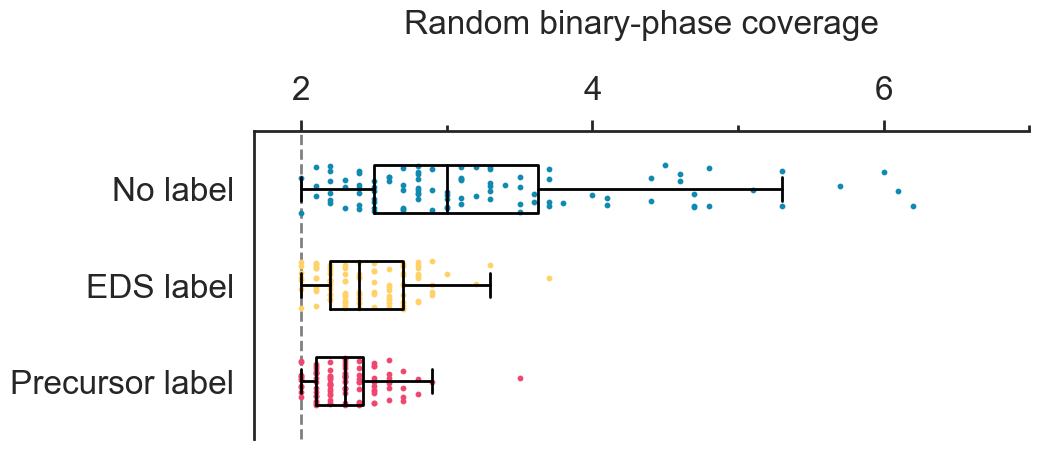

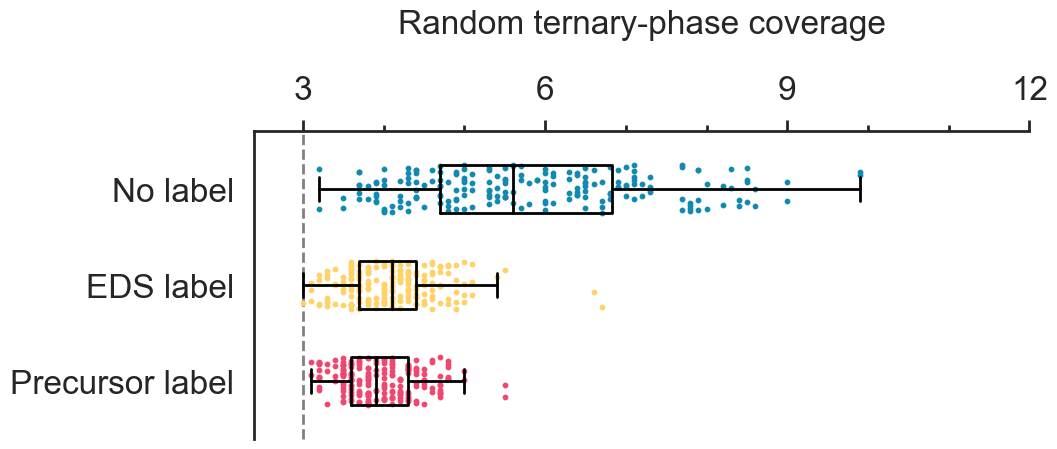

In [19]:
load_plt_setting()
stat_n = 10
prompt_type_list = ['full','eds','none',]

for n_multilabel in ['2','3']:
    fig, ax = plt.subplots(figsize=(10, 4))
    x_dic = {}
    for i, (prompt_type,c) in enumerate(zip(prompt_type_list,["#ef476f","#ffd166","#118ab2"])):
        x_dic[prompt_type] = {}
        x_dic[prompt_type]['raw'] = []
        y_pred_full = np.array(full_result[prompt_type][n_multilabel]['outputs'])
        y_true_full = np.array(full_result[prompt_type][n_multilabel]['labels'])
        for j in range(y_pred_full.shape[0]):
            x_dic[prompt_type]['raw'].append(coverage_error(y_true_full[j:j+1], y_pred_full[j:j+1]))
        x_dic[prompt_type]['stat'] = [np.mean(x_dic[prompt_type]['raw'][i:i+stat_n]) for i in range(0,len(x_dic[prompt_type]['raw']),stat_n)]
        y = np.random.uniform(i-0.25+1, i+0.25+1, size=len(x_dic[prompt_type]['stat']))
        ax.scatter(x_dic[prompt_type]['stat'], y, c=c, alpha=1, s=10)
        
    print(mannwhitneyu(x_dic[prompt_type_list[2]]['stat'],x_dic[prompt_type_list[1]]['stat']))
    print(mannwhitneyu(x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[0]]['stat']))
        
    boxplot = ax.boxplot([x_dic[prompt_type_list[0]]['stat'],x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[2]]['stat']], 
                         notch=False, vert=False, widths=0.5, sym='', 
                         boxprops=dict(linewidth=2,c='black'), medianprops=dict(linewidth=2,c='black'),
                         whiskerprops=dict(linewidth=2,c='black'), capprops=dict(linewidth=2,c='black'))

    ax.set_ylim([0.4,3.6])
    ax.axes.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    ax.axes.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=False, steps=[1, 2, 3, 5, 10]))
    
    ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, length=8, width=2, pad=10, labelsize=24)
    ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, direction='out', length=4, width=2, pad=10)
    ax.tick_params(axis='y', labelsize=24)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(['','Precursor label ','EDS label ','No label '])
    plt.ylabel('', labelpad=20, fontsize=28)
    ax.xaxis.set_label_position('top')
    ax.axvline(x=int(n_multilabel), clip_on=False, color='grey', linestyle='--', linewidth=2, zorder=-10)
    
    if n_multilabel == '2':
        ax.set_xlim([1.68,7])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        plt.xlabel(r'Random binary-phase coverage'.format(n_multilabel), labelpad=30, fontsize=24)

    elif n_multilabel == '3':
        ax.set_xlim([2.4,12])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(3))
        plt.xlabel(r'Random ternary-phase coverage'.format(n_multilabel), labelpad=30, fontsize=24)

        
    plt.savefig(os.path.join(folder, 'models', model_folder, 'Top-K_{}.png'.format(n_multilabel)), bbox_inches='tight',format='png', dpi=300, transparent=True)
    np.savetxt(os.path.join(folder, 'models', model_folder, 'Top-K_{}.csv'.format(n_multilabel)),  
               np.swapaxes(np.asarray([x_dic[prompt_type_list[0]]['stat'],x_dic[prompt_type_list[1]]['stat'],x_dic[prompt_type_list[2]]['stat']]),0,1), 
               header='Precursor label / EDS label / No label',)

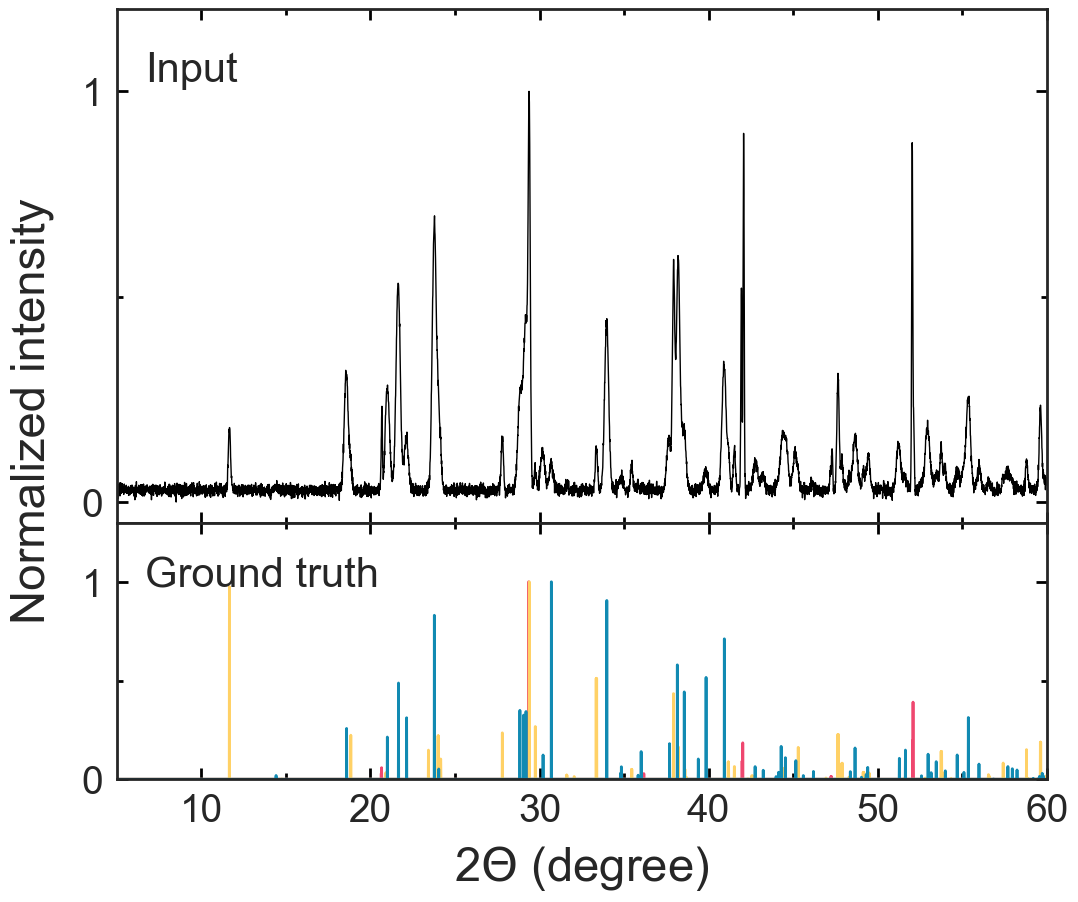

In [250]:
# 860 ['CsPb2Br5', 'PbBr2', 'CsBr'] [17, 19, 64] [64, 19, 32]
# 77 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62, 63, 65] [65, 63, 62]

sample_no = 860
twotheta = np.arange(5.00, 60.01, 0.01)

load_plt_setting()

fig, (ax0, ax1, ) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[2, 1]),figsize=(12, 10))
mat1 = ax0.plot(twotheta, Xs[sample_no,:,0], linewidth=1, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for sample_no, c in zip(y_true[sample_no],["#ef476f","#ffd166","#118ab2"]):
    ref = dataloader.load_ref(sample_no)
    mat1 = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.3])
# ax2.axes.set_xlim([22.5,30])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.03, 0.86, 'Input', fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, 'Ground truth', fontsize=30, transform=ax1.transAxes, horizontalalignment='left')

# for i, (sample_no, c, x_pos) in enumerate(zip(y_true[sample_no],["#ef476f","#ffd166","#118ab2"],[0.95,0.79,0.55])):
#     plt.text(x_pos+0.001, 0.75-0.002, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula[i])), alpha=0.4,
#          fontsize=30, transform=ax1.transAxes, horizontalalignment='right')
#     plt.text(x_pos, 0.75, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula[i])), color=c,
#          fontsize=30, transform=ax1.transAxes, horizontalalignment='right')

    
plt.subplots_adjust(hspace=.0)

sample_no = 860
ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Normalized intensity                      ', labelpad=20, fontsize=34)
plt.savefig(os.path.join(folder, 'models', model_folder, 'Multiphase_{}_{}.png'.format(max_n_mix,sample_no)), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

In [247]:
# sample_no = 860

order = np.linspace(0,65,66)
y_pred_full = list(full_result['full']['{}'.format(max_n_mix)]['outputs'][sample_no])
y_true_full = list(full_result['full']['{}'.format(max_n_mix)]['labels'][sample_no])

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = y_pred_full_sort/np.max(y_pred_full_sort)

In [248]:
for i in range(len(y_true_full_sort)-6,len(y_true_full_sort)):
    print(y_pred_full_sort[i], y_true_full_sort[i], order_sort[i], 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

0.16904745 0.0 60.0 tetragonal-MAPbBr3
0.18234627 0.0 46.0 delta-FAPbI3
0.18284322 0.0 57.0 MAPb(Br0.6I0.4)3
0.9952019 1.0 62.0 alpha-MAPbI3
0.99629223 1.0 65.0 PbI2
1.0 1.0 63.0 tetragonal-MAPbI3


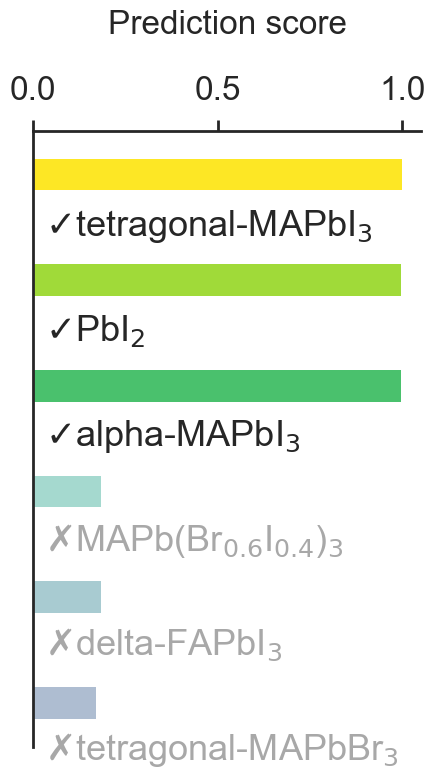

In [249]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 8))

cmap = mpl.cm.get_cmap('viridis')
cmap_index = np.linspace(0,1,8)

# formula_
for i in range(6):
    formula = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    if y_true_full_sort[-i-1] == 0:
        alpha = 0.4
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=cmap(cmap_index[-i-1]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=10, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

# ax.tick_params(axis='y', labelsize=24)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score'.format(n_multilabel), labelpad=30, fontsize=24)

plt.savefig(os.path.join(folder, 'models', model_folder, 'Multiphase_{}_{}_score.png'.format(max_n_mix,sample_no)), 
            format='png', dpi=300, transparent=True, bbox_inches='tight')

# 3 Random phase identification

In [14]:
model_folder = '20241008 random phase embedding 20'
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', model_folder, '1000000')).to('cuda')

In [97]:
full_result = {}
prompt_type_list = ['full']

for prompt_type in prompt_type_list:
    full_result[prompt_type] = {}
    
    for i in [1,2,3]:
        full_result[prompt_type]['{}'.format(i)] = {'phase_true':[], 'phase_pred':[], 'phase_acc':[],
                                                    'n_true':[],'n_pred':[],'n_acc':[]}

In [103]:
n = 3
file_name = 'test_dataset_{}phase.npy'.format(n)

with open(os.path.join(cif_folder, file_name), 'rb') as handle:
    test_dataset = joblib.load(handle)

Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
n_mix_list_onehot = np.zeros((Ys.shape[0], 3))
n_mix_list_onehot[:, n-1] = 1
print('test dataset loaded.')

test dataset loaded.


In [104]:
for prompt_type in prompt_type_list:

    for i in range(len(element_list)):
#     for i in range(10):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == 'none':
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(Ys[i:i+1]).to(dtype=torch.float32)
        labels = np.array(labels[0].nonzero().view(-1))
        outputs = model(**inputs.to('cuda'), output_attentions=True)
        
        phase_pred = np.array(outputs.logits.detach().cpu())[0][:-3]
        n_pred = np.array(outputs.logits.detach().cpu())[0][-3:]
        logits_phase = np.array(torch.topk(outputs.logits.detach().cpu()[0][:-3], len(labels)).indices)
        logits_n = np.array(torch.topk(outputs.logits.detach().cpu()[0][-3:], len(labels)).indices)[0]
        
        y_true.append(list(labels))
        y_pred.append(list(np.array(logits.detach().cpu())))
        
        full_result[prompt_type][str(n)]['phase_true'].append(Ys[i])
        full_result[prompt_type][str(n)]['phase_pred'].append(phase_pred)
        full_result[prompt_type][str(n)]['n_true'].append(n_mix_list_onehot[i])
        full_result[prompt_type][str(n)]['n_pred'].append(n_pred)
        
        if set(labels) == set(logits_phase):
            full_result[prompt_type][str(n)]['phase_acc'].append(0)
        else:
            full_result[prompt_type][str(n)]['phase_acc'].append(1)
            
        if n_mix_list_onehot[i].argmax()+1 == n:
            full_result[prompt_type][str(n)]['n_acc'].append(0)
        else:
            full_result[prompt_type][str(n)]['n_acc'].append(1)
            
        print('{}\t{}\t{}\t{}\t{}'.format(i,formula_list[i],n_mix_list_onehot[i].argmax()+1,labels,logits_phase))

    result = np.array(result)

0	['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.4FA0.6PbBr3']	3	[48 59 60]	[59 60  9]
1	['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3']	3	[59 60 64]	[64 60 59]
2	['Cs4PbBr6', 'CsPb2Br5', 'CsBr']	3	[16 17 19]	[19 16 17]
3	['alpha-CsPbI3', 'delta-CsPbI3', 'PbI2']	3	[36 37 65]	[37 65 36]
4	['cubic-CsPbBr3', 'CsPb(I0.8Br0.2)3', 'PbI2']	3	[27 32 65]	[65 18 12]
5	['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3']	3	[59 60 64]	[64 43 17]
6	['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3', 'delta-FAPbI3']	3	[46 51 52]	[64 16 47]
7	['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2']	3	[59 60 64]	[59 64 60]
8	['PbI2', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3']	3	[58 60 65]	[59 60 32]
9	['beta-FAPbI3', 'PbI2', 'MA0.4FA0.6PbI3']	3	[45 52 65]	[65 45 46]
10	['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3', 'CsPb(Cl0.2Br0.8)3']	3	[20 23 32]	[32 17 60]
11	['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'orthorhombic-CsPbBr3']	3	[10 32 33]	[33 32  9]
12	['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3']	3	[59 60 64]	[64 59 60]
13	['gamma-CsPbI3

110	['MA0.6FA0.4PbI3', 'alpha-MAPbI3', 'PbI2']	3	[53 62 65]	[46 45 62]
111	['cubic-CsPbBr3', 'CsBr', 'Cs0.8FA0.2PbBr3']	3	[ 3 17 32]	[43  0 32]
112	['MA0.2FA0.8PbBr3', 'MA0.6FA0.4PbBr3', 'PbBr2']	3	[47 49 64]	[64  8 60]
113	['PbI2', 'CsI', 'Cs0.6FA0.4PbI3']	3	[ 6 18 65]	[43 17 16]
114	['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsBr']	3	[16 17 33]	[17 16 64]
115	['CsPb(Cl0.8Br0.2)3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3']	3	[22 23 33]	[33 59  8]
116	['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3']	3	[44 45 46]	[64 43 45]
117	['PbBr2', 'CsBr', 'orthorhombic-CsPbBr3']	3	[17 33 64]	[17 33 19]
118	['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3']	3	[44 45 46]	[64 60 59]
119	['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2']	3	[59 60 64]	[64 17 35]
120	['FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3', 'beta-FAPbI3']	3	[40 42 45]	[40 45 46]
121	['tetragonal-MAPbI3', 'PbI2', 'beta-FAPbI3']	3	[45 63 65]	[45 63 44]
122	['PbI2', 'alpha-CsPbI3', 'delta-CsPbI3']	3	[36 37 65]	[19 17 16]
123	['tetragonal-MAPbBr3'

220	['orthorhombic-CsPbBr3', 'PbBr2', 'cubic-CsPbBr3']	3	[32 33 64]	[64 33 32]
221	['tetragonal-MAPbI3', 'MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3']	3	[51 53 63]	[64 16 19]
222	['PbI2', 'alpha-MAPbI3', 'beta-FAPbI3']	3	[45 62 65]	[65 64 62]
223	['Cs4PbBr6', 'PbBr2', 'Cs0.8MA0.2PbBr3']	3	[11 16 64]	[16 33 64]
224	['Pnma-CsPbCl3', 'CsBr', 'cubic-CsPbBr3']	3	[17 32 34]	[17 32 10]
225	['MA0.8FA0.2PbBr3', 'PbBr2', 'MA0.6FA0.4PbBr3']	3	[49 50 64]	[64 49  9]
226	['Cs0.4FA0.6PbI3', 'CsI', 'PbI2']	3	[ 5 18 65]	[17 16 64]
227	['cubic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.8Br0.2)3']	3	[22 23 32]	[32 23 22]
228	['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr']	3	[16 17 32]	[17 16 32]
229	['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2']	3	[44 45 65]	[64 60 59]
230	['delta-CsPbI3', 'gamma-CsPbI3', 'CsPb(I0.2Cl0.8)3']	3	[28 37 38]	[33 16 34]
231	['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3']	3	[22 34 35]	[11 60 17]
232	['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3']	3	[10 59 60]	[60 59 10]
233	['alpha-FAPbI

332	['Cs0.4MA0.6PbBr3', 'Cs0.2MA0.8PbBr3', 'CsPb2Br5']	3	[ 8  9 19]	[64  8 60]
333	['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3']	3	[59 60 64]	[64 60 59]
334	['alpha-CsPbI3', 'PbI2', 'gamma-CsPbI3']	3	[36 38 65]	[17 64 33]
335	['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3']	3	[44 46 65]	[65 62 36]
336	['CsI', 'gamma-CsPbI3', 'alpha-CsPbI3']	3	[18 36 38]	[36 65 38]
337	['PbBr2', 'Cs0.8MA0.2PbBr3', 'cubic-MAPbBr3']	3	[11 59 64]	[11  8 19]
338	['alpha-MAPbI3', 'MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3']	3	[52 53 62]	[64 16 11]
339	['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3']	3	[62 63 65]	[35 34 32]
340	['Cs4PbBr6', 'tetragonal-MAPbBr3', 'CsBr']	3	[16 17 60]	[16 17 64]
341	['CsPb(I0.8Cl0.2)3', 'PbI2', 'Pnma-CsPbCl3']	3	[31 34 65]	[19 11  8]
342	['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'alpha-FAPbI3']	3	[ 5  7 44]	[16 19 64]
343	['alpha-CsPbI3', 'gamma-CsPbI3', 'PbI2']	3	[36 38 65]	[59 64 60]
344	['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'alpha-MAPbI3']	3	[59 60 62]	[32 34 27]
345	['PbBr2', 'Cs0.8MA0.2PbBr3'

443	['cubic-FAPbBr3', 'delta-FAPbI3', 'FAPb(Br0.4I0.6)3']	3	[40 43 46]	[64 59 65]
444	['Cs0.8MA0.2PbI3', 'CsI', 'alpha-MAPbI3']	3	[15 18 62]	[18 62 65]
445	['PbI2', 'gamma-CsPbI3', 'delta-CsPbI3']	3	[37 38 65]	[38 37 65]
446	['gamma-CsPbI3', 'CsPb(I0.6Br0.4)3', 'Cs4PbBr6']	3	[16 26 38]	[64 16 59]
447	['delta-FAPbI3', 'beta-FAPbI3', 'PbI2']	3	[45 46 65]	[65 64 45]
448	['CsPb(I0.4Br0.6)3', 'CsI', 'PbBr2']	3	[18 25 64]	[18 64 62]
449	['delta-FAPbI3', 'beta-FAPbI3', 'alpha-FAPbI3']	3	[44 45 46]	[17 64 16]
450	['PbI2', 'delta-FAPbI3', 'beta-FAPbI3']	3	[45 46 65]	[64 32 19]
451	['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2']	3	[62 63 65]	[64 32 19]
452	['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'PbBr2']	3	[10 60 64]	[64 60 50]
453	['PbBr2', 'cubic-CsPbBr3', 'Cs4PbBr6']	3	[16 32 64]	[32 16 64]
454	['cubic-FAPbBr3', 'delta-FAPbI3', 'PbI2']	3	[43 46 65]	[64 49 59]
455	['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2']	3	[62 63 65]	[63 62 65]
456	['MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3']

554	['Cs0.6MA0.4PbBr3', 'CsBr', 'cubic-MAPbBr3']	3	[10 17 59]	[32 17 59]
555	['Cs0.8MA0.2PbBr3', 'Cs0.4MA0.6PbBr3', 'Cs0.6MA0.4PbBr3']	3	[ 9 10 11]	[35 34  1]
556	['gamma-CsPbI3', 'delta-CsPbI3', 'alpha-CsPbI3']	3	[36 37 38]	[64 33 19]
557	['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3']	3	[44 45 46]	[64 60 43]
558	['MA0.8FA0.2PbI3', 'beta-FAPbI3', 'alpha-FAPbI3']	3	[44 45 54]	[16  1  3]
559	['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3']	3	[44 45 46]	[19 64 32]
560	['Pnma-CsPbCl3', 'CsI', 'CsPb(I0.6Cl0.4)3']	3	[18 30 34]	[17 60 59]
561	['delta-FAPbI3', 'tetragonal-MAPbI3', 'beta-FAPbI3']	3	[45 46 63]	[64 11 16]
562	['delta-CsPbI3', 'CsI', 'alpha-CsPbI3']	3	[18 36 37]	[18 36 38]
563	['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3']	3	[47 59 60]	[34 22 35]
564	['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3']	3	[58 59 60]	[59 60 10]
565	['Cs0.8MA0.2PbI3', 'PbI2', 'CsI']	3	[15 18 65]	[65 15 18]
566	['cubic-FAPbBr3', 'PbI2', 'delta-FAPbI3']	3	[43 46 65]	[65 43 46]
567	['

671	['CsI', 'PbI2', 'alpha-CsPbI3']	3	[18 36 65]	[59 60 64]
672	['PbI2', 'delta-CsPbI3', 'CsI']	3	[18 37 65]	[16 17 19]
673	['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3']	3	[62 63 65]	[64 32 17]
674	['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3']	3	[62 63 65]	[64 60 59]
675	['CsBr', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3']	3	[17 33 43]	[33 43 17]
676	['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3']	3	[36 37 65]	[64 16 59]
677	['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'PbBr2']	3	[47 60 64]	[64 32 43]
678	['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'alpha-FAPbI3']	3	[39 41 44]	[16 19 33]
679	['cubic-CsPbCl3', 'Pnma-CsPbCl3', 'orthorhombic-CsPbBr3']	3	[33 34 35]	[33 10 11]
680	['CsPb2Br5', 'PbBr2', 'CsBr']	3	[17 19 64]	[19 64 17]
681	['Cs0.4FA0.6PbI3', 'Cs0.2FA0.8PbI3', 'delta-CsPbI3']	3	[ 4  5 37]	[33 16 64]
682	['PbBr2', 'cubic-CsPbBr3', 'CsBr']	3	[17 32 64]	[17 64 32]
683	['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3']	3	[62 63 65]	[35 34 32]
684	['CsI', 'CsPb(I0.4Cl0.6)3', 'CsPb(I0.8Cl0.2)3']	3	[18 2

780	['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3']	3	[62 63 65]	[63 62 65]
781	['CsPb(Cl0.2Br0.8)3', 'cubic-CsPbCl3', 'orthorhombic-CsPbBr3']	3	[20 33 35]	[33 59 32]
782	['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3']	3	[62 63 65]	[65 63 62]
783	['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2']	3	[62 63 65]	[64 35 34]
784	['CsPb(Cl0.6Br0.4)3', 'cubic-CsPbBr3', 'CsPb2Br5']	3	[19 22 32]	[19  8 11]
785	['delta-FAPbI3', 'beta-FAPbI3', 'PbI2']	3	[45 46 65]	[64 19 17]
786	['beta-FAPbI3', 'PbI2', 'delta-FAPbI3']	3	[45 46 65]	[43 64 19]
787	['cubic-CsPbCl3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.8Br0.2)3']	3	[23 33 35]	[23 33 34]
788	['CsPb(Cl0.2Br0.8)3', 'Cs4PbBr6', 'orthorhombic-CsPbBr3']	3	[16 20 33]	[64 16 10]
789	['CsBr', 'CsPb2Br5', 'PbBr2']	3	[17 19 64]	[19 64 17]
790	['PbI2', 'MA0.4FA0.6PbI3', 'delta-FAPbI3']	3	[46 52 65]	[46 45 52]
791	['orthorhombic-CsPbBr3', 'PbBr2', 'alpha-CsPbI3']	3	[33 36 64]	[12 37 13]
792	['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr']	3	[17 32 33]	[32 33 64]
793	['PbBr

895	['CsPb2Br5', 'CsBr', 'delta-CsPbI3']	3	[17 19 37]	[16 64 33]
896	['cubic-FAPbBr3', 'alpha-FAPbI3', 'PbI2']	3	[43 44 65]	[32 43 65]
897	['delta-CsPbI3', 'CsI', 'CsPb(I0.2Cl0.8)3']	3	[18 28 37]	[16 19 11]
898	['cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3', 'cubic-CsPbBr3']	3	[ 3 32 43]	[32  3  1]
899	['beta-FAPbI3', 'delta-FAPbI3', 'FAPb(Br0.4I0.6)3']	3	[40 45 46]	[33 16 64]
900	['alpha-MAPbI3', 'tetragonal-MAPbI3', 'MA0.2FA0.8PbI3']	3	[51 62 63]	[59 33 64]
901	['PbBr2', 'CsPb(I0.2Br0.8)3', 'CsPb(I0.6Br0.4)3']	3	[24 26 64]	[64 65 18]
902	['MA0.6FA0.4PbBr3', 'MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3']	3	[48 49 50]	[49 60 48]
903	['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsBr']	3	[17 32 33]	[17 33 32]
904	['CsPb2Br5', 'tetragonal-MAPbBr3', 'cubic-CsPbBr3']	3	[19 32 60]	[19  8 64]
905	['Cs0.2FA0.8PbI3', 'delta-CsPbI3', 'delta-FAPbI3']	3	[ 4 37 46]	[64 33 16]
906	['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'MA0.6FA0.4PbI3']	3	[46 51 53]	[37 65 38]
907	['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3']	3	[59 60 64]

In [109]:
for prompt_type in prompt_type_list:
    print(prompt_type)
    for i in [1,2,3]:
        phase_pred = np.array(full_result[prompt_type][str(i)]['phase_pred'])
        phase_true = np.array(full_result[prompt_type][str(i)]['phase_true'])
        phase_acc = np.array(full_result[prompt_type][str(i)]['phase_acc'])
        phase_acc_full = 1-np.sum(phase_acc)/phase_acc.shape[0]
        n_pred = np.array(full_result[prompt_type][str(i)]['n_pred'])
        n_true = np.array(full_result[prompt_type][str(i)]['n_true'])
        n_acc = np.array(full_result[prompt_type][str(i)]['n_acc'])
        n_acc_full = 1-np.sum(n_acc)/n_acc.shape[0]
        print(i, coverage_error(phase_true, phase_pred), phase_acc_full, n_acc_full)

full
1 9.335 0.367 1.0
2 11.669 0.29800000000000004 1.0
3 16.628 0.20099999999999996 1.0


# 4 Attention

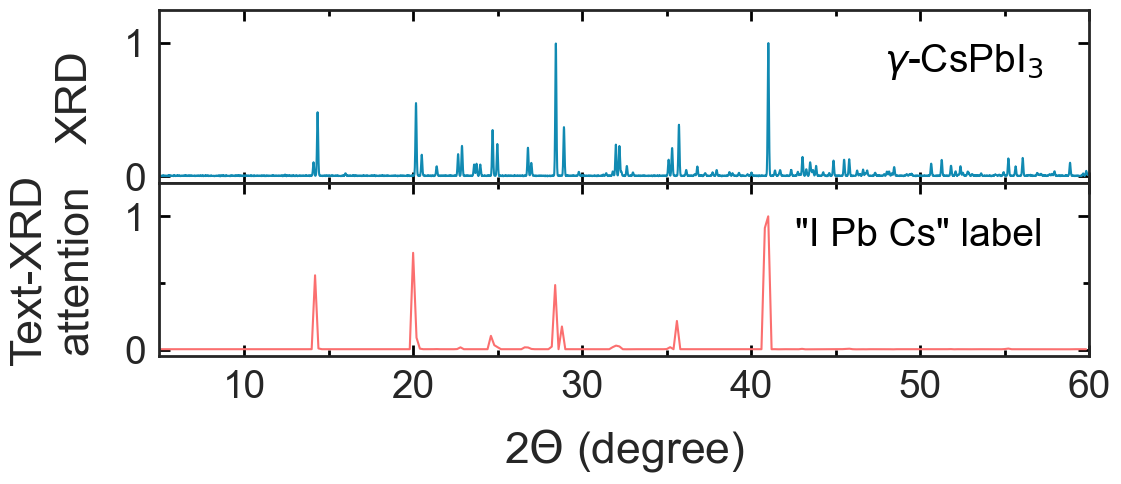

In [24]:
for i in range(20):
# for i in [9]:

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))

    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,1:len(inputs['input_ids'][0])-1,len(inputs['input_ids'][0]):]

    load_plt_setting()

    fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[1, 1]),figsize=(12, 4.5))

    ax0.plot(np.arange(5.00, 60.01, 0.01)[:-1], Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=1, steps=[1, 2, 5, 10]))
#     ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.25])
    ax0.set_ylabel(f'XRD', labelpad=20, fontsize=32)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.sum(Y, axis=0)/np.max(np.sum(Y, axis=0)), color=colors.to_rgba('#fb6f6f'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.axes.set_xlim([5,60])
    ax1.axes.set_ylim([-0.05,1.25])

    ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=15, fontsize=32)
    ax1.set_ylabel(f'Text-XRD\nattention', labelpad=20, fontsize=32)

#     plt.text(0.95, 0.64, r'$\gamma$'+'-'+r'CsPbI$_{3}$', fontsize=28, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.95, 0.64, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), fontsize=28, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.95, 0.64, '"'+X_prompts[0]+'" label', fontsize=28, transform=ax1.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models',model_folder,'{}.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


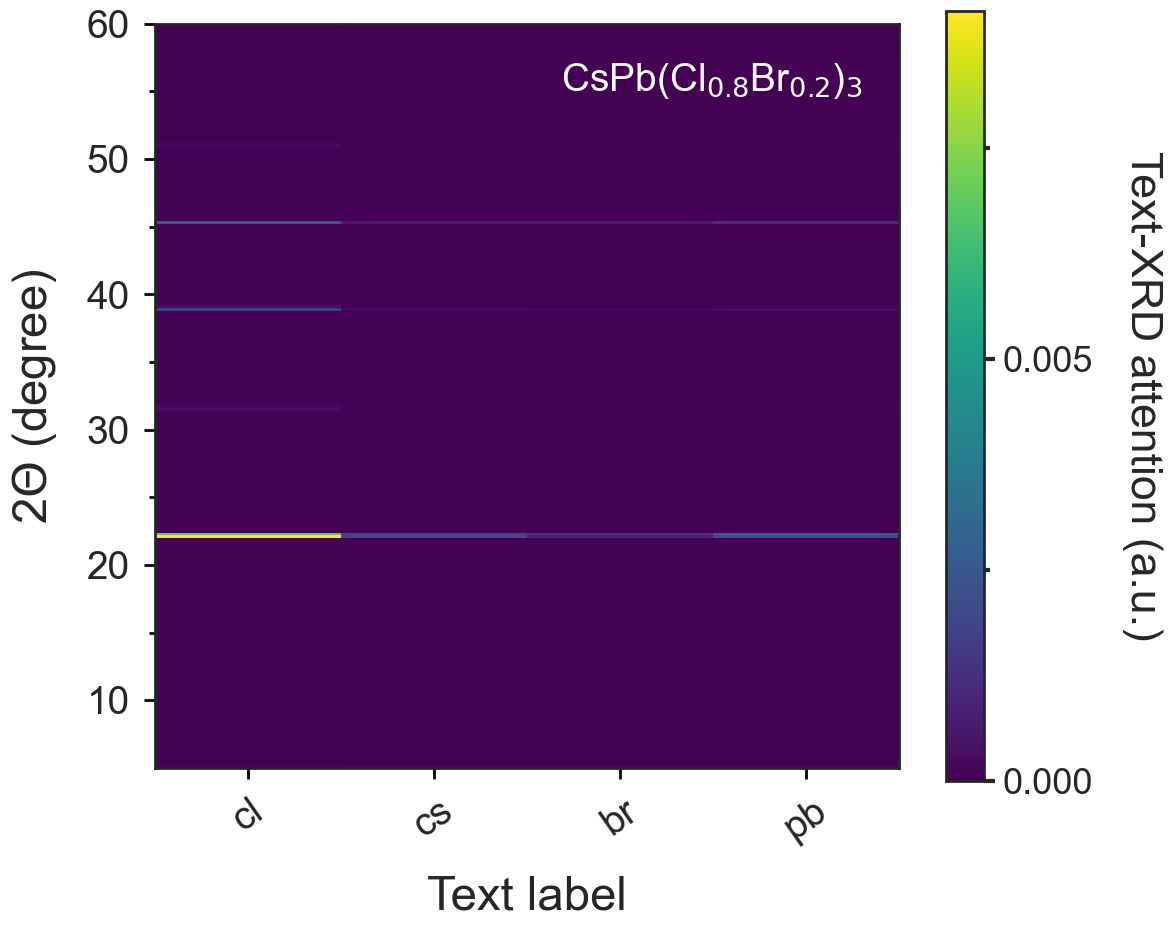

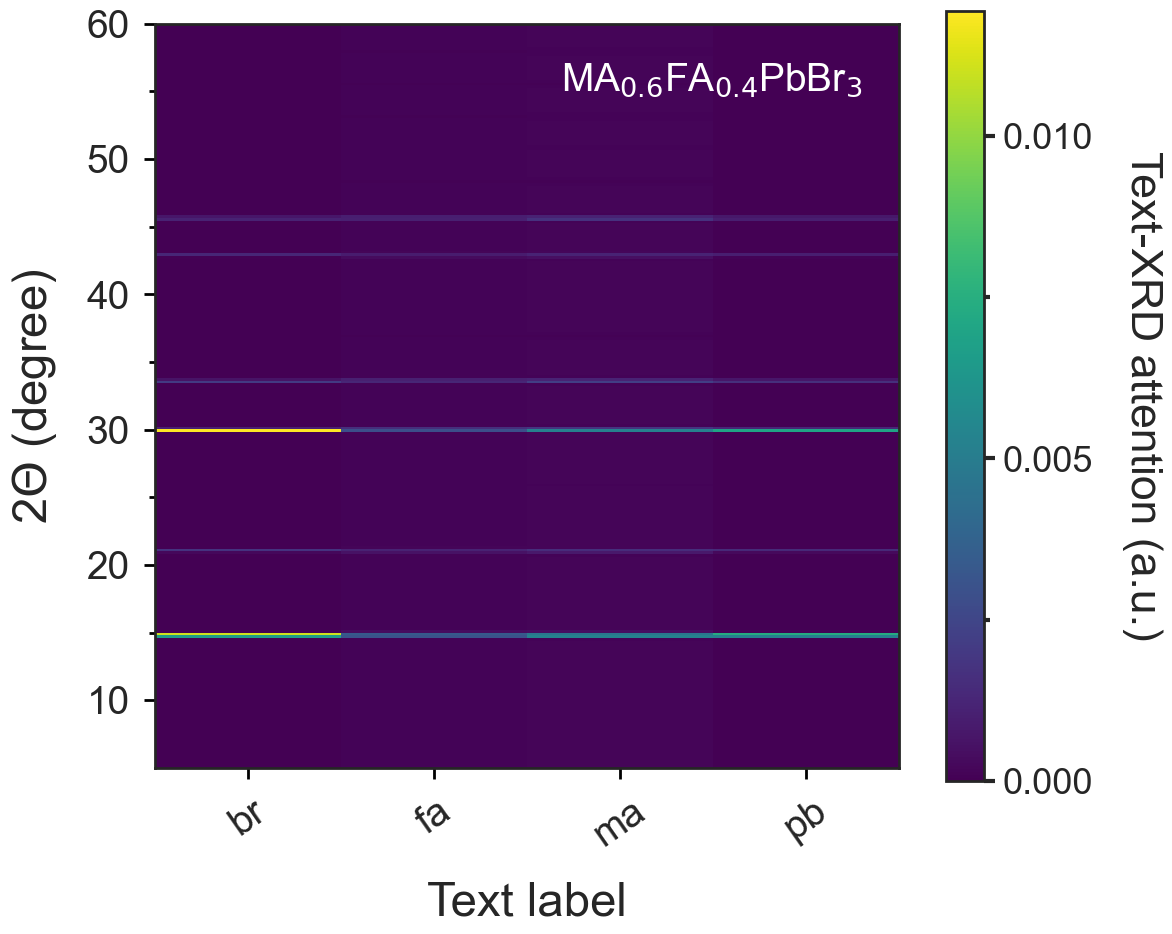

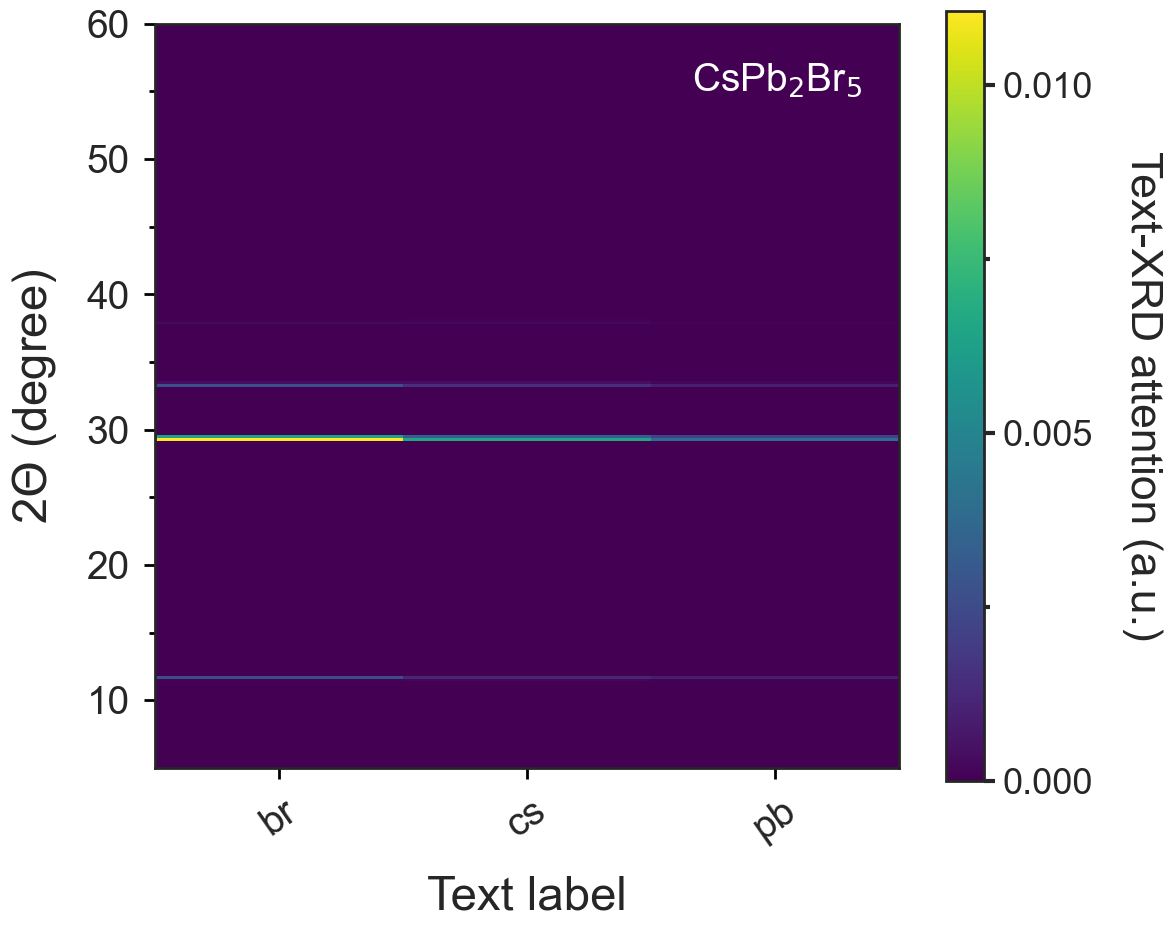

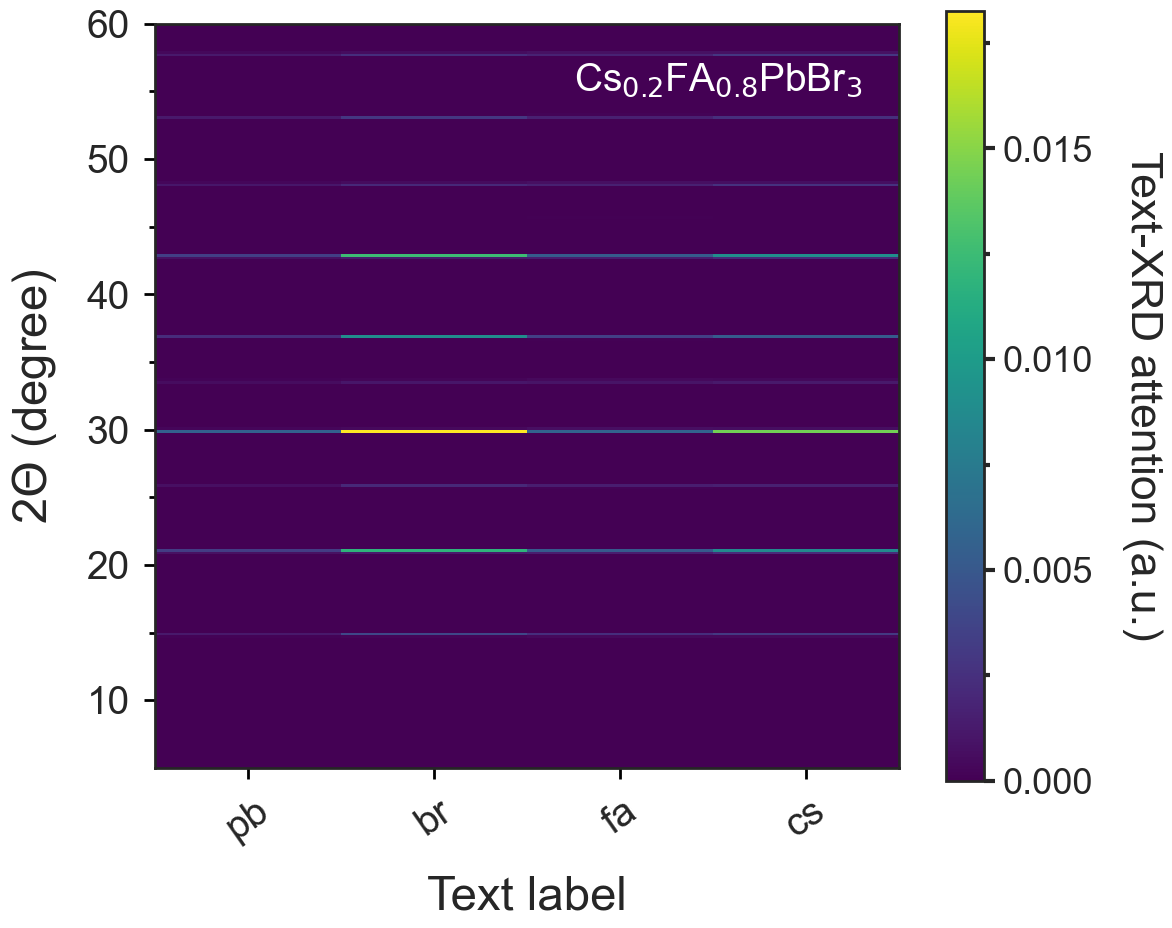

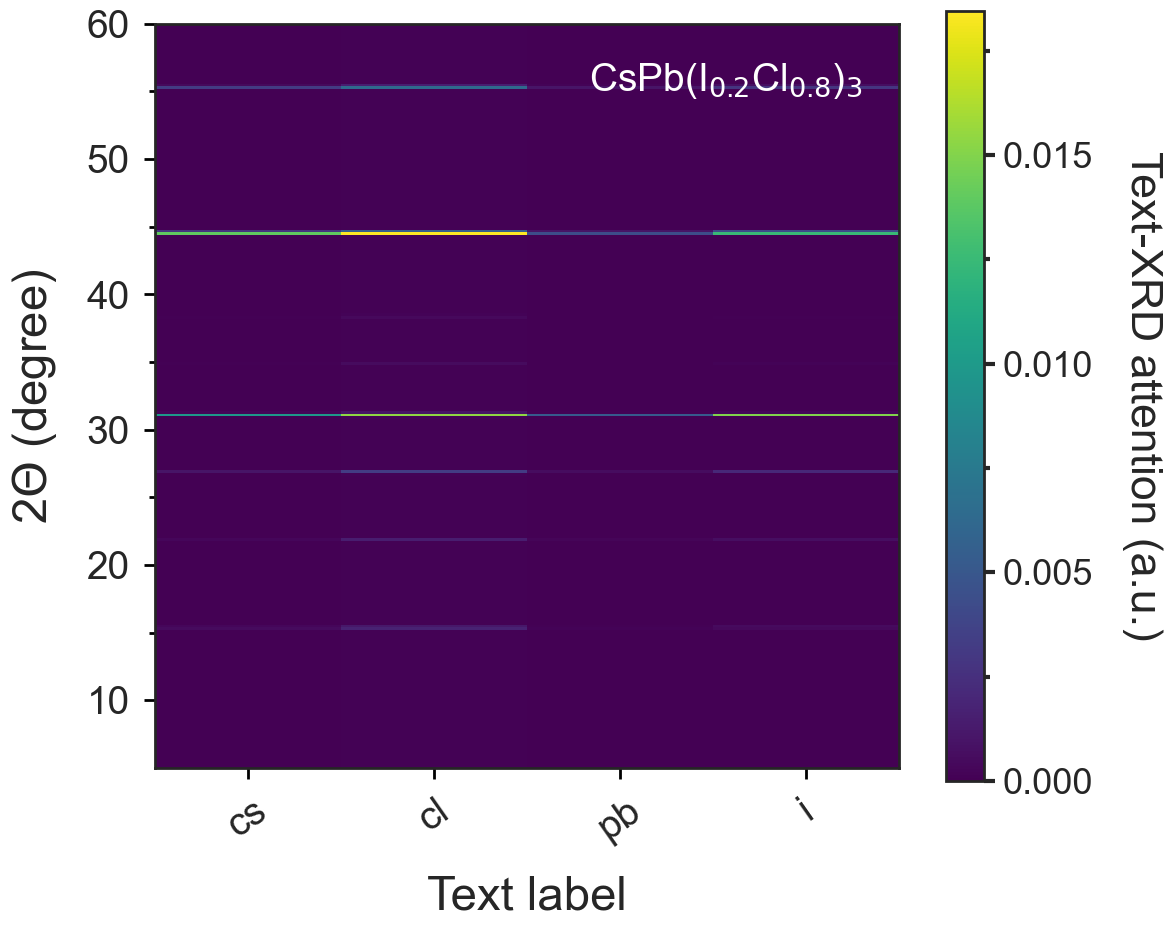

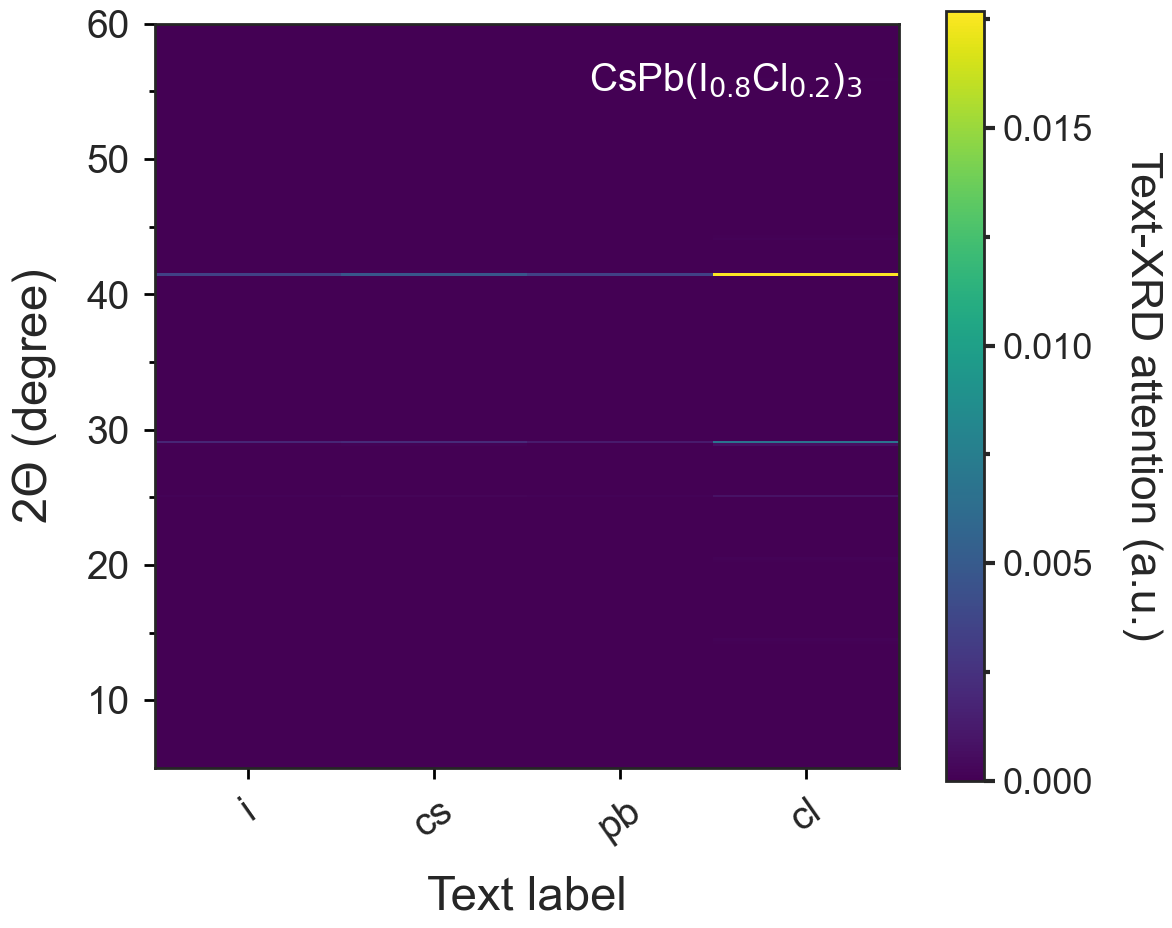

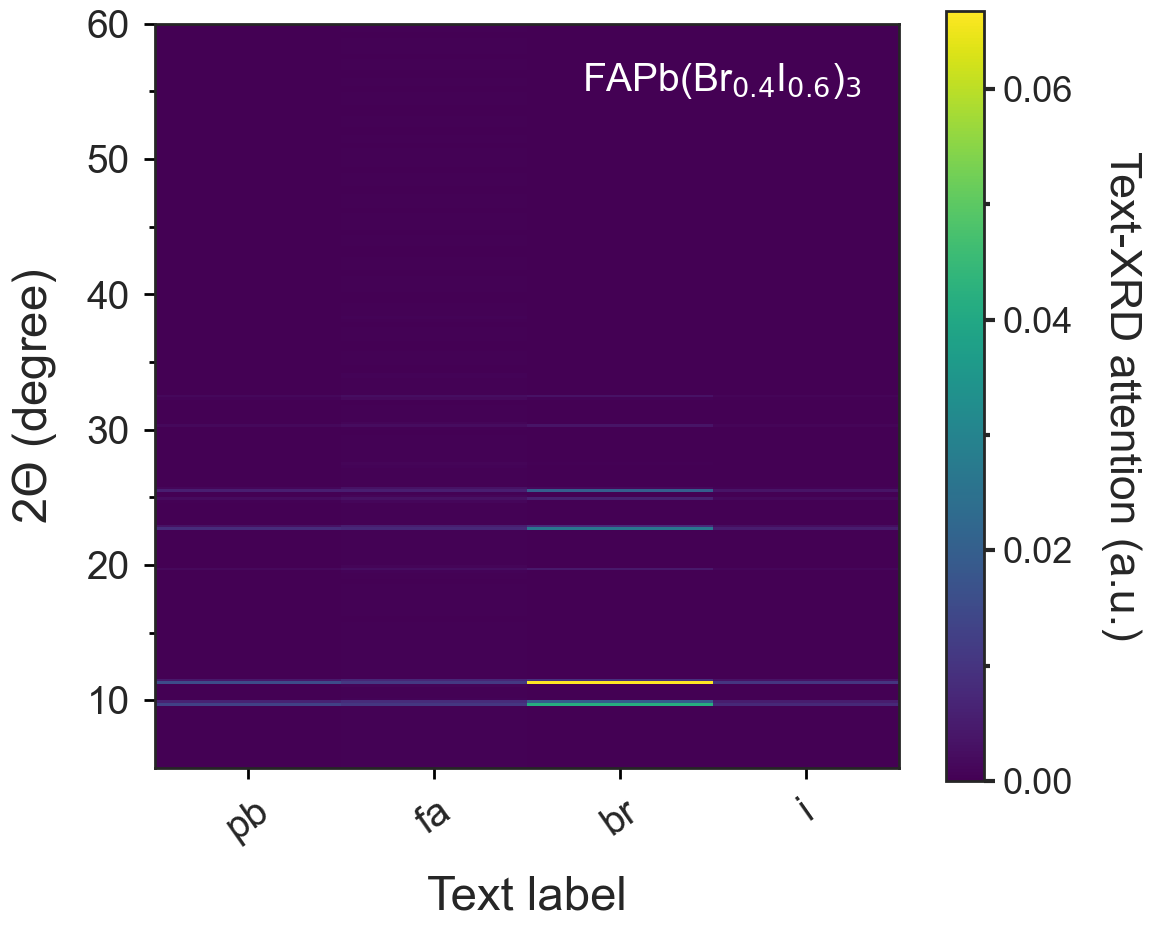

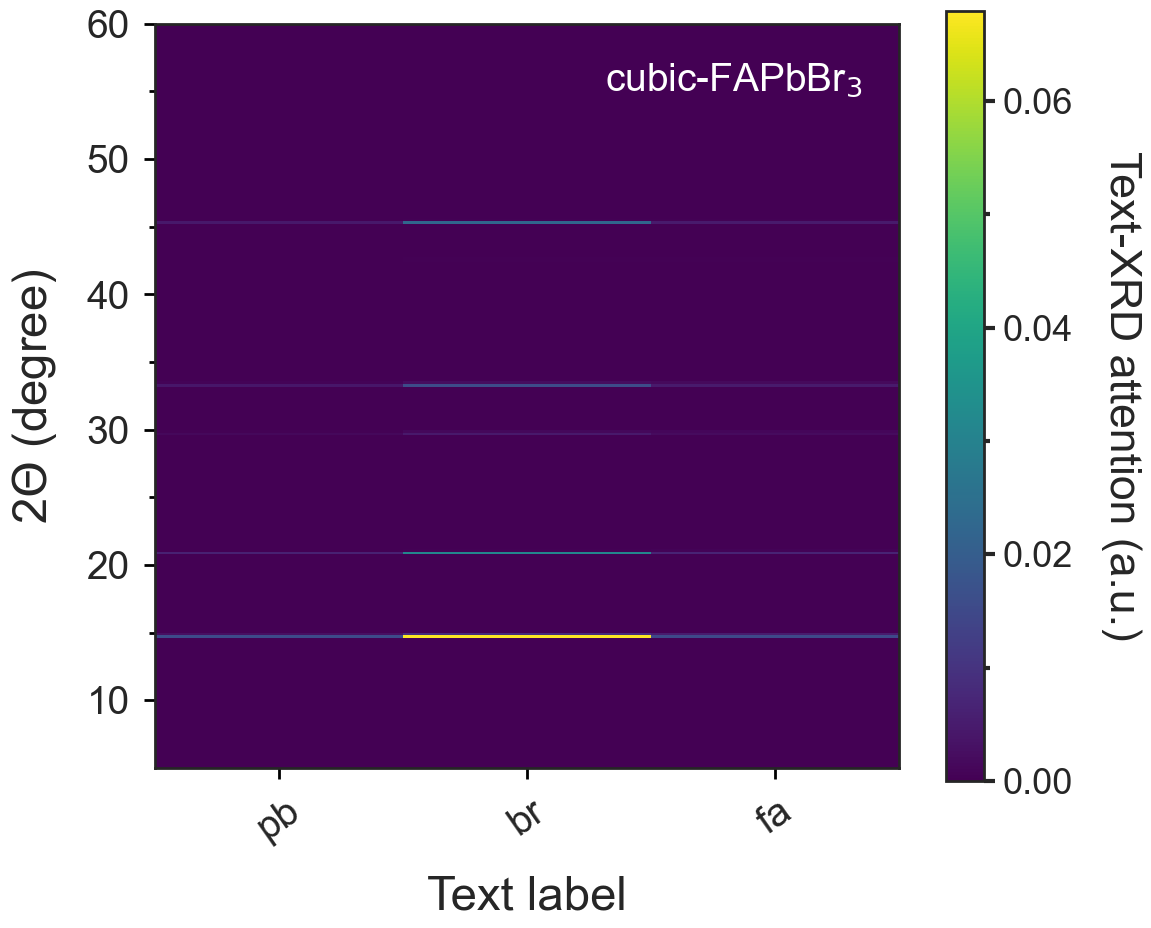

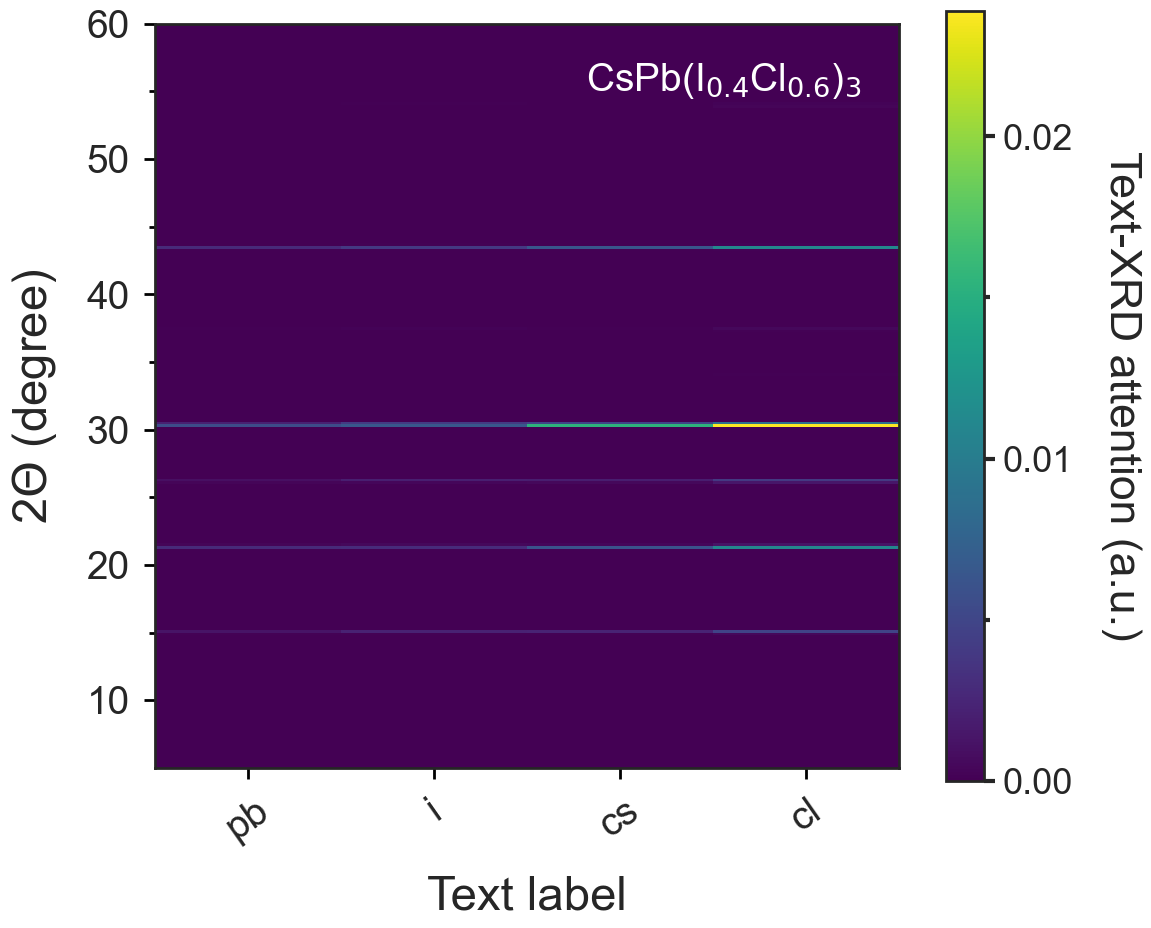

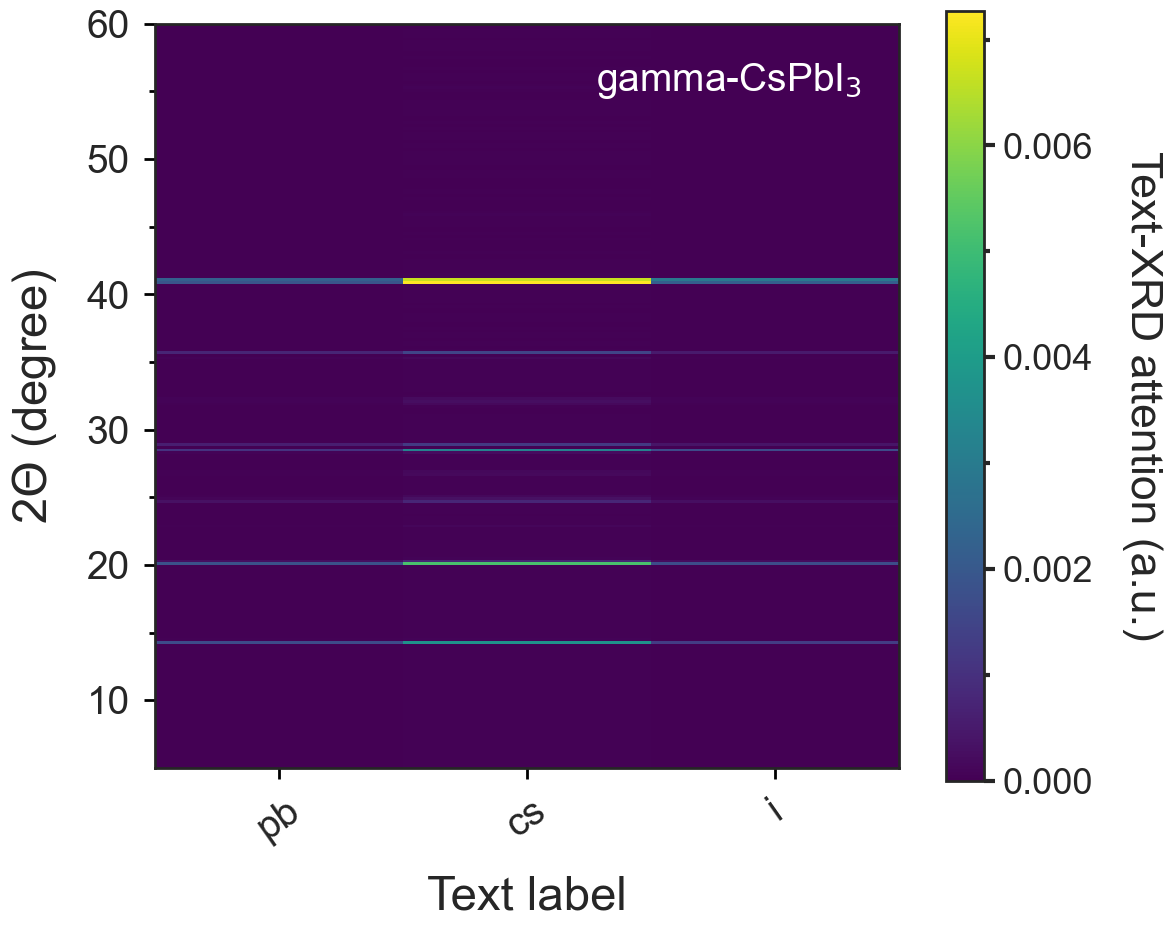

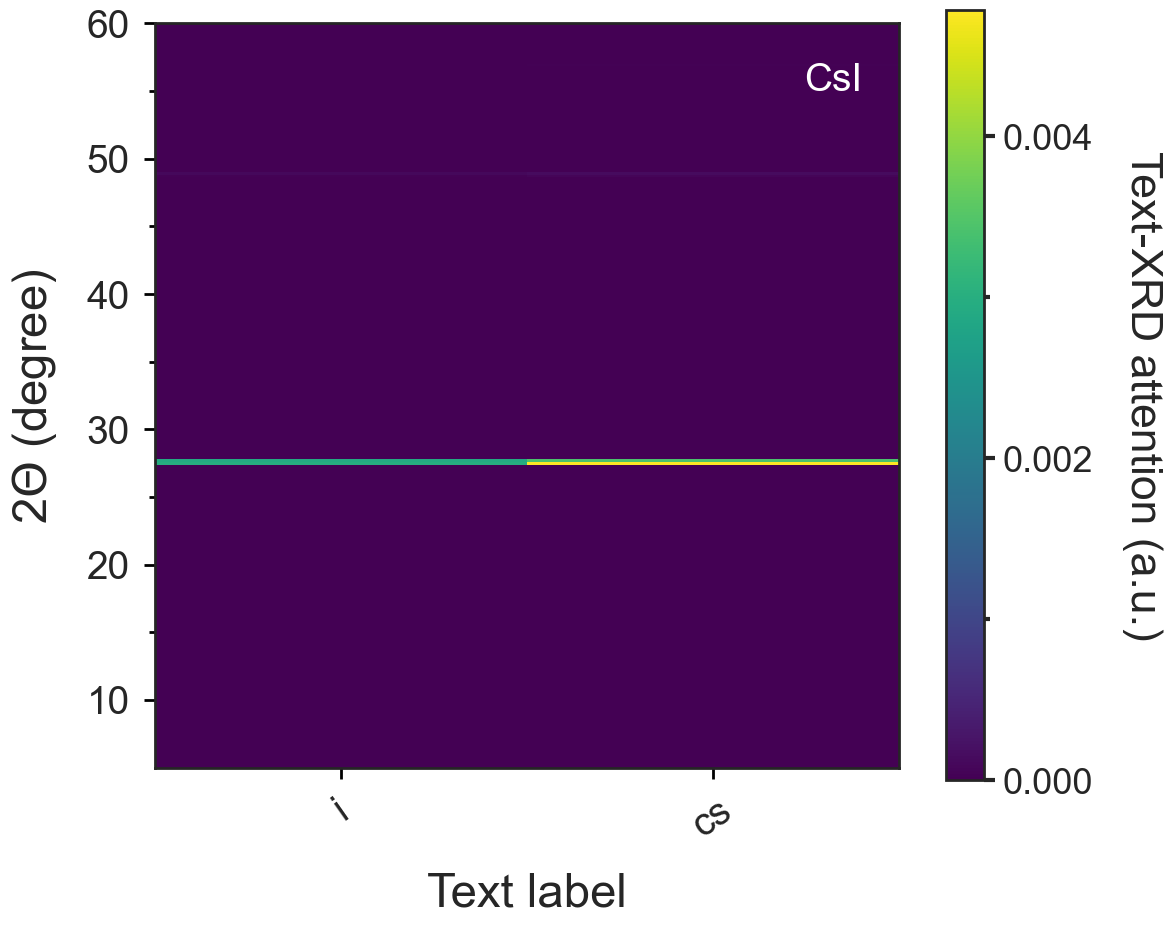

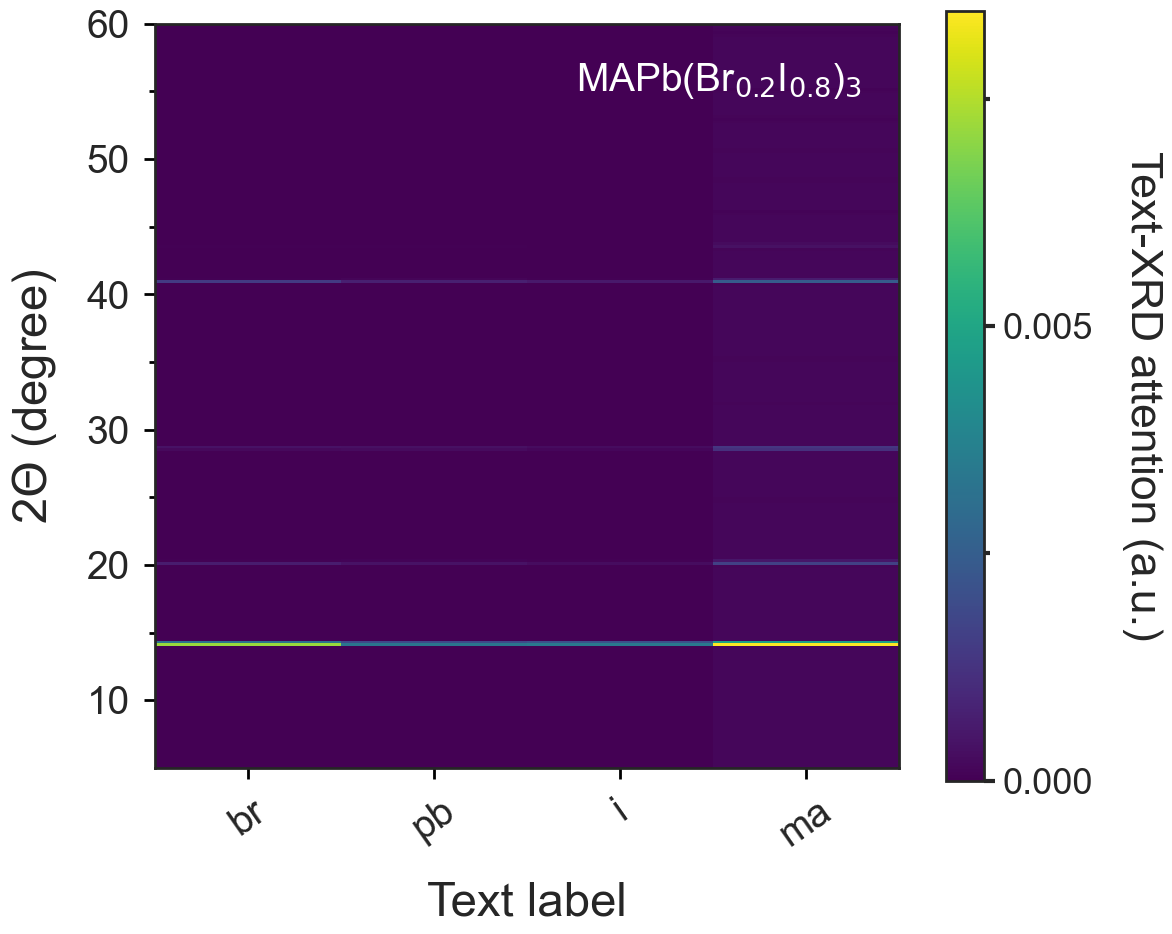

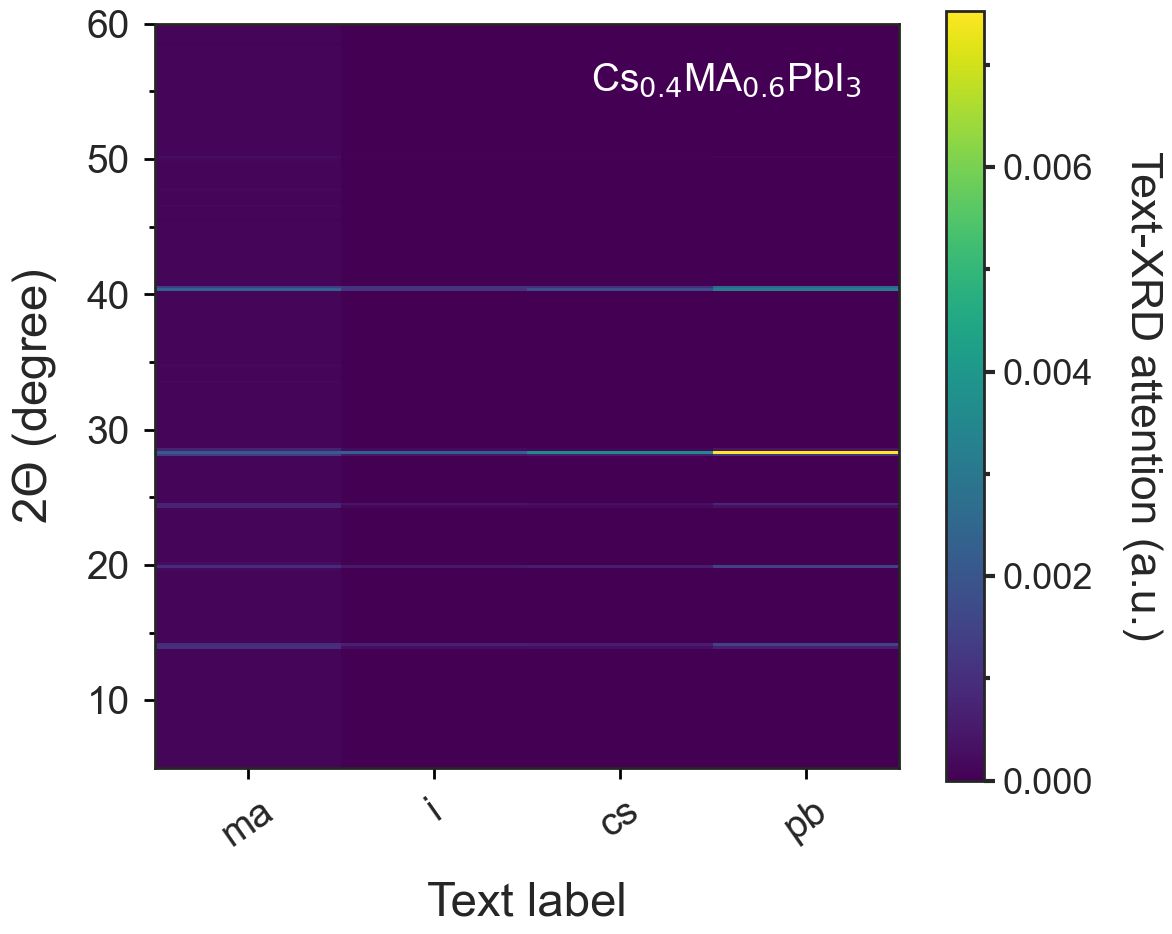

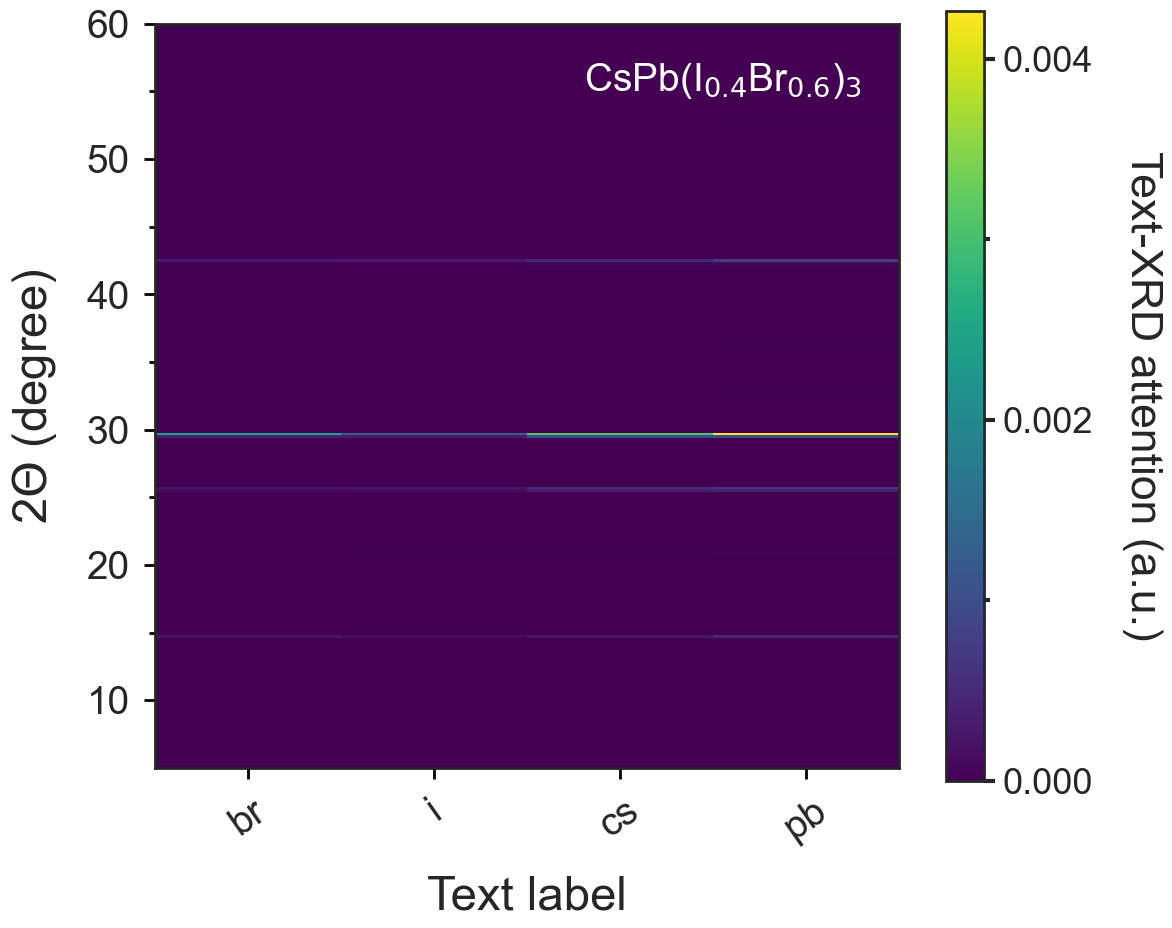

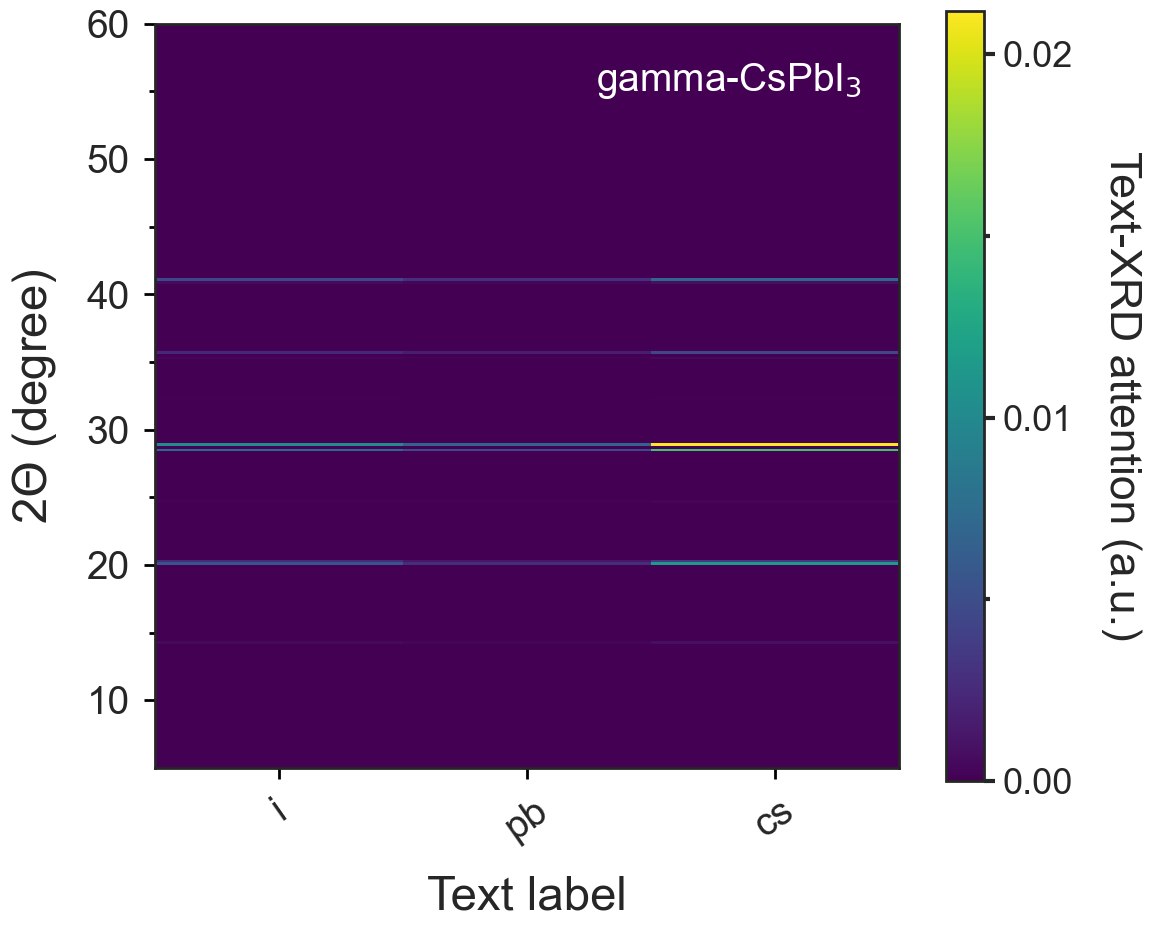

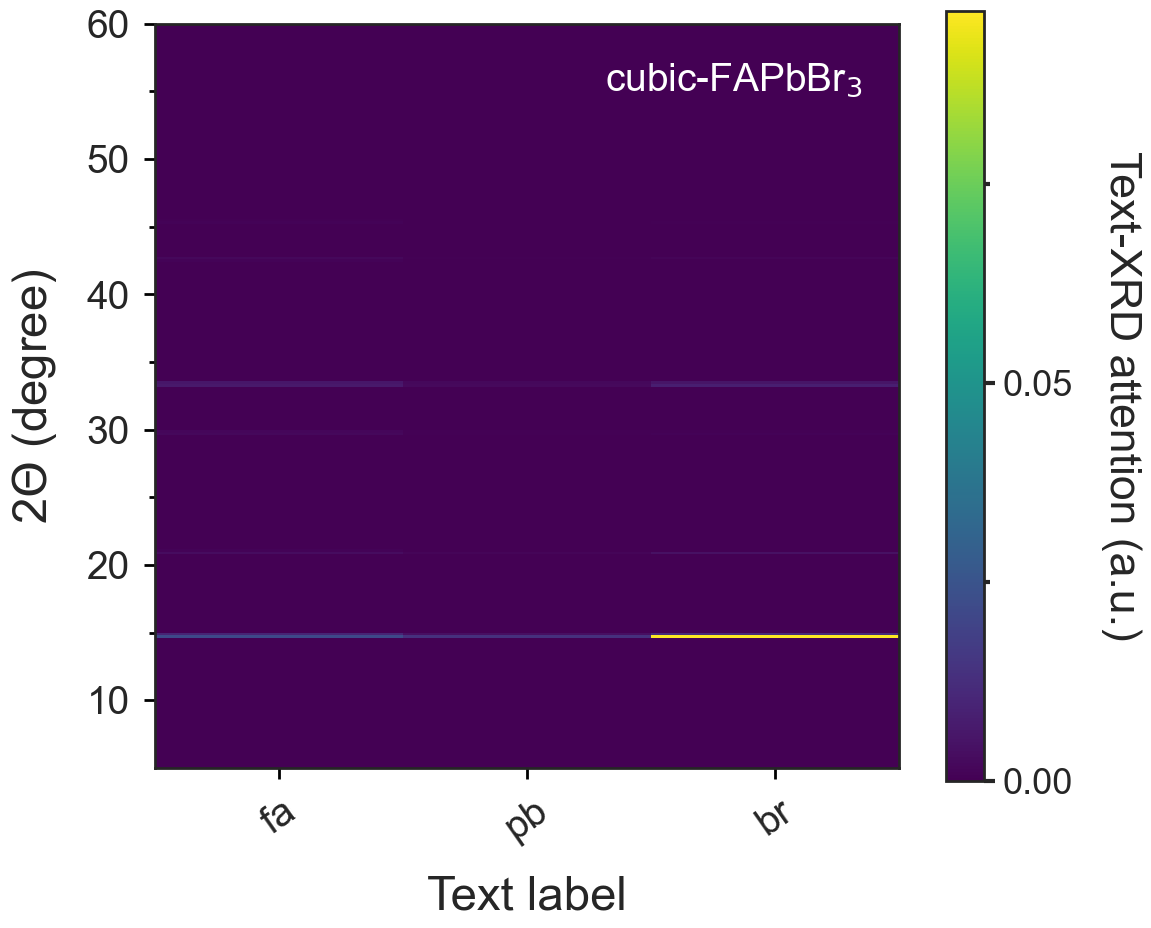

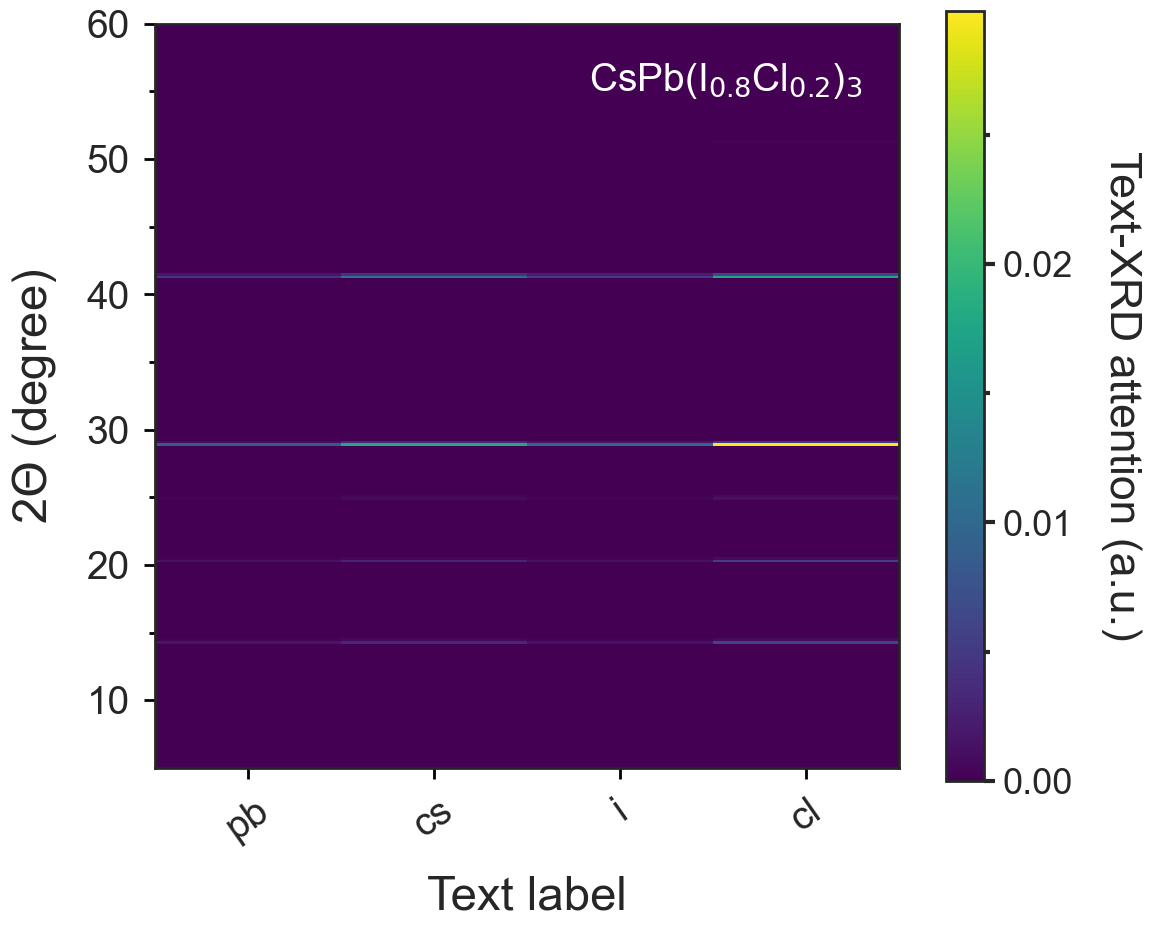

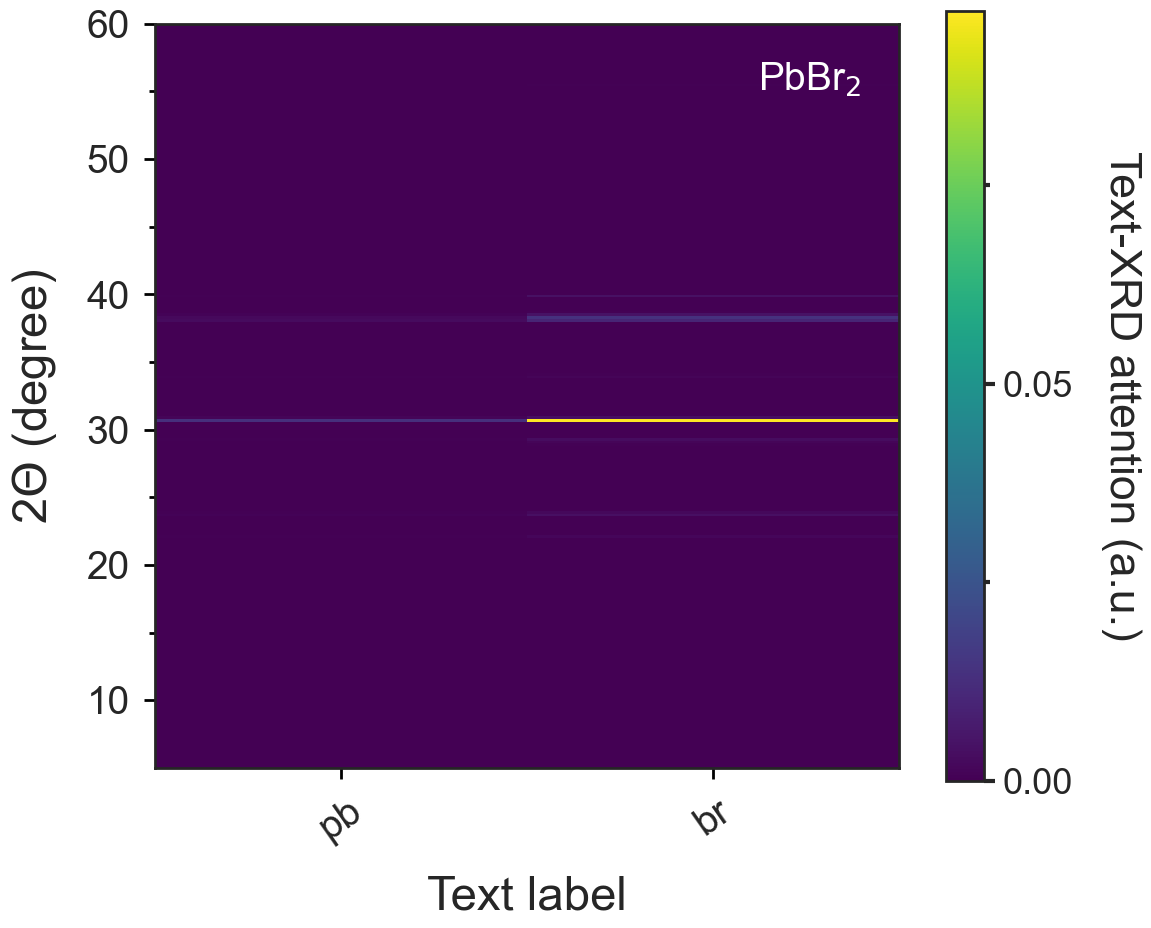

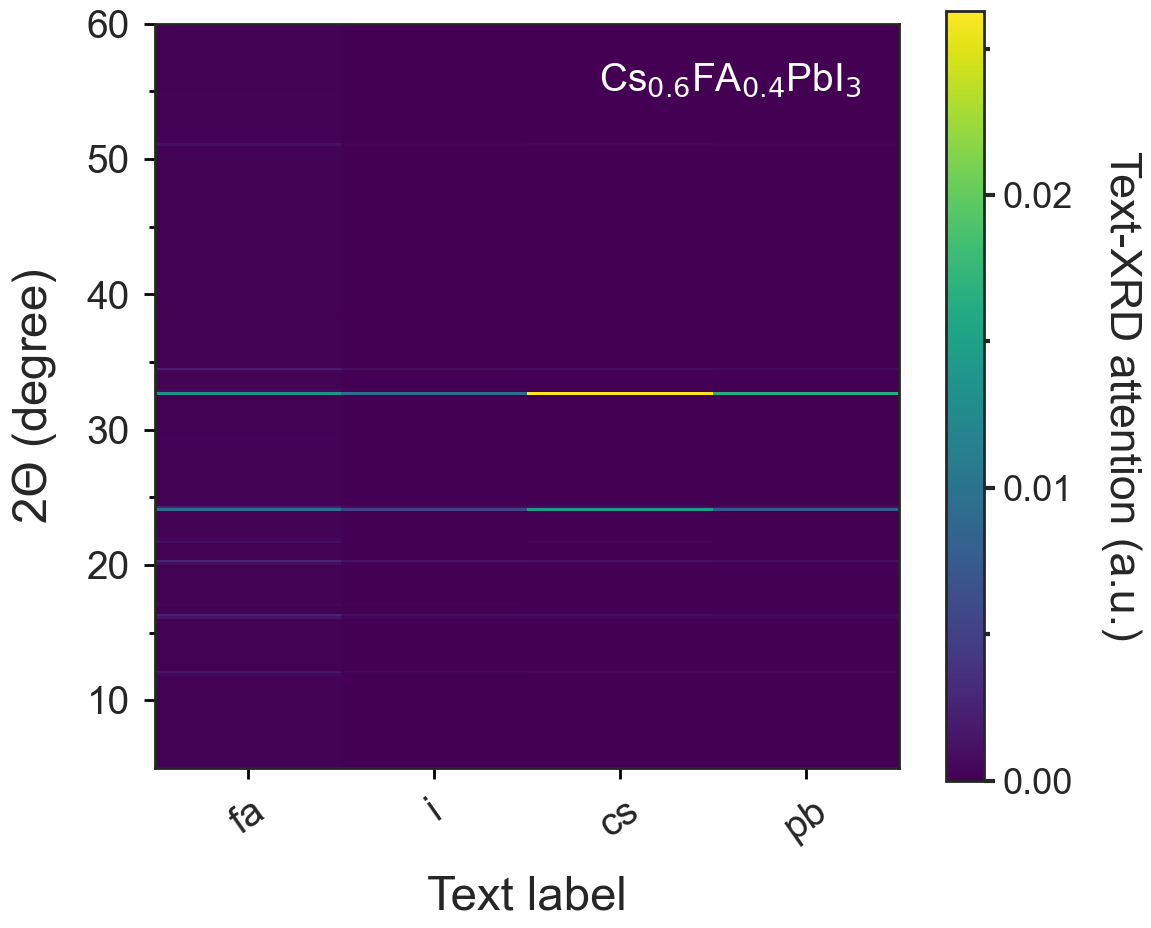

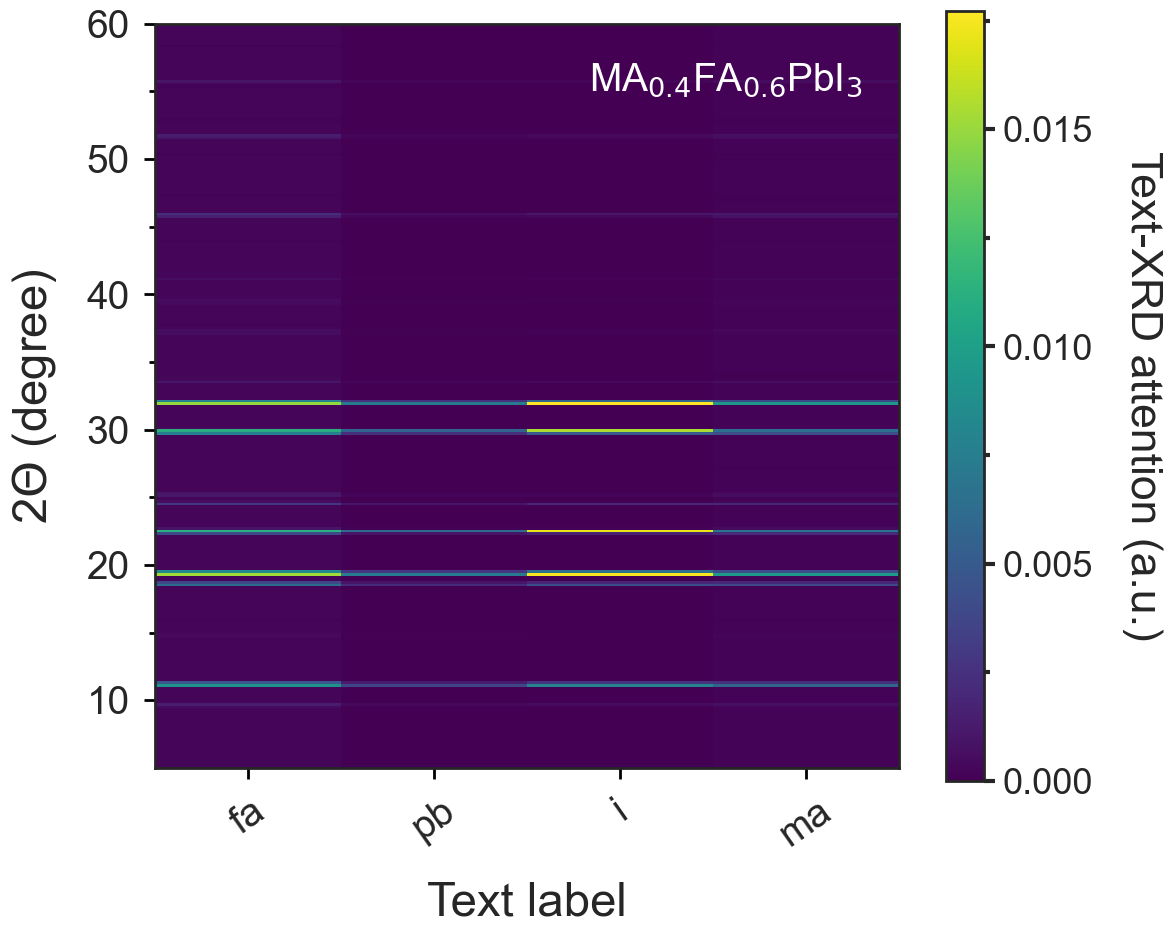

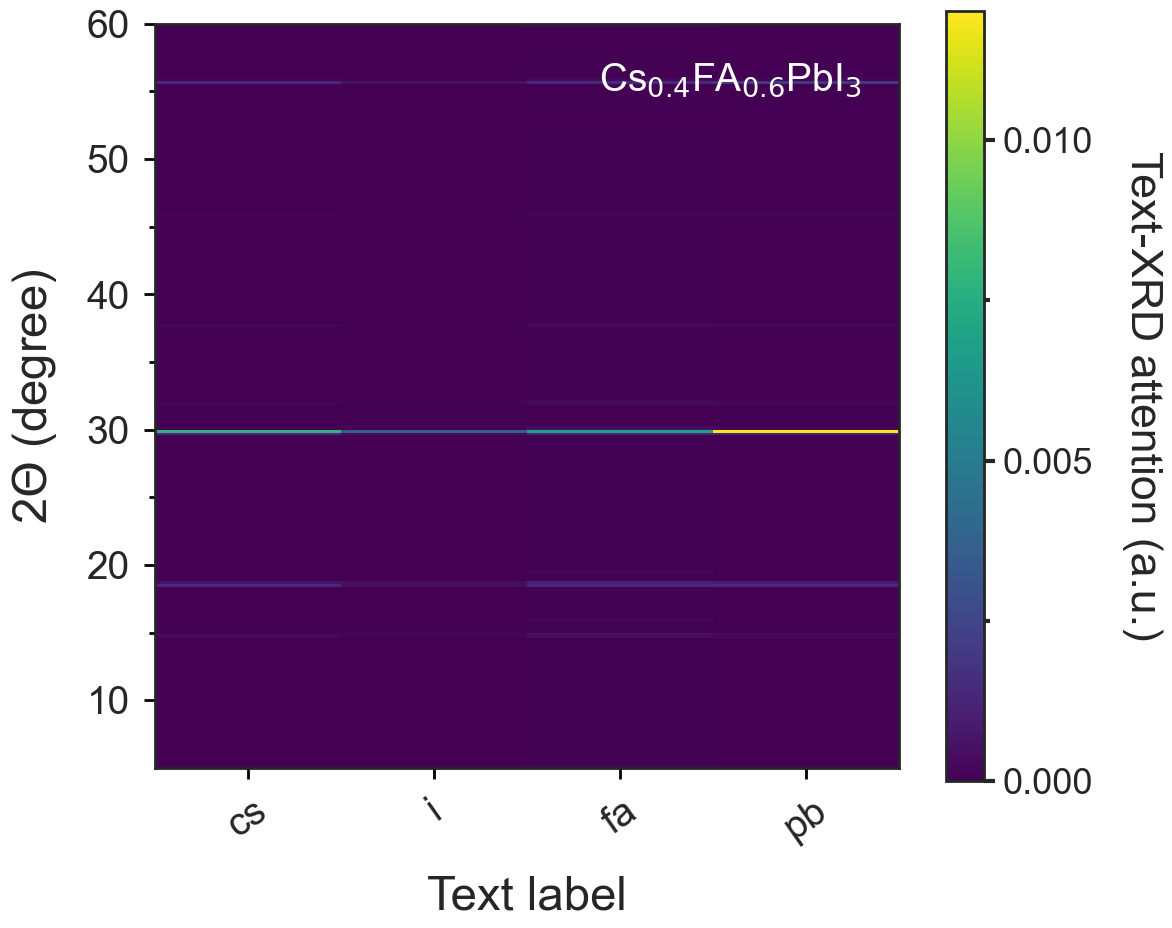

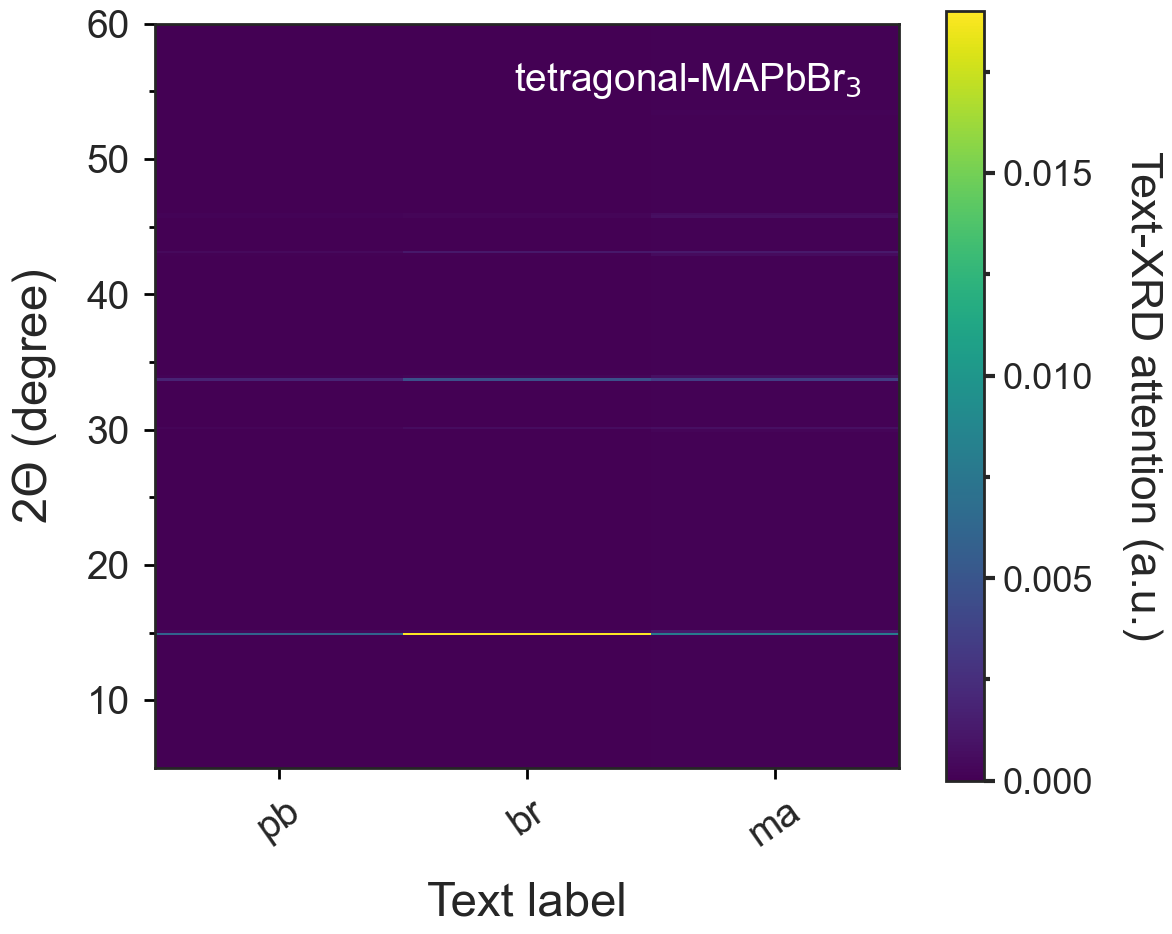

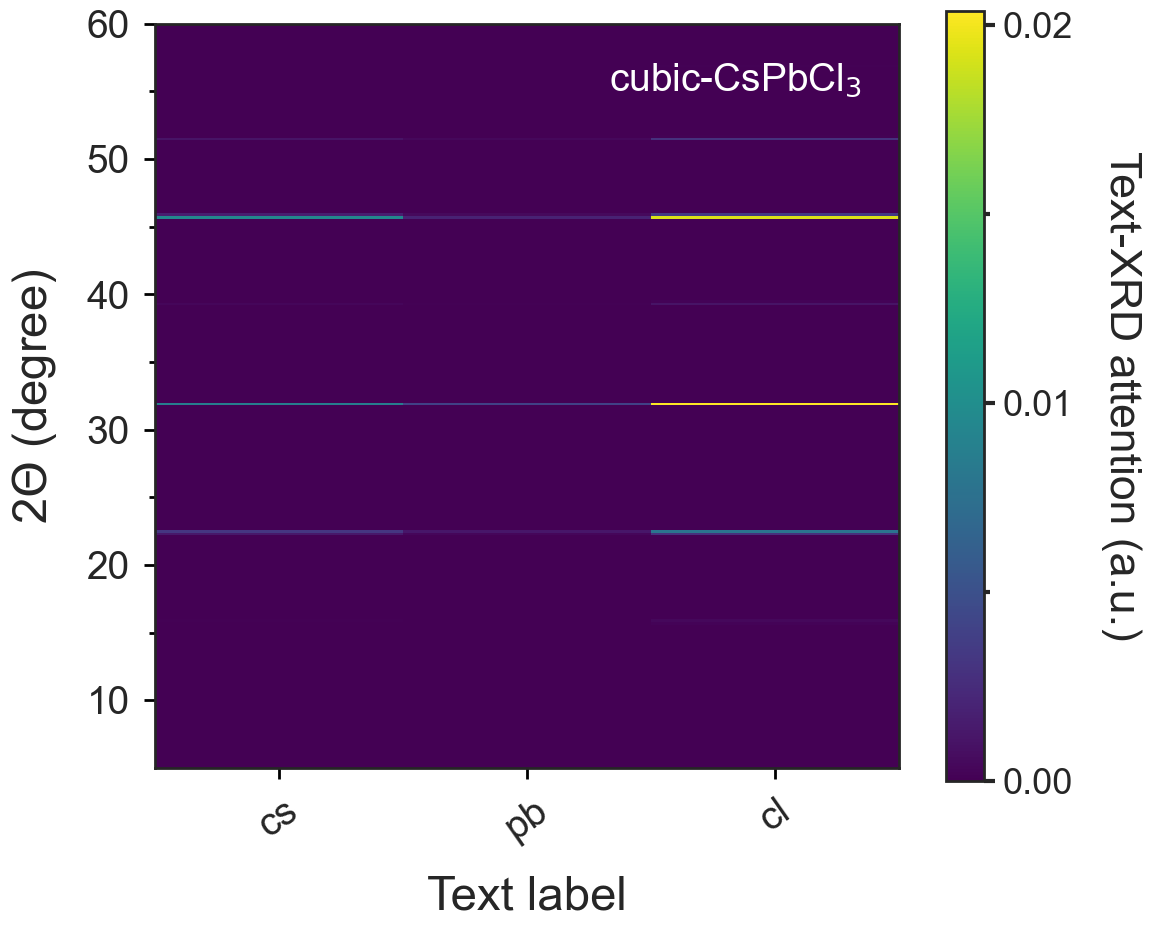

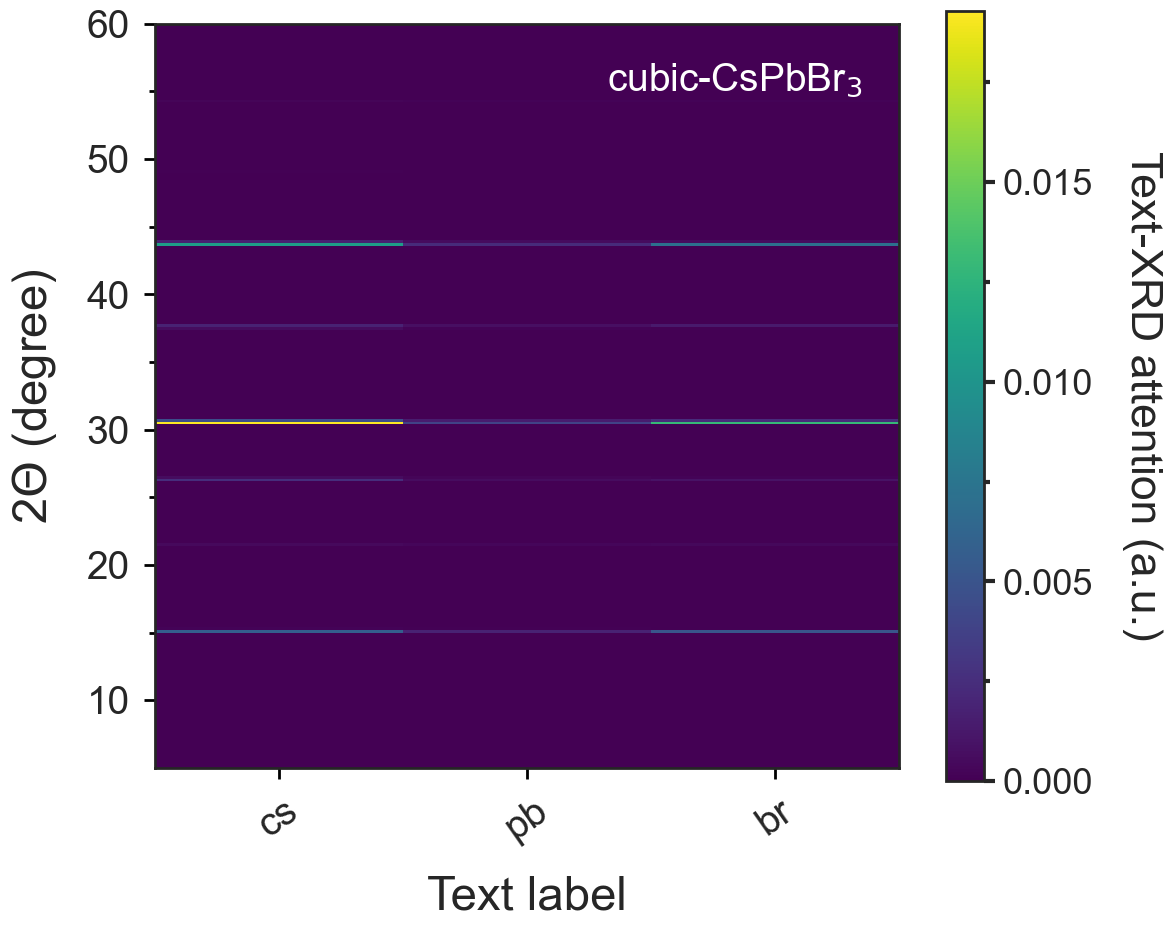

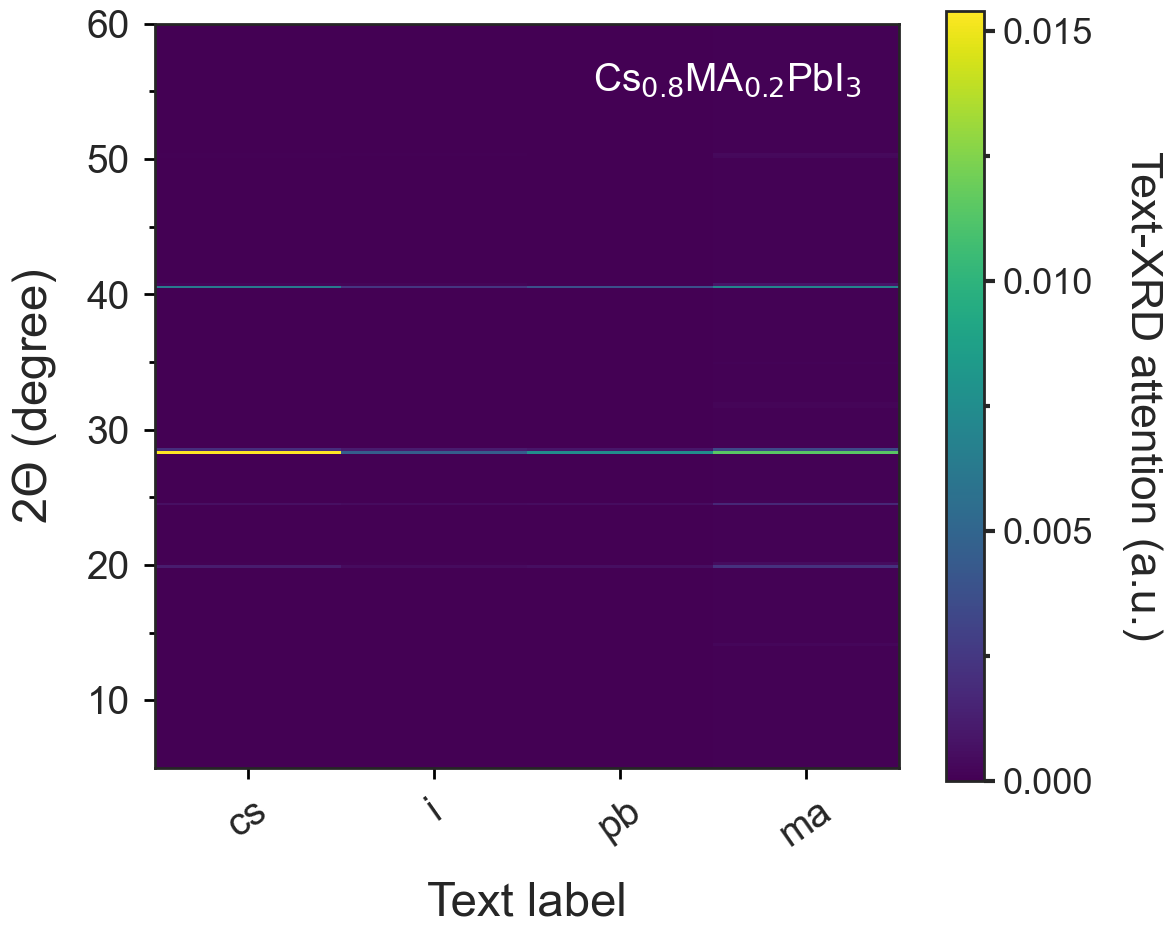

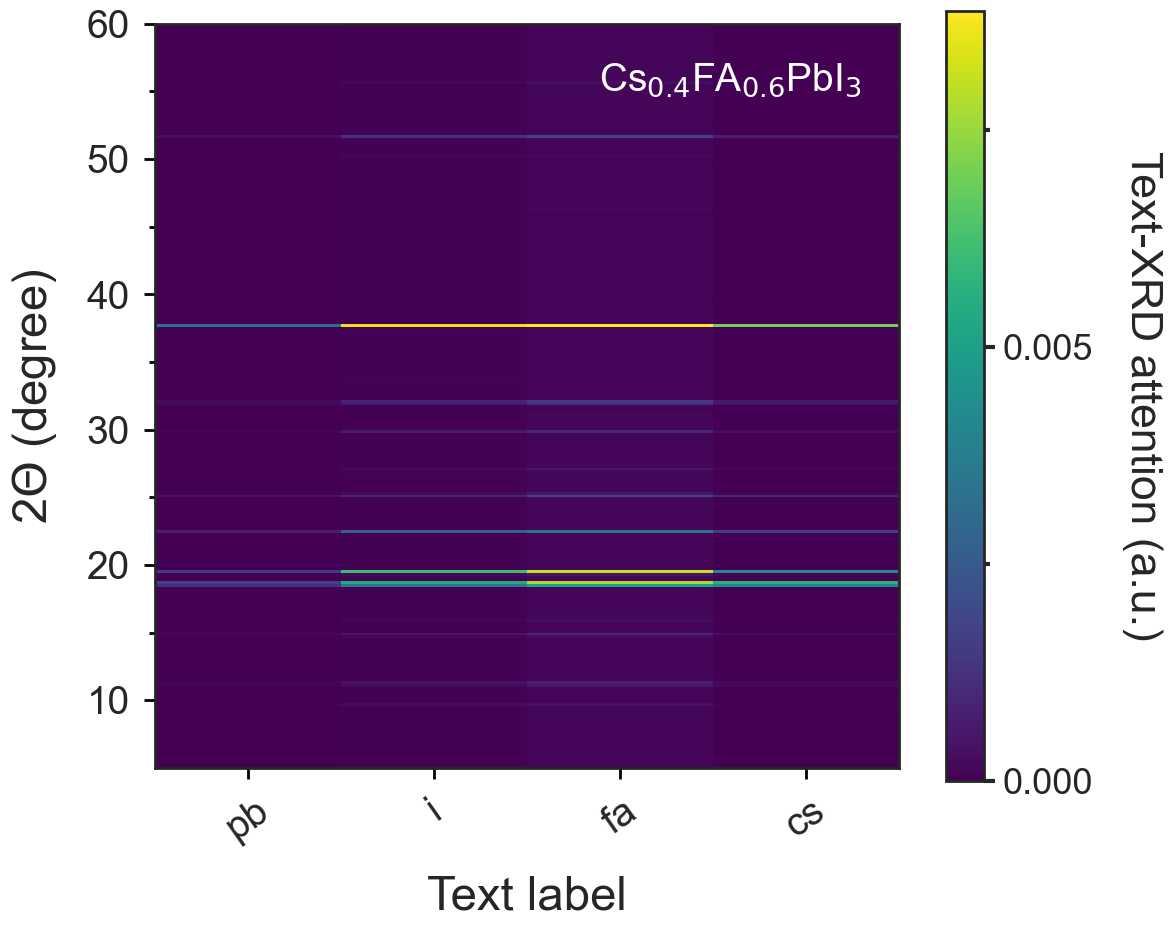

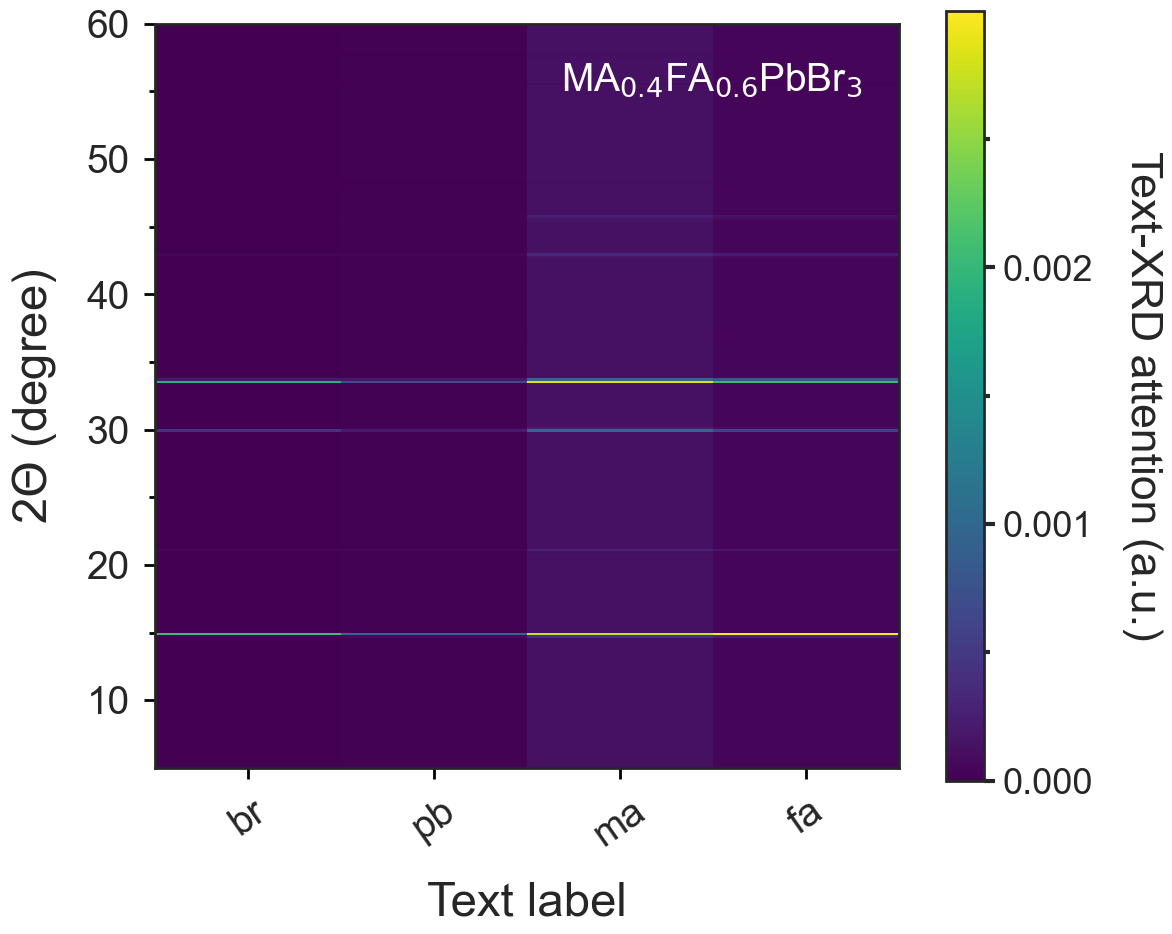

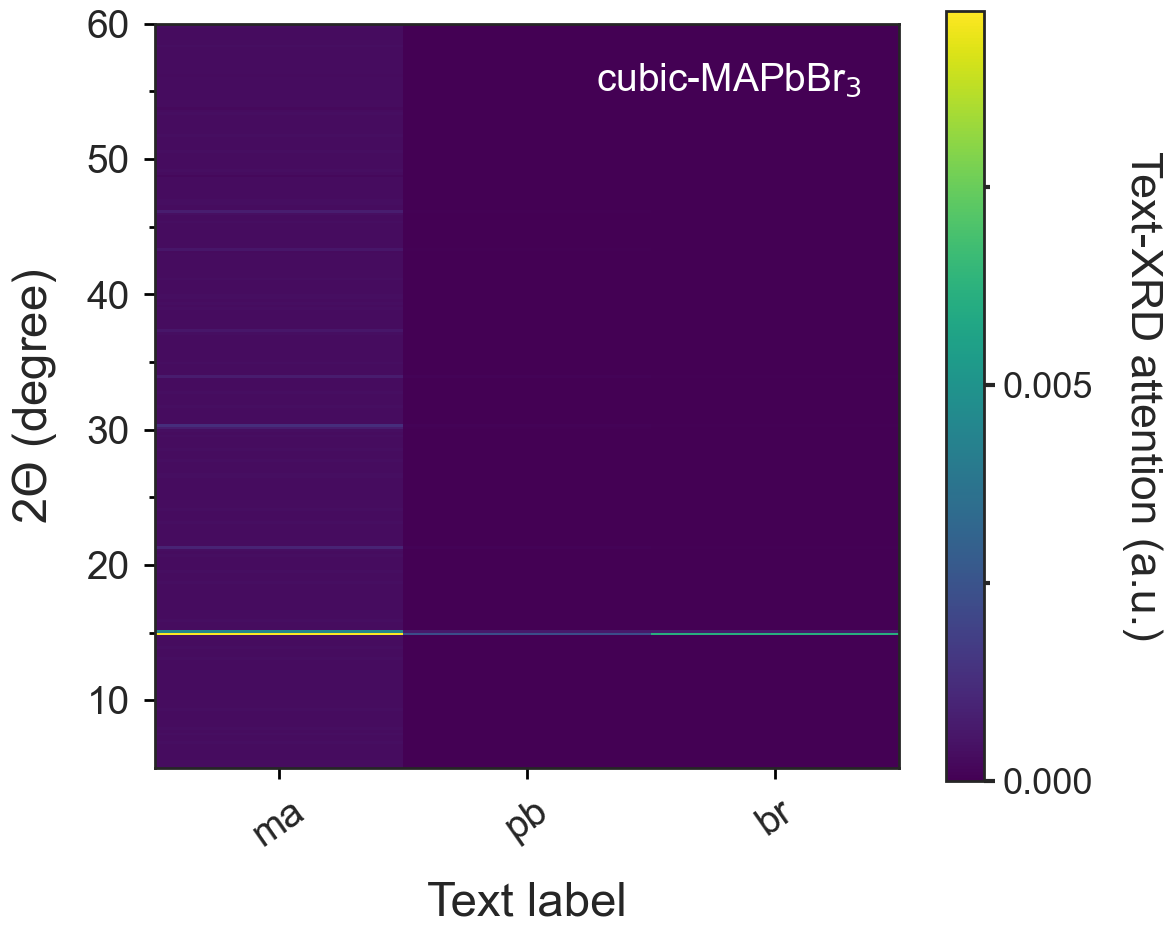

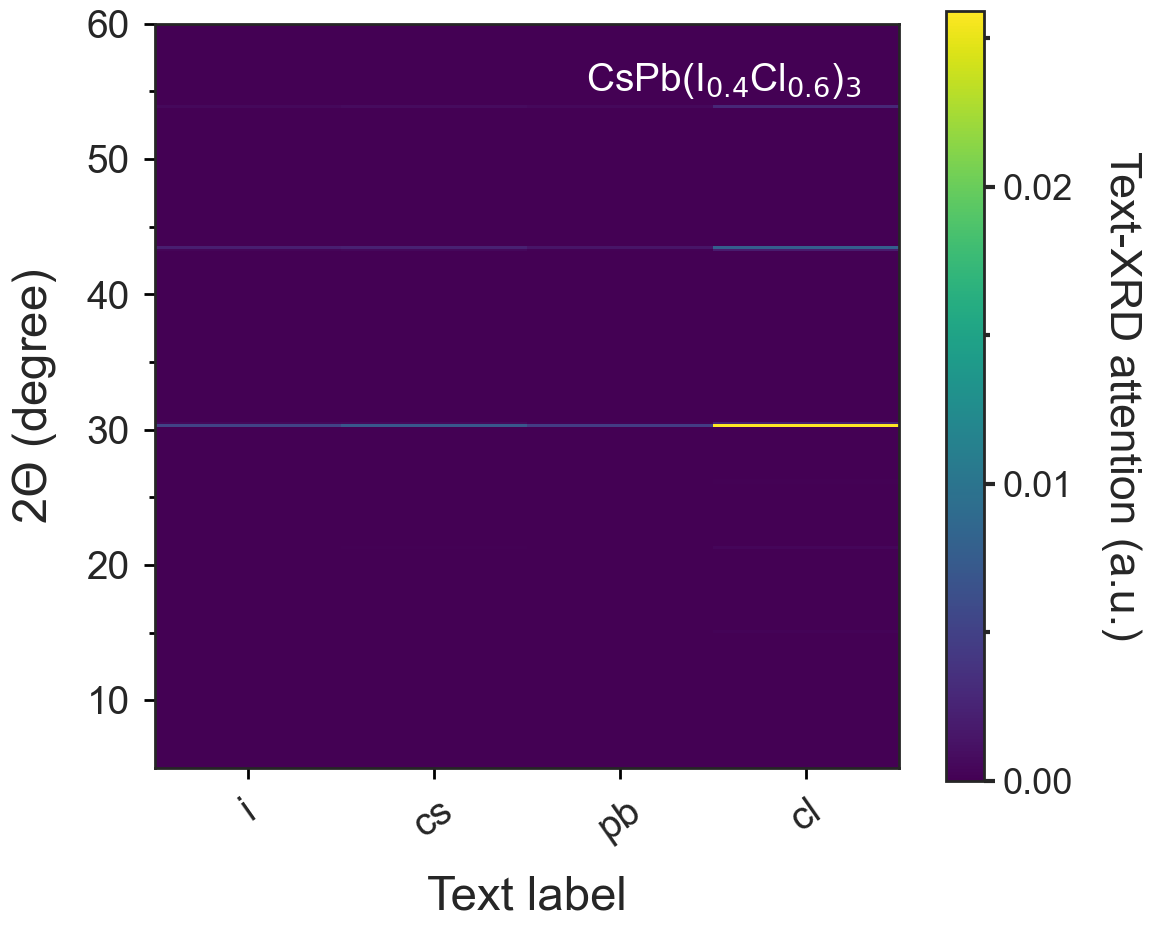

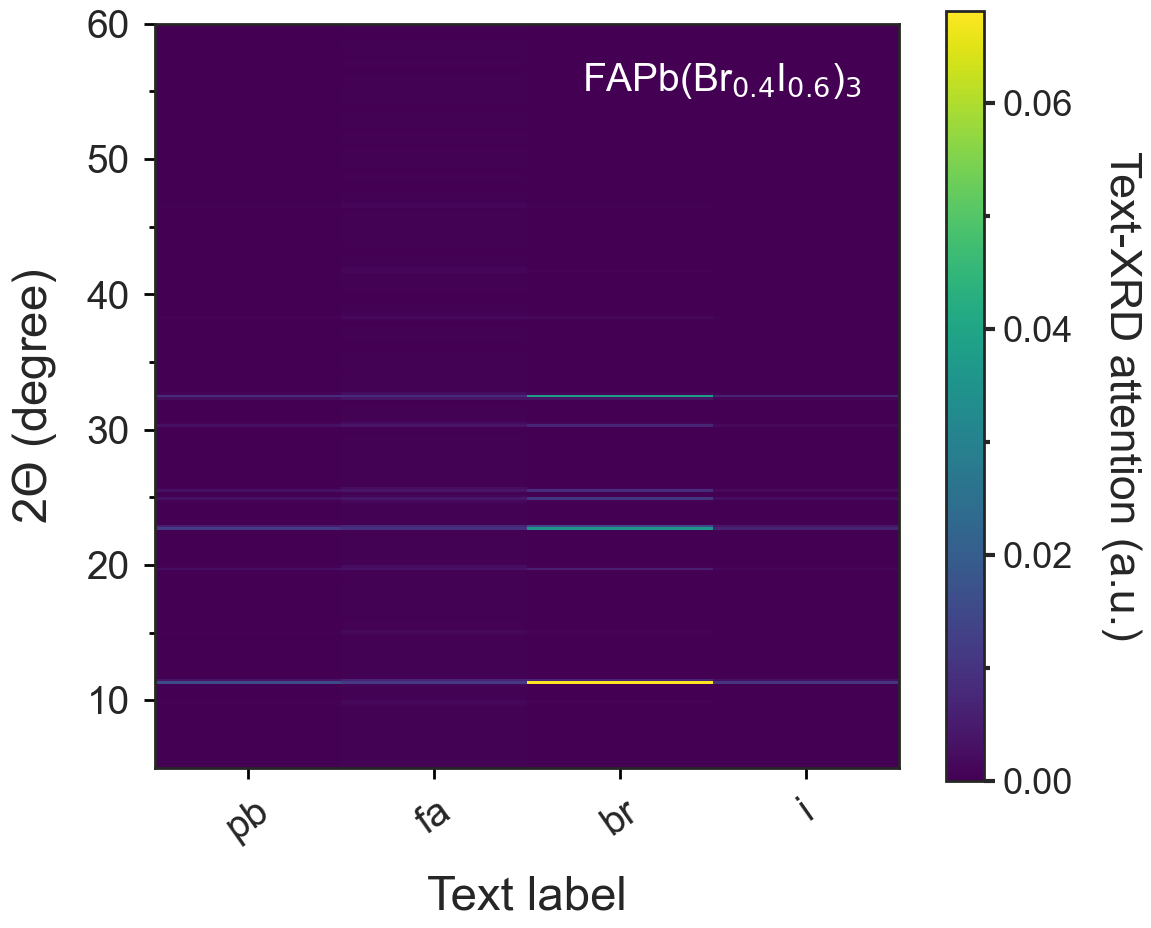

In [336]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(30):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    
    Y = np.array(outputs.attentions[0].detach().cpu())[0,0,1:len(inputs['input_ids'][0])-1,len(inputs['input_ids'][0]):]
    extent = [0.5,0.5+len(inputs['input_ids'][0])-2,twotheta[0],twotheta[-1]]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='viridis', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1], rotation=35)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
#     ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)
    ax.axes.set_xlim([0.5,0.5+len(inputs['input_ids'][0])-2])
    ax.axes.set_ylim([5,60])

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Text-XRD attention (a.u.)',labelpad=50, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Text label', labelpad=20, fontsize=34)
    ax.set_ylabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    plt.text(0.95, 0.91, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), 
             fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')

    plt.savefig(os.path.join(folder, 'models', model_folder,'{}_attention.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


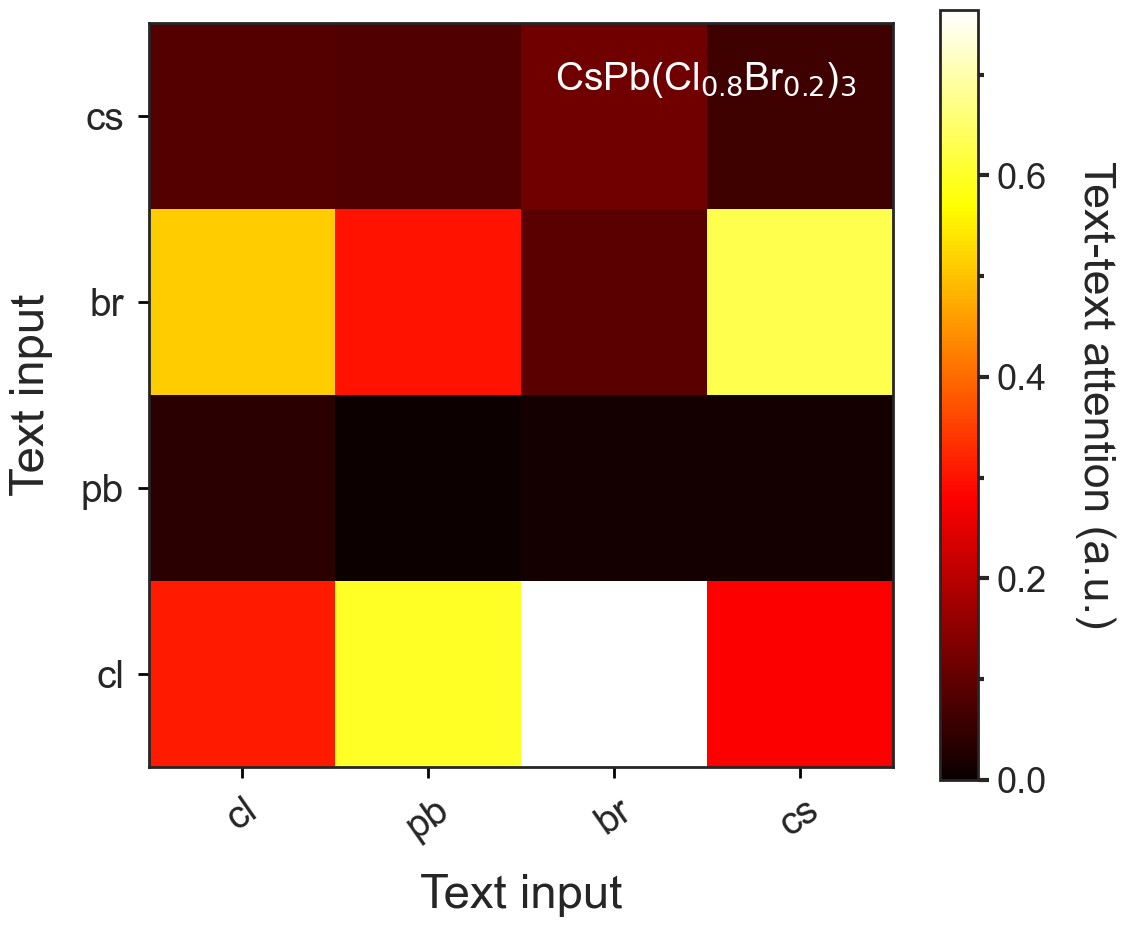

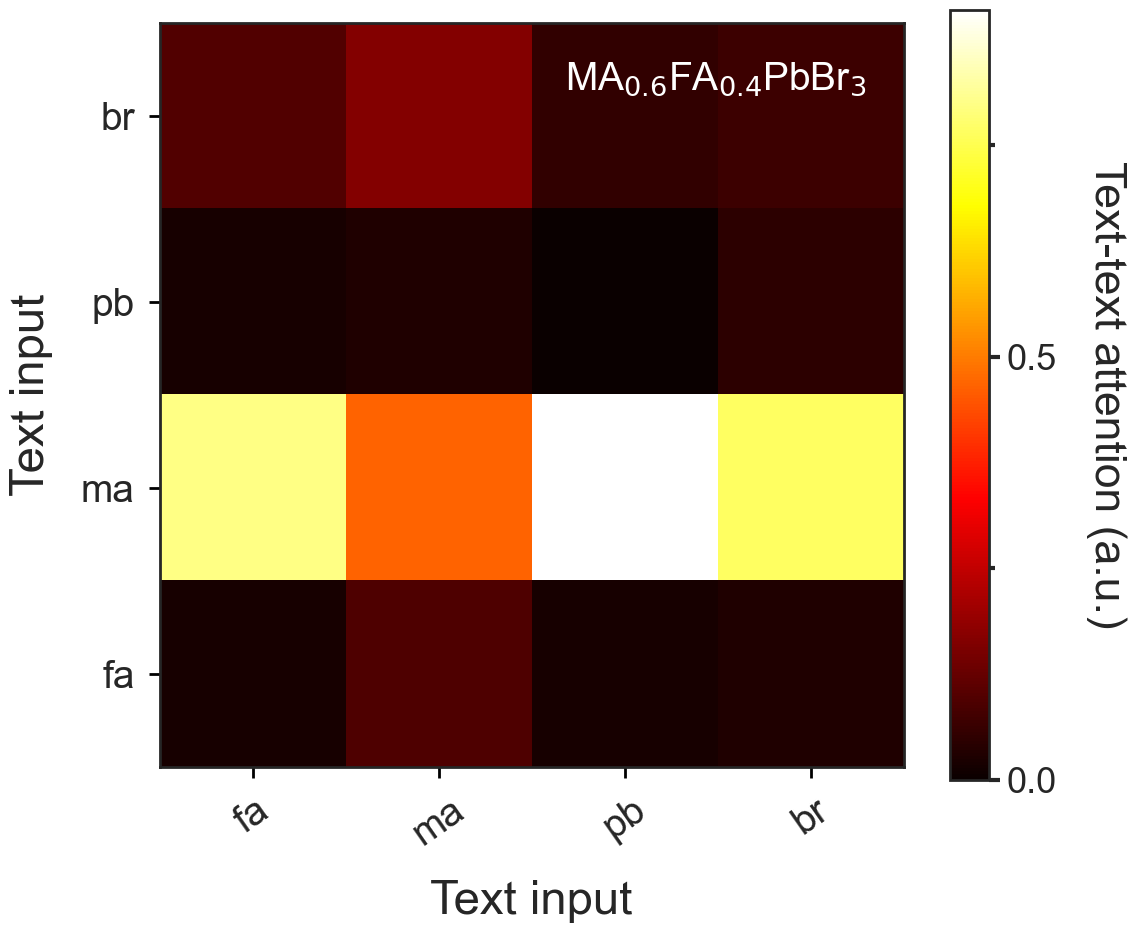

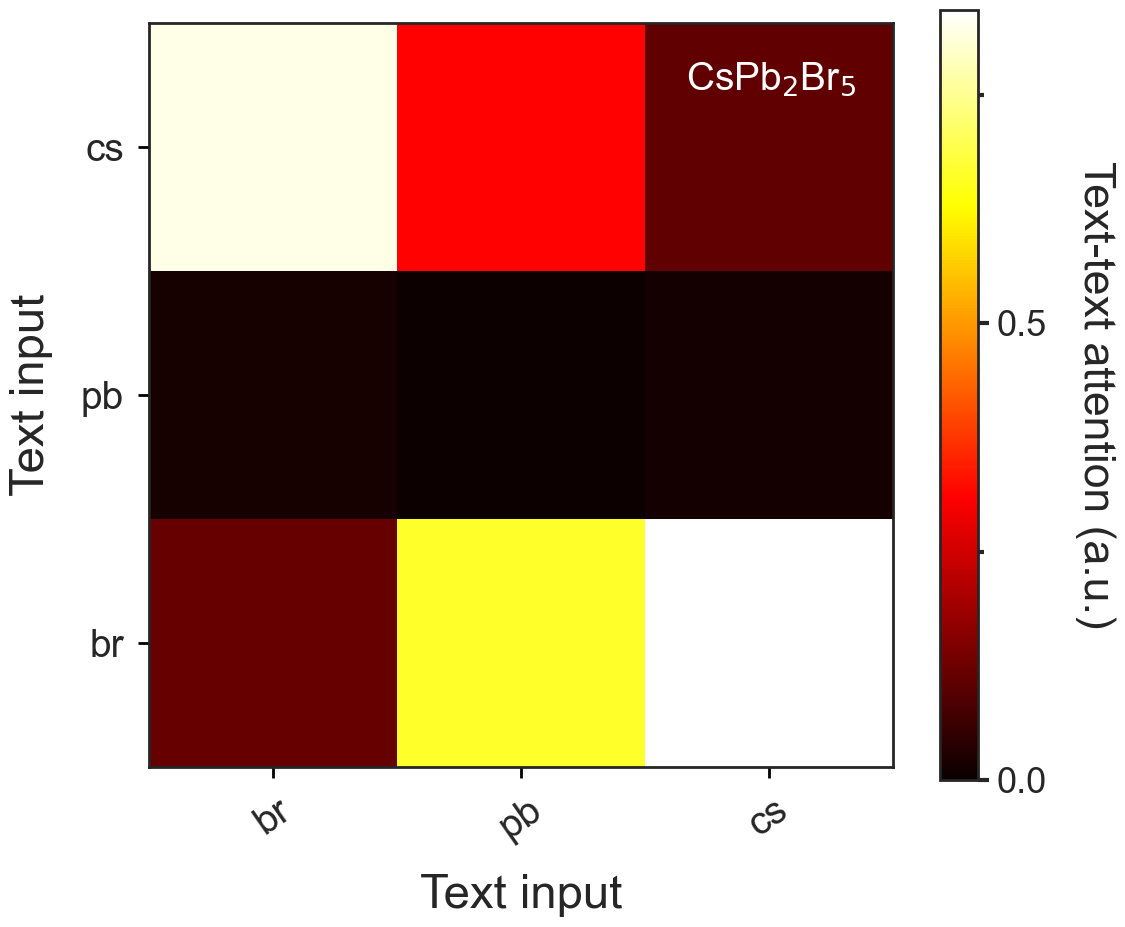

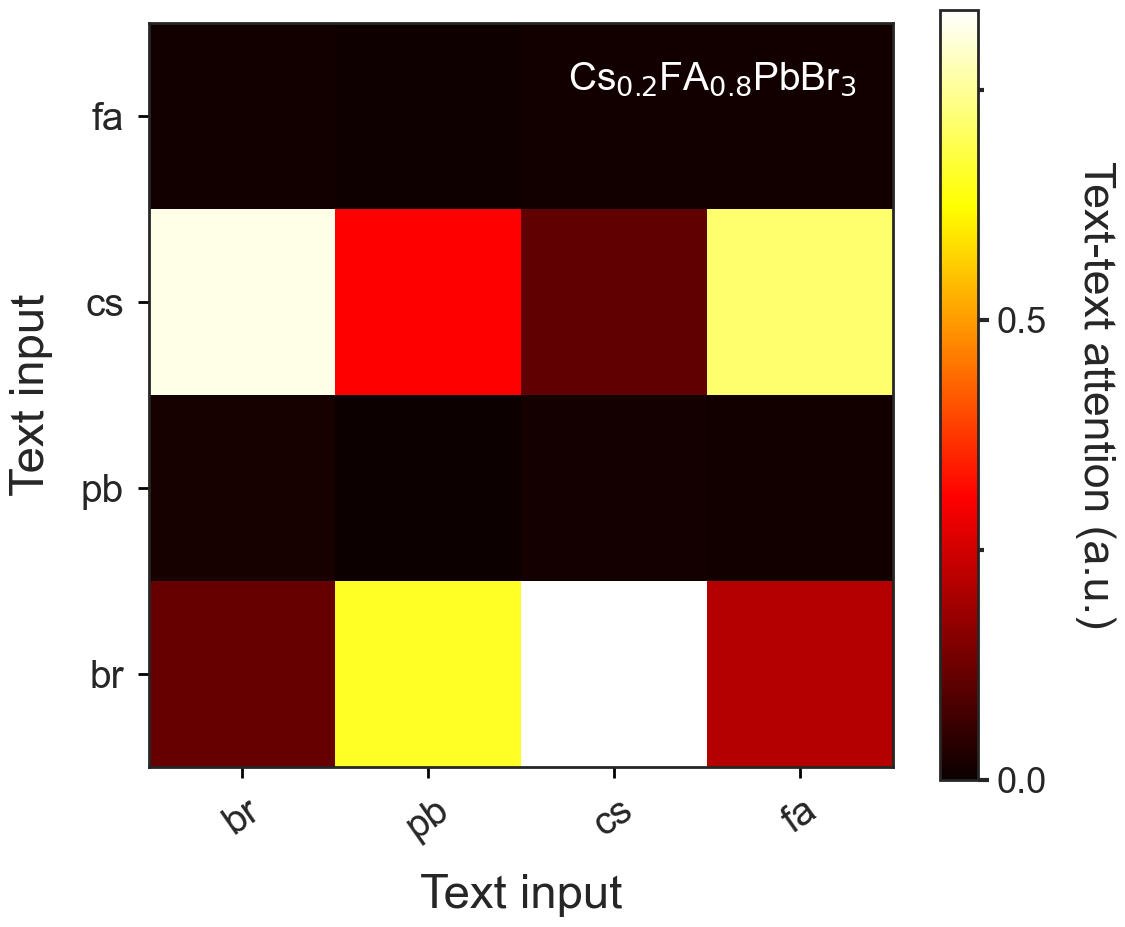

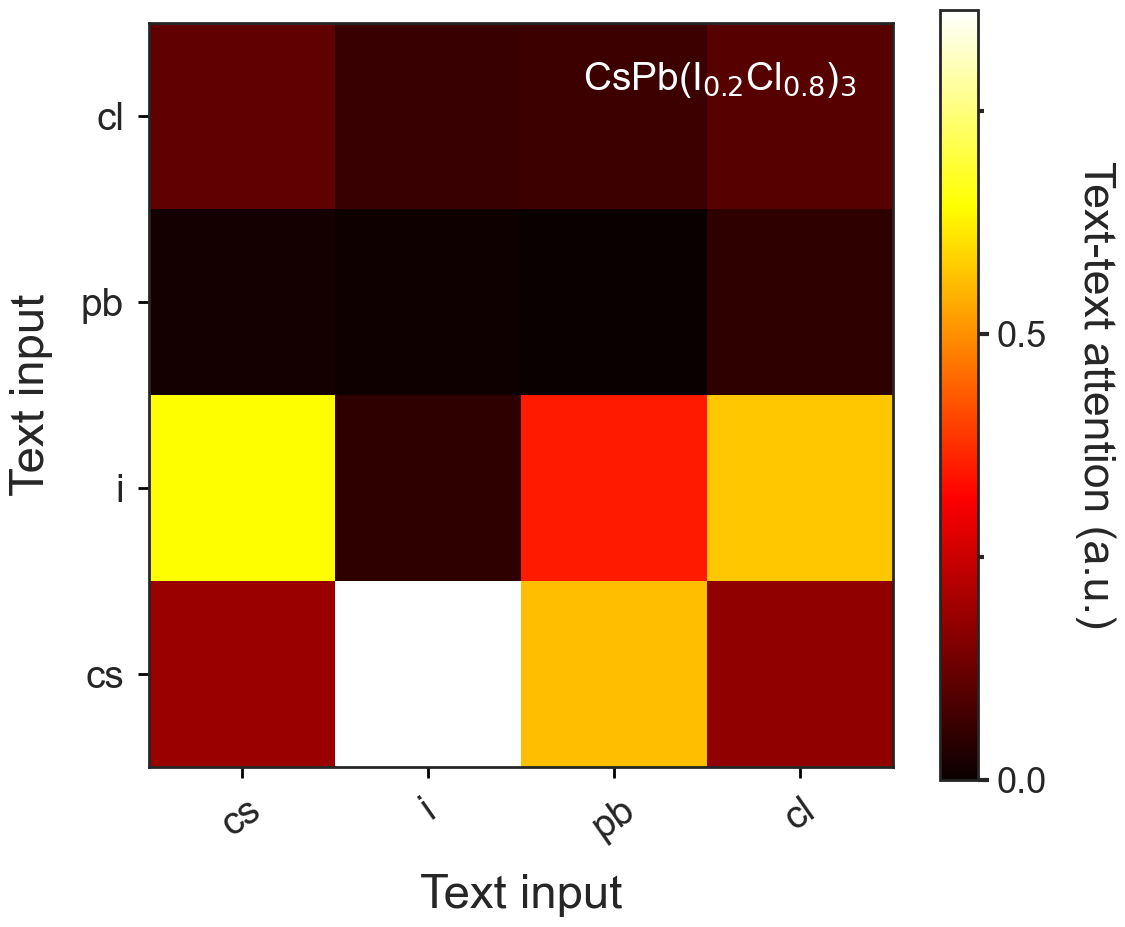

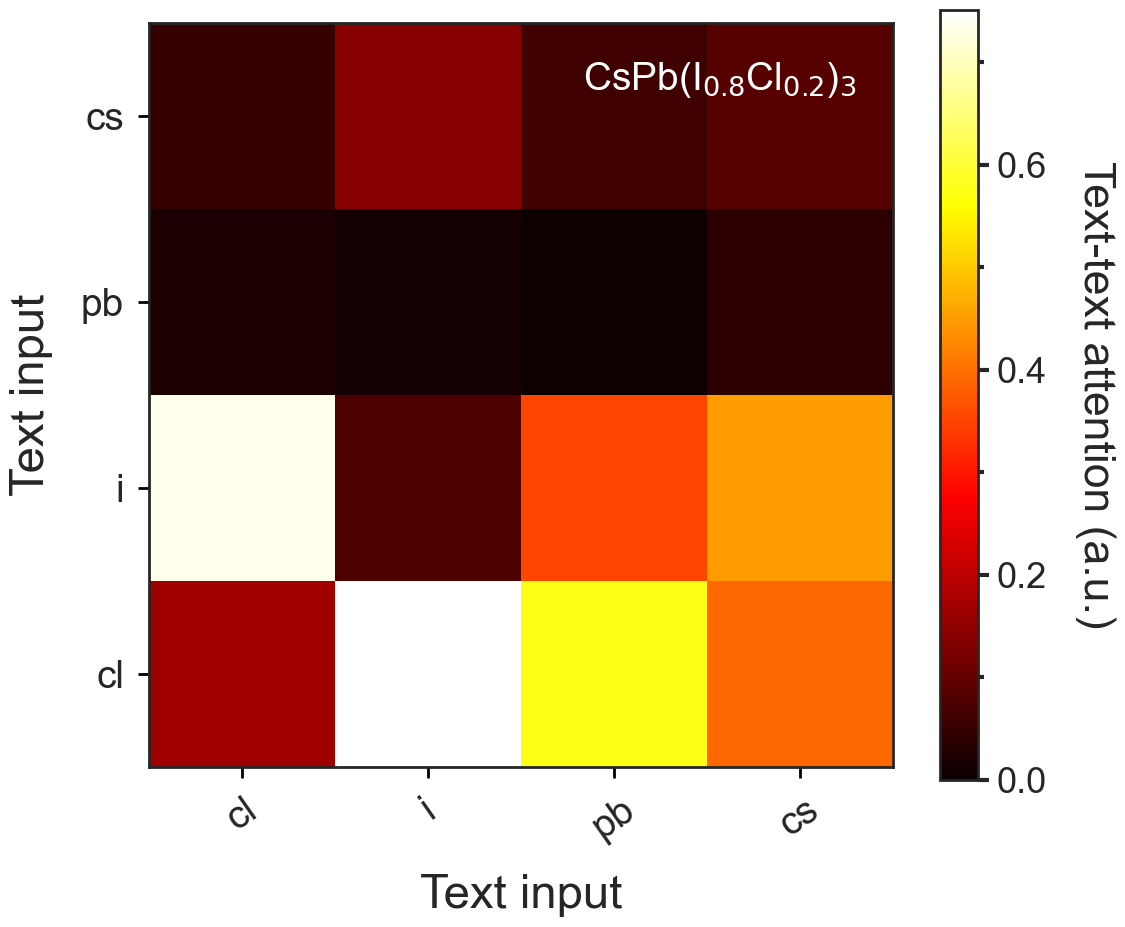

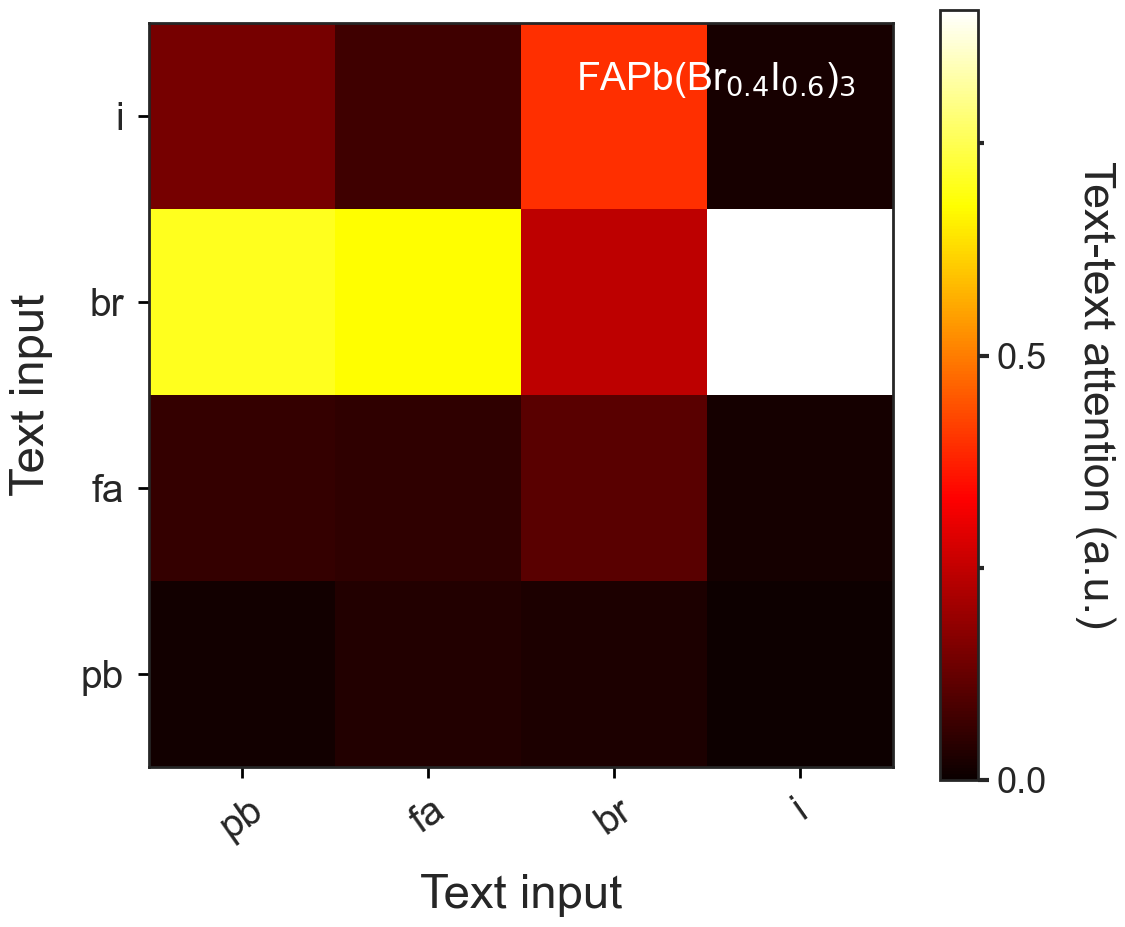

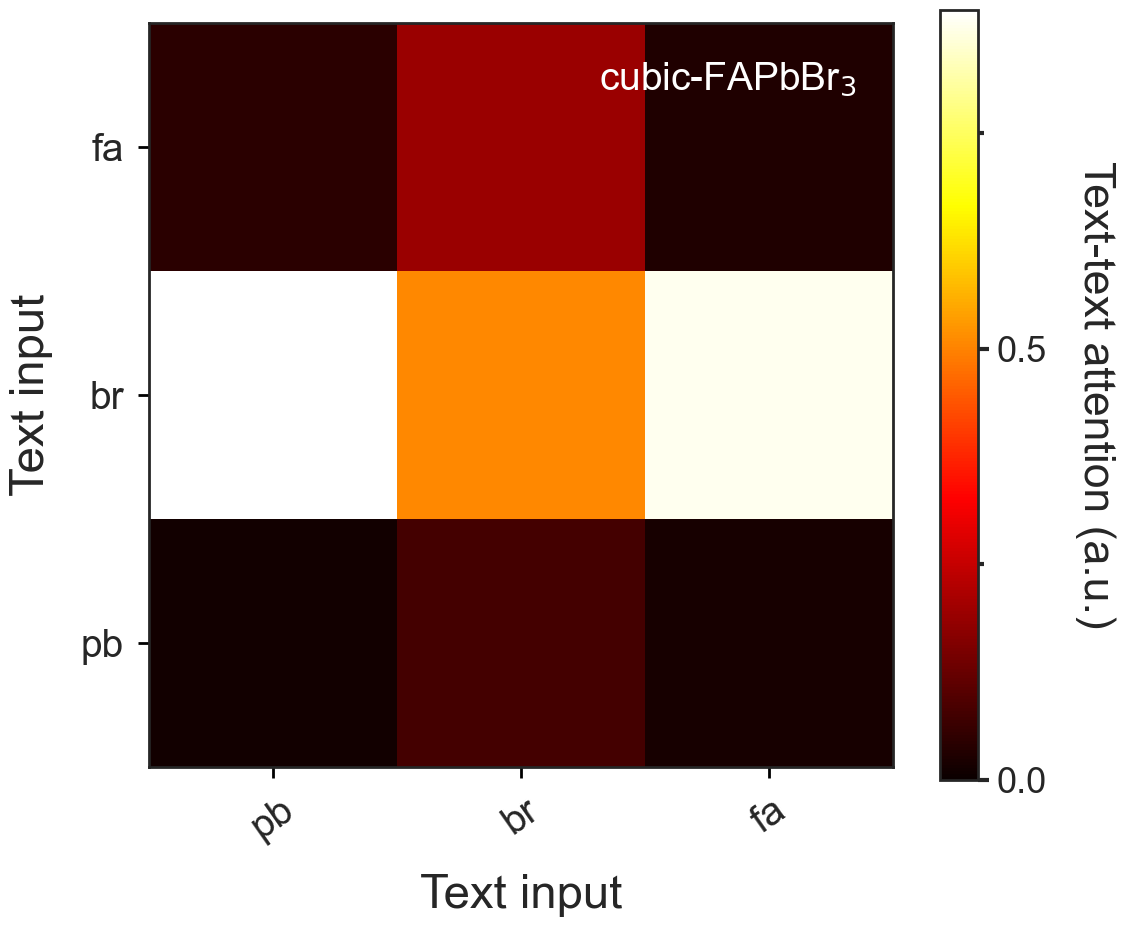

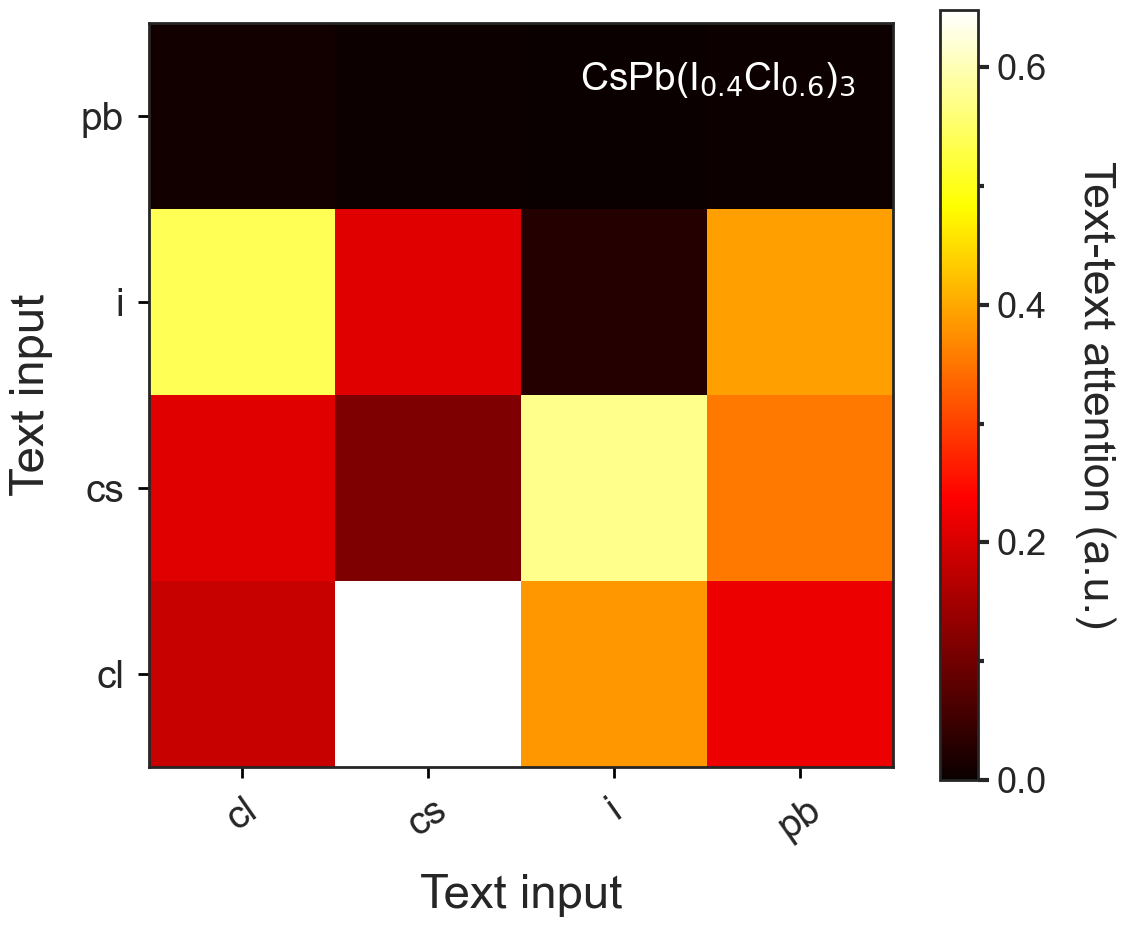

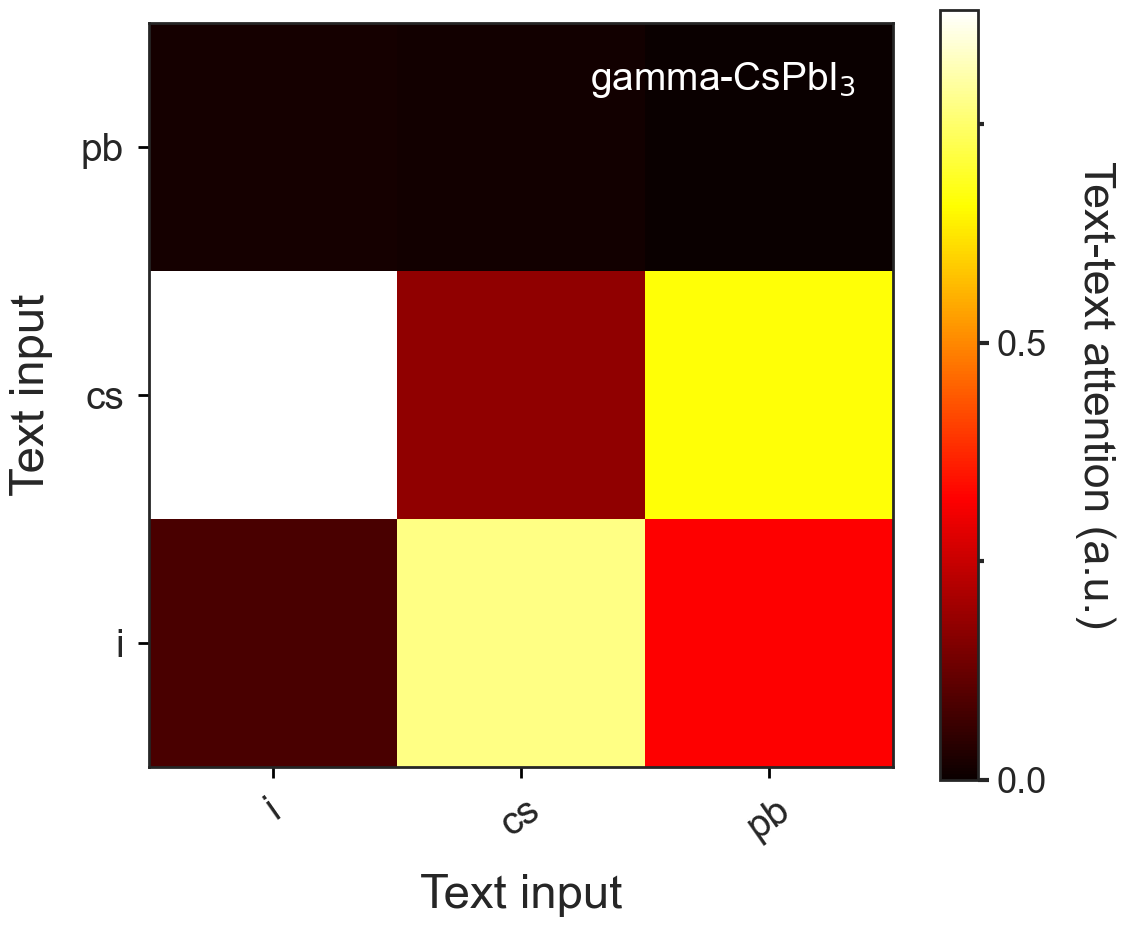

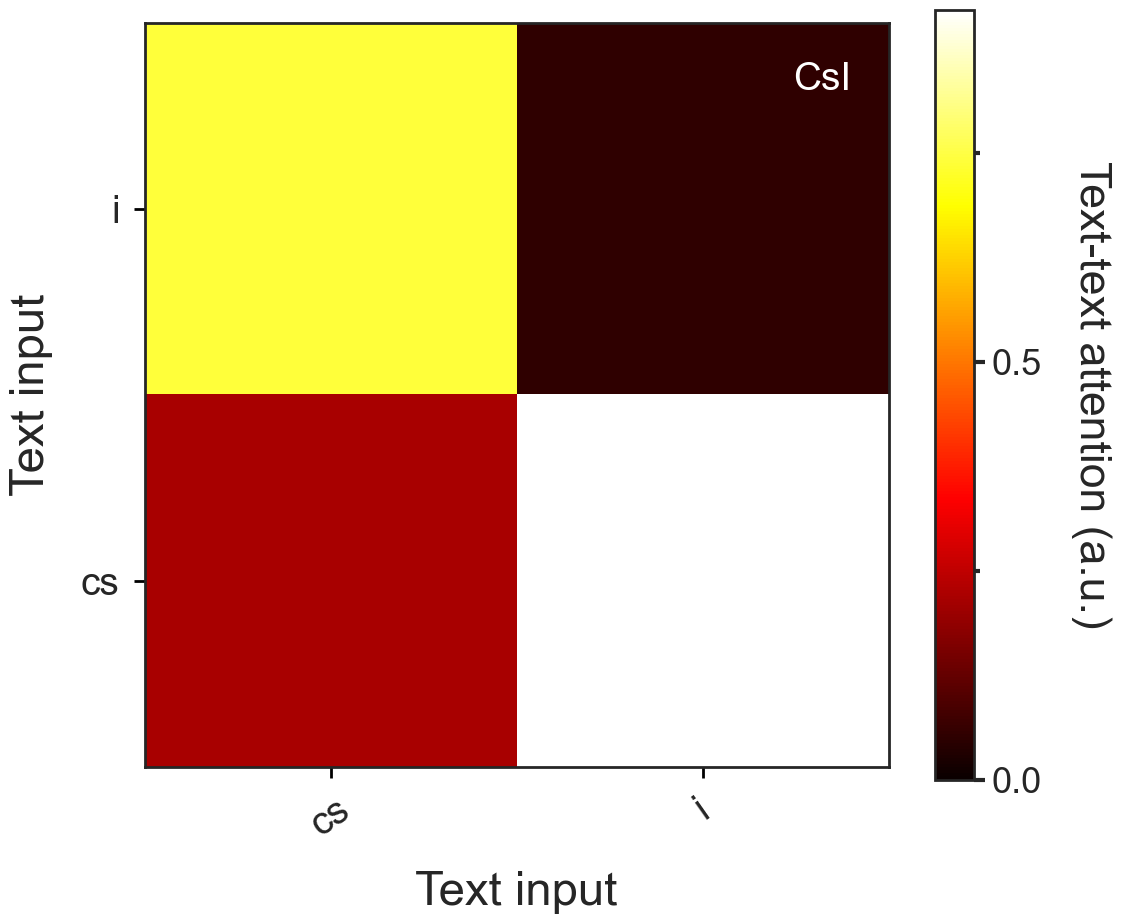

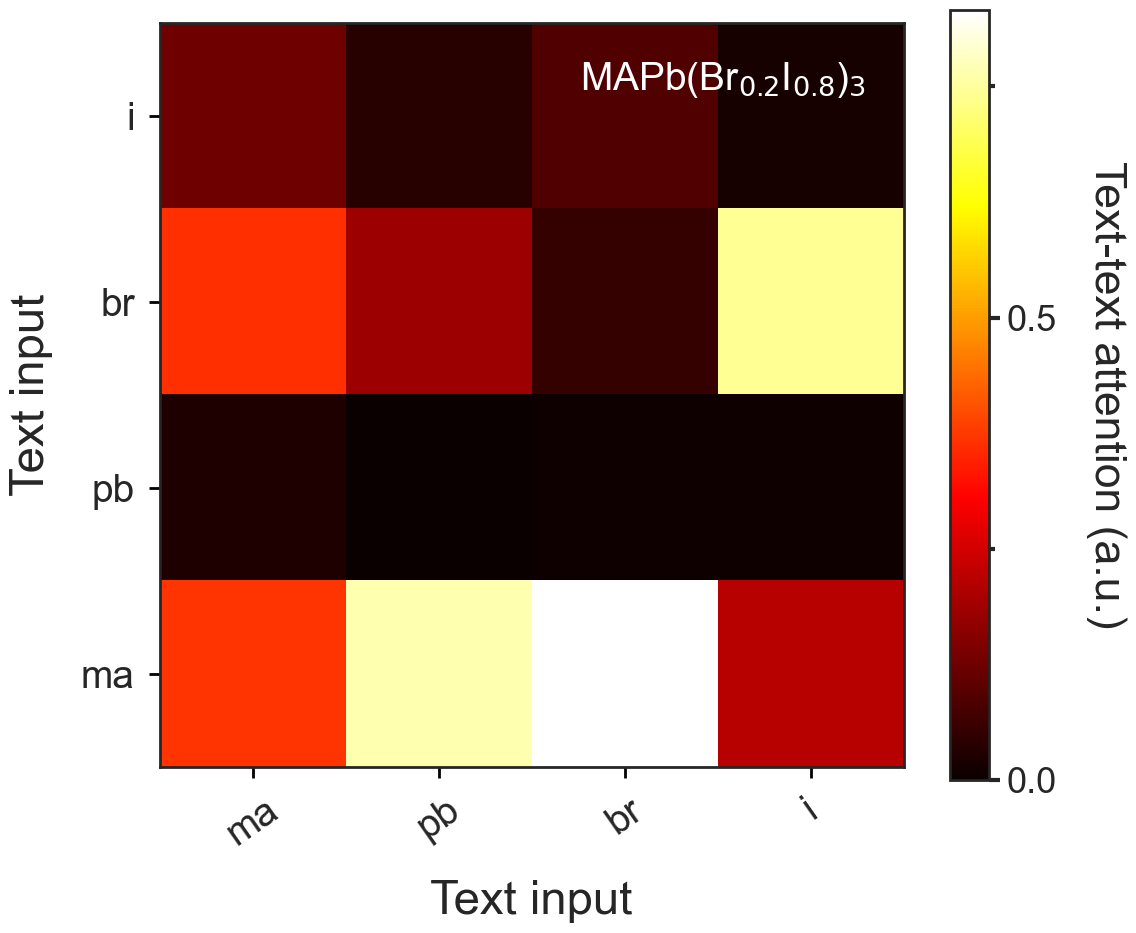

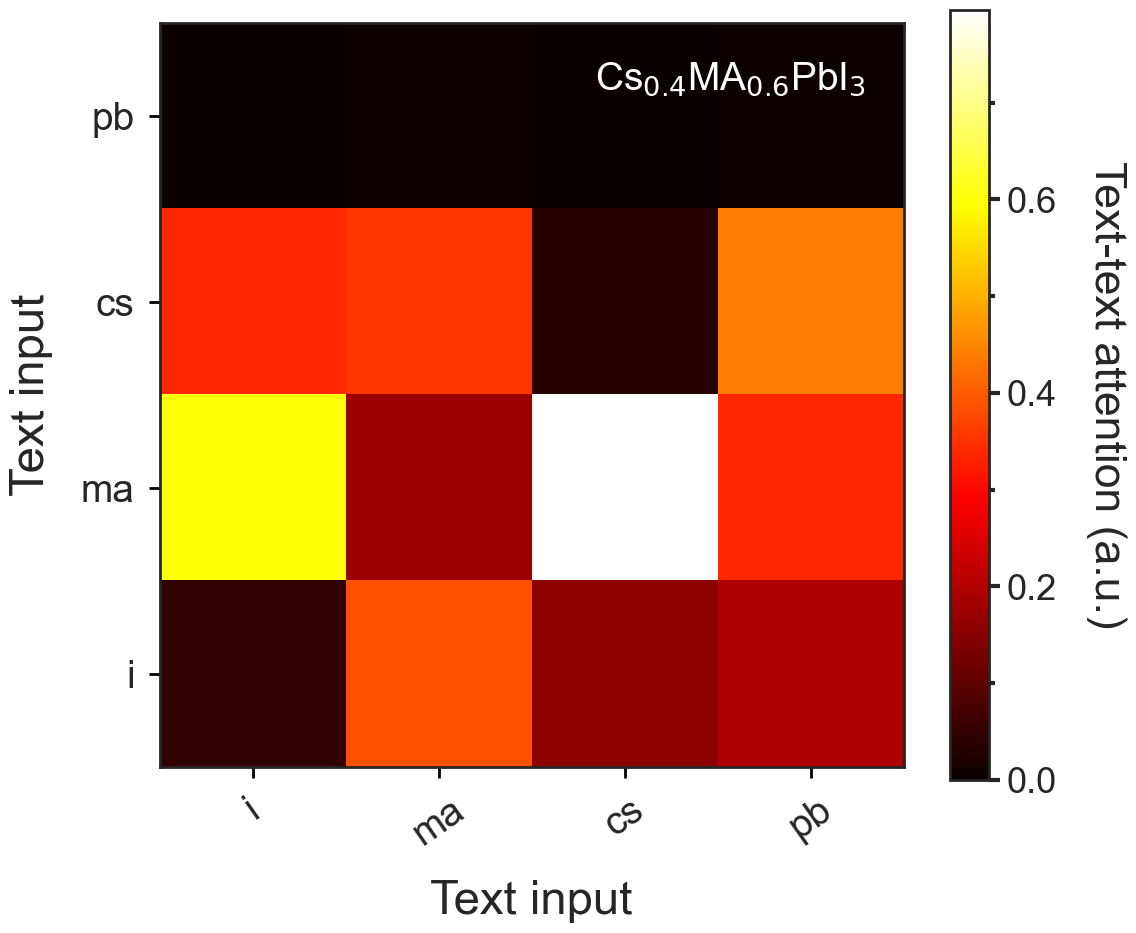

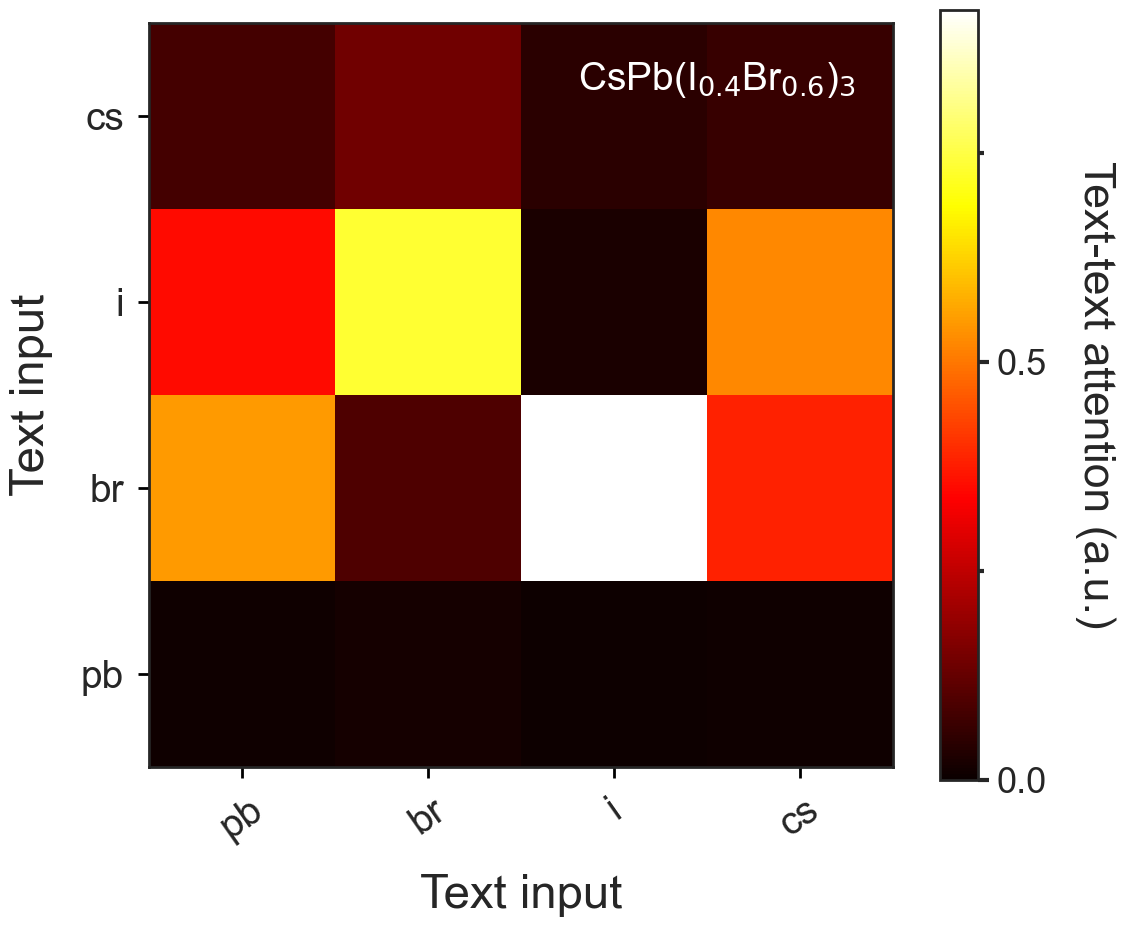

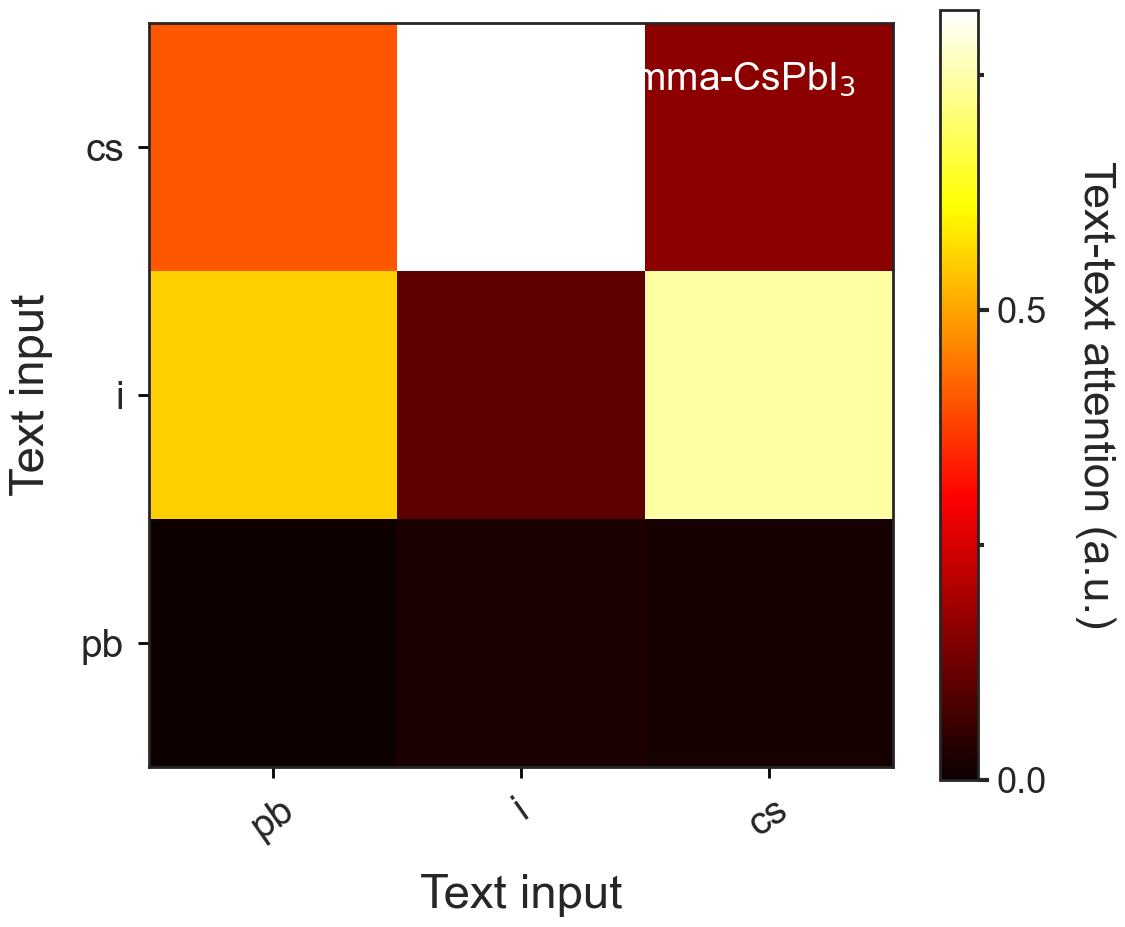

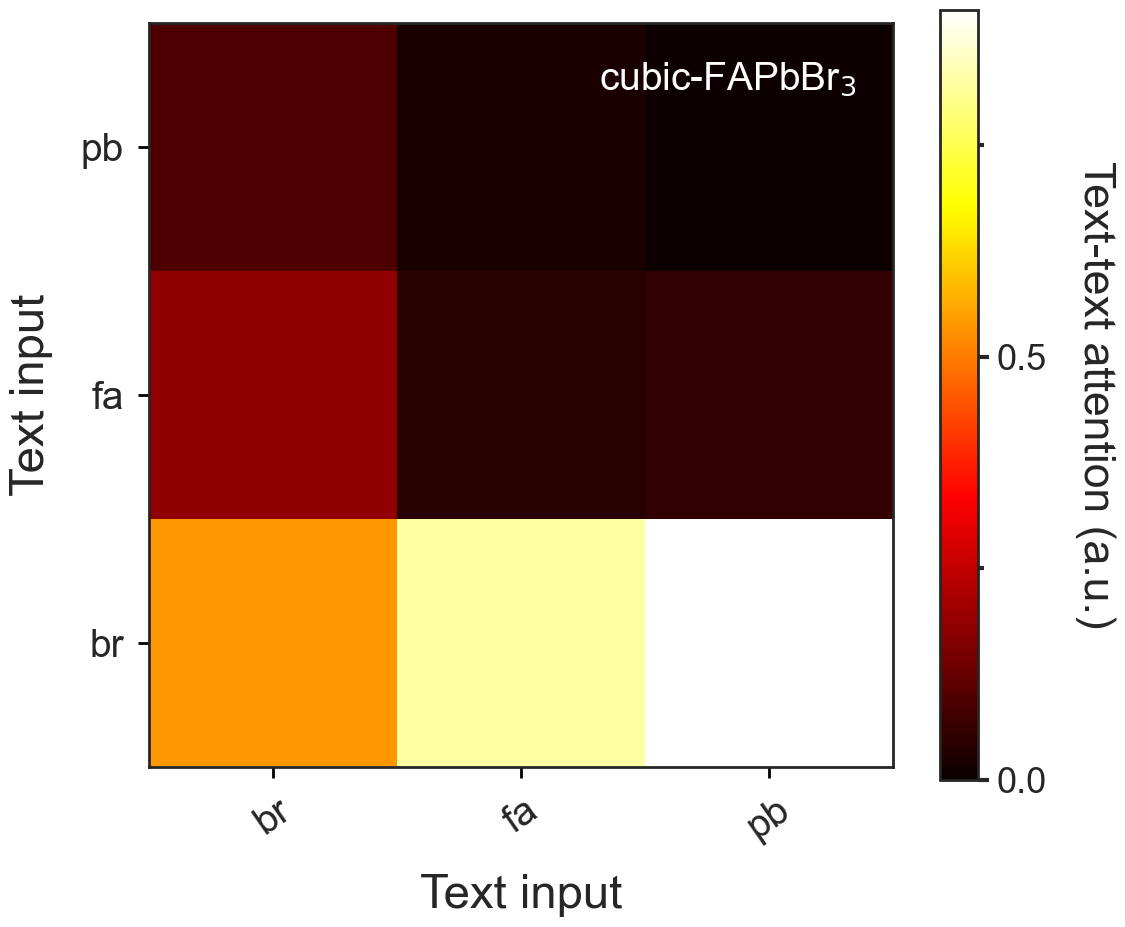

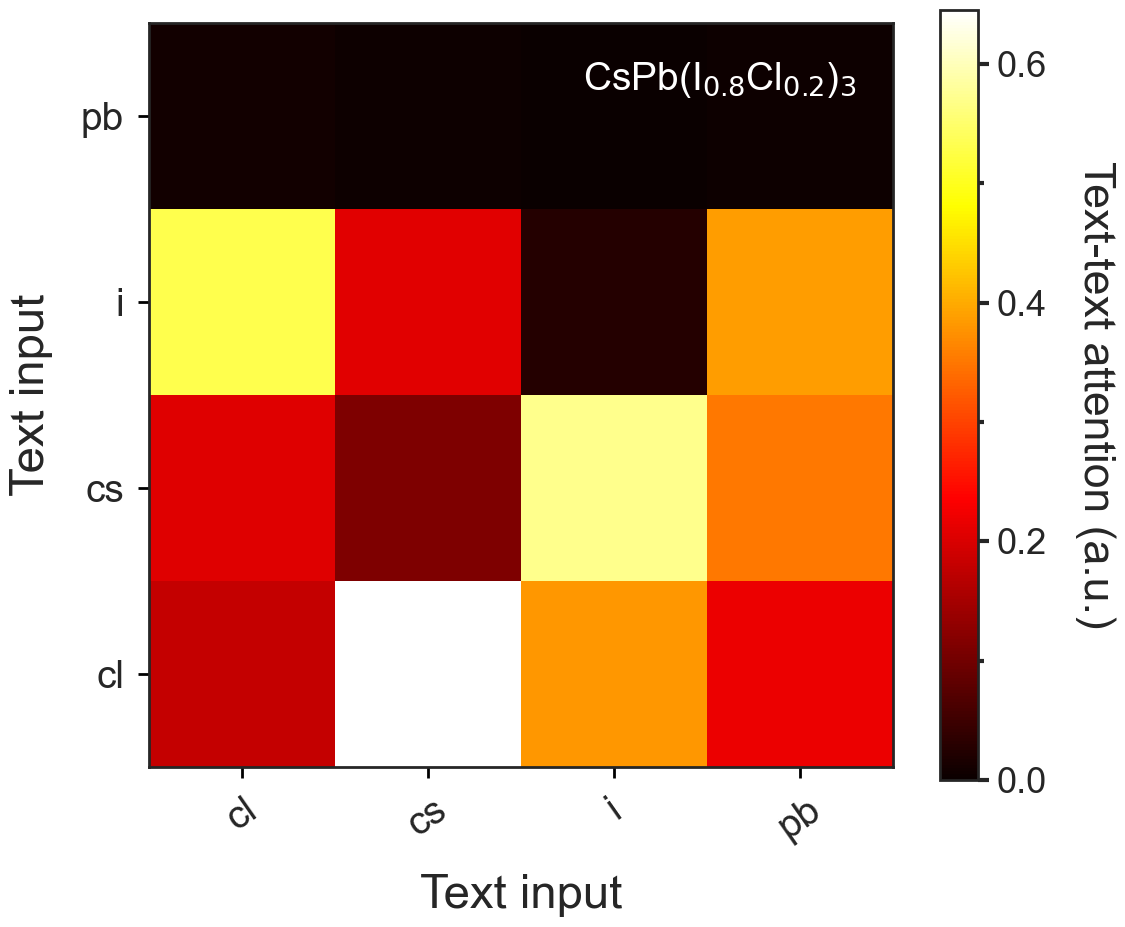

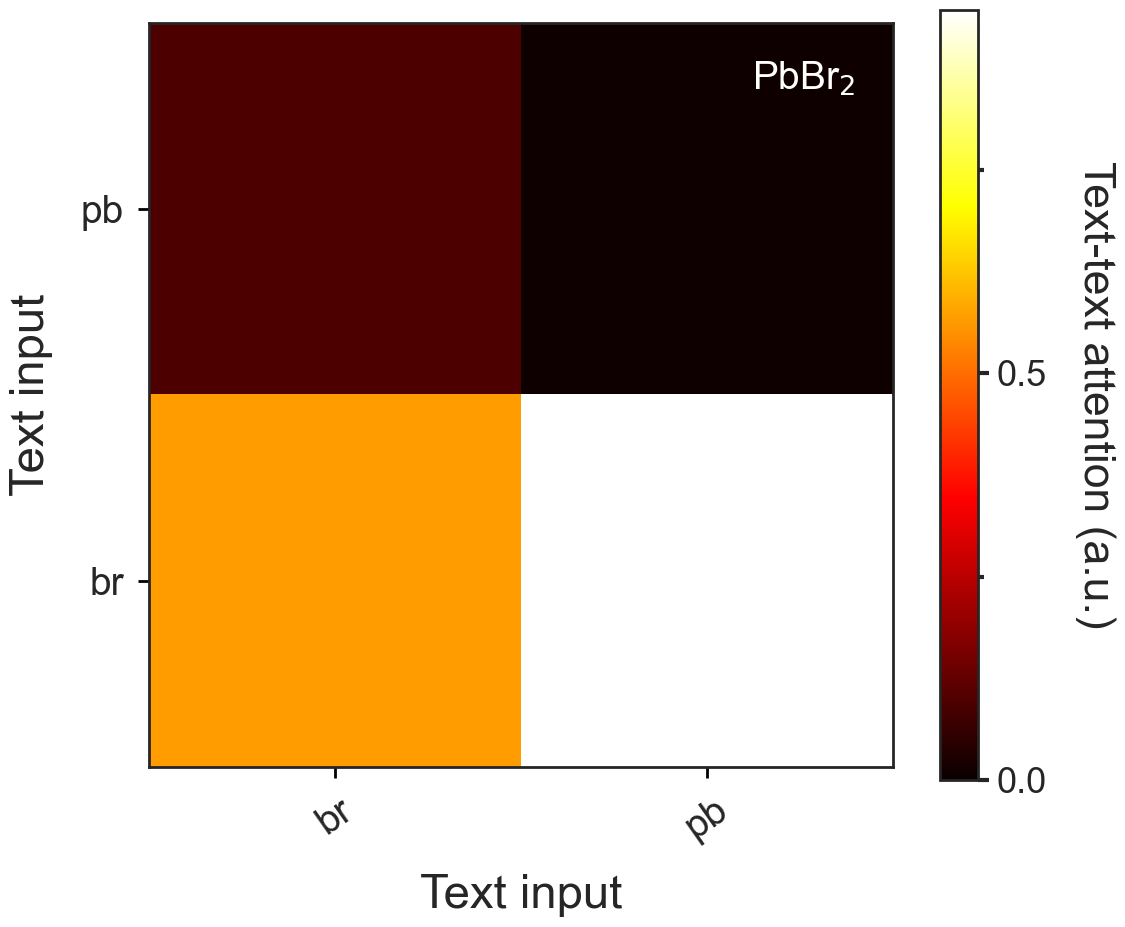

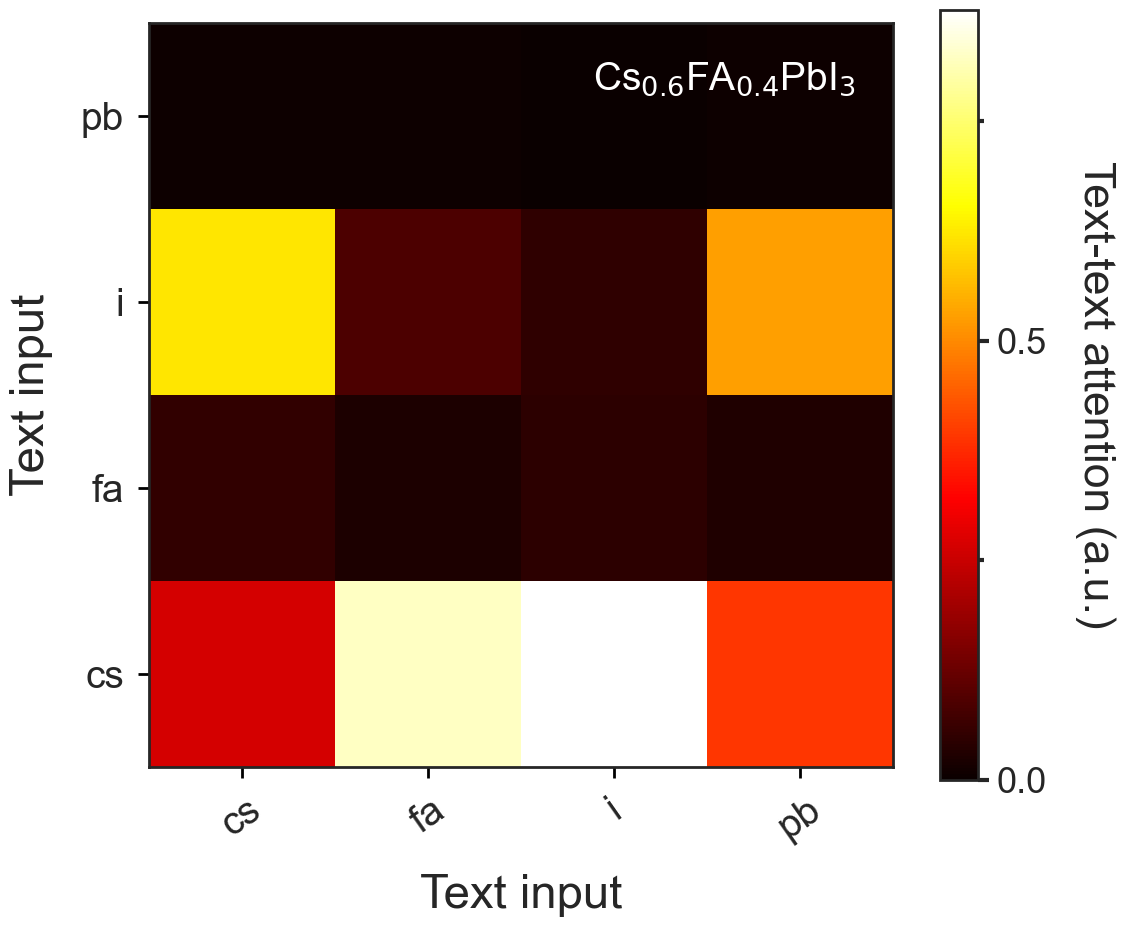

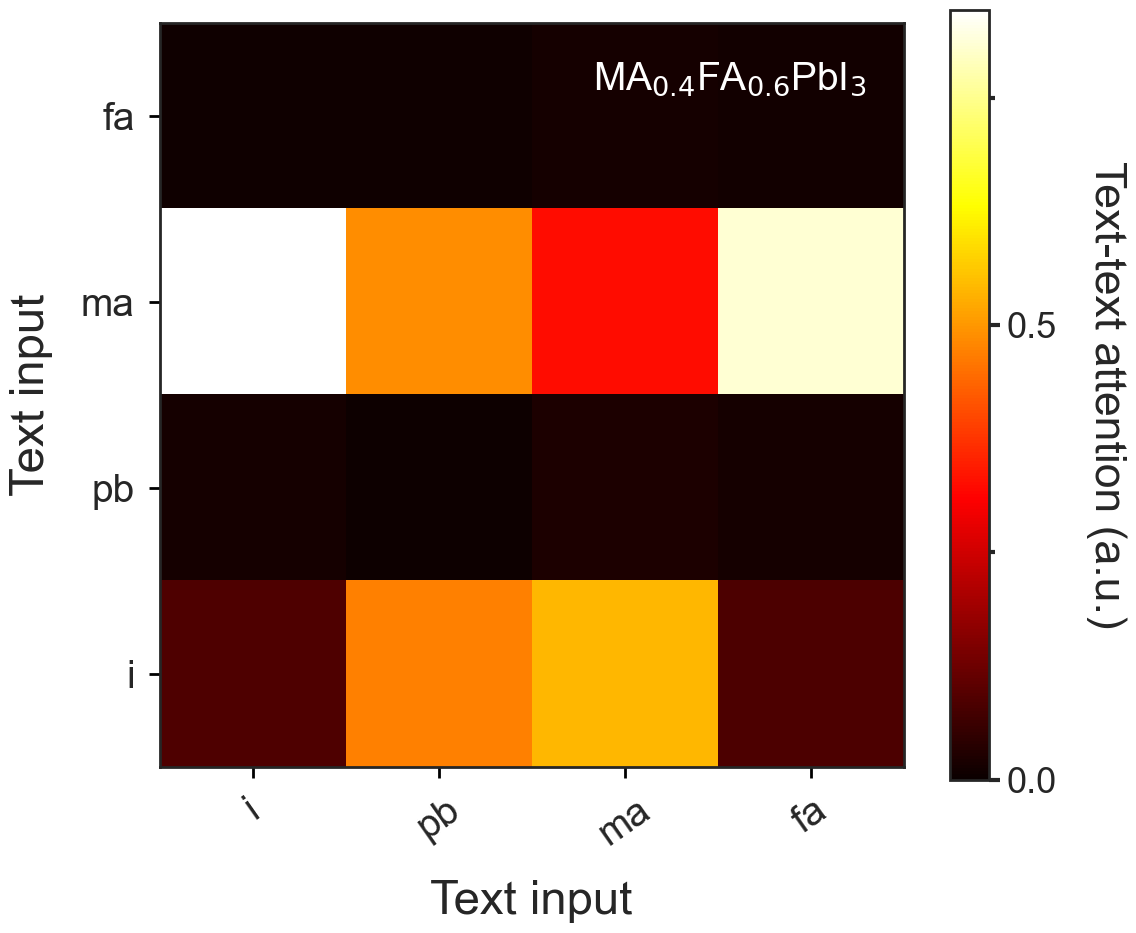

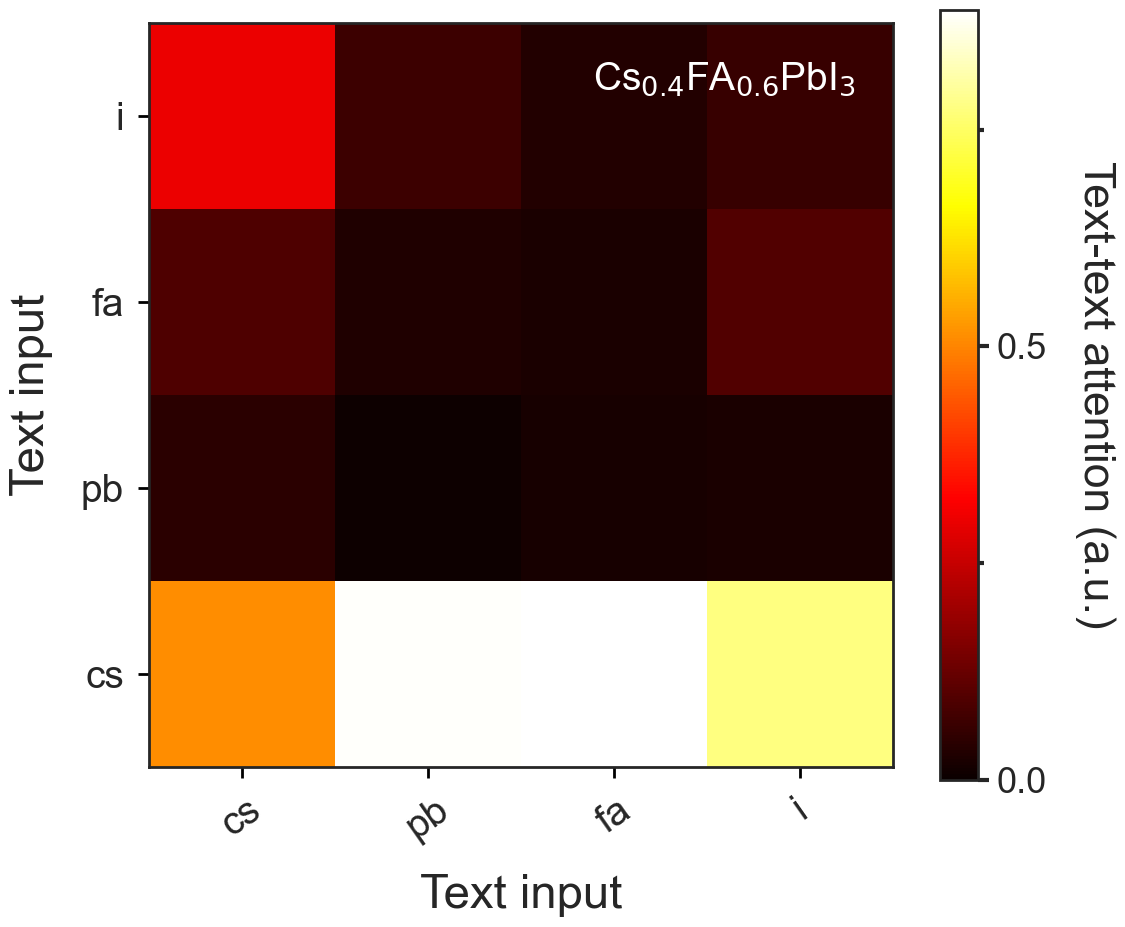

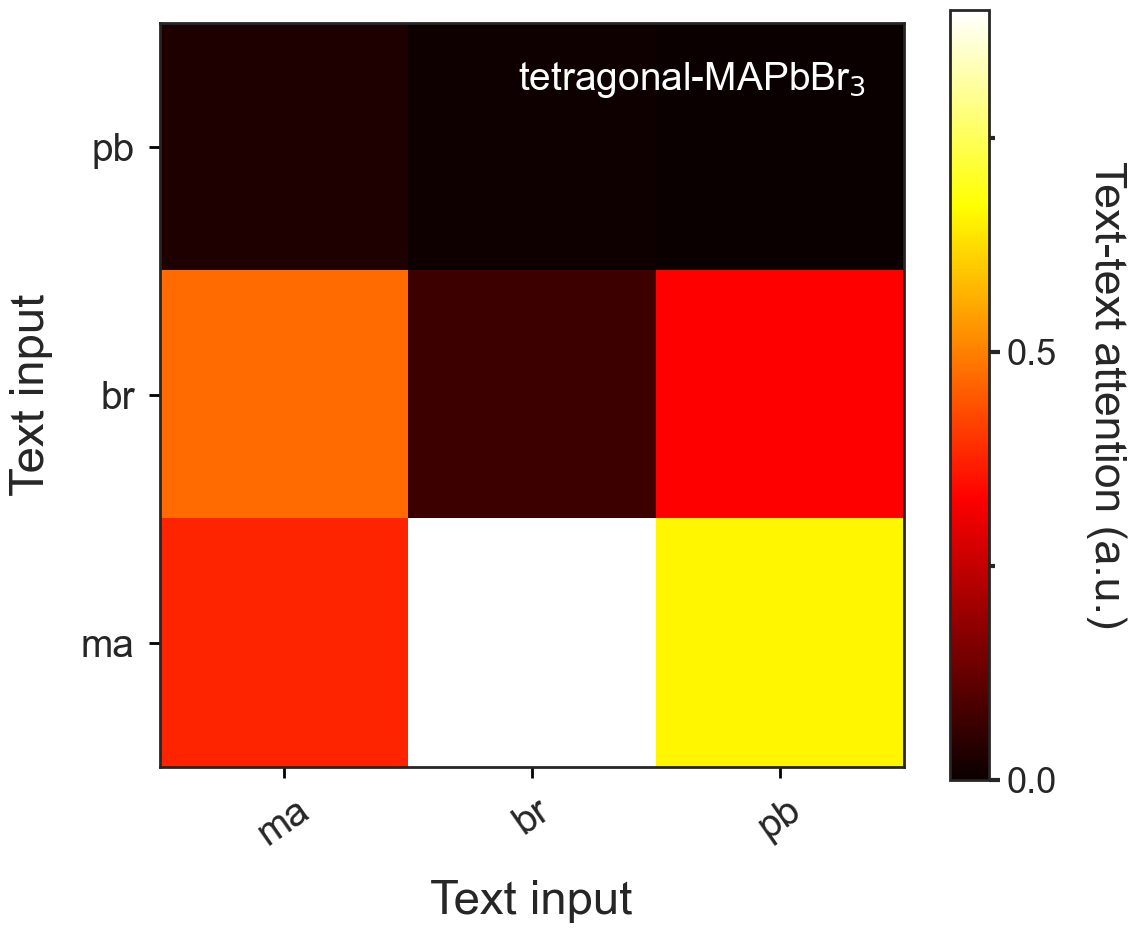

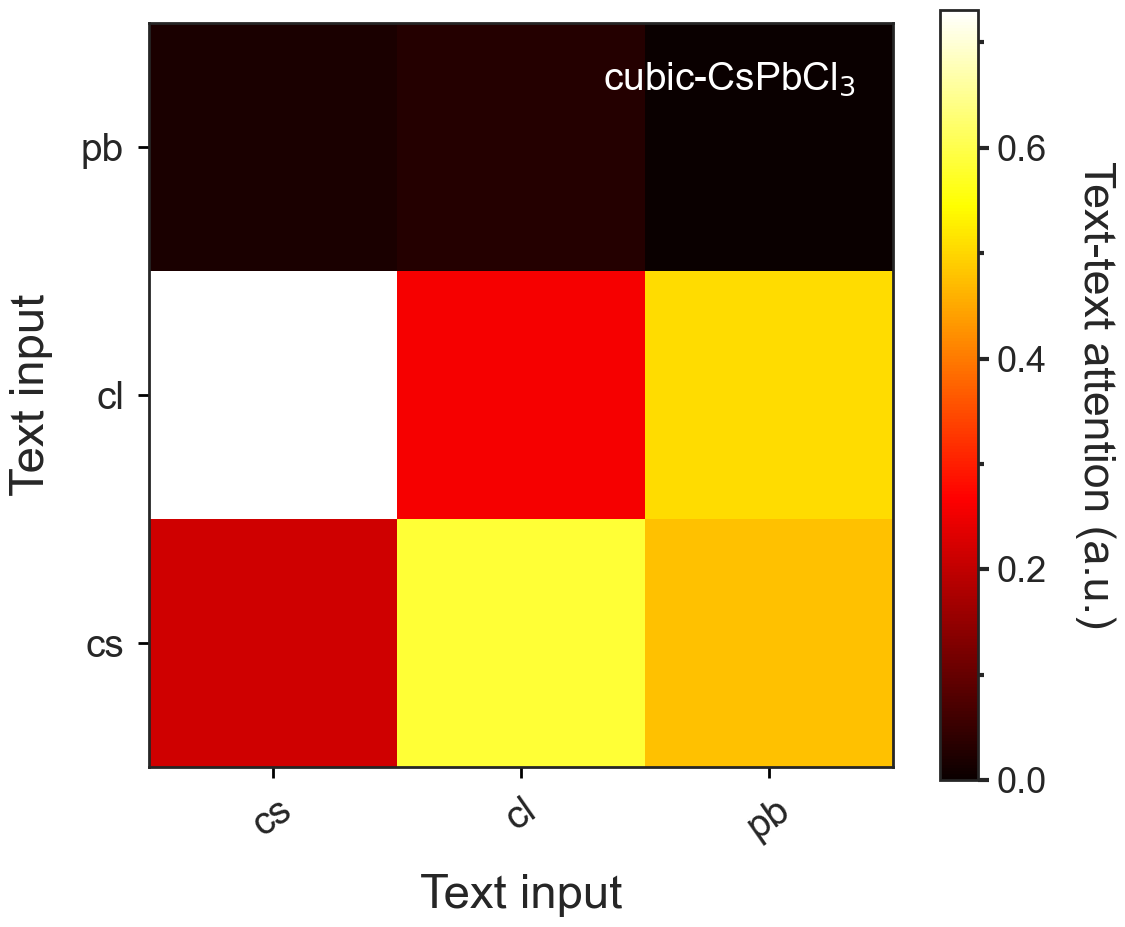

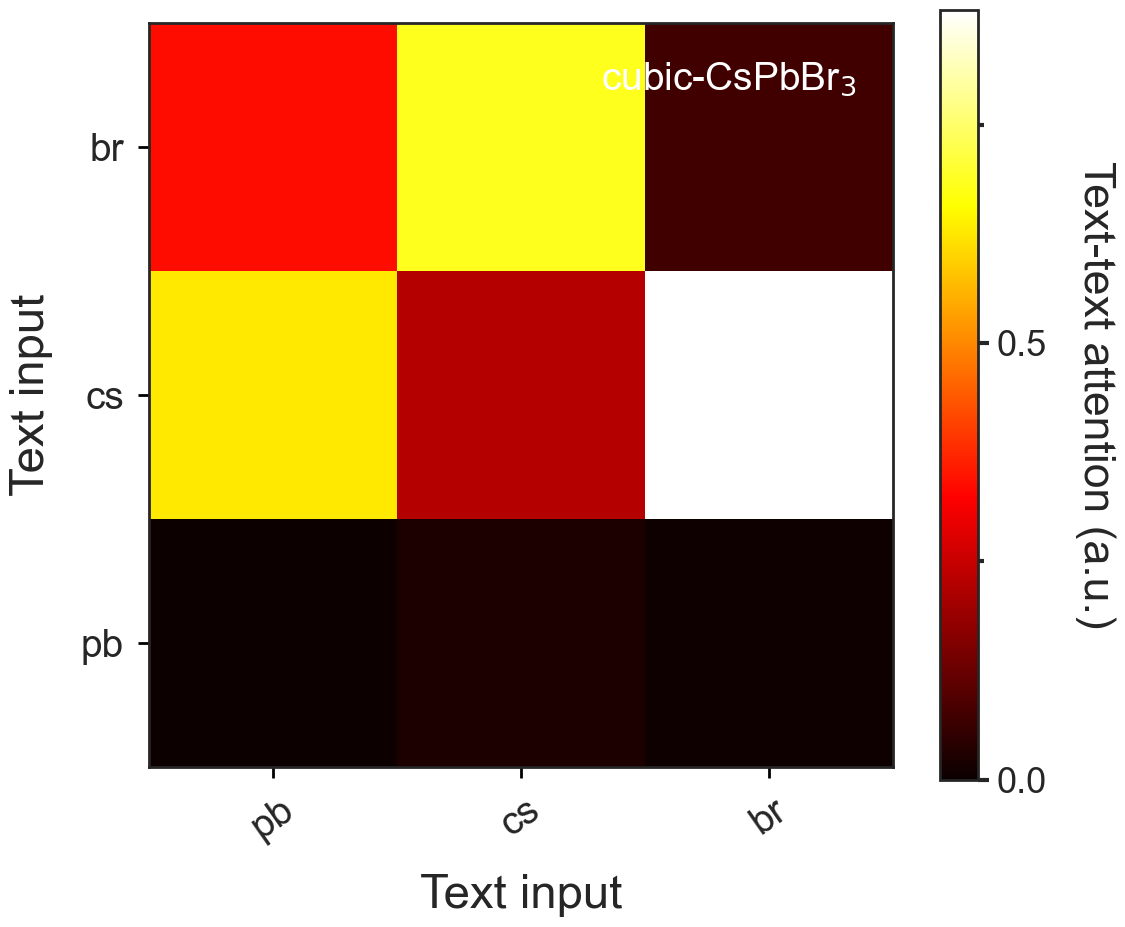

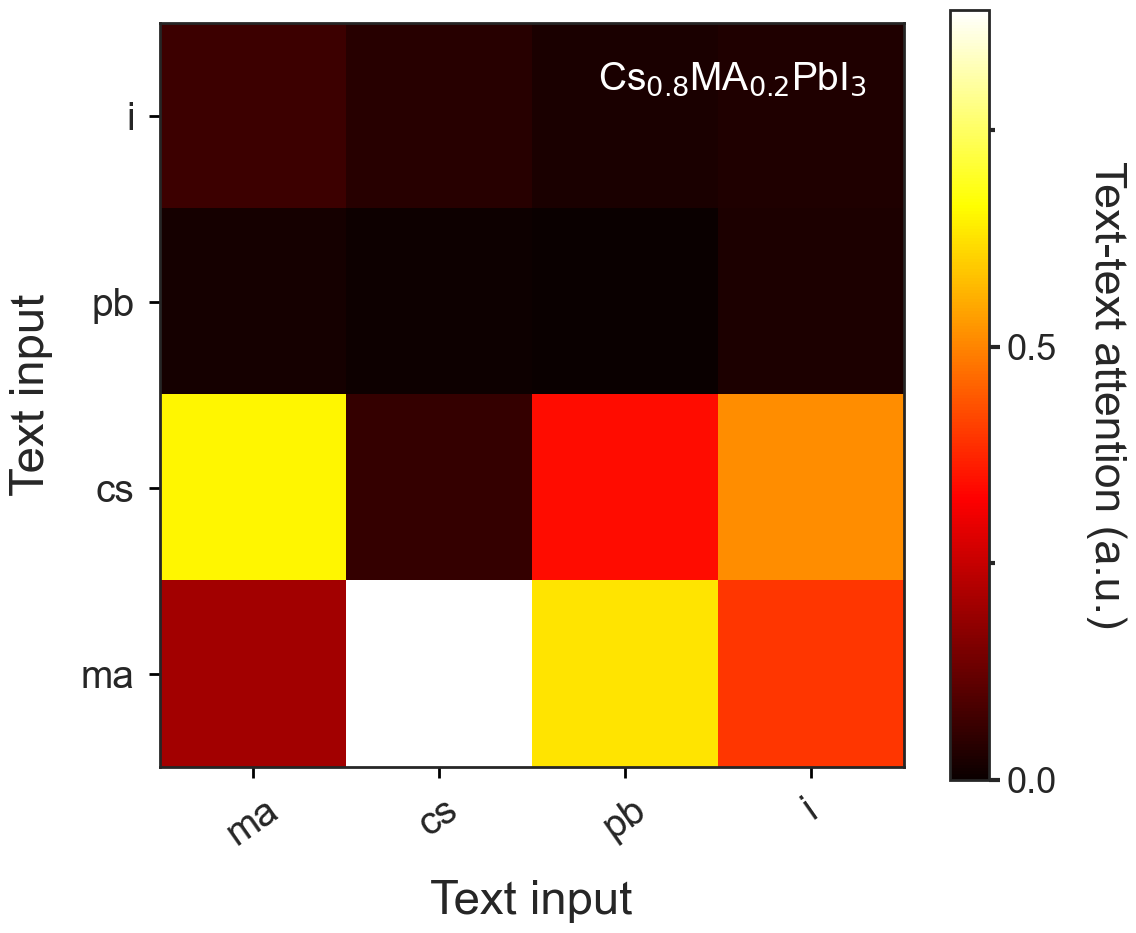

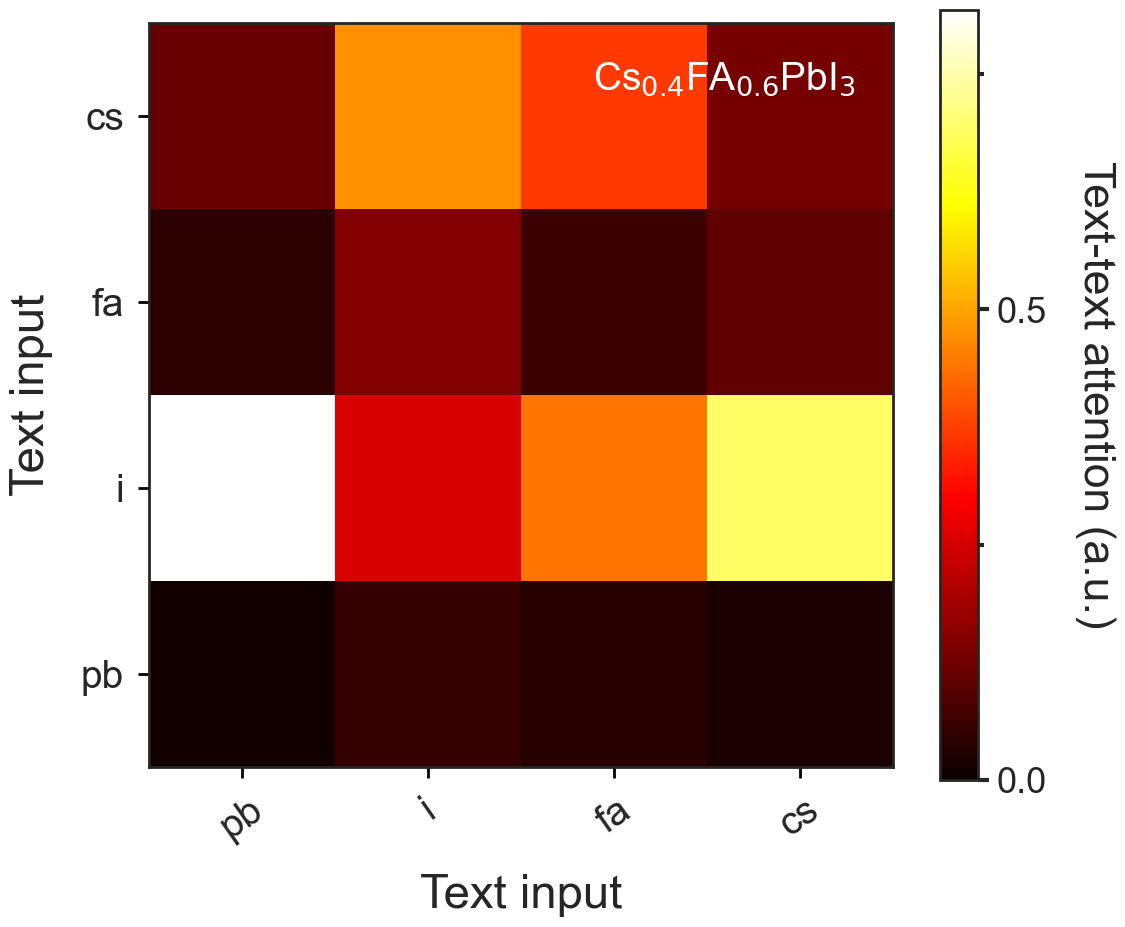

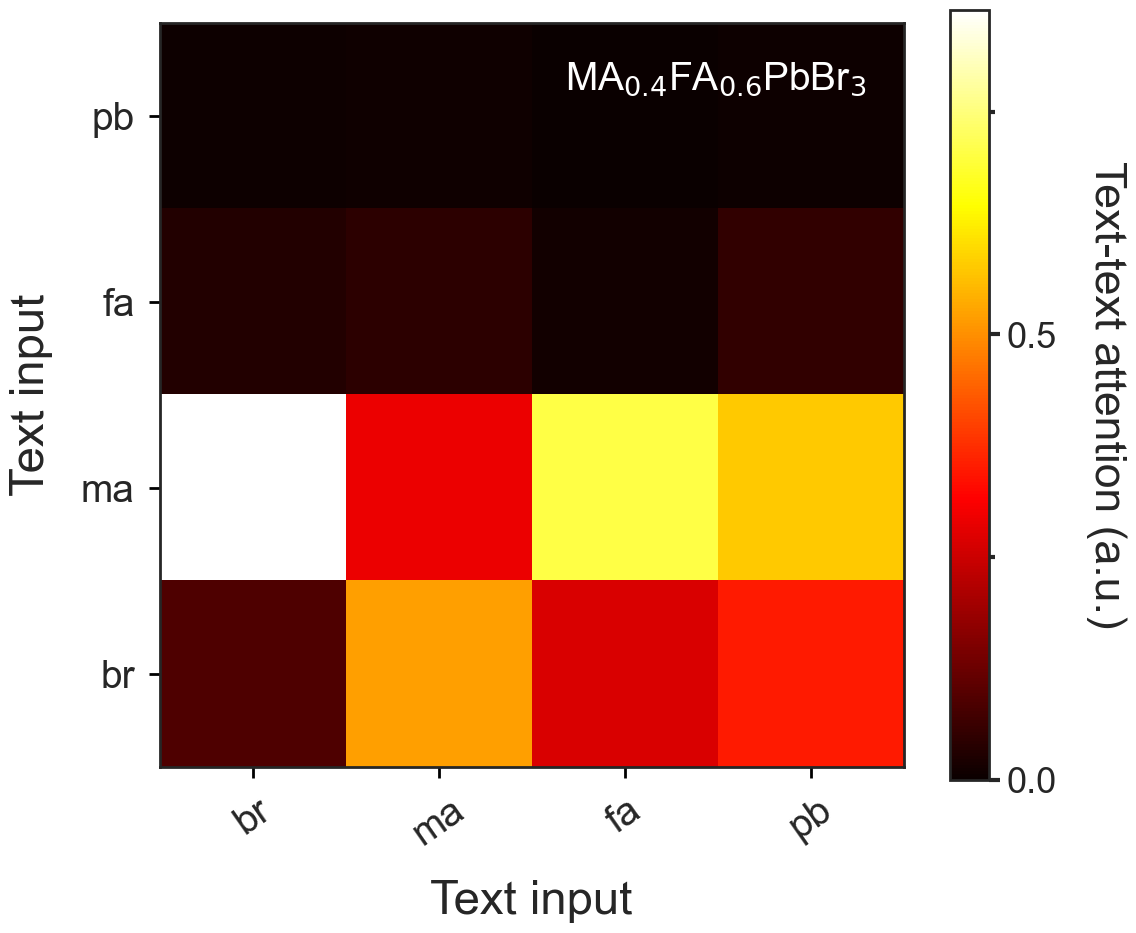

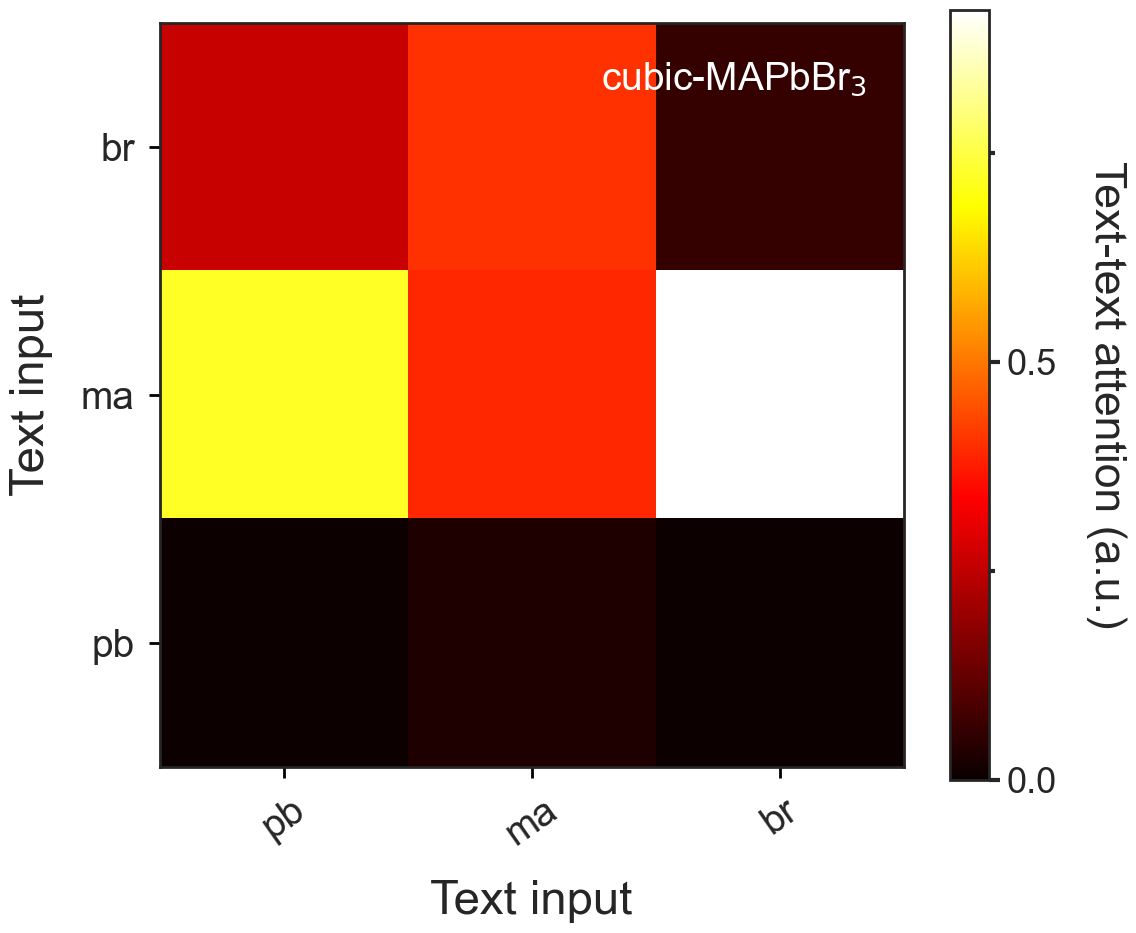

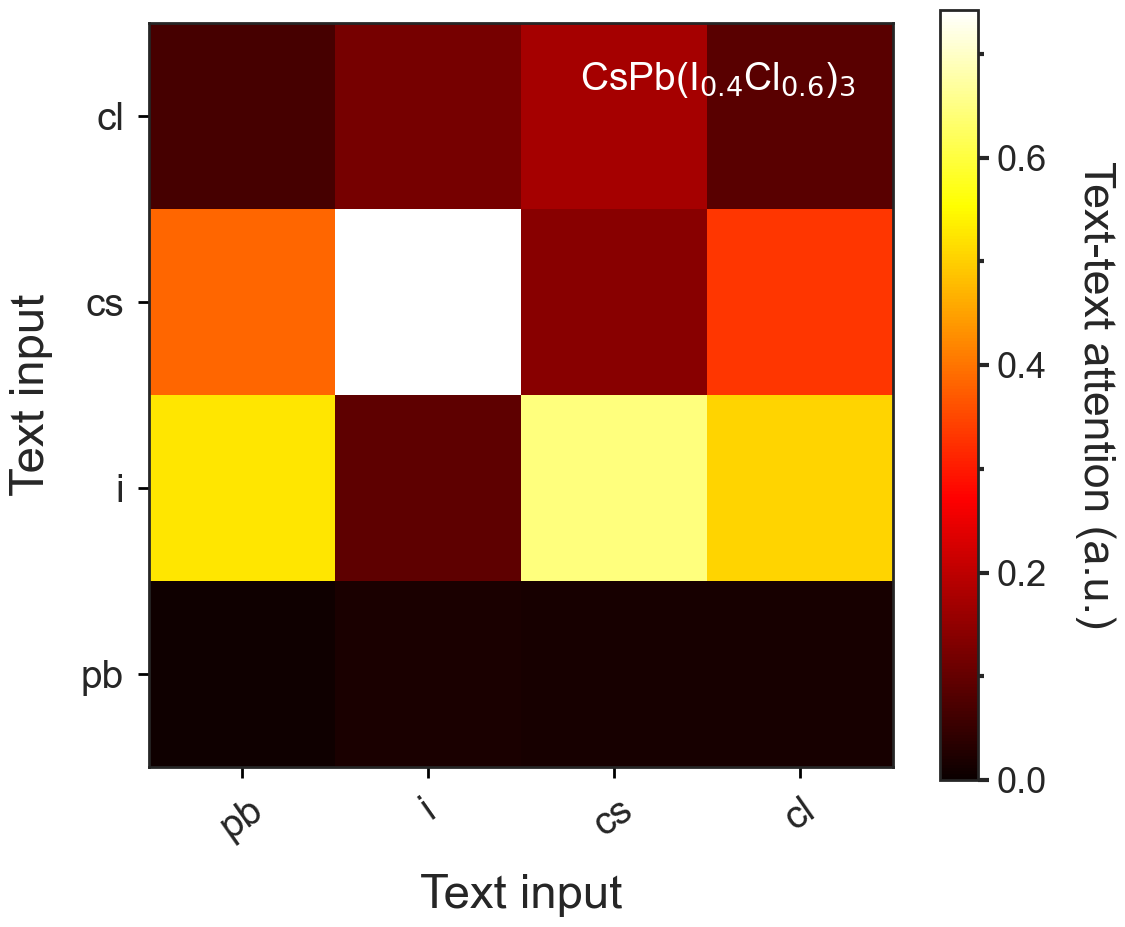

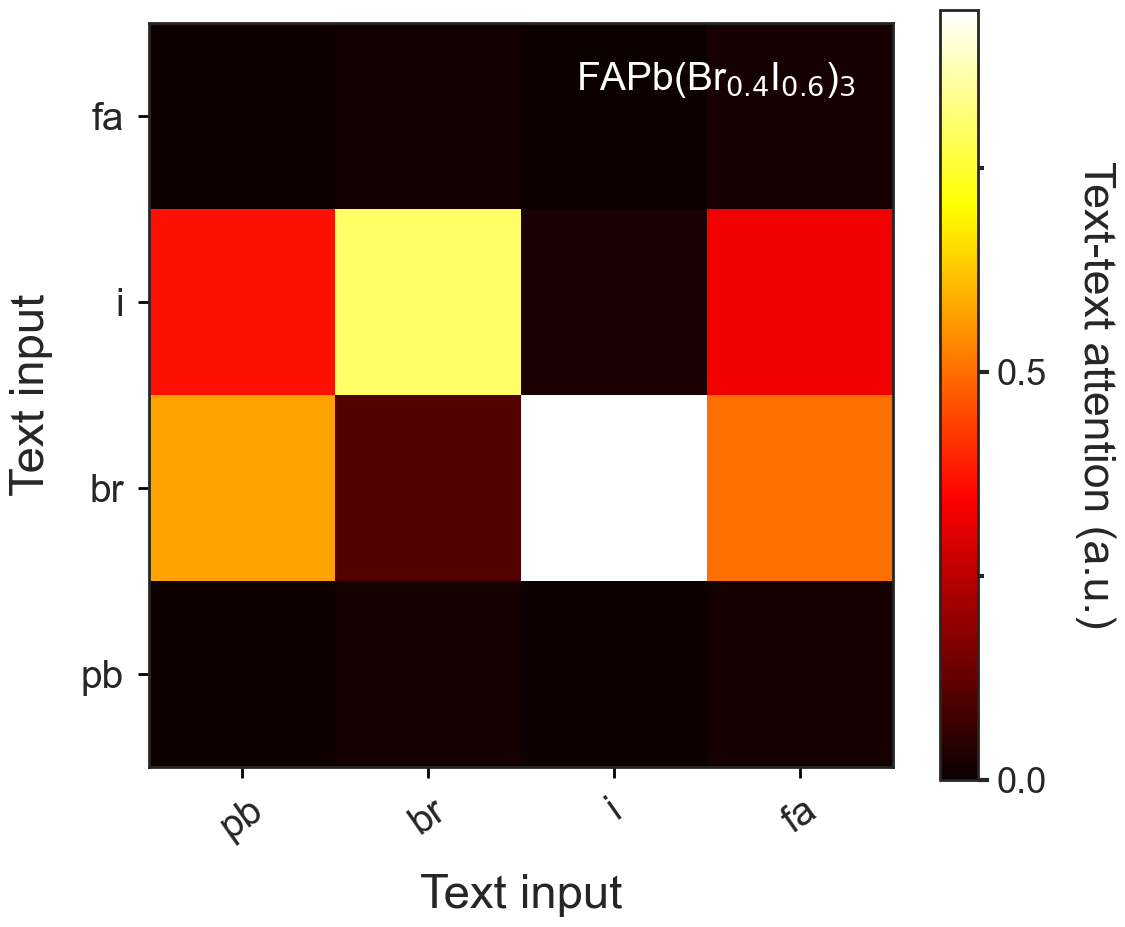

In [335]:
for i in range(30):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

    outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
    
    Y = np.sum(np.array(outputs.attentions[0].detach().cpu())[0,:,1:len(inputs['input_ids'][0])-1,1:len(inputs['input_ids'][0])-1],axis=0)
    extent = [0.5,0.5+len(inputs['input_ids'][0])-2,0.5,0.5+len(inputs['input_ids'][0])-2]

    load_plt_setting()

    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(np.rot90(Y), extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2]), cmap='hot', vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1], rotation=35)
    ax.set_yticklabels(['',]+tokenizer.convert_ids_to_tokens(inputs.input_ids[0])[1:-1])
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=len(inputs['input_ids'][0])-2, steps=[1, 2, 5, 10]))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('Text-text attention (a.u.)',labelpad=50, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Text input', labelpad=20, fontsize=34)
    ax.set_ylabel(r'Text input', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0]), 
             fontsize=28, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    
    plt.savefig(os.path.join(folder, 'models', model_folder,'{}_attention_text.png'.format(formula_list[i][0])), 
                format='png', dpi=300, transparent=True, bbox_inches='tight')


In [338]:
tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

['[CLS]', 'pb', 'fa', 'br', 'i', '[SEP]']

# 5 Experimental single phase

In [4]:
model_folder = '20240906 single phase'
# model_folder = '20240921 single phase diverse prompt embedding 20'
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', model_folder,'100000')).to('cuda')

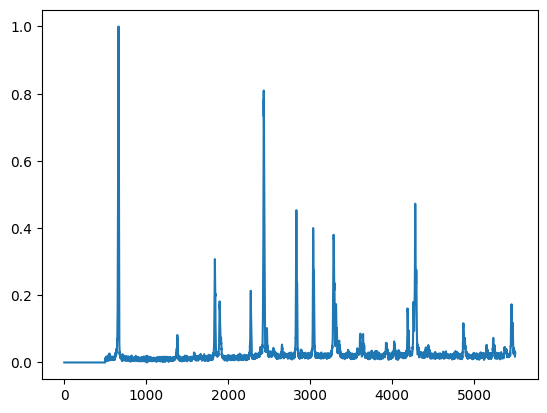

In [6]:
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240516 OT\CsPbBr\4 CsPb1Br3_Theta_2-Theta_fit.xy', delimiter=" ", unpack=False)
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240516 OT\CsPbBr\1 CsPb2Br5_Theta_2-Theta_fit.xy', delimiter=" ", unpack=False)

data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240516 OT\CsPbBr\0 Cs2Pb5Br12_Theta_2-Theta.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = data[:,1]
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

In [104]:
y_true, y_pred, y_formula = [], [], []

Xs_test = Xs[0,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)
logits = torch.topk(outputs.logits[0], 1).indices
y_pred = list(np.array(logits.detach().cpu()))

In [268]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
for idx in y_pred:
    print(idx, np.array(softmax(outputs.logits)[0,idx].detach().cpu()), dataloader.dataset[dataloader.sample_list[idx]]['formula'])

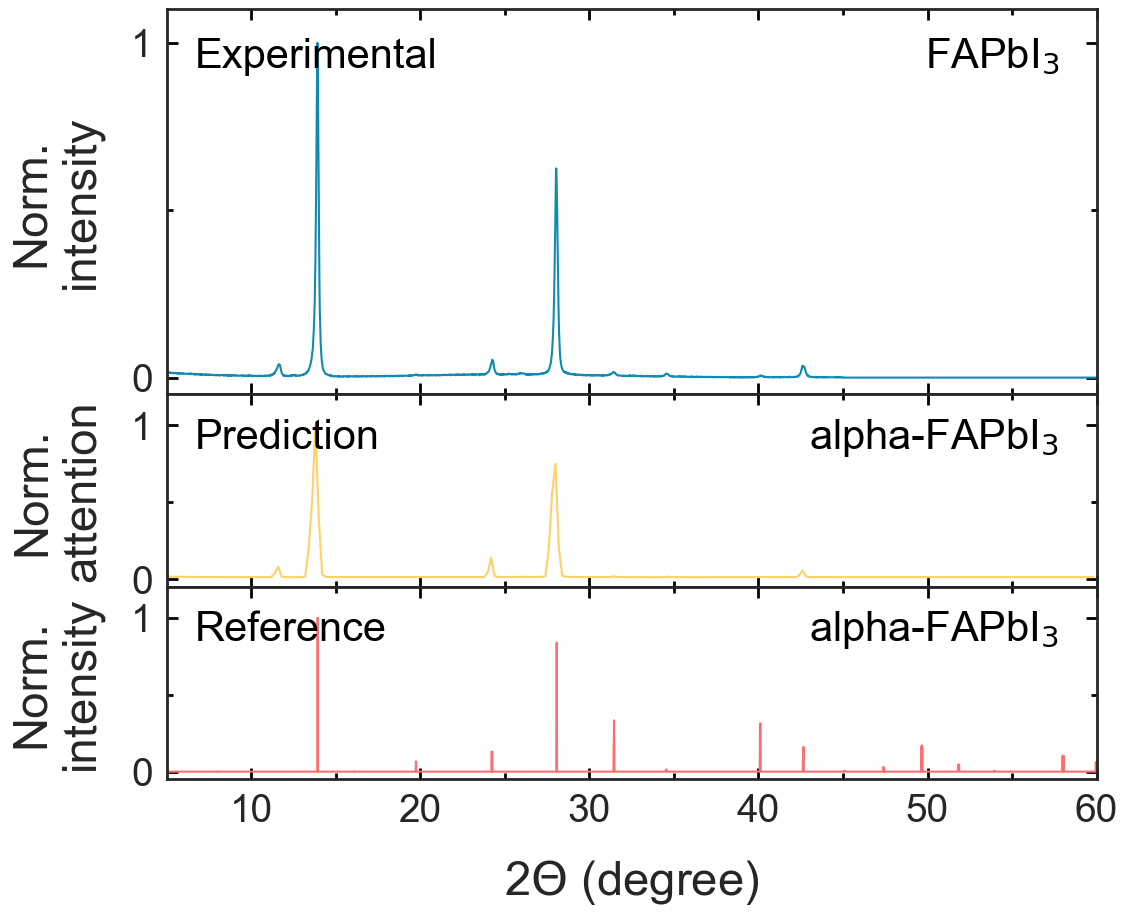

In [17]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['FA Pb I',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
#     ax2.plot(twotheta, dataloader.load_ref(19)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'FAPbI3')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula)), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


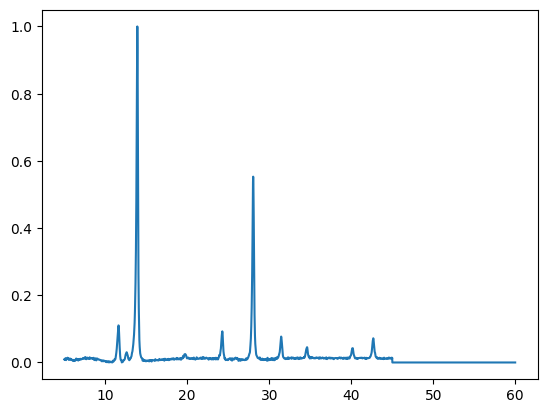

In [41]:
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3.csv', delimiter=",", unpack=False)
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3_fit.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1]-data[:,4])(np.arange(5.00, 45.01, 0.01))
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(twotheta,Xs[0,:,0])

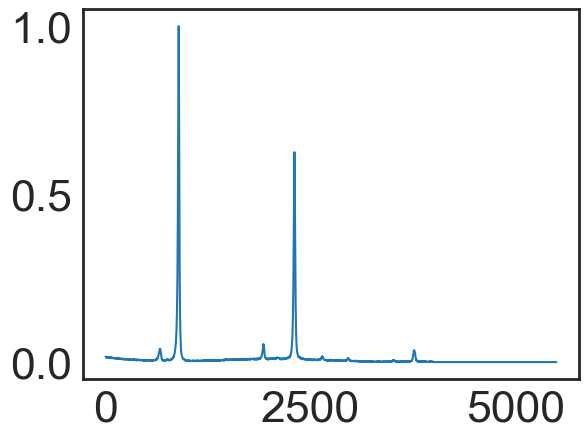

In [11]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\GB_3.csv', delimiter=",", unpack=False)
# data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240912 Chem-XRD ViT\Air_3_fit.xy', delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1])(np.arange(5.00, 45.01, 0.01))
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

In [42]:
y_true, y_pred, y_formula = [], [], []

Xs_test = Xs[0,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)
logits = torch.topk(outputs.logits[0], 20).indices
y_pred = list(np.array(logits.detach().cpu()))

In [43]:
for idx in y_pred:
    print(idx, dataloader.dataset[dataloader.sample_list[idx]]['formula'],np.array(outputs.logits[0].detach().cpu())[idx])

44 alpha-FAPbI3 9.33871
46 delta-FAPbI3 8.099103
60 tetragonal-MAPbBr3 2.465374
4 Cs0.2FA0.8PbI3 2.0282676
65 PbI2 1.7740173
62 alpha-MAPbI3 1.7330676
7 Cs0.8FA0.2PbI3 1.3109987
32 cubic-CsPbBr3 1.1496482
45 beta-FAPbI3 1.0594403
2 Cs0.6FA0.4PbBr3 0.9458855
54 MA0.8FA0.2PbI3 0.91527843
16 Cs4PbBr6 0.85488844
42 FAPb(Br0.8I0.2)3 0.83029073
29 CsPb(I0.4Cl0.6)3 0.7844297
3 Cs0.8FA0.2PbBr3 0.742192
39 FAPb(Br0.2I0.8)3 0.70042056
34 Pnma-CsPbCl3 0.59099156
20 CsPb(Cl0.2Br0.8)3 0.56310356
50 MA0.8FA0.2PbBr3 0.515597
27 CsPb(I0.8Br0.2)3 0.5009957


## MAPbBr3

[ 4.84357791  4.85326811  4.86295833 ... 69.37214935 69.38239333
 69.39263739]


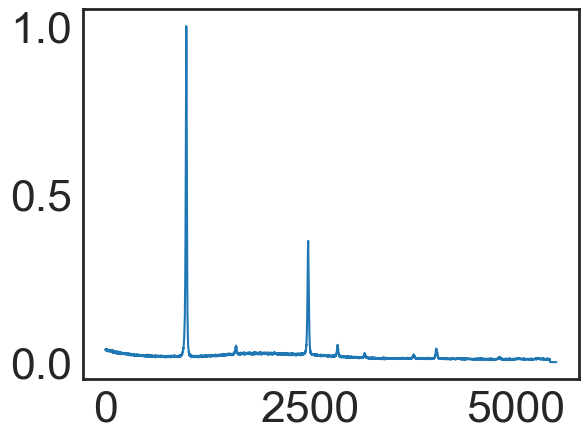

In [133]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240926 MAPbI-MAPbBr XRD\MAPbBr3_Theta_2-Theta.xy', 
                     delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]
sample_height_displacement = -0.003458*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
print(twotheta_corrected)

X = interp1d(twotheta_corrected, X)(twotheta)
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

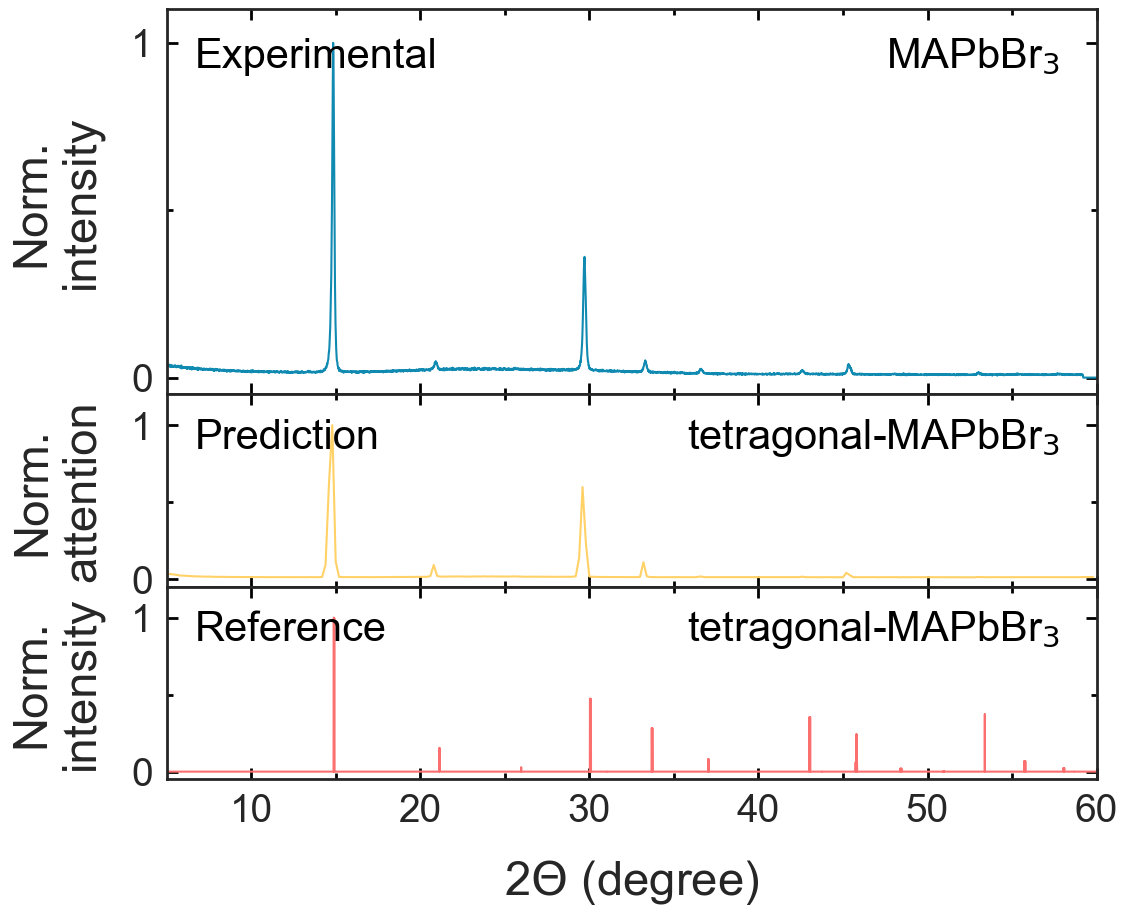

In [134]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['MA Pb Br',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
#     ax2.plot(twotheta, dataloader.load_ref(19)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'MAPbBr3')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula)), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


## MAPbI3

[ 4.85814663  4.8678657   4.87758478 ... 69.43126115 69.44148216
 69.45170324]


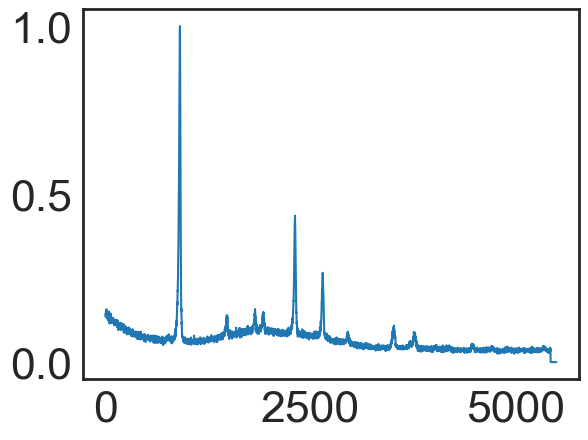

In [131]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240926 MAPbI-MAPbBr XRD\MAPbI3_Theta_2-Theta.xy', 
                     delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]
sample_height_displacement = -0.003136*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
print(twotheta_corrected)

X = interp1d(twotheta_corrected, X)(twotheta)
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

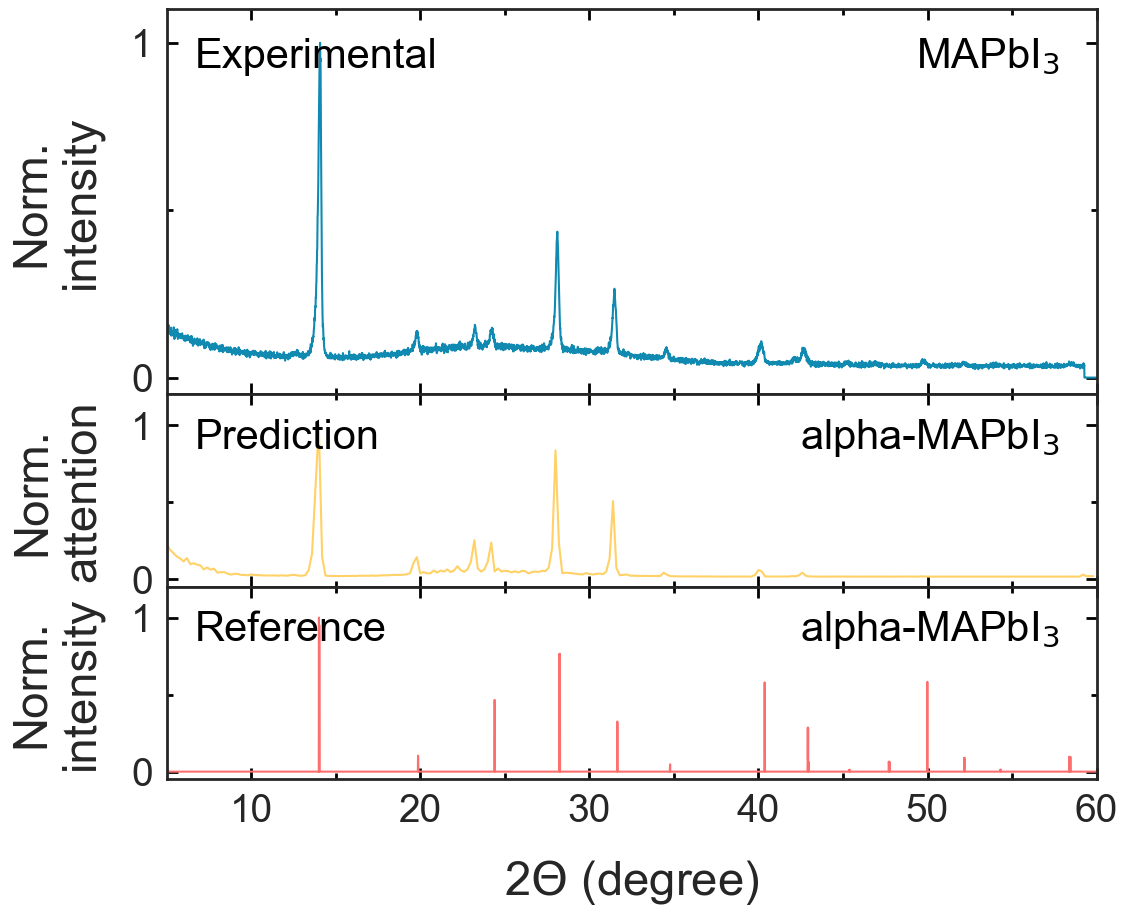

In [132]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['MA Pb I',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
#     ax2.plot(twotheta, dataloader.load_ref(19)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'MAPbI3')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula)), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


## MAPbI2.4Br0.6

[ 4.82276437  4.83241332  4.8420623  ... 69.28676043 69.29703731
 69.30731428]


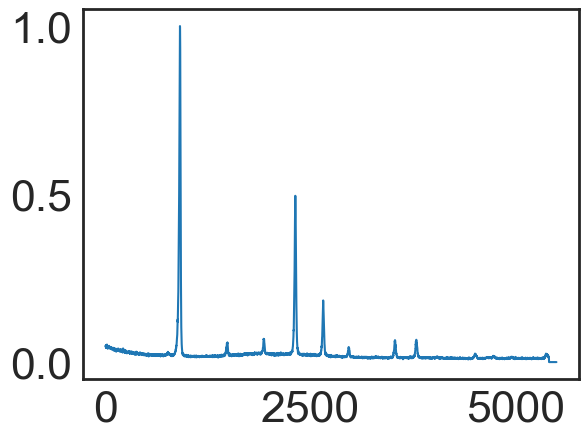

In [24]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240926 MAPbI-MAPbBr XRD\MAPbI2.4Br0.6_Theta_2-Theta.xy', 
                     delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]
sample_height_displacement = -0.003918*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
print(twotheta_corrected)

X = interp1d(twotheta_corrected, X)(twotheta)
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(Xs[0,:,0])

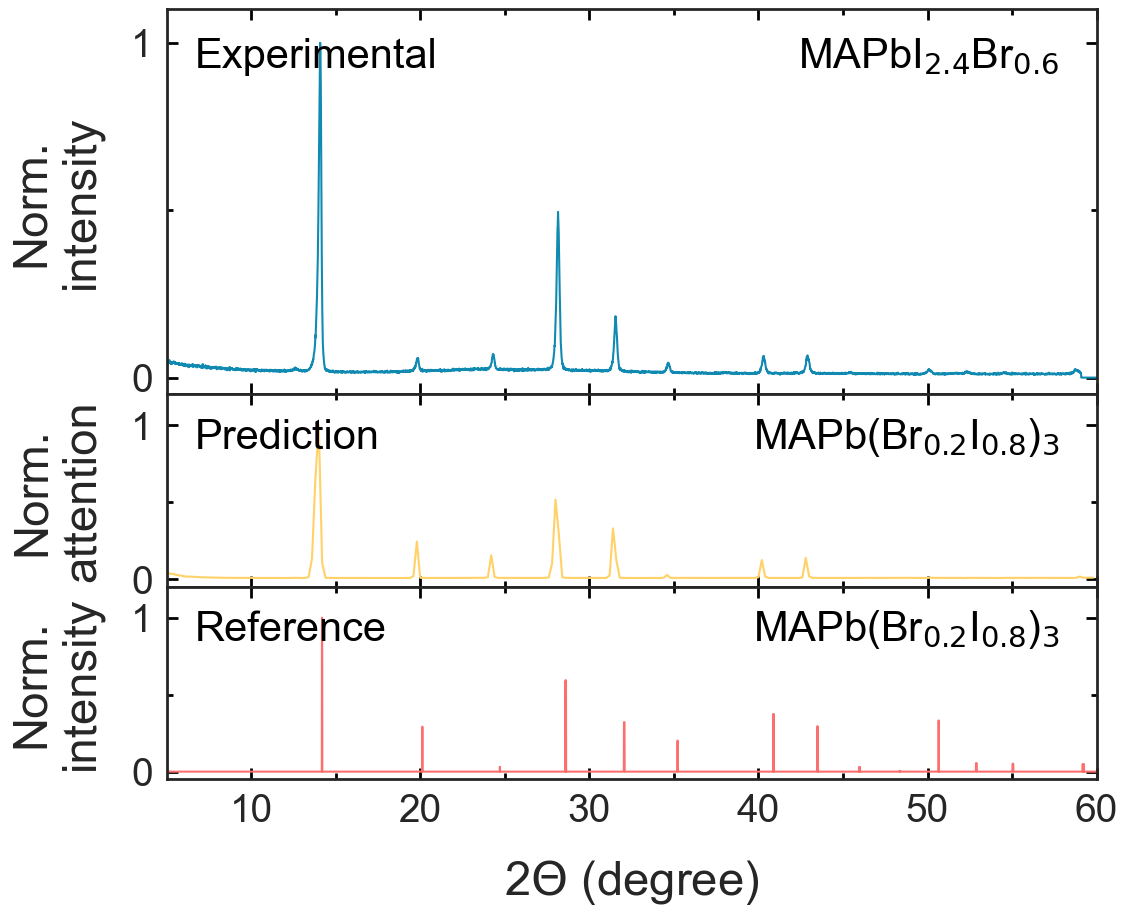

In [25]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['MA Pb I Br',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*20)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
#     ax2.plot(twotheta, dataloader.load_ref(19)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'MAPbI2.4Br0.6')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula)), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


## MAPbI1.8Br1.2

[ 4.82321685  4.8328667   4.84251657 ... 69.28862864 69.2989048
 69.30918106]


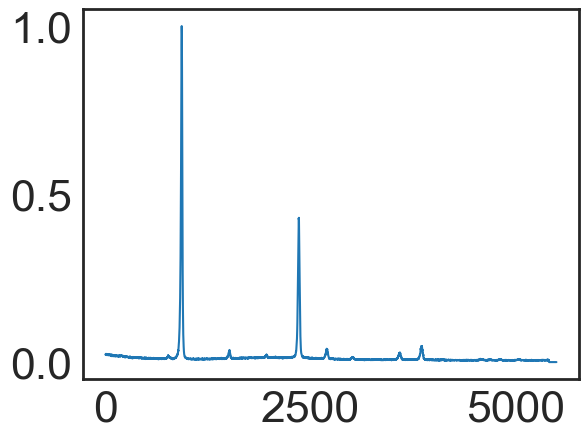

In [26]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240926 MAPbI-MAPbBr XRD\MAPbI1.8Br1.2_Theta_2-Theta.xy', 
                     delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]
sample_height_displacement = -0.003908*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
print(twotheta_corrected)

X = interp1d(twotheta_corrected, X)(twotheta)
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

plt.plot(X)

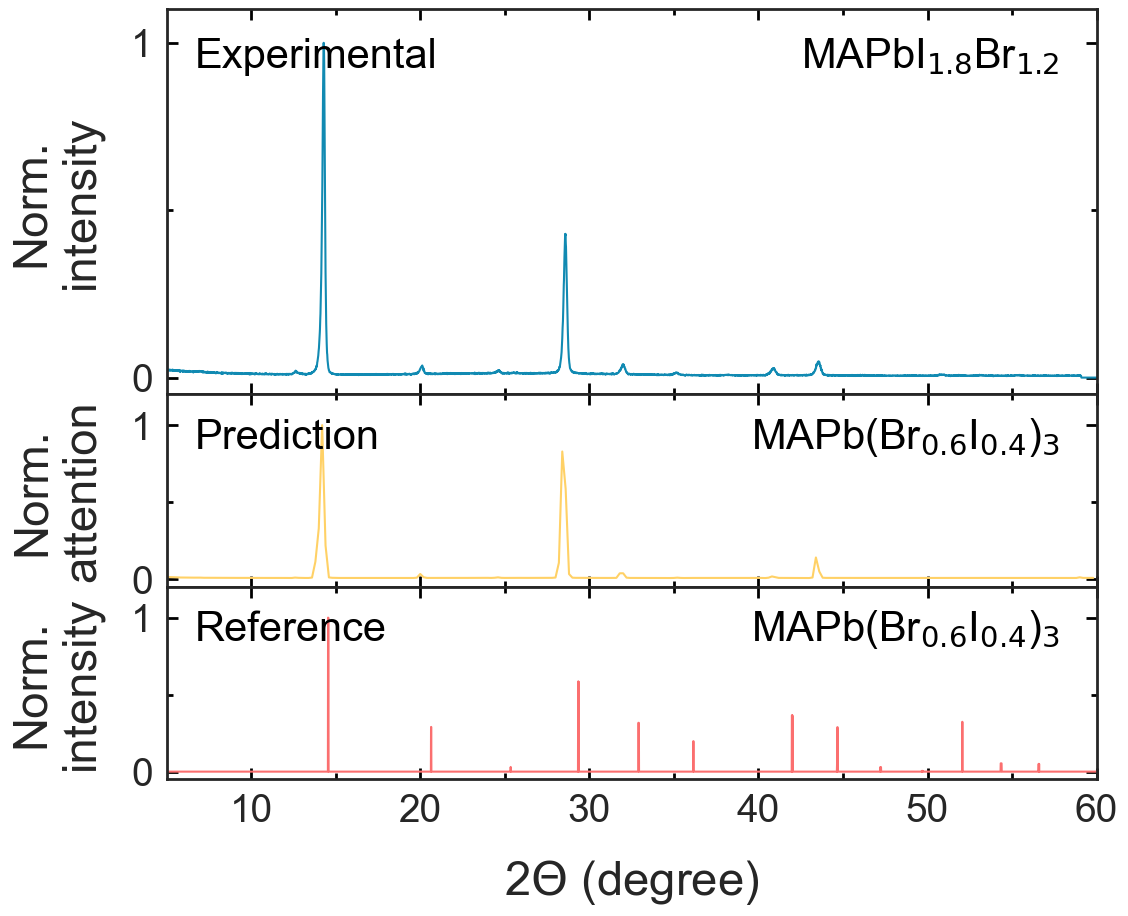

In [27]:
twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

for i in range(1):

    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    XRD_token_length = -Xs_test.shape[1]
    X_prompts = ['MA Pb I Br',]
    
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    prompt_token_length = len(inputs['input_ids'][0])
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )

    outputs = model(**inputs.to('cuda'), output_attentions=True)
    pred_index = np.array(torch.topk(outputs.logits[0], 1).indices.detach().cpu())[0]
    formula = dataloader.dataset[dataloader.sample_list[pred_index]]['formula']
    
    Y = np.zeros((outputs.attentions[0].shape[-1],outputs.attentions[0].shape[-1]-prompt_token_length))

    for attention_head in outputs.attentions:
        Y += np.array(attention_head.detach().cpu())[0,0,:,prompt_token_length:]
    
    load_plt_setting()

    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, gridspec_kw=dict(height_ratios=[2,1,1]),figsize=(12, 10))

    ax0.plot(twotheta, Xs_test.reshape(-1), color=colors.to_rgba('#118ab2'))
    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_ylim([-0.05,1.1])
    ax0.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    
    ax1.plot(np.arange(5.00, 60.01, 0.01*visual_embedding_dim)[:-1], np.mean(Y, axis=0)/np.max(np.mean(Y, axis=0)), color=colors.to_rgba('#ffd166'))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.set_ylabel(f'Norm.\nattention', labelpad=20, fontsize=34)
    ax1.axes.set_ylim([-0.05,1.2])

    ax2.plot(twotheta, dataloader.load_ref(pred_index)[:-1], color=colors.to_rgba('#fb6f6f'))
#     ax2.plot(twotheta, dataloader.load_ref(19)[:-1], color=colors.to_rgba('#fb6f6f'))
    ax2.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax2.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax2.axes.set_ylim([-0.05,1.2])
    ax2.axes.set_xlim([5,60])

    ax2.set_xlabel(r'2$\Theta$ (degree)', labelpad=20, fontsize=34)
    ax2.set_ylabel(f'Norm.\nintensity', labelpad=20, fontsize=34)
    plt.text(0.03, 0.85, 'Experimental', fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.85, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', 'MAPbI1.8Br1.2')), fontsize=30, transform=ax0.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Prediction', fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax1.transAxes, color='#000000', horizontalalignment='right')
    plt.text(0.03, 0.72, 'Reference', fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='left')
    plt.text(0.96, 0.72, '{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)), fontsize=30, transform=ax2.transAxes, color='#000000', horizontalalignment='right')

    plt.subplots_adjust(hspace=.0)
    plt.savefig(os.path.join(folder, 'models', model_folder,'Exp {}.png'.format(formula)), format='png', dpi=300, transparent=True, bbox_inches='tight')
#     plt.savefig(folder+r"\SelfAttention_{}_linear.png".format(i), format='png', dpi=300, transparent=True, bbox_inches='tight')


# 7 Experimental multiphase

In [26]:
model_folder = '20240909 multi phase reasonable mixing'
num_of_epochs = 100000
cif_folder = os.path.join(folder, 'cif')
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', 
                                                                    model_folder, '{}'.format(num_of_epochs))).to('cuda')

In [48]:
# model_folder = '20240906 single phase'
model_folder = '20241004 multi phase embedding 20 2theta 10-30'
visual_embedding_dim = 20
model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'models', model_folder,'1000000')).to('cuda')

[ 4.98512092  4.99509147  5.00506201 ... 69.92463104 69.93465398
 69.94467692]


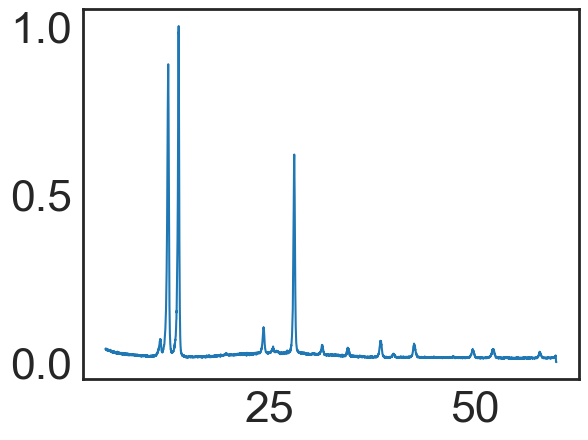

In [52]:
data = np.genfromtxt(r'G:\Materials\MIT\=Projects\XRD\20240926 FAPbI XRD\1FAPbI_Theta_2-Theta.xy', 
                     delimiter=" ", unpack=False)

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]
sample_height_displacement = -0.000329*1000
# sample_height_displacement = 0

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
print(twotheta_corrected)

X = interp1d(twotheta_corrected, X)(twotheta)
X = (X-np.min(X))/(np.max(X)-np.min(X))
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = np.expand_dims(Xs,axis=(0,-1))

# twotheta = twotheta[500:2501]
# Xs = Xs[:,500:2501,:]

plt.plot(twotheta,Xs[0,:,0])

Text(0, 0.5, 'Normalized intensity                      ')

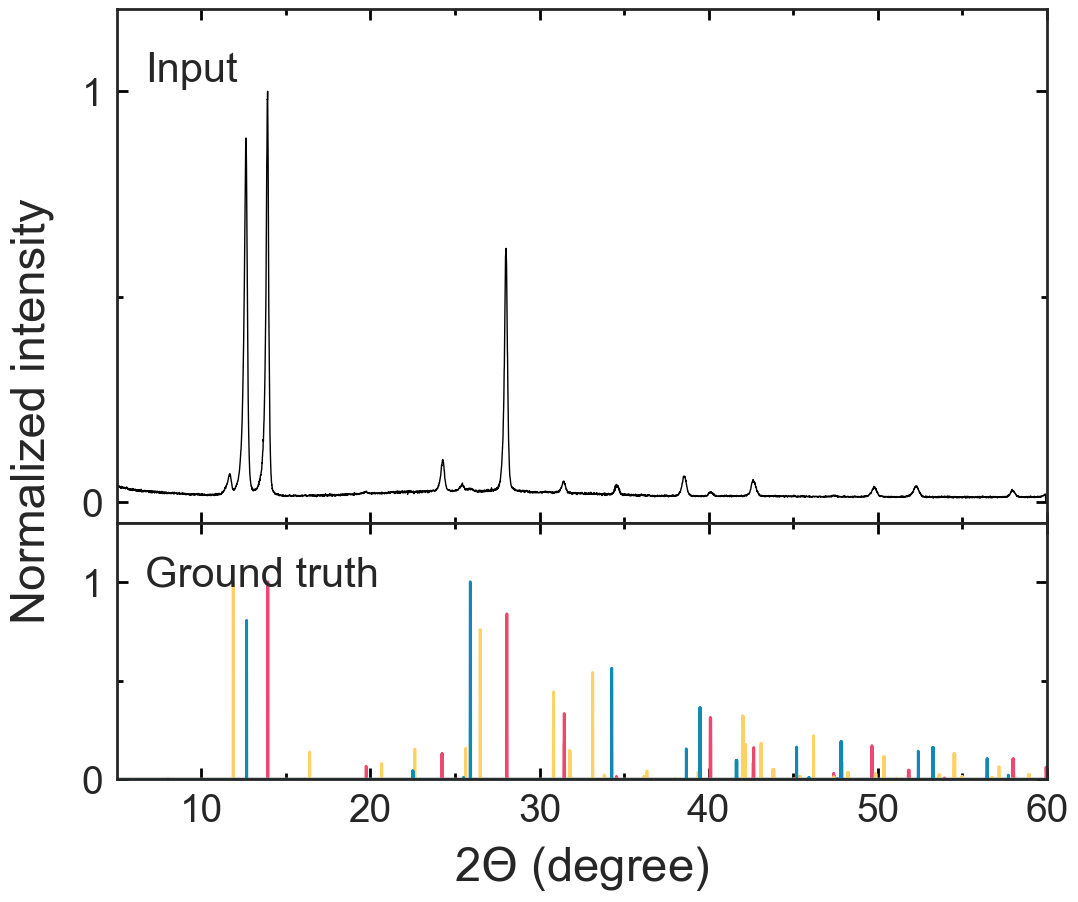

In [53]:
load_plt_setting()

fig, (ax0, ax1, ) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[2, 1]),figsize=(12, 10))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=1, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
# for sample_no, c in zip([44,46],["#ef476f","#ffd166"]):
for sample_no, c in zip([44,46,65],["#ef476f","#ffd166","#118ab2"]):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.3])
# ax2.axes.set_xlim([22.5,30])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.03, 0.86, 'Input', fontsize=30, transform=ax0.transAxes, horizontalalignment='left')
plt.text(0.03, 0.75, 'Ground truth', fontsize=30, transform=ax1.transAxes, horizontalalignment='left')
    
plt.subplots_adjust(hspace=.0)

sample_no = 860
ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Normalized intensity                      ', labelpad=20, fontsize=34)
# plt.savefig(os.path.join(folder, 'models', model_folder, 'Multiphase_{}_{}.png'.format(max_n_mix,sample_no)), 
#             format='png', dpi=300, transparent=True, bbox_inches='tight')

In [44]:
Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

In [45]:
order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
y_true_full = np.zeros(order.shape)
y_true_full[44] += 1
y_true_full[46] += 1
y_true_full[65] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = y_pred_full_sort/np.max(y_pred_full_sort)

for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], y_true_full_sort[i], order_sort[i], 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

-0.13863377 0.0 24.0 CsPb(I0.2Br0.8)3
-0.13016954 0.0 13.0 Cs0.4MA0.6PbI3
-0.12737411 0.0 34.0 Pnma-CsPbCl3
-0.09532744 0.0 27.0 CsPb(I0.8Br0.2)3
-0.094834566 0.0 4.0 Cs0.2FA0.8PbI3
-0.08478543 0.0 14.0 Cs0.6MA0.4PbI3
-0.083946325 0.0 19.0 CsPb2Br5
-0.08276009 0.0 15.0 Cs0.8MA0.2PbI3
-0.047577202 0.0 5.0 Cs0.4FA0.6PbI3
-0.024015192 0.0 45.0 beta-FAPbI3
-0.009716054 0.0 63.0 tetragonal-MAPbI3
0.027859647 0.0 7.0 Cs0.8FA0.2PbI3
0.028487397 0.0 30.0 CsPb(I0.6Cl0.4)3
0.030709308 0.0 31.0 CsPb(I0.8Cl0.2)3
0.08498871 1.0 44.0 alpha-FAPbI3
0.71167463 1.0 65.0 PbI2
0.7685004 0.0 38.0 gamma-CsPbI3
0.9324156 0.0 18.0 CsI
0.95185006 0.0 36.0 alpha-CsPbI3
1.0 0.0 37.0 delta-CsPbI3


Text(0.5, 0, 'Prediction score')

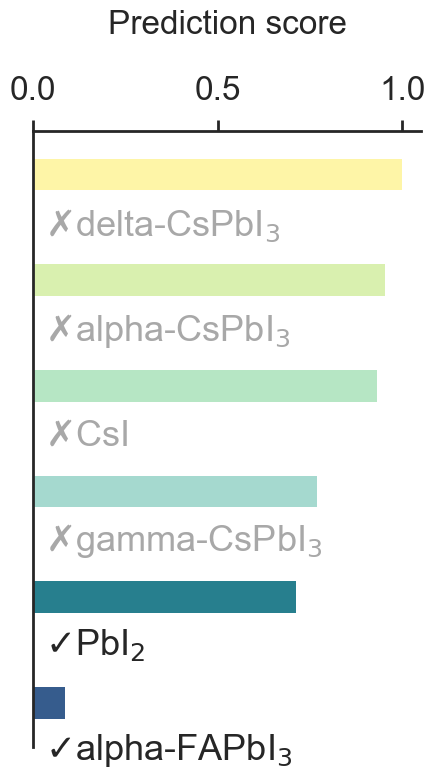

In [46]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 8))

cmap = mpl.cm.get_cmap('viridis')
cmap_index = np.linspace(0,1,8)

# formula_
for i in range(6):
    formula = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    if y_true_full_sort[-i-1] == 0:
        alpha = 0.4
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula)),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=cmap(cmap_index[-i-1]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=10, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

# ax.tick_params(axis='y', labelsize=24)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=24)

# plt.savefig(os.path.join(folder, 'models', model_folder, 'Multiphase_{}_{}_score.png'.format(max_n_mix,sample_no)), 
#             format='png', dpi=300, transparent=True, bbox_inches='tight')